In [1]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 3070


In [2]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.2, random_state=39)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:57, 75.84it/s]


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [24]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(24192, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 2)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 2)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
        self.mult = torch.tensor([512,384])
        self.mult = self.mult.to(device)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        # out_x = self.conv_layer3(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool3(out_x)
        # out_x = self.conv_layer4(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool4(out_x)

        out_x = self.flatten(out_x)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc3(out_x)
        out_x = self.sigmoid(out_x)
        out_x = out_x * self.mult
        # 
        # out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [36]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.00000001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 1500

In [37]:
dataset = ImageDataset(X_train, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

print(X_train[0].shape)

# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model = ConvNeuralNet(2)
model.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# # it lets me train in chunks over time.
# checkpoint = torch.load('model_duo.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch_start = checkpoint['epoch']
# loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model.train()

losses = []
losses_val = []


torch.Size([4, 68, 120])


In [33]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in tqdm(range(epoch_start, epoch_start + num_epochs)):
        start = time.time()
        model.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            output = model(images)
            # process into the separate multipliers. 
            
            loss = criterion(output, labels)
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss.backward()
            optimizer.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")
        model.eval()
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            output = model(images)
            # process into the separate multipliers. 
            loss_valid = criterion(output, labels)
            
        print('val')
        print(labels)
        print(output)

        # step lr scheduler
        # add so I can graph later
        losses.append(loss.item())
        losses_val.append(loss_valid.item())
        print('validate Loss_X: {:.10f}'.format(loss_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Time: {:.10f}'.format(epoch + 1, num_epochs + epoch_start, loss.item(), end-start))

    # torch.save({
    #                 'epoch': num_epochs,
    #                 'model_x_state_dict': model_x.state_dict(),
    #                 'optimizer_x_state_dict': optimizer_x.state_dict(),
    #                 'model_y_state_dict': model_y.state_dict(),
    #                 'optimizer_y_state_dict': optimizer_y.state_dict(),
    #                 'loss': criterion,
    #             }, "model.pth")
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")


if __name__ == '__main__':
    main()

  0%|          | 1/1500 [00:01<49:17,  1.97s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[226.1236, 203.5278],
        [226.6767, 203.1964],
        [226.6593, 203.3405],
        [226.0916, 203.4890],
        [226.2313, 203.5081],
        [226.4743, 203.2798],
        [226.7302,

  0%|          | 2/1500 [00:03<43:46,  1.75s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[231.1637, 200.6880],
        [232.5555, 199.9154],
        [232.4595, 200.1133],
        [231.0478, 200.5871],
        [231.4551, 200.5118],
        [232.1087, 199.9396],
        [232.6989,

  0%|          | 3/1500 [00:05<42:57,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[237.1630, 197.2236],
        [239.6108, 195.8985],
        [239.4120, 196.1562],
        [236.9297, 197.0238],
        [237.6747, 196.8382],
        [238.8378, 195.8106],
        [239.8530,

  0%|          | 4/1500 [00:06<41:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[243.7826, 193.2780],
        [247.2719, 191.4238],
        [246.9683, 191.7336],
        [243.3718, 192.9470],
        [244.4491, 192.6909],
        [246.1264, 191.1513],
        [247.5655,

  0%|          | 5/1500 [00:08<40:47,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[250.4525, 189.1649],
        [254.6678, 186.9979],
        [254.2909, 187.3196],
        [249.8000, 188.6777],
        [251.1216, 188.4465],
        [253.1675, 186.4534],
        [254.9145,

  0%|          | 6/1500 [00:10<40:28,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[256.5209, 185.2874],
        [261.0016, 183.1219],
        [260.5818, 183.4167],
        [255.5719, 184.6284],
        [257.0105, 184.5506],
        [259.1853, 182.2363],
        [261.0916,

  0%|          | 7/1500 [00:11<39:52,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[261.5444, 181.9427],
        [265.9340, 180.0300],
        [265.4910, 180.2796],
        [260.2620, 181.1046],
        [261.7133, 181.2880],
        [263.8221, 178.7662],
        [265.7995,

  1%|          | 8/1500 [00:13<39:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.4011, 179.2392],
        [269.5463, 177.7010],
        [269.0830, 177.9062],
        [263.7548, 178.2121],
        [265.1669, 178.7173],
        [267.1251, 176.0345],
        [269.1645,

  1%|          | 9/1500 [00:14<39:10,  1.58s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.1500, 177.1580],
        [272.0662, 176.0076],
        [271.5651, 176.1793],
        [266.1098, 175.9276],
        [267.4676, 176.7794],
        [269.2790, 173.9155],
        [271.4258,

  1%|          | 10/1500 [00:16<39:01,  1.57s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.8941, 175.6366],
        [273.6784, 174.8231],
        [273.1083, 174.9745],
        [267.4202, 174.1989],
        [268.7021, 175.4040],
        [270.4452, 172.2933],
        [272.7610,

  1%|          | 11/1500 [00:17<38:52,  1.57s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.7118, 174.6312],
        [274.4789, 174.0629],
        [273.8013, 174.2094],
        [267.7520, 173.0094],
        [268.9048, 174.5728],
        [270.7219, 171.1224],
        [273.2567,

  1%|          | 12/1500 [00:19<39:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.6384, 174.1476],
        [274.5033, 173.7040],
        [273.6712, 173.8740],
        [267.1260, 172.3964],
        [268.0575, 174.3440],
        [270.1566, 170.4389],
        [272.9400,

  1%|          | 13/1500 [00:21<39:26,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.6849, 174.2384],
        [273.7662, 173.7953],
        [272.7162, 174.0358],
        [265.5033, 172.4352],
        [266.0874, 174.8447],
        [268.7253, 170.3162],
        [271.8032,

  1%|          | 14/1500 [00:22<39:26,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.8578, 174.9672],
        [272.2820, 174.4275],
        [270.9181, 174.8099],
        [262.8326, 173.1941],
        [262.9149, 176.2214],
        [266.3347, 170.8203],
        [269.7998,

  1%|          | 15/1500 [00:24<39:31,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.2180, 176.3592],
        [270.0802, 175.6788],
        [268.2729, 176.2982],
        [259.1543, 174.6982],
        [258.5623, 178.5671],
        [262.9127, 171.9910],
        [266.8779,

  1%|          | 16/1500 [00:25<39:23,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[261.9341, 178.3677],
        [267.2549, 177.5713],
        [264.8576, 178.5348],
        [254.6883, 176.8896],
        [253.2962, 181.8309],
        [258.5411, 173.8329],
        [263.0842,

  1%|          | 17/1500 [00:27<39:20,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[258.3058, 180.8482],
        [264.0098, 180.0260],
        [260.9052, 181.4337],
        [249.8311, 179.5955],
        [247.6342, 185.7618],
        [253.5359, 176.2657],
        [258.6601,

  1%|          | 18/1500 [00:29<39:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[254.7359, 183.5545],
        [260.7040, 182.8410],
        [256.8406, 184.7569],
        [245.0665, 182.5222],
        [242.2067, 189.9316],
        [248.4125, 179.0588],
        [254.0716,

  1%|▏         | 19/1500 [00:30<39:31,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[251.6614, 186.1640],
        [257.8267, 185.6800],
        [253.2230, 188.1209],
        [240.8444, 185.2889],
        [237.5556, 193.8536],
        [243.7553, 181.8207],
        [249.9191,

  1%|▏         | 20/1500 [00:32<39:22,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[249.4836, 188.3244],
        [255.8994, 188.1327],
        [250.6074, 191.0811],
        [237.4873, 187.5062],
        [234.0043, 197.1226],
        [240.0715, 184.0732],
        [246.7769,

  1%|▏         | 21/1500 [00:33<39:17,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[248.4521, 189.7374],
        [255.2987, 189.8227],
        [249.3622, 193.2474],
        [235.1395, 188.8696],
        [231.6294, 199.5010],
        [237.6459, 185.3823],
        [245.0183,

  1%|▏         | 22/1500 [00:35<39:19,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[248.6351, 190.2513],
        [256.1241, 190.5562],
        [249.6032, 194.4028],
        [233.8130, 189.2098],
        [230.3543, 200.8963],
        [236.5193, 185.5135],
        [244.7221,

  2%|▏         | 23/1500 [00:37<39:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[249.9351, 189.8887],
        [258.2036, 190.3817],
        [251.2331, 194.5452],
        [233.4179, 188.5231],
        [230.0110, 201.3392],
        [236.5656, 184.4918],
        [245.7661,

  2%|▏         | 24/1500 [00:38<39:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[252.1307, 188.8122],
        [261.1768, 189.5357],
        [254.0054, 193.8485],
        [233.7908, 186.9411],
        [230.3893, 200.9460],
        [237.5595, 182.5431],
        [247.8946,

  2%|▏         | 25/1500 [00:40<39:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[254.9237, 187.2577],
        [264.6155, 188.3211],
        [257.5564, 192.5983],
        [234.7038, 184.6958],
        [231.2596, 199.8835],
        [239.2192, 180.0101],
        [250.7633,

  2%|▏         | 26/1500 [00:41<39:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[257.9903, 185.4727],
        [268.1206, 186.9938],
        [261.4628, 191.0908],
        [235.8980, 182.0565],
        [232.3571, 198.3483],
        [241.2258, 177.2423],
        [253.9823,

  2%|▏         | 27/1500 [00:43<39:19,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[261.0463, 183.6561],
        [271.4047, 185.7079],
        [265.3550, 189.5771],
        [237.1133, 179.2797],
        [233.4329, 196.5471],
        [243.2547, 174.5155],
        [257.1732,

  2%|▏         | 28/1500 [00:45<39:14,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[263.8725, 181.9323],
        [274.3160, 184.5241],
        [268.9691, 188.2139],
        [238.1133, 176.5642],
        [234.2662, 194.6746],
        [245.0120, 171.9915],
        [260.0382,

  2%|▏         | 29/1500 [00:46<39:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.3143, 180.3610],
        [276.7921, 183.4449],
        [272.1502, 187.0777],
        [238.6934, 174.0527],
        [234.6756, 192.9017],
        [246.2708, 169.7343],
        [262.3834,

  2%|▏         | 30/1500 [00:48<39:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.2724, 178.9623],
        [278.8174, 182.4580],
        [274.8213, 186.1937],
        [238.6955, 171.8439],
        [234.5341, 191.3867],
        [246.8579, 167.7591],
        [264.0833,

  2%|▏         | 31/1500 [00:49<39:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.7121, 177.7469],
        [280.4120, 181.5611],
        [276.9641, 185.5754],
        [238.0205, 170.0037],
        [233.8092, 190.2605],
        [246.6398, 166.0644],
        [265.0764,

  2%|▏         | 32/1500 [00:51<39:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.6338, 176.7313],
        [281.6087, 180.7642],
        [278.5986, 185.2446],
        [236.6435, 168.5868],
        [232.5773, 189.6174],
        [245.5754, 164.6602],
        [265.3412,

  2%|▏         | 33/1500 [00:53<39:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.0603, 175.9262],
        [282.4573, 180.0918],
        [279.7611, 185.2273],
        [234.6349, 167.6293],
        [231.0387, 189.4716],
        [243.6980, 163.5727],
        [264.8950,

  2%|▏         | 34/1500 [00:54<39:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.0691, 175.3569],
        [283.0286, 179.5778],
        [280.5287, 185.5634],
        [232.2016, 167.1418],
        [229.4746, 189.7695],
        [241.1465, 162.8420],
        [263.8073,

  2%|▏         | 35/1500 [00:56<38:50,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.7668, 175.0524],
        [283.4014, 179.2509],
        [280.9917, 186.2833],
        [229.5982, 167.1069],
        [228.1376, 190.4145],
        [238.1538, 162.5054],
        [262.2082,

  2%|▏         | 36/1500 [00:57<39:02,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.2768, 175.0353],
        [283.6622, 179.1300],
        [281.2431, 187.3911],
        [227.0598, 167.4743],
        [227.1874, 191.2902],
        [234.9954, 162.5759],
        [260.2703,

  2%|▏         | 37/1500 [00:59<38:57,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.7280, 175.3104],
        [283.8978, 179.2138],
        [281.3943, 188.8561],
        [224.7701, 168.1637],
        [226.6720, 192.2795],
        [231.9480, 163.0317],
        [258.2141,

  3%|▎         | 38/1500 [01:01<38:55,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.2566, 175.8515],
        [284.1846, 179.4705],
        [281.5689, 190.5970],
        [222.8438, 169.0733],
        [226.5511, 193.2866],
        [229.2332, 163.8118],
        [256.2752,

  3%|▎         | 39/1500 [01:02<38:46,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.9754, 176.6047],
        [284.5811, 179.8390],
        [281.8892, 192.4922],
        [221.3220, 170.0905],
        [226.7397, 194.2300],
        [226.9900, 164.8239],
        [254.6496,

  3%|▎         | 40/1500 [01:04<38:44,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.9756, 177.4897],
        [285.1123, 180.2268],
        [282.4677, 194.3960],
        [220.1939, 171.0943],
        [227.1451, 195.0410],
        [225.2712, 165.9544],
        [253.4703,

  3%|▎         | 41/1500 [01:05<38:39,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.2938, 178.3945],
        [285.7730, 180.5211],
        [283.3837, 196.1530],
        [219.4023, 171.9709],
        [227.6706, 195.6569],
        [224.0510, 167.0735],
        [252.7787,

  3%|▎         | 42/1500 [01:07<38:59,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.9197, 179.1974],
        [286.5214, 180.5983],
        [284.6914, 197.6318],
        [218.8625, 172.6183],
        [228.2309, 196.0277],
        [223.2367, 168.0467],
        [252.5319,

  3%|▎         | 43/1500 [01:09<38:45,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.7880, 179.7763],
        [287.2753, 180.3386],
        [286.3833, 198.7320],
        [218.4747, 172.9524],
        [228.7487, 196.1145],
        [222.7012, 168.7527],
        [252.6353,

  3%|▎         | 44/1500 [01:10<38:35,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.8091, 180.0378],
        [287.9455, 179.6606],
        [288.4089, 199.4027],
        [218.1420, 172.9198],
        [229.1688, 195.9051],
        [222.3090, 169.1015],
        [252.9601,

  3%|▎         | 45/1500 [01:12<38:28,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.8998, 179.9441],
        [288.4407, 178.5266],
        [290.6975, 199.6460],
        [217.7849, 172.5130],
        [229.4502, 195.4086],
        [221.9466, 169.0646],
        [253.3764,

  3%|▎         | 46/1500 [01:13<38:33,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.9315, 179.4805],
        [288.7007, 176.9675],
        [293.1750, 199.4990],
        [217.3450, 171.7728],
        [229.5567, 194.6522],
        [221.5196, 168.6489],
        [253.7940,

  3%|▎         | 47/1500 [01:15<38:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.9241, 178.7046],
        [288.7400, 175.0978],
        [295.7997, 199.0226],
        [216.8041, 170.7596],
        [229.4822, 193.6934],
        [221.0011, 167.9123],
        [254.1979,

  3%|▎         | 48/1500 [01:17<38:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.8643, 177.7292],
        [288.5960, 173.0696],
        [298.4738, 198.3194],
        [216.1655, 169.5750],
        [229.2463, 192.6165],
        [220.3887, 166.9744],
        [254.5519,

  3%|▎         | 49/1500 [01:18<38:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.6897, 176.6736],
        [288.2862, 171.0106],
        [301.0623, 197.5204],
        [215.4468, 168.3493],
        [228.8924, 191.5219],
        [219.6908, 165.9775],
        [254.8086,

  3%|▎         | 50/1500 [01:20<38:35,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.3618, 175.6484],
        [287.8450, 169.0282],
        [303.4626, 196.7447],
        [214.6697, 167.1953],
        [228.4719, 190.5053],
        [218.9315, 165.0443],
        [254.9479,

  3%|▎         | 51/1500 [01:21<38:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.8654, 174.7549],
        [287.2956, 167.1948],
        [305.6238, 196.0995],
        [213.8608, 166.2034],
        [228.0491, 189.6604],
        [218.1460, 164.2759],
        [254.9969,

  3%|▎         | 52/1500 [01:23<38:24,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.2127, 174.0803],
        [286.6700, 165.5712],
        [307.5390, 195.6726],
        [213.0529, 165.4451],
        [227.6825, 189.0626],
        [217.3744, 163.7467],
        [255.0102,

  4%|▎         | 53/1500 [01:24<38:21,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.4200, 173.6916],
        [285.9989, 164.1977],
        [309.2238, 195.5226],
        [212.2706, 164.9682],
        [227.4160, 188.7650],
        [216.6465, 163.5047],
        [255.0404,

  4%|▎         | 54/1500 [01:26<38:37,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.5081, 173.6268],
        [285.2920, 163.0928],
        [310.6959, 195.6729],
        [211.5268, 164.7934],
        [227.2900, 188.8060],
        [215.9852, 163.5790],
        [255.1149,

  4%|▎         | 55/1500 [01:28<38:24,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.4832, 173.8838],
        [284.5459, 162.2547],
        [311.9710, 196.1050],
        [210.8251, 164.9151],
        [227.3179, 189.1902],
        [215.4007, 163.9674],
        [255.2122,

  4%|▎         | 56/1500 [01:29<38:20,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.3289, 174.4207],
        [283.7373, 161.6556],
        [313.0600, 196.7666],
        [210.1511, 165.2967],
        [227.4834, 189.8869],
        [214.8766, 164.6324],
        [255.2831,

  4%|▍         | 57/1500 [01:31<38:16,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.0360, 175.1587],
        [282.8361, 161.2466],
        [313.9763, 197.5805],
        [209.4718, 165.8707],
        [227.7491, 190.8391],
        [214.3695, 165.4987],
        [255.2544,

  4%|▍         | 58/1500 [01:32<38:16,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.5946, 175.9895],
        [281.8246, 160.9701],
        [314.7419, 198.4522],
        [208.7383, 166.5412],
        [228.0701, 191.9738],
        [213.8076, 166.4523],
        [255.0624,

  4%|▍         | 59/1500 [01:34<38:23,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.0202, 176.8006],
        [280.7058, 160.7688],
        [315.3830, 199.2883],
        [207.9013, 167.2061],
        [228.3968, 193.2112],
        [213.1173, 167.3667],
        [254.6550,

  4%|▍         | 60/1500 [01:36<38:49,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.3371, 177.4937],
        [279.5012, 160.5930],
        [315.9221, 200.0082],
        [206.9248, 167.7749],
        [228.6938, 194.4826],
        [212.2378, 168.1242],
        [254.0244,

  4%|▍         | 61/1500 [01:37<38:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.6183, 178.0112],
        [278.2600, 160.4132],
        [316.3826, 200.5481],
        [205.7967, 168.1831],
        [228.9411, 195.7351],
        [211.1495, 168.6480],
        [253.2100,

  4%|▍         | 62/1500 [01:39<38:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.9618, 178.3329],
        [277.0440, 160.2184],
        [316.7838, 200.8682],
        [204.5352, 168.4026],
        [229.1467, 196.9414],
        [209.8742, 168.9132],
        [252.2926,

  4%|▍         | 63/1500 [01:41<38:26,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.4506, 178.4727],
        [275.9124, 160.0095],
        [317.1410, 200.9571],
        [203.1838, 168.4407],
        [229.3298, 198.0898],
        [208.4733, 168.9482],
        [251.3747,

  4%|▍         | 64/1500 [01:42<38:14,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.1706, 178.4644],
        [274.9111, 159.7961],
        [317.4702, 200.8289],
        [201.8011, 168.3297],
        [229.5139, 199.1799],
        [207.0267, 168.8168],
        [250.5571,

  4%|▍         | 65/1500 [01:44<38:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.1592, 178.3549],
        [274.0627, 159.5884],
        [317.7894, 200.5243],
        [200.4493, 168.1176],
        [229.7297, 200.2226],
        [205.6162, 168.5994],
        [249.9083,

  4%|▍         | 66/1500 [01:45<38:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.4142, 178.1852],
        [273.3719, 159.3961],
        [318.1209, 200.1010],
        [199.1842, 167.8541],
        [230.0002, 201.2298],
        [204.3070, 168.3690],
        [249.4430,

  4%|▍         | 67/1500 [01:47<38:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.8958, 177.9911],
        [272.8215, 159.2212],
        [318.4834, 199.6237],
        [198.0414, 167.5800],
        [230.3425, 202.2142],
        [203.1346, 168.1747],
        [249.1087,

  5%|▍         | 68/1500 [01:49<38:09,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.5237, 177.8004],
        [272.3839, 159.0610],
        [318.8812, 199.1431],
        [197.0356, 167.3219],
        [230.7624, 203.1841],
        [202.1137, 168.0421],
        [248.8149,

  5%|▍         | 69/1500 [01:50<37:56,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.2093, 177.6236],
        [272.0343, 158.9106],
        [319.3017, 198.6870],
        [196.1627, 167.0943],
        [231.2577, 204.1437],
        [201.2381, 167.9733],
        [248.4446,

  5%|▍         | 70/1500 [01:52<37:51,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.8691, 177.4664],
        [271.7403, 158.7598],
        [319.7172, 198.2650],
        [195.4040, 166.9010],
        [231.8108, 205.0859],
        [200.4895, 167.9588],
        [247.8807,

  5%|▍         | 71/1500 [01:53<37:49,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.4459, 177.3271],
        [271.4854, 158.6011],
        [320.1002, 197.8723],
        [194.7377, 166.7408],
        [232.4044, 206.0003],
        [199.8553, 167.9854],
        [247.0617,

  5%|▍         | 72/1500 [01:55<38:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.9130, 177.2014],
        [271.2614, 158.4288],
        [320.4289, 197.5028],
        [194.1450, 166.6098],
        [233.0146, 206.8691],
        [199.3246, 168.0402],
        [245.9674,

  5%|▍         | 73/1500 [01:57<38:02,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.2838, 177.0851],
        [271.0821, 158.2440],
        [320.6969, 197.1544],
        [193.6126, 166.4999],
        [233.6250, 207.6741],
        [198.9025, 168.1146],
        [244.6495,

  5%|▍         | 74/1500 [01:58<37:52,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.6018, 176.9722],
        [270.9692, 158.0503],
        [320.9048, 196.8242],
        [193.1369, 166.4046],
        [234.2283, 208.3991],
        [198.6076, 168.2070],
        [243.2017,

  5%|▌         | 75/1500 [02:00<37:43,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.9433, 176.8580],
        [270.9538, 157.8551],
        [321.0581, 196.5092],
        [192.7141, 166.3121],
        [234.8258, 209.0315],
        [198.4585, 168.3152],
        [241.7547,

  5%|▌         | 76/1500 [02:01<37:43,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.3899, 176.7365],
        [271.0734, 157.6705],
        [321.1642, 196.2022],
        [192.3414, 166.2089],
        [235.4293, 209.5647],
        [198.4699, 168.4363],
        [240.4366,

  5%|▌         | 77/1500 [02:03<37:42,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.0070, 176.6059],
        [271.3543, 157.5074],
        [321.2281, 195.8966],
        [192.0121, 166.0820],
        [236.0603, 209.9986],
        [198.6374, 168.5619],
        [239.3458,

  5%|▌         | 78/1500 [02:05<38:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.8327, 176.4633],
        [271.8044, 157.3730],
        [321.2509, 195.5837],
        [191.7199, 165.9242],
        [236.7430, 210.3372],
        [198.9514, 168.6846],
        [238.5172,

  5%|▌         | 79/1500 [02:06<38:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.8624, 176.3030],
        [272.4139, 157.2717],
        [321.2248, 195.2565],
        [191.4548, 165.7311],
        [237.4889, 210.5816],
        [199.3743, 168.7892],
        [237.9554,

  5%|▌         | 80/1500 [02:08<37:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.0355, 176.1178],
        [273.1499, 157.2005],
        [321.1394, 194.9180],
        [191.2061, 165.5088],
        [238.3091, 210.7377],
        [199.8643, 168.8632],
        [237.5941,

  5%|▌         | 81/1500 [02:09<37:42,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.2630, 175.8970],
        [273.9616, 157.1497],
        [320.9841, 194.5773],
        [190.9650, 165.2730],
        [239.1962, 210.8079],
        [200.3657, 168.8949],
        [237.3613,

  5%|▌         | 82/1500 [02:11<37:37,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.4779, 175.6438],
        [274.7925, 157.1043],
        [320.7542, 194.2525],
        [190.7310, 165.0462],
        [240.1367, 210.7958],
        [200.8286, 168.8765],
        [237.1793,

  6%|▌         | 83/1500 [02:12<37:33,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.6152, 175.3660],
        [275.6070, 157.0576],
        [320.4536, 193.9608],
        [190.5110, 164.8566],
        [241.1113, 210.7072],
        [201.2419, 168.8181],
        [237.0016,

  6%|▌         | 84/1500 [02:14<38:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.6388, 175.0789],
        [276.3976, 157.0161],
        [320.0919, 193.7161],
        [190.3182, 164.7336],
        [242.1146, 210.5555],
        [201.5997, 168.7318],
        [236.8223,

  6%|▌         | 85/1500 [02:16<37:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.5622, 174.8018],
        [277.1963, 157.0053],
        [319.6884, 193.5236],
        [190.1691, 164.7018],
        [243.1365, 210.3508],
        [201.9207, 168.6382],
        [236.6802,

  6%|▌         | 86/1500 [02:17<37:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.4226, 174.5545],
        [278.0500, 157.0552],
        [319.2768, 193.3820],
        [190.0860, 164.7796],
        [244.1971, 210.1114],
        [202.2442, 168.5650],
        [236.6432,

  6%|▌         | 87/1500 [02:19<37:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.2651, 174.3447],
        [279.0152, 157.1972],
        [318.8984, 193.2857],
        [190.0898, 164.9731],
        [245.3267, 209.8517],
        [202.6091, 168.5317],
        [236.8068,

  6%|▌         | 88/1500 [02:20<37:28,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.1275, 174.1748],
        [280.1183, 157.4420],
        [318.5849, 193.2268],
        [190.1903, 165.2826],
        [246.5498, 209.5818],
        [203.0379, 168.5473],
        [237.2283,

  6%|▌         | 89/1500 [02:22<37:24,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.0502, 174.0378],
        [281.3572, 157.7766],
        [318.3622, 193.1942],
        [190.3903, 165.6908],
        [247.8627, 209.2991],
        [203.5380, 168.6057],
        [237.9512,

  6%|▌         | 90/1500 [02:24<37:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0219, 173.9143],
        [282.6881, 158.1654],
        [318.2279, 193.1756],
        [190.6773, 166.1730],
        [249.2392, 208.9953],
        [204.0997, 168.6919],
        [238.9710,

  6%|▌         | 91/1500 [02:25<37:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0056, 173.7816],
        [284.0488, 158.5656],
        [318.1602, 193.1555],
        [191.0291, 166.7007],
        [250.6194, 208.6569],
        [204.6932, 168.7792],
        [240.2437,

  6%|▌         | 92/1500 [02:27<37:32,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9662, 173.6198],
        [285.3884, 158.9509],
        [318.1164, 193.1179],
        [191.4155, 167.2442],
        [251.9261, 208.2718],
        [205.2801, 168.8383],
        [241.6982,

  6%|▌         | 93/1500 [02:28<37:25,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8444, 173.4087],
        [286.6636, 159.3038],
        [318.0517, 193.0483],
        [191.8119, 167.7764],
        [253.0984, 207.8322],
        [205.8427, 168.8472],
        [243.2551,

  6%|▋         | 94/1500 [02:30<37:19,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.6360, 173.1404],
        [287.8471, 159.6170],
        [317.9325, 192.9401],
        [192.1993, 168.2769],
        [254.1156, 207.3424],
        [206.3729, 168.7923],
        [244.8494,

  6%|▋         | 95/1500 [02:32<37:15,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[297.3169, 172.8116],
        [288.9190, 159.8862],
        [317.7429, 192.7941],
        [192.5690, 168.7352],
        [254.9652, 206.8119],
        [206.8884, 168.6744],
        [246.4287,

  6%|▋         | 96/1500 [02:33<37:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[297.9167, 172.4312],
        [289.8844, 160.1168],
        [317.4913, 192.6214],
        [192.9250, 169.1475],
        [255.6709, 206.2585],
        [207.4124, 168.5005],
        [247.9819,

  6%|▋         | 97/1500 [02:35<37:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[298.4710, 172.0121],
        [290.7560, 160.3165],
        [317.2001, 192.4415],
        [193.2905, 169.5175],
        [256.2896, 205.7033],
        [207.9868, 168.2845],
        [249.5120,

  7%|▋         | 98/1500 [02:37<37:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[299.0186, 171.5693],
        [291.5498, 160.4944],
        [316.9075, 192.2734],
        [193.6790, 169.8507],
        [256.8433, 205.1655],
        [208.6420, 168.0370],
        [251.0418,

  7%|▋         | 99/1500 [02:38<37:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[299.5946, 171.1188],
        [292.2797, 160.6550],
        [316.6308, 192.1319],
        [194.1014, 170.1524],
        [257.3544, 204.6581],
        [209.4094, 167.7653],
        [252.5701,

  7%|▋         | 100/1500 [02:40<37:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[300.2246, 170.6722],
        [292.9686, 160.8067],
        [316.3941, 192.0262],
        [194.5603, 170.4288],
        [257.8365, 204.1892],
        [210.2939, 167.4755],
        [254.1232,

  7%|▋         | 101/1500 [02:41<37:15,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[300.8842, 170.2386],
        [293.6297, 160.9507],
        [316.1842, 191.9577],
        [195.0411, 170.6877],
        [258.2872, 203.7641],
        [211.2766, 167.1801],
        [255.6715,

  7%|▋         | 102/1500 [02:43<37:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[301.5657, 169.8208],
        [294.2690, 161.0845],
        [315.9933, 191.9206],
        [195.5279, 170.9287],
        [258.6960, 203.3827],
        [212.3292, 166.8891],
        [257.2030,

  7%|▋         | 103/1500 [02:45<37:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[302.2272, 169.4115],
        [294.8890, 161.2041],
        [315.7917, 191.9024],
        [195.9984, 171.1441],
        [259.0487, 203.0371],
        [213.3968, 166.6115],
        [258.6971,

  7%|▋         | 104/1500 [02:46<37:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[302.8415, 169.0049],
        [295.4922, 161.3073],
        [315.5676, 191.8933],
        [196.4305, 171.3248],
        [259.3257, 202.7193],
        [214.4465, 166.3470],
        [260.1363,

  7%|▋         | 105/1500 [02:48<37:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[303.3780, 168.5879],
        [296.0692, 161.3872],
        [315.3073, 191.8818],
        [196.8172, 171.4607],
        [259.5262, 202.4215],
        [215.4535, 166.0844],
        [261.5101,

  7%|▋         | 106/1500 [02:49<37:01,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[303.8488, 168.1557],
        [296.6326, 161.4473],
        [315.0152, 191.8599],
        [197.1548, 171.5353],
        [259.6629, 202.1373],
        [216.4122, 165.8007],
        [262.8282,

  7%|▋         | 107/1500 [02:51<36:59,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[304.2643, 167.7031],
        [297.1875, 161.4869],
        [314.7049, 191.8242],
        [197.4547, 171.5397],
        [259.7378, 201.8599],
        [217.3308, 165.4775],
        [264.1034,

  7%|▋         | 108/1500 [02:53<37:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[304.6250, 167.2248],
        [297.7562, 161.5150],
        [314.4014, 191.7747],
        [197.7305, 171.4661],
        [259.7684, 201.5873],
        [218.2115, 165.0922],
        [265.3586,

  7%|▋         | 109/1500 [02:54<37:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[304.9481, 166.7236],
        [298.3464, 161.5345],
        [314.1320, 191.7146],
        [198.0046, 171.3159],
        [259.7644, 201.3180],
        [219.0633, 164.6330],
        [266.5979,

  7%|▋         | 110/1500 [02:56<37:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.2148, 166.1962],
        [298.9711, 161.5529],
        [313.9192, 191.6497],
        [198.2903, 171.0923],
        [259.7326, 201.0514],
        [219.8760, 164.0930],
        [267.8055,

  7%|▋         | 111/1500 [02:57<37:07,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.4233, 165.6472],
        [299.6347, 161.5749],
        [313.7740, 191.5858],
        [198.5972, 170.8077],
        [259.6589, 200.7845],
        [220.6415, 163.4783],
        [268.9509,

  7%|▋         | 112/1500 [02:59<36:53,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.5305, 165.0735],
        [300.3273, 161.6003],
        [313.6965, 191.5295],
        [198.9262, 170.4766],
        [259.5382, 200.5172],
        [221.3411, 162.8022],
        [269.9937,

  8%|▊         | 113/1500 [03:01<36:45,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.5219, 164.4793],
        [301.0443, 161.6316],
        [313.6798, 191.4869],
        [199.2757, 170.1133],
        [259.3661, 200.2475],
        [221.9642, 162.0850],
        [270.9116,

  8%|▊         | 114/1500 [03:02<37:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.3634, 163.8646],
        [301.7622, 161.6642],
        [313.7007, 191.4610],
        [199.6374, 169.7305],
        [259.1421, 199.9747],
        [222.4992, 161.3431],
        [271.6715,

  8%|▊         | 115/1500 [03:04<36:56,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[305.0454, 163.2311],
        [302.4683, 161.6968],
        [313.7371, 191.4524],
        [200.0043, 169.3352],
        [258.8768, 199.6954],
        [222.9472, 160.5919],
        [272.2680,

  8%|▊         | 116/1500 [03:05<37:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[304.5811, 162.5875],
        [303.1620, 161.7321],
        [313.7728, 191.4613],
        [200.3663, 168.9319],
        [258.5772, 199.4072],
        [223.3055, 159.8459],
        [272.6940,

  8%|▊         | 117/1500 [03:07<36:57,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[303.9660, 161.9360],
        [303.8312, 161.7675],
        [313.7937, 191.4852],
        [200.7166, 168.5227],
        [258.2752, 199.1136],
        [223.5839, 159.1118],
        [272.9739,

  8%|▊         | 118/1500 [03:09<36:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[303.2271, 161.2841],
        [304.4897, 161.8082],
        [313.7892, 191.5242],
        [201.0558, 168.1105],
        [257.9605, 198.8180],
        [223.7883, 158.4002],
        [273.1324,

  8%|▊         | 119/1500 [03:10<36:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[302.3897, 160.6367],
        [305.1406, 161.8563],
        [313.7525, 191.5780],
        [201.3811, 167.6994],
        [257.6461, 198.5314],
        [223.9302, 157.7193],
        [273.1774,

  8%|▊         | 120/1500 [03:12<37:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[301.4881, 160.0008],
        [305.7969, 161.9151],
        [313.6778, 191.6451],
        [201.6831, 167.2952],
        [257.3341, 198.2660],
        [224.0113, 157.0736],
        [273.1477,

  8%|▊         | 121/1500 [03:13<36:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[300.5224, 159.3755],
        [306.4572, 161.9843],
        [313.5500, 191.7267],
        [201.9529, 166.9136],
        [257.0117, 198.0321],
        [224.0280, 156.4676],
        [273.0390,

  8%|▊         | 122/1500 [03:15<36:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[299.5034, 158.7607],
        [307.1329, 162.0644],
        [313.3617, 191.8174],
        [202.1769, 166.5588],
        [256.6886, 197.8370],
        [223.9789, 155.8973],
        [272.8399,

  8%|▊         | 123/1500 [03:17<36:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[298.4470, 158.1599],
        [307.8240, 162.1545],
        [313.1017, 191.9102],
        [202.3519, 166.2392],
        [256.3620, 197.6829],
        [223.8639, 155.3564],
        [272.5493,

  8%|▊         | 124/1500 [03:18<36:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[297.3567, 157.5701],
        [308.5333, 162.2536],
        [312.7561, 191.9962],
        [202.4754, 165.9506],
        [256.0423, 197.5691],
        [223.6902, 154.8372],
        [272.1557,

  8%|▊         | 125/1500 [03:20<36:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2181, 156.9899],
        [309.2595, 162.3605],
        [312.3201, 192.0680],
        [202.5462, 165.6967],
        [255.7359, 197.4935],
        [223.4716, 154.3302],
        [271.6431,

  8%|▊         | 126/1500 [03:21<36:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0741, 156.4268],
        [310.0014, 162.4754],
        [311.8001, 192.1204],
        [202.5738, 165.4659],
        [255.4427, 197.4477],
        [223.2225, 153.8281],
        [271.0355,

  8%|▊         | 127/1500 [03:23<36:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9054, 155.8757],
        [310.7498, 162.5975],
        [311.1926, 192.1495],
        [202.5690, 165.2513],
        [255.1698, 197.4249],
        [222.9598, 153.3266],
        [270.3336,

  9%|▊         | 128/1500 [03:25<36:35,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7346, 155.3408],
        [311.4964, 162.7283],
        [310.5128, 192.1554],
        [202.5353, 165.0430],
        [254.9165, 197.4162],
        [222.7044, 152.8192],
        [269.5728,

  9%|▊         | 129/1500 [03:26<36:26,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.5651, 154.8224],
        [312.2303, 162.8690],
        [309.7718, 192.1372],
        [202.4883, 164.8373],
        [254.6866, 197.4158],
        [222.4677, 152.3003],
        [268.7991,

  9%|▊         | 130/1500 [03:28<36:37,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.3975, 154.3175],
        [312.9363, 163.0197],
        [308.9847, 192.0939],
        [202.4302, 164.6330],
        [254.4734, 197.4160],
        [222.2615, 151.7644],
        [268.0351,

  9%|▊         | 131/1500 [03:29<36:29,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.2321, 153.8249],
        [313.6030, 163.1847],
        [308.1566, 192.0248],
        [202.3722, 164.4298],
        [254.2775, 197.4137],
        [222.0970, 151.2078],
        [267.2942,

  9%|▉         | 132/1500 [03:31<36:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.0598, 153.3400],
        [314.2138, 163.3648],
        [307.3089, 191.9285],
        [202.3217, 164.2271],
        [254.0985, 197.4081],
        [221.9847, 150.6253],
        [266.5896,

  9%|▉         | 133/1500 [03:33<36:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.8700, 152.8566],
        [314.7690, 163.5631],
        [306.4461, 191.8046],
        [202.2918, 164.0275],
        [253.9395, 197.4005],
        [221.9207, 150.0181],
        [265.9115,

  9%|▉         | 134/1500 [03:34<36:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.6524, 152.3716],
        [315.2719, 163.7806],
        [305.5732, 191.6532],
        [202.2865, 163.8324],
        [253.8034, 197.3924],
        [221.9023, 149.3926],
        [265.2321,

  9%|▉         | 135/1500 [03:36<36:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.4108, 151.8802],
        [315.7354, 164.0135],
        [304.6992, 191.4749],
        [202.3190, 163.6407],
        [253.6927, 197.3864],
        [221.9170, 148.7565],
        [264.5543,

  9%|▉         | 136/1500 [03:37<36:11,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.1487, 151.3831],
        [316.1903, 164.2610],
        [303.8317, 191.2763],
        [202.3887, 163.4551],
        [253.6038, 197.3852],
        [221.9602, 148.1270],
        [263.8587,

  9%|▉         | 137/1500 [03:39<36:13,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.8926, 150.8831],
        [316.6644, 164.5197],
        [302.9742, 191.0647],
        [202.4990, 163.2757],
        [253.5379, 197.3891],
        [222.0188, 147.5140],
        [263.1419,

  9%|▉         | 138/1500 [03:41<36:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.6433, 150.3826],
        [317.1699, 164.7858],
        [302.1292, 190.8464],
        [202.6533, 163.1049],
        [253.5001, 197.3996],
        [222.0808, 146.9319],
        [262.4077,

  9%|▉         | 139/1500 [03:42<36:27,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.3928, 149.8785],
        [317.7269, 165.0611],
        [301.2942, 190.6290],
        [202.8394, 162.9414],
        [253.4835, 197.4169],
        [222.1417, 146.3886],
        [261.6690,

  9%|▉         | 140/1500 [03:44<36:17,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.1827, 149.3810],
        [318.3394, 165.3478],
        [300.4730, 190.4195],
        [203.0445, 162.7851],
        [253.4780, 197.4400],
        [222.1934, 145.8822],
        [260.9382,

  9%|▉         | 141/1500 [03:45<36:10,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.9842, 148.8848],
        [319.0030, 165.6488],
        [299.6568, 190.2237],
        [203.2643, 162.6361],
        [253.4879, 197.4684],
        [222.2259, 145.4131],
        [260.2415,

  9%|▉         | 142/1500 [03:47<36:01,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.7868, 148.3891],
        [319.7077, 165.9687],
        [298.8520, 190.0461],
        [203.4886, 162.4942],
        [253.5132, 197.5064],
        [222.2345, 144.9753],
        [259.5754,

 10%|▉         | 143/1500 [03:49<36:02,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.5920, 147.8979],
        [320.4411, 166.3154],
        [298.0599, 189.8901],
        [203.7045, 162.3660],
        [253.5501, 197.5547],
        [222.2028, 144.5648],
        [258.9700,

 10%|▉         | 144/1500 [03:50<36:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.3853, 147.4075],
        [321.1862, 166.6892],
        [297.2877, 189.7597],
        [203.9103, 162.2497],
        [253.6062, 197.6178],
        [222.1223, 144.1767],
        [258.4070,

 10%|▉         | 145/1500 [03:52<36:13,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.1545, 146.9173],
        [321.9323, 167.0971],
        [296.5324, 189.6557],
        [204.0986, 162.1468],
        [253.6770, 197.7004],
        [221.9876, 143.8068],
        [257.8905,

 10%|▉         | 146/1500 [03:53<36:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.8912, 146.4232],
        [322.6664, 167.5398],
        [295.8003, 189.5745],
        [204.2678, 162.0560],
        [253.7812, 197.8093],
        [221.7899, 143.4475],
        [257.4330,

 10%|▉         | 147/1500 [03:55<35:56,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.6228, 145.9272],
        [323.3756, 168.0170],
        [295.0733, 189.5132],
        [204.4226, 161.9762],
        [253.9203, 197.9505],
        [221.5422, 143.0956],
        [257.0272,

 10%|▉         | 148/1500 [03:57<35:52,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.3333, 145.4289],
        [324.0467, 168.5210],
        [294.3383, 189.4650],
        [204.5663, 161.9077],
        [254.1184, 198.1284],
        [221.2472, 142.7473],
        [256.6783,

 10%|▉         | 149/1500 [03:58<35:46,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.0430, 144.9268],
        [324.6755, 169.0406],
        [293.5811, 189.4237],
        [204.6966, 161.8513],
        [254.3675, 198.3452],
        [220.9156, 142.3981],
        [256.4009,

 10%|█         | 150/1500 [04:00<36:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.7525, 144.4206],
        [325.2648, 169.5585],
        [292.8047, 189.3828],
        [204.8258, 161.8017],
        [254.6667, 198.5952],
        [220.5655, 142.0451],
        [256.2041,

 10%|█         | 151/1500 [04:01<36:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[264.4765, 143.9108],
        [325.8192, 170.0552],
        [292.0123, 189.3370],
        [204.9748, 161.7693],
        [254.9982, 198.8653],
        [220.2138, 141.6861],
        [256.0914,

 10%|█         | 152/1500 [04:03<35:57,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[263.2279, 143.3977],
        [326.3515, 170.5177],
        [291.2073, 189.2816],
        [205.1546, 161.7536],
        [255.3391, 199.1429],
        [219.8696, 141.3170],
        [256.0555,

 10%|█         | 153/1500 [04:05<35:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[262.0077, 142.8824],
        [326.8680, 170.9345],
        [290.3752, 189.2144],
        [205.3765, 161.7580],
        [255.6675, 199.4140],
        [219.5367, 140.9349],
        [256.0762,

 10%|█         | 154/1500 [04:06<35:56,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[260.8237, 142.3648],
        [327.3768, 171.3062],
        [289.5112, 189.1306],
        [205.6313, 161.7789],
        [255.9641, 199.6669],
        [219.2152, 140.5349],
        [256.1482,

 10%|█         | 155/1500 [04:08<35:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[259.6939, 141.8510],
        [327.8851, 171.6384],
        [288.5941, 189.0281],
        [205.9062, 161.8167],
        [256.2264, 199.8968],
        [218.9054, 140.1146],
        [256.2549,

 10%|█         | 156/1500 [04:09<36:28,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[258.6369, 141.3458],
        [328.3919, 171.9380],
        [287.6154, 188.9074],
        [206.1919, 161.8666],
        [256.4441, 200.0983],
        [218.6153, 139.6753],
        [256.3754,

 10%|█         | 157/1500 [04:11<36:16,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[257.6664, 140.8539],
        [328.9066, 172.2129],
        [286.5659, 188.7668],
        [206.4759, 161.9276],
        [256.6327, 200.2704],
        [218.3426, 139.2208],
        [256.5096,

 11%|█         | 158/1500 [04:13<36:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[256.7660, 140.3755],
        [329.4346, 172.4681],
        [285.4577, 188.6124],
        [206.7540, 161.9982],
        [256.7845, 200.4143],
        [218.0871, 138.7570],
        [256.6479,

 11%|█         | 159/1500 [04:14<35:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[255.9727, 139.9198],
        [329.9777, 172.7075],
        [284.3125, 188.4508],
        [207.0251, 162.0766],
        [256.9057, 200.5309],
        [217.8560, 138.2899],
        [256.7905,

 11%|█         | 160/1500 [04:16<35:46,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[255.2414, 139.4811],
        [330.5441, 172.9331],
        [283.1587, 188.2900],
        [207.2783, 162.1616],
        [257.0060, 200.6245],
        [217.6389, 137.8257],
        [256.9295,

 11%|█         | 161/1500 [04:17<35:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[254.5984, 139.0639],
        [331.1435, 173.1498],
        [282.0139, 188.1358],
        [207.5286, 162.2511],
        [257.0831, 200.6975],
        [217.4348, 137.3676],
        [257.0640,

 11%|█         | 162/1500 [04:19<36:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[254.0008, 138.6593],
        [331.7698, 173.3595],
        [280.8957, 187.9942],
        [207.7620, 162.3453],
        [257.1413, 200.7547],
        [217.2399, 136.9185],
        [257.1721,

 11%|█         | 163/1500 [04:21<35:54,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[253.4805, 138.2722],
        [332.4567, 173.5710],
        [279.8136, 187.8620],
        [207.9868, 162.4331],
        [257.1791, 200.7950],
        [217.0485, 136.4787],
        [257.2781,

 11%|█         | 164/1500 [04:22<35:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[253.0125, 137.8947],
        [333.1967, 173.7886],
        [278.7629, 187.7362],
        [208.1862, 162.5056],
        [257.1959, 200.8207],
        [216.8561, 136.0484],
        [257.3634,

 11%|█         | 165/1500 [04:24<35:35,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[252.5937, 137.5259],
        [334.0051, 174.0200],
        [277.7419, 187.6146],
        [208.3677, 162.5604],
        [257.1911, 200.8305],
        [216.6655, 135.6281],
        [257.4355,

 11%|█         | 166/1500 [04:26<35:34,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[252.2475, 137.1681],
        [334.8761, 174.2724],
        [276.7437, 187.4892],
        [208.5293, 162.5904],
        [257.1607, 200.8242],
        [216.4842, 135.2174],
        [257.4888,

 11%|█         | 167/1500 [04:27<35:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[251.9388, 136.8149],
        [335.7900, 174.5477],
        [275.7567, 187.3562],
        [208.6577, 162.5899],
        [257.1039, 200.8012],
        [216.2978, 134.8177],
        [257.5144,

 11%|█         | 168/1500 [04:29<35:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[251.6881, 136.4720],
        [336.7283, 174.8508],
        [274.7924, 187.2139],
        [208.7602, 162.5675],
        [257.0213, 200.7627],
        [216.1181, 134.4285],
        [257.5301,

 11%|█▏        | 169/1500 [04:30<35:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[251.4481, 136.1324],
        [337.6666, 175.1816],
        [273.8369, 187.0653],
        [208.8307, 162.5224],
        [256.9124, 200.7105],
        [215.9442, 134.0501],
        [257.5177,

 11%|█▏        | 170/1500 [04:32<35:33,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[251.2163, 135.7978],
        [338.5862, 175.5308],
        [272.9062, 186.9126],
        [208.8656, 162.4599],
        [256.7857, 200.6472],
        [215.7711, 133.6800],
        [257.4951,

 11%|█▏        | 171/1500 [04:34<35:22,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[250.9612, 135.4646],
        [339.4764, 175.8845],
        [272.0005, 186.7598],
        [208.8774, 162.3913],
        [256.6426, 200.5751],
        [215.5990, 133.3183],
        [257.4533,

 11%|█▏        | 172/1500 [04:35<35:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[250.6843, 135.1375],
        [340.3316, 176.2233],
        [271.1078, 186.6091],
        [208.8602, 162.3201],
        [256.4783, 200.4946],
        [215.4244, 132.9636],
        [257.3890,

 12%|█▏        | 173/1500 [04:37<35:15,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[250.3620, 134.8103],
        [341.1513, 176.5291],
        [270.2342, 186.4597],
        [208.8288, 162.2536],
        [256.2983, 200.4079],
        [215.2446, 132.6147],
        [257.2940,

 12%|█▏        | 174/1500 [04:38<35:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[249.9788, 134.4815],
        [341.9431, 176.7908],
        [269.3751, 186.3103],
        [208.7923, 162.1918],
        [256.1050, 200.3149],
        [215.0558, 132.2713],
        [257.1622,

 12%|█▏        | 175/1500 [04:40<35:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[249.5855, 134.1616],
        [342.7173, 177.0129],
        [268.5205, 186.1609],
        [208.7774, 162.1449],
        [255.8938, 200.2161],
        [214.8651, 131.9357],
        [256.9911,

 12%|█▏        | 176/1500 [04:42<35:52,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[249.1526, 133.8439],
        [343.4839, 177.2051],
        [267.6516, 186.0094],
        [208.8006, 162.1174],
        [255.6658, 200.1091],
        [214.6648, 131.6079],
        [256.7884,

 12%|█▏        | 177/1500 [04:43<35:44,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[248.7059, 133.5342],
        [344.2511, 177.3772],
        [266.7498, 185.8570],
        [208.8788, 162.1114],
        [255.4297, 199.9969],
        [214.4565, 131.2903],
        [256.5587,

 12%|█▏        | 178/1500 [04:45<35:58,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[248.2487, 133.2341],
        [345.0365, 177.5459],
        [265.7905, 185.7066],
        [209.0259, 162.1336],
        [255.1871, 199.8790],
        [214.2314, 130.9828],
        [256.3217,

 12%|█▏        | 179/1500 [04:47<36:06,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[247.7680, 132.9414],
        [345.8348, 177.7175],
        [264.7570, 185.5635],
        [209.2407, 162.1857],
        [254.9450, 199.7577],
        [213.9924, 130.6897],
        [256.0922,

 12%|█▏        | 180/1500 [04:48<36:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[247.2701, 132.6575],
        [346.6671, 177.9038],
        [263.6405, 185.4330],
        [209.5307, 162.2758],
        [254.7105, 199.6332],
        [213.7285, 130.4102],
        [255.8867,

 12%|█▏        | 181/1500 [04:50<36:12,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[246.7755, 132.3865],
        [347.5392, 178.1109],
        [262.4580, 185.3237],
        [209.8830, 162.3954],
        [254.4857, 199.5057],
        [213.4334, 130.1456],
        [255.7219,

 12%|█▏        | 182/1500 [04:51<36:00,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[246.2713, 132.1261],
        [348.4538, 178.3425],
        [261.2636, 185.2429],
        [210.2850, 162.5398],
        [254.2748, 199.3757],
        [213.1110, 129.8952],
        [255.6019,

 12%|█▏        | 183/1500 [04:53<35:57,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[245.7468, 131.8728],
        [349.4116, 178.5997],
        [260.0846, 185.1990],
        [210.7263, 162.7036],
        [254.0802, 199.2442],
        [212.7619, 129.6592],
        [255.5342,

 12%|█▏        | 184/1500 [04:55<35:54,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[245.1997, 131.6256],
        [350.4152, 178.8832],
        [258.9532, 185.1922],
        [211.1920, 162.8725],
        [253.8848, 199.1049],
        [212.3954, 129.4381],
        [255.5184,

 12%|█▏        | 185/1500 [04:56<35:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[244.6344, 131.3839],
        [351.4572, 179.1902],
        [257.8722, 185.2210],
        [211.6588, 163.0364],
        [253.6813, 198.9590],
        [212.0233, 129.2360],
        [255.5458,

 12%|█▏        | 186/1500 [04:58<36:03,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[244.0611, 131.1479],
        [352.5258, 179.5145],
        [256.8445, 185.2802],
        [212.1264, 163.1856],
        [253.4507, 198.8015],
        [211.6598, 129.0527],
        [255.6165,

 12%|█▏        | 187/1500 [05:00<35:48,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[243.4742, 130.9161],
        [353.6187, 179.8555],
        [255.8517, 185.3637],
        [212.5914, 163.3150],
        [253.1859, 198.6342],
        [211.3224, 128.8913],
        [255.7094,

 13%|█▎        | 188/1500 [05:01<35:31,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[242.8981, 130.6902],
        [354.7224, 180.2067],
        [254.8787, 185.4653],
        [213.0505, 163.4190],
        [252.8714, 198.4537],
        [211.0246, 128.7523],
        [255.8276,

 13%|█▎        | 189/1500 [05:03<35:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[242.3173, 130.4681],
        [355.8376, 180.5674],
        [253.9211, 185.5801],
        [213.5247, 163.4990],
        [252.5018, 198.2605],
        [210.7716, 128.6367],
        [255.9518,

 13%|█▎        | 190/1500 [05:04<35:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[241.7487, 130.2508],
        [356.9638, 180.9397],
        [252.9904, 185.7030],
        [214.0014, 163.5513],
        [252.0723, 198.0538],
        [210.5522, 128.5400],
        [256.0723,

 13%|█▎        | 191/1500 [05:06<34:59,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[241.1920, 130.0380],
        [358.1163, 181.3308],
        [252.0621, 185.8294],
        [214.5022, 163.5910],
        [251.5848, 197.8359],
        [210.3494, 128.4591],
        [256.1843,

 13%|█▎        | 192/1500 [05:08<35:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[240.6466, 129.8296],
        [359.2915, 181.7434],
        [251.1485, 185.9547],
        [215.0255, 163.6164],
        [251.0412, 197.6070],
        [210.1328, 128.3917],
        [256.2742,

 13%|█▎        | 193/1500 [05:09<34:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[240.1083, 129.6225],
        [360.5182, 182.1910],
        [250.2542, 186.0727],
        [215.5847, 163.6349],
        [250.4642, 197.3734],
        [209.8951, 128.3311],
        [256.3492,

 13%|█▎        | 194/1500 [05:11<34:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[239.5716, 129.4171],
        [361.8114, 182.6854],
        [249.3932, 186.1844],
        [216.1768, 163.6480],
        [249.8622, 197.1377],
        [209.5857, 128.2702],
        [256.4306,

 13%|█▎        | 195/1500 [05:12<34:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[239.0018, 129.2059],
        [363.1885, 183.2307],
        [248.5706, 186.2880],
        [216.8169, 163.6551],
        [249.2363, 196.8969],
        [209.1964, 128.2038],
        [256.5321,

 13%|█▎        | 196/1500 [05:14<34:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[238.4084, 128.9911],
        [364.6540, 183.8291],
        [247.8058, 186.3828],
        [217.5062, 163.6639],
        [248.6143, 196.6604],
        [208.6971, 128.1246],
        [256.6651,

 13%|█▎        | 197/1500 [05:16<34:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[237.7552, 128.7670],
        [366.2221, 184.4827],
        [247.0973, 186.4729],
        [218.2658, 163.6700],
        [247.9933, 196.4260],
        [208.0869, 128.0312],
        [256.8656,

 13%|█▎        | 198/1500 [05:17<35:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[237.0598, 128.5366],
        [367.8791, 185.1721],
        [246.4480, 186.5600],
        [219.0993, 163.6768],
        [247.3858, 196.1976],
        [207.3779, 127.9209],
        [257.1512,

 13%|█▎        | 199/1500 [05:19<34:49,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[236.3140, 128.2985],
        [369.6111, 185.8856],
        [245.8482, 186.6453],
        [220.0163, 163.6775],
        [246.7925, 195.9766],
        [206.6041, 127.7952],
        [257.5145,

 13%|█▎        | 200/1500 [05:20<34:39,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[235.5040, 128.0517],
        [371.3915, 186.6021],
        [245.2805, 186.7310],
        [221.0376, 163.6791],
        [246.2249, 195.7687],
        [205.8147, 127.6583],
        [257.9616,

 13%|█▎        | 201/1500 [05:22<34:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[234.6512, 127.7987],
        [373.1893, 187.3087],
        [244.7367, 186.8175],
        [222.1713, 163.6776],
        [245.6698, 195.5688],
        [205.0484, 127.5141],
        [258.4464,

 13%|█▎        | 202/1500 [05:24<34:31,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[233.7654, 127.5416],
        [374.9603, 187.9904],
        [244.1984, 186.9035],
        [223.3941, 163.6712],
        [245.1405, 195.3840],
        [204.3635, 127.3683],
        [258.9591,

 14%|█▎        | 203/1500 [05:25<34:37,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[232.8722, 127.2807],
        [376.6648, 188.6406],
        [243.6432, 186.9912],
        [224.6776, 163.6626],
        [244.6258, 195.2119],
        [203.7771, 127.2213],
        [259.4711,

 14%|█▎        | 204/1500 [05:27<34:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[231.9938, 127.0193],
        [378.2767, 189.2582],
        [243.0735, 187.0783],
        [225.9962, 163.6557],
        [244.1246, 195.0544],
        [203.3006, 127.0788],
        [259.9732,

 14%|█▎        | 205/1500 [05:29<34:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[231.1133, 126.7533],
        [379.7662, 189.8391],
        [242.4767, 187.1655],
        [227.2553, 163.6461],
        [243.6434, 194.9156],
        [202.9148, 126.9440],
        [260.4287,

 14%|█▎        | 206/1500 [05:30<34:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[230.2528, 126.4836],
        [381.1238, 190.3850],
        [241.8684, 187.2498],
        [228.4272, 163.6370],
        [243.1772, 194.7952],
        [202.5926, 126.8184],
        [260.8331,

 14%|█▍        | 207/1500 [05:32<34:31,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[229.4638, 126.2187],
        [382.3534, 190.8992],
        [241.2566, 187.3295],
        [229.4909, 163.6278],
        [242.7264, 194.6937],
        [202.3332, 126.7034],
        [261.1777,

 14%|█▍        | 208/1500 [05:33<34:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[228.7491, 125.9578],
        [383.4734, 191.3898],
        [240.6623, 187.4029],
        [230.4651, 163.6267],
        [242.2914, 194.6127],
        [202.1111, 126.6096],
        [261.4760,

 14%|█▍        | 209/1500 [05:35<34:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[228.1154, 125.7001],
        [384.5107, 191.8660],
        [240.1000, 187.4668],
        [231.3839, 163.6273],
        [241.8743, 194.5526],
        [201.9197, 126.5375],
        [261.7310,

 14%|█▍        | 210/1500 [05:37<34:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[227.6034, 125.4499],
        [385.5116, 192.3436],
        [239.5871, 187.5219],
        [232.2777, 163.6304],
        [241.4830, 194.5150],
        [201.7512, 126.4859],
        [261.9582,

 14%|█▍        | 211/1500 [05:38<34:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[227.1996, 125.2045],
        [386.4952, 192.8289],
        [239.1087, 187.5671],
        [233.1625, 163.6269],
        [241.1258, 194.4999],
        [201.5642, 126.4534],
        [262.1748,

 14%|█▍        | 212/1500 [05:40<34:22,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[226.8659, 124.9625],
        [387.4864, 193.3346],
        [238.6507, 187.6037],
        [234.0679, 163.6174],
        [240.8141, 194.5108],
        [201.3387, 126.4387],
        [262.3799,

 14%|█▍        | 213/1500 [05:41<34:17,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[226.5607, 124.7196],
        [388.4953, 193.8614],
        [238.2041, 187.6341],
        [235.0046, 163.5914],
        [240.5493, 194.5447],
        [201.0565, 126.4318],
        [262.5977,

 14%|█▍        | 214/1500 [05:43<34:16,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[226.2451, 124.4727],
        [389.5291, 194.4099],
        [237.7507, 187.6615],
        [235.9580, 163.5518],
        [240.3377, 194.6001],
        [200.7048, 126.4235],
        [262.8228,

 14%|█▍        | 215/1500 [05:45<34:15,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[225.9055, 124.2237],
        [390.5735, 194.9619],
        [237.2983, 187.6896],
        [236.9419, 163.4980],
        [240.1722, 194.6704],
        [200.2823, 126.4050],
        [263.0735,

 14%|█▍        | 216/1500 [05:46<34:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[225.5381, 123.9747],
        [391.6205, 195.5094],
        [236.8534, 187.7209],
        [237.9225, 163.4198],
        [240.0489, 194.7502],
        [199.8000, 126.3702],
        [263.3373,

 14%|█▍        | 217/1500 [05:48<34:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[225.1489, 123.7267],
        [392.6515, 196.0355],
        [236.4248, 187.7590],
        [238.9204, 163.3325],
        [239.9507, 194.8323],
        [199.2730, 126.3216],
        [263.6206,

 15%|█▍        | 218/1500 [05:49<34:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[224.7724, 123.4866],
        [393.6406, 196.5233],
        [236.0302, 187.8063],
        [239.9191, 163.2258],
        [239.8639, 194.9098],
        [198.7326, 126.2568],
        [263.9279,

 15%|█▍        | 219/1500 [05:51<34:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[224.3983, 123.2511],
        [394.5876, 196.9701],
        [235.6760, 187.8638],
        [240.9287, 163.1128],
        [239.7818, 194.9815],
        [198.2129, 126.1772],
        [264.2410,

 15%|█▍        | 220/1500 [05:53<34:37,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[224.0699, 123.0259],
        [395.4690, 197.3690],
        [235.3680, 187.9319],
        [241.9395, 162.9985],
        [239.6974, 195.0474],
        [197.7205, 126.0873],
        [264.5421,

 15%|█▍        | 221/1500 [05:54<34:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[223.7616, 122.8033],
        [396.2819, 197.7174],
        [235.0988, 188.0090],
        [242.9569, 162.8846],
        [239.6084, 195.1102],
        [197.2787, 125.9907],
        [264.8253,

 15%|█▍        | 222/1500 [05:56<35:02,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[223.4392, 122.5807],
        [397.0052, 198.0143],
        [234.8581, 188.0932],
        [243.9799, 162.7804],
        [239.5126, 195.1741],
        [196.8922, 125.8935],
        [265.0893,

 15%|█▍        | 223/1500 [05:58<35:00,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[223.1085, 122.3584],
        [397.6531, 198.2662],
        [234.6353, 188.1840],
        [244.9904, 162.6882],
        [239.4165, 195.2452],
        [196.5693, 125.8011],
        [265.3094,

 15%|█▍        | 224/1500 [05:59<35:01,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[222.7550, 122.1313],
        [398.2310, 198.4770],
        [234.4350, 188.2788],
        [245.9734, 162.6057],
        [239.3209, 195.3222],
        [196.3069, 125.7198],
        [265.4985,

 15%|█▌        | 225/1500 [06:01<35:00,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[222.3472, 121.8977],
        [398.7469, 198.6498],
        [234.2347, 188.3747],
        [246.9250, 162.5432],
        [239.2389, 195.4148],
        [196.0992, 125.6572],
        [265.6568,

 15%|█▌        | 226/1500 [06:03<34:46,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[221.9120, 121.6612],
        [399.2317, 198.7929],
        [234.0551, 188.4706],
        [247.8334, 162.4896],
        [239.1641, 195.5115],
        [195.9259, 125.6190],
        [265.7974,

 15%|█▌        | 227/1500 [06:04<34:52,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[221.4469, 121.4218],
        [399.6836, 198.9050],
        [233.9029, 188.5651],
        [248.6958, 162.4442],
        [239.0963, 195.6120],
        [195.7854, 125.6078],
        [265.9216,

 15%|█▌        | 228/1500 [06:06<35:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[220.9521, 121.1804],
        [400.1336, 198.9969],
        [233.7822, 188.6579],
        [249.4869, 162.4001],
        [239.0422, 195.7100],
        [195.6763, 125.6215],
        [266.0485,

 15%|█▌        | 229/1500 [06:08<35:00,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[220.4231, 120.9398],
        [400.5589, 199.0628],
        [233.6881, 188.7445],
        [250.2028, 162.3577],
        [238.9959, 195.7995],
        [195.5753, 125.6503],
        [266.1626,

 15%|█▌        | 230/1500 [06:09<34:58,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[219.8631, 120.6957],
        [400.9794, 199.1101],
        [233.6095, 188.8272],
        [250.8598, 162.3142],
        [238.9617, 195.8782],
        [195.4730, 125.6783],
        [266.2792,

 15%|█▌        | 231/1500 [06:11<35:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[219.2908, 120.4531],
        [401.3990, 199.1429],
        [233.5538, 188.9038],
        [251.4712, 162.2651],
        [238.9386, 195.9402],
        [195.3526, 125.6929],
        [266.3867,

 15%|█▌        | 232/1500 [06:13<35:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[218.7063, 120.2098],
        [401.8139, 199.1624],
        [233.5085, 188.9735],
        [252.0531, 162.2167],
        [238.9281, 195.9837],
        [195.2220, 125.6848],
        [266.4997,

 16%|█▌        | 233/1500 [06:14<35:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[218.1143, 119.9655],
        [402.2247, 199.1723],
        [233.4689, 189.0370],
        [252.6185, 162.1513],
        [238.9299, 196.0085],
        [195.0737, 125.6545],
        [266.5971,

 16%|█▌        | 234/1500 [06:16<35:29,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[217.4897, 119.7158],
        [402.6365, 199.1759],
        [233.4235, 189.0953],
        [253.2047, 162.0727],
        [238.9442, 196.0191],
        [194.9088, 125.6022],
        [266.6942,

 16%|█▌        | 235/1500 [06:18<35:31,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[216.8368, 119.4618],
        [403.0444, 199.1723],
        [233.3535, 189.1493],
        [253.8249, 161.9914],
        [238.9742, 196.0201],
        [194.7228, 125.5393],
        [266.7784,

 16%|█▌        | 236/1500 [06:19<34:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[216.1365, 119.2041],
        [403.4329, 199.1603],
        [233.2457, 189.1988],
        [254.4838, 161.8962],
        [239.0183, 196.0195],
        [194.5208, 125.4673],
        [266.8387,

 16%|█▌        | 237/1500 [06:21<34:24,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[215.3683, 118.9410],
        [403.7924, 199.1367],
        [233.0865, 189.2439],
        [255.2085, 161.8033],
        [239.0768, 196.0258],
        [194.2997, 125.3954],
        [266.9030,

 16%|█▌        | 238/1500 [06:22<34:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[214.5239, 118.6734],
        [404.1091, 199.0963],
        [232.8682, 189.2872],
        [255.9680, 161.7226],
        [239.1576, 196.0516],
        [194.0601, 125.3251],
        [266.9414,

 16%|█▌        | 239/1500 [06:24<33:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[213.6500, 118.4109],
        [404.3926, 199.0405],
        [232.6117, 189.3296],
        [256.7732, 161.6420],
        [239.2443, 196.0891],
        [193.8087, 125.2571],
        [266.9837,

 16%|█▌        | 240/1500 [06:26<34:16,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[212.7381, 118.1555],
        [404.6400, 198.9686],
        [232.3239, 189.3684],
        [257.6095, 161.5747],
        [239.3311, 196.1398],
        [193.5639, 125.1888],
        [267.0406,

 16%|█▌        | 241/1500 [06:27<33:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[211.8210, 117.9111],
        [404.8647, 198.8813],
        [232.0265, 189.4080],
        [258.4865, 161.5062],
        [239.4203, 196.2074],
        [193.3121, 125.1153],
        [267.1246,

 16%|█▌        | 242/1500 [06:29<33:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[210.9053, 117.6798],
        [405.0833, 198.7818],
        [231.7341, 189.4499],
        [259.3771, 161.4380],
        [239.5012, 196.2885],
        [193.0710, 125.0380],
        [267.2515,

 16%|█▌        | 243/1500 [06:30<33:35,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[209.9732, 117.4579],
        [405.3124, 198.6790],
        [231.4396, 189.4924],
        [260.2783, 161.3673],
        [239.5713, 196.3786],
        [192.8135, 124.9505],
        [267.4508,

 16%|█▋        | 244/1500 [06:32<33:26,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[209.0401, 117.2437],
        [405.5627, 198.5772],
        [231.1439, 189.5382],
        [261.1540, 161.2842],
        [239.6254, 196.4815],
        [192.5388, 124.8538],
        [267.7318,

 16%|█▋        | 245/1500 [06:34<33:19,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[208.1176, 117.0396],
        [405.8394, 198.4809],
        [230.8169, 189.5845],
        [261.9766, 161.1846],
        [239.6632, 196.5971],
        [192.2199, 124.7473],
        [268.0479,

 16%|█▋        | 246/1500 [06:35<33:49,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[207.1730, 116.8396],
        [406.1555, 198.3955],
        [230.4352, 189.6287],
        [262.7291, 161.0693],
        [239.6775, 196.7213],
        [191.8577, 124.6312],
        [268.4367,

 16%|█▋        | 247/1500 [06:37<33:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[206.2225, 116.6407],
        [406.5167, 198.3240],
        [229.9874, 189.6706],
        [263.3783, 160.9223],
        [239.6510, 196.8542],
        [191.4456, 124.5068],
        [268.8711,

 17%|█▋        | 248/1500 [06:38<33:27,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[205.2872, 116.4480],
        [406.9250, 198.2651],
        [229.4888, 189.7085],
        [263.9642, 160.7450],
        [239.5764, 196.9868],
        [190.9760, 124.3751],
        [269.3707,

 17%|█▋        | 249/1500 [06:40<33:22,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[204.4112, 116.2638],
        [407.3846, 198.2193],
        [228.9358, 189.7434],
        [264.4619, 160.5354],
        [239.4508, 197.1185],
        [190.4513, 124.2355],
        [269.9265,

 17%|█▋        | 250/1500 [06:42<33:16,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[203.5872, 116.0858],
        [407.8857, 198.1835],
        [228.3438, 189.7738],
        [264.9218, 160.2877],
        [239.2613, 197.2532],
        [189.8860, 124.0898],
        [270.5439,

 17%|█▋        | 251/1500 [06:43<33:14,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[202.8455, 115.9180],
        [408.4231, 198.1553],
        [227.7231, 189.8019],
        [265.3604, 160.0111],
        [239.0044, 197.3891],
        [189.2933, 123.9366],
        [271.2126,

 17%|█▋        | 252/1500 [06:45<33:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[202.1477, 115.7478],
        [408.9778, 198.1286],
        [227.0544, 189.8233],
        [265.7744, 159.7139],
        [238.6869, 197.5398],
        [188.7009, 123.7804],
        [271.9082,

 17%|█▋        | 253/1500 [06:46<33:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[201.4961, 115.5792],
        [409.5249, 198.0988],
        [226.3495, 189.8421],
        [266.1977, 159.4092],
        [238.3150, 197.7123],
        [188.1068, 123.6226],
        [272.6136,

 17%|█▋        | 254/1500 [06:48<33:40,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[200.8399, 115.4009],
        [410.0484, 198.0607],
        [225.6000, 189.8562],
        [266.6316, 159.1187],
        [237.9060, 197.9129],
        [187.5365, 123.4665],
        [273.3124,

 17%|█▋        | 255/1500 [06:50<33:33,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[200.1714, 115.2111],
        [410.5448, 198.0190],
        [224.8172, 189.8681],
        [267.0651, 158.8507],
        [237.4790, 198.1413],
        [187.0085, 123.3205],
        [273.9834,

 17%|█▋        | 256/1500 [06:51<33:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[199.4958, 115.0097],
        [411.0136, 197.9724],
        [224.0177, 189.8803],
        [267.5443, 158.6310],
        [237.0562, 198.3782],
        [186.5421, 123.1879],
        [274.6349,

 17%|█▋        | 257/1500 [06:53<33:10,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[198.8212, 114.7996],
        [411.4471, 197.9204],
        [223.2280, 189.8947],
        [268.0337, 158.4488],
        [236.6625, 198.6166],
        [186.1433, 123.0742],
        [275.2404,

 17%|█▋        | 258/1500 [06:55<33:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[198.1628, 114.5833],
        [411.8623, 197.8679],
        [222.4593, 189.9139],
        [268.5379, 158.3029],
        [236.3238, 198.8446],
        [185.8300, 122.9784],
        [275.8435,

 17%|█▋        | 259/1500 [06:56<33:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[197.5295, 114.3638],
        [412.2532, 197.8112],
        [221.7407, 189.9399],
        [269.0583, 158.1873],
        [236.0468, 199.0449],
        [185.5951, 122.9013],
        [276.3914,

 17%|█▋        | 260/1500 [06:58<33:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[196.9519, 114.1474],
        [412.6229, 197.7505],
        [221.0629, 189.9718],
        [269.6020, 158.0849],
        [235.8607, 199.2207],
        [185.4356, 122.8422],
        [276.9445,

 17%|█▋        | 261/1500 [06:59<33:05,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[196.4076, 113.9280],
        [412.9751, 197.6842],
        [220.4299, 190.0066],
        [270.1501, 157.9854],
        [235.7566, 199.3674],
        [185.3322, 122.7967],
        [277.4689,

 17%|█▋        | 262/1500 [07:01<33:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[195.9064, 113.7150],
        [413.3123, 197.6132],
        [219.7934, 190.0383],
        [270.6956, 157.8742],
        [235.7402, 199.4916],
        [185.2671, 122.7664],
        [277.9618,

 18%|█▊        | 263/1500 [07:03<33:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[195.4437, 113.5012],
        [413.6331, 197.5352],
        [219.1458, 190.0649],
        [271.2392, 157.7436],
        [235.8126, 199.6002],
        [185.2293, 122.7448],
        [278.4542,

 18%|█▊        | 264/1500 [07:04<33:39,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[195.0385, 113.2899],
        [413.9407, 197.4518],
        [218.4800, 190.0830],
        [271.7594, 157.5911],
        [235.9498, 199.6917],
        [185.2019, 122.7319],
        [278.9191,

 18%|█▊        | 265/1500 [07:06<33:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[194.6803, 113.0773],
        [414.2442, 197.3642],
        [217.7758, 190.0901],
        [272.2955, 157.4226],
        [236.1309, 199.7715],
        [185.1795, 122.7206],
        [279.4156,

 18%|█▊        | 266/1500 [07:07<33:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[194.3831, 112.8687],
        [414.5323, 197.2736],
        [217.0417, 190.0851],
        [272.8435, 157.2468],
        [236.3569, 199.8460],
        [185.1572, 122.7111],
        [279.9595,

 18%|█▊        | 267/1500 [07:09<33:03,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[194.1278, 112.6599],
        [414.8130, 197.1816],
        [216.3006, 190.0708],
        [273.4147, 157.0711],
        [236.6012, 199.9128],
        [185.1341, 122.6955],
        [280.5673,

 18%|█▊        | 268/1500 [07:11<32:56,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.9265, 112.4518],
        [415.0833, 197.0907],
        [215.5329, 190.0415],
        [274.0289, 156.9138],
        [236.8427, 199.9710],
        [185.1035, 122.6719],
        [281.2379,

 18%|█▊        | 269/1500 [07:12<32:47,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.7330, 112.2422],
        [415.3451, 197.0054],
        [214.7658, 190.0066],
        [274.7050, 156.7792],
        [237.0829, 200.0313],
        [185.0715, 122.6360],
        [281.9898,

 18%|█▊        | 270/1500 [07:14<33:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.6005, 112.0396],
        [415.5856, 196.9249],
        [213.9836, 189.9687],
        [275.4376, 156.6849],
        [237.3043, 200.0963],
        [185.0285, 122.5842],
        [282.8000,

 18%|█▊        | 271/1500 [07:15<32:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.4356, 111.8339],
        [415.8076, 196.8524],
        [213.1779, 189.9319],
        [276.2104, 156.6263],
        [237.4932, 200.1749],
        [184.9741, 122.5147],
        [283.6410,

 18%|█▊        | 272/1500 [07:17<32:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.2610, 111.6283],
        [416.0149, 196.7911],
        [212.3316, 189.8977],
        [277.0110, 156.6013],
        [237.6531, 200.2719],
        [184.8992, 122.4253],
        [284.4910,

 18%|█▊        | 273/1500 [07:19<32:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[193.0479, 111.4221],
        [416.2004, 196.7428],
        [211.4666, 189.8745],
        [277.8498, 156.6175],
        [237.7799, 200.3925],
        [184.7960, 122.3149],
        [285.2861,

 18%|█▊        | 274/1500 [07:20<32:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[192.7946, 111.2169],
        [416.3626, 196.7040],
        [210.5576, 189.8562],
        [278.6844, 156.6598],
        [237.8741, 200.5399],
        [184.6635, 122.1823],
        [286.0344,

 18%|█▊        | 275/1500 [07:22<32:39,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[192.4765, 111.0093],
        [416.5041, 196.6748],
        [209.6185, 189.8461],
        [279.5218, 156.7270],
        [237.9472, 200.7063],
        [184.4924, 122.0300],
        [286.6710,

 18%|█▊        | 276/1500 [07:24<33:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[192.1369, 110.8057],
        [416.6243, 196.6534],
        [208.6823, 189.8480],
        [280.3850, 156.8180],
        [238.0030, 200.8791],
        [184.2939, 121.8566],
        [287.2021,

 18%|█▊        | 277/1500 [07:25<32:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[191.7796, 110.6020],
        [416.7227, 196.6336],
        [207.7468, 189.8597],
        [281.2624, 156.9160],
        [238.0586, 201.0603],
        [184.0535, 121.6670],
        [287.6096,

 19%|█▊        | 278/1500 [07:27<32:49,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[191.3915, 110.3933],
        [416.7999, 196.6119],
        [206.8579, 189.8872],
        [282.1538, 157.0065],
        [238.1217, 201.2394],
        [183.7900, 121.4651],
        [287.8923,

 19%|█▊        | 279/1500 [07:28<32:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[190.9748, 110.1777],
        [416.8606, 196.5844],
        [206.0528, 189.9355],
        [283.0439, 157.0821],
        [238.1870, 201.4115],
        [183.5039, 121.2557],
        [288.0567,

 19%|█▊        | 280/1500 [07:30<32:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[190.5329, 109.9547],
        [416.9093, 196.5517],
        [205.3194, 190.0005],
        [283.9358, 157.1439],
        [238.2680, 201.5784],
        [183.1965, 121.0395],
        [288.1237,

 19%|█▊        | 281/1500 [07:32<32:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[190.0525, 109.7264],
        [416.9586, 196.5160],
        [204.7083, 190.0900],
        [284.7977, 157.1705],
        [238.3455, 201.7331],
        [182.8753, 120.8191],
        [288.1124,

 19%|█▉        | 282/1500 [07:33<32:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[189.5184, 109.4980],
        [417.0170, 196.4786],
        [204.2007, 190.1991],
        [285.6362, 157.1701],
        [238.4244, 201.8854],
        [182.5447, 120.5968],
        [288.0577,

 19%|█▉        | 283/1500 [07:35<32:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[188.9412, 109.2731],
        [417.0901, 196.4469],
        [203.8210, 190.3317],
        [286.4391, 157.1449],
        [238.4795, 202.0325],
        [182.2163, 120.3735],
        [287.9772,

 19%|█▉        | 284/1500 [07:36<32:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[188.2927, 109.0569],
        [417.1886, 196.4207],
        [203.5397, 190.4815],
        [287.2079, 157.0990],
        [238.5154, 202.1797],
        [181.8891, 120.1522],
        [287.9230,

 19%|█▉        | 285/1500 [07:38<32:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[187.5985, 108.8610],
        [417.3184, 196.4006],
        [203.3597, 190.6471],
        [287.9531, 157.0391],
        [238.5324, 202.3234],
        [181.5550, 119.9388],
        [287.9471,

 19%|█▉        | 286/1500 [07:40<32:23,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.8728, 108.6927],
        [417.4758, 196.3824],
        [203.2422, 190.8216],
        [288.7154, 156.9856],
        [238.5373, 202.4719],
        [181.2053, 119.7442],
        [288.0534,

 19%|█▉        | 287/1500 [07:41<32:16,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[186.1268, 108.5584],
        [417.6663, 196.3642],
        [203.1819, 191.0030],
        [289.4974, 156.9416],
        [238.5322, 202.6226],
        [180.8343, 119.5758],
        [288.2287,

 19%|█▉        | 288/1500 [07:43<32:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[185.3817, 108.4526],
        [417.8911, 196.3412],
        [203.1605, 191.1793],
        [290.3296, 156.9122],
        [238.5102, 202.7722],
        [180.4394, 119.4323],
        [288.5002,

 19%|█▉        | 289/1500 [07:44<32:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.7012, 108.3751],
        [418.1421, 196.3120],
        [203.1361, 191.3445],
        [291.2045, 156.9027],
        [238.5003, 202.9181],
        [180.0306, 119.3166],
        [288.8502,

 19%|█▉        | 290/1500 [07:46<32:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[184.0967, 108.3194],
        [418.4216, 196.2729],
        [203.1211, 191.4904],
        [292.1161, 156.9020],
        [238.4854, 203.0500],
        [179.6234, 119.2177],
        [289.2030,

 19%|█▉        | 291/1500 [07:48<32:17,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.5467, 108.2675],
        [418.7109, 196.2198],
        [203.0467, 191.6035],
        [293.0554, 156.9133],
        [238.4573, 203.1572],
        [179.2160, 119.1266],
        [289.5208,

 19%|█▉        | 292/1500 [07:49<32:12,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[183.0589, 108.2061],
        [419.0021, 196.1534],
        [202.9142, 191.6909],
        [293.9902, 156.9262],
        [238.4319, 203.2532],
        [178.8542, 119.0292],
        [289.7455,

 20%|█▉        | 293/1500 [07:51<32:07,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.6180, 108.1245],
        [419.2839, 196.0781],
        [202.6623, 191.7513],
        [294.8864, 156.9337],
        [238.3972, 203.3342],
        [178.5285, 118.9260],
        [289.8453,

 20%|█▉        | 294/1500 [07:53<32:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[182.2125, 108.0131],
        [419.5455, 195.9943],
        [202.3406, 191.8012],
        [295.7579, 156.9319],
        [238.3463, 203.4107],
        [178.2622, 118.8105],
        [289.8151,

 20%|█▉        | 295/1500 [07:54<32:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.8642, 107.8748],
        [419.7873, 195.9119],
        [201.9688, 191.8526],
        [296.6058, 156.9240],
        [238.2701, 203.4815],
        [178.0502, 118.6912],
        [289.6604,

 20%|█▉        | 296/1500 [07:56<32:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.5691, 107.7153],
        [419.9997, 195.8361],
        [201.5587, 191.9102],
        [297.4434, 156.9132],
        [238.1870, 203.5608],
        [177.9025, 118.5696],
        [289.4036,

 20%|█▉        | 297/1500 [07:57<32:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.3151, 107.5416],
        [420.1864, 195.7689],
        [201.1686, 191.9832],
        [298.2726, 156.9076],
        [238.0840, 203.6421],
        [177.7987, 118.4554],
        [289.1054,

 20%|█▉        | 298/1500 [07:59<32:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[181.1379, 107.3674],
        [420.3409, 195.7098],
        [200.8041, 192.0703],
        [299.0914, 156.9030],
        [237.9669, 203.7334],
        [177.7251, 118.3576],
        [288.7938,

 20%|█▉        | 299/1500 [08:01<32:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.9845, 107.1956],
        [420.4492, 195.6414],
        [200.4874, 192.1689],
        [299.9348, 156.9246],
        [237.8462, 203.8380],
        [177.6636, 118.2825],
        [288.4699,

 20%|██        | 300/1500 [08:02<32:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.8415, 107.0308],
        [420.5103, 195.5633],
        [200.2016, 192.2747],
        [300.7562, 156.9650],
        [237.7228, 203.9705],
        [177.5927, 118.2458],
        [288.1621,

 20%|██        | 301/1500 [08:04<32:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.6803, 106.8708],
        [420.5211, 195.4596],
        [199.9191, 192.3799],
        [301.5326, 157.0216],
        [237.5972, 204.1324],
        [177.4932, 118.2443],
        [287.8386,

 20%|██        | 302/1500 [08:05<32:00,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.4809, 106.7173],
        [420.4653, 195.3223],
        [199.6302, 192.4817],
        [302.3088, 157.1139],
        [237.4880, 204.3372],
        [177.3577, 118.2843],
        [287.5460,

 20%|██        | 303/1500 [08:07<31:52,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[180.2031, 106.5582],
        [420.3479, 195.1471],
        [199.3134, 192.5731],
        [303.0291, 157.2179],
        [237.3922, 204.5826],
        [177.1819, 118.3502],
        [287.2311,

 20%|██        | 304/1500 [08:09<31:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.8703, 106.3992],
        [420.1851, 194.9404],
        [198.9729, 192.6563],
        [303.7346, 157.3456],
        [237.3257, 204.8553],
        [176.9612, 118.4288],
        [286.9561,

 20%|██        | 305/1500 [08:10<31:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.4896, 106.2410],
        [419.9779, 194.7155],
        [198.6110, 192.7349],
        [304.4213, 157.4915],
        [237.2930, 205.1491],
        [176.7058, 118.5030],
        [286.6892,

 20%|██        | 306/1500 [08:12<32:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[179.0867, 106.0844],
        [419.7494, 194.4818],
        [198.2561, 192.8129],
        [305.1013, 157.6396],
        [237.2935, 205.4425],
        [176.4231, 118.5558],
        [286.4606,

 20%|██        | 307/1500 [08:13<31:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.6777, 105.9303],
        [419.5144, 194.2612],
        [197.9395, 192.8977],
        [305.7771, 157.7859],
        [237.3370, 205.7204],
        [176.1302, 118.5730],
        [286.2553,

 21%|██        | 308/1500 [08:15<31:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[178.2681, 105.7719],
        [419.2886, 194.0657],
        [197.6493, 192.9925],
        [306.4369, 157.9208],
        [237.4014, 205.9810],
        [175.8307, 118.5510],
        [286.0720,

 21%|██        | 309/1500 [08:17<31:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.8587, 105.6195],
        [419.0562, 193.9007],
        [197.3806, 193.0993],
        [307.0448, 158.0338],
        [237.4672, 206.2243],
        [175.5400, 118.4926],
        [285.8971,

 21%|██        | 310/1500 [08:18<31:42,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[177.4253, 105.4576],
        [418.8330, 193.7644],
        [197.1059, 193.2141],
        [307.6097, 158.1178],
        [237.5242, 206.4542],
        [175.2639, 118.4027],
        [285.7184,

 21%|██        | 311/1500 [08:20<31:39,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.9314, 105.2892],
        [418.6192, 193.6492],
        [196.8266, 193.3385],
        [308.0985, 158.1698],
        [237.5472, 206.6670],
        [175.0060, 118.2857],
        [285.5094,

 21%|██        | 312/1500 [08:21<32:02,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[176.4248, 105.1134],
        [418.4187, 193.5451],
        [196.5028, 193.4648],
        [308.5303, 158.1850],
        [237.5317, 206.8678],
        [174.7645, 118.1490],
        [285.2716,

 21%|██        | 313/1500 [08:23<31:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.8824, 104.9278],
        [418.2518, 193.4397],
        [196.1903, 193.5998],
        [308.9080, 158.1712],
        [237.5064, 207.0552],
        [174.5408, 117.9950],
        [285.0230,

 21%|██        | 314/1500 [08:25<31:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[175.3625, 104.7436],
        [418.1277, 193.3236],
        [195.8508, 193.7329],
        [309.2596, 158.1349],
        [237.4746, 207.2313],
        [174.3329, 117.8303],
        [284.7531,

 21%|██        | 315/1500 [08:26<31:34,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[174.8279, 104.5537],
        [418.0585, 193.1918],
        [195.5241, 193.8697],
        [309.5906, 158.0723],
        [237.4654, 207.3966],
        [174.1287, 117.6591],
        [284.4761,

 21%|██        | 316/1500 [08:28<31:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[174.3066, 104.3657],
        [418.0430, 193.0549],
        [195.2157, 194.0066],
        [309.9190, 158.0044],
        [237.4828, 207.5523],
        [173.9207, 117.4884],
        [284.1731,

 21%|██        | 317/1500 [08:29<31:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[173.7331, 104.1727],
        [418.0466, 192.9082],
        [194.8800, 194.1361],
        [310.2894, 157.9355],
        [237.5310, 207.7084],
        [173.7045, 117.3220],
        [283.8510,

 21%|██        | 318/1500 [08:31<31:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[173.1142, 103.9788],
        [418.0562, 192.7767],
        [194.5275, 194.2584],
        [310.6898, 157.8773],
        [237.6015, 207.8733],
        [173.4718, 117.1650],
        [283.4934,

 21%|██▏       | 319/1500 [08:33<31:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[172.3831, 103.7819],
        [418.0553, 192.6652],
        [194.1426, 194.3707],
        [311.1334, 157.8339],
        [237.6951, 208.0439],
        [173.2165, 117.0214],
        [283.1013,

 21%|██▏       | 320/1500 [08:34<31:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[171.5583, 103.5888],
        [418.0295, 192.5900],
        [193.7042, 194.4695],
        [311.5997, 157.7989],
        [237.8056, 208.2379],
        [172.9467, 116.8922],
        [282.6441,

 21%|██▏       | 321/1500 [08:36<31:24,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[170.6750, 103.4085],
        [417.9616, 192.5471],
        [193.2332, 194.5592],
        [312.1223, 157.7885],
        [237.9357, 208.4513],
        [172.6582, 116.7830],
        [282.1767,

 21%|██▏       | 322/1500 [08:37<31:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[169.7386, 103.2431],
        [417.8663, 192.5398],
        [192.7638, 194.6437],
        [312.6714, 157.7873],
        [238.0769, 208.6747],
        [172.3687, 116.6864],
        [281.6951,

 22%|██▏       | 323/1500 [08:39<31:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[168.7853, 103.0954],
        [417.7344, 192.5654],
        [192.2903, 194.7239],
        [313.2398, 157.7847],
        [238.2335, 208.9051],
        [172.0890, 116.6062],
        [281.2351,

 22%|██▏       | 324/1500 [08:41<31:40,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[167.8924, 102.9674],
        [417.5833, 192.6151],
        [191.8570, 194.8073],
        [313.8205, 157.7701],
        [238.3973, 209.1436],
        [171.8425, 116.5382],
        [280.8196,

 22%|██▏       | 325/1500 [08:42<31:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[167.0545, 102.8536],
        [417.3846, 192.6712],
        [191.4283, 194.8901],
        [314.3725, 157.7356],
        [238.5633, 209.3775],
        [171.6474, 116.4809],
        [280.4459,

 22%|██▏       | 326/1500 [08:44<31:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[166.2958, 102.7481],
        [417.1518, 192.7334],
        [191.0289, 194.9789],
        [314.9040, 157.6719],
        [238.7221, 209.6091],
        [171.5153, 116.4297],
        [280.1342,

 22%|██▏       | 327/1500 [08:45<31:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[165.5859, 102.6413],
        [416.8721, 192.7924],
        [190.6537, 195.0729],
        [315.3884, 157.5718],
        [238.8631, 209.8417],
        [171.4353, 116.3859],
        [279.8795,

 22%|██▏       | 328/1500 [08:47<31:12,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[164.9289, 102.5319],
        [416.5515, 192.8466],
        [190.2580, 195.1689],
        [315.8243, 157.4397],
        [238.9715, 210.0630],
        [171.4058, 116.3539],
        [279.6716,

 22%|██▏       | 329/1500 [08:49<31:05,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[164.3179, 102.4216],
        [416.2040, 192.8824],
        [189.8460, 195.2682],
        [316.2186, 157.2845],
        [239.0453, 210.2776],
        [171.4109, 116.3301],
        [279.5237,

 22%|██▏       | 330/1500 [08:50<31:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[163.7115, 102.3127],
        [415.8547, 192.9032],
        [189.4567, 195.3765],
        [316.5824, 157.1075],
        [239.0850, 210.4802],
        [171.4292, 116.3236],
        [279.4103,

 22%|██▏       | 331/1500 [08:52<31:19,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[163.0993, 102.2011],
        [415.5262, 192.9017],
        [189.0273, 195.4855],
        [316.9556, 156.9445],
        [239.1063, 210.6738],
        [171.4461, 116.3368],
        [279.3364,

 22%|██▏       | 332/1500 [08:53<31:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[162.4533, 102.1009],
        [415.2401, 192.8761],
        [188.6139, 195.6019],
        [317.3520, 156.7954],
        [239.1282, 210.8509],
        [171.4592, 116.3742],
        [279.2971,

 22%|██▏       | 333/1500 [08:55<31:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[161.7667, 102.0049],
        [414.9965, 192.8217],
        [188.1975, 195.7205],
        [317.7758, 156.6630],
        [239.1670, 211.0133],
        [171.4671, 116.4407],
        [279.2750,

 22%|██▏       | 334/1500 [08:57<31:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[161.0335, 101.9206],
        [414.8032, 192.7361],
        [187.7907, 195.8411],
        [318.2331, 156.5571],
        [239.2286, 211.1606],
        [171.4664, 116.5388],
        [279.2899,

 22%|██▏       | 335/1500 [08:58<31:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[160.2295, 101.8321],
        [414.6229, 192.6265],
        [187.3806, 195.9615],
        [318.7366, 156.4734],
        [239.3160, 211.2918],
        [171.4563, 116.6741],
        [279.3038,

 22%|██▏       | 336/1500 [09:00<31:53,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[159.3447, 101.7324],
        [414.4543, 192.4833],
        [186.9478, 196.0769],
        [319.2408, 156.4054],
        [239.4156, 211.4073],
        [171.4388, 116.8451],
        [279.3089,

 22%|██▏       | 337/1500 [09:02<31:30,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[158.4284, 101.6178],
        [414.2647, 192.3254],
        [186.4949, 196.1871],
        [319.7194, 156.3364],
        [239.5108, 211.5092],
        [171.4300, 117.0454],
        [279.3033,

 23%|██▎       | 338/1500 [09:03<31:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[157.4553, 101.4736],
        [414.0525, 192.1554],
        [186.0342, 196.2944],
        [320.1803, 156.2672],
        [239.6037, 211.5967],
        [171.4543, 117.2782],
        [279.2653,

 23%|██▎       | 339/1500 [09:05<31:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[156.4512, 101.3051],
        [413.8400, 192.0002],
        [185.5736, 196.3997],
        [320.6098, 156.1870],
        [239.6703, 211.6716],
        [171.5376, 117.5309],
        [279.2043,

 23%|██▎       | 340/1500 [09:06<30:57,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[155.4991, 101.1151],
        [413.6295, 191.8646],
        [185.1341, 196.5075],
        [321.0026, 156.0882],
        [239.7097, 211.7343],
        [171.7208, 117.7968],
        [279.1206,

 23%|██▎       | 341/1500 [09:08<30:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[154.5990, 100.9127],
        [413.4591, 191.7857],
        [184.7657, 196.6264],
        [321.3735, 155.9723],
        [239.7326, 211.7866],
        [172.0142, 118.0583],
        [279.0345,

 23%|██▎       | 342/1500 [09:10<31:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[153.7624, 100.7000],
        [413.3239, 191.7592],
        [184.4547, 196.7541],
        [321.7477, 155.8487],
        [239.7289, 211.8298],
        [172.4283, 118.3141],
        [278.9396,

 23%|██▎       | 343/1500 [09:11<31:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[153.0342, 100.4893],
        [413.2306, 191.8020],
        [184.2101, 196.8928],
        [322.1300, 155.7228],
        [239.7031, 211.8675],
        [172.9317, 118.5523],
        [278.8513,

 23%|██▎       | 344/1500 [09:13<30:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[152.3504, 100.2824],
        [413.1643, 191.9050],
        [184.0350, 197.0431],
        [322.5255, 155.6034],
        [239.6694, 211.9001],
        [173.4870, 118.7690],
        [278.7716,

 23%|██▎       | 345/1500 [09:14<30:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[151.7093, 100.0814],
        [413.1020, 192.0542],
        [183.9153, 197.2047],
        [322.9528, 155.4962],
        [239.6165, 211.9311],
        [174.0601, 118.9619],
        [278.7236,

 23%|██▎       | 346/1500 [09:16<30:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[151.1149,  99.8928],
        [413.0550, 192.2415],
        [183.8251, 197.3744],
        [323.4115, 155.4056],
        [239.5434, 211.9612],
        [174.5943, 119.1338],
        [278.6996,

 23%|██▎       | 347/1500 [09:18<30:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[150.5163,  99.7062],
        [413.0000, 192.4458],
        [183.7554, 197.5494],
        [323.9012, 155.3331],
        [239.4669, 211.9902],
        [175.0645, 119.2817],
        [278.7117,

 23%|██▎       | 348/1500 [09:19<30:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[149.9494,  99.5231],
        [412.9445, 192.6635],
        [183.7011, 197.7297],
        [324.4215, 155.2738],
        [239.3687, 212.0206],
        [175.4387, 119.4044],
        [278.7646,

 23%|██▎       | 349/1500 [09:21<30:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[149.3966,  99.3365],
        [412.8953, 192.8673],
        [183.6464, 197.9120],
        [324.9576, 155.2197],
        [239.2783, 212.0477],
        [175.7233, 119.5025],
        [278.8582,

 23%|██▎       | 350/1500 [09:22<30:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[148.8541,  99.1441],
        [412.8620, 193.0521],
        [183.5600, 198.0906],
        [325.5342, 155.1774],
        [239.1782, 212.0730],
        [175.9060, 119.5778],
        [278.9919,

 23%|██▎       | 351/1500 [09:24<30:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[148.2868,  98.9415],
        [412.8454, 193.2001],
        [183.4459, 198.2642],
        [326.1025, 155.1316],
        [239.1004, 212.0934],
        [175.9980, 119.6319],
        [279.1332,

 23%|██▎       | 352/1500 [09:26<30:29,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[147.7255,  98.7293],
        [412.8585, 193.3019],
        [183.2843, 198.4284],
        [326.6802, 155.0756],
        [239.0436, 212.1084],
        [176.0130, 119.6567],
        [279.2758,

 24%|██▎       | 353/1500 [09:27<30:27,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[147.1318,  98.5078],
        [412.8939, 193.3435],
        [183.0725, 198.5822],
        [327.2290, 155.0002],
        [239.0141, 212.1150],
        [175.9676, 119.6518],
        [279.4258,

 24%|██▎       | 354/1500 [09:29<30:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[146.5198,  98.2808],
        [412.9431, 193.3276],
        [182.8070, 198.7233],
        [327.7486, 154.9019],
        [239.0068, 212.1124],
        [175.8785, 119.6200],
        [279.5553,

 24%|██▎       | 355/1500 [09:30<30:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[145.8875,  98.0529],
        [412.9746, 193.2547],
        [182.4870, 198.8536],
        [328.2280, 154.7727],
        [239.0271, 212.1024],
        [175.7529, 119.5653],
        [279.6698,

 24%|██▎       | 356/1500 [09:32<30:32,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[145.2829,  97.8292],
        [412.9885, 193.1261],
        [182.1172, 198.9726],
        [328.6463, 154.6125],
        [239.0255, 212.0883],
        [175.6059, 119.4899],
        [279.7751,

 24%|██▍       | 357/1500 [09:34<30:25,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[144.6792,  97.6131],
        [412.9670, 192.9639],
        [181.7289, 199.0885],
        [328.9998, 154.4140],
        [238.9601, 212.0765],
        [175.4398, 119.3986],
        [279.8819,

 24%|██▍       | 358/1500 [09:35<30:21,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[144.1536,  97.4082],
        [412.8953, 192.7691],
        [181.3149, 199.2006],
        [329.2949, 154.1870],
        [238.8049, 212.0720],
        [175.2639, 119.2969],
        [279.9846,

 24%|██▍       | 359/1500 [09:37<30:15,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.6987,  97.2136],
        [412.7782, 192.5456],
        [180.9157, 199.3148],
        [329.5298, 153.9289],
        [238.5414, 212.0785],
        [175.0804, 119.1857],
        [280.0955,

 24%|██▍       | 360/1500 [09:38<30:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.3018,  97.0282],
        [412.6081, 192.3088],
        [180.5342, 199.4344],
        [329.7563, 153.6553],
        [238.1705, 212.0970],
        [174.8926, 119.0655],
        [280.2013,

 24%|██▍       | 361/1500 [09:40<30:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.0145,  96.8470],
        [412.4066, 192.0633],
        [180.1921, 199.5584],
        [329.9649, 153.3571],
        [237.7277, 212.1245],
        [174.7090, 118.9350],
        [280.3342,

 24%|██▍       | 362/1500 [09:42<30:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.7609,  96.6675],
        [412.1854, 191.8315],
        [179.8648, 199.6859],
        [330.1889, 153.0490],
        [237.2329, 212.1586],
        [174.5322, 118.7950],
        [280.4709,

 24%|██▍       | 363/1500 [09:43<30:23,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.5763,  96.4826],
        [411.9762, 191.6356],
        [179.5889, 199.8192],
        [330.4404, 152.7252],
        [236.7209, 212.1955],
        [174.3701, 118.6450],
        [280.6043,

 24%|██▍       | 364/1500 [09:45<30:17,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.3727,  96.2963],
        [411.7717, 191.4897],
        [179.3224, 199.9529],
        [330.7321, 152.3869],
        [236.2119, 212.2313],
        [174.2284, 118.4898],
        [280.7307,

 24%|██▍       | 365/1500 [09:46<30:13,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.1763,  96.1016],
        [411.6135, 191.4145],
        [179.0881, 200.0896],
        [331.0641, 152.0312],
        [235.7462, 212.2623],
        [174.1118, 118.3341],
        [280.8304,

 24%|██▍       | 366/1500 [09:48<30:33,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.9408,  95.9058],
        [411.4517, 191.3982],
        [178.8814, 200.2302],
        [331.4271, 151.6506],
        [235.3046, 212.2890],
        [174.0276, 118.1810],
        [280.9093,

 24%|██▍       | 367/1500 [09:50<30:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.6620,  95.7006],
        [411.3193, 191.4586],
        [178.6826, 200.3713],
        [331.8365, 151.2520],
        [234.9277, 212.3085],
        [173.9735, 118.0345],
        [280.9176,

 25%|██▍       | 368/1500 [09:51<30:13,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.3170,  95.4981],
        [411.2006, 191.5776],
        [178.5196, 200.5136],
        [332.2727, 150.8294],
        [234.5795, 212.3232],
        [173.9695, 117.8981],
        [280.8701,

 25%|██▍       | 369/1500 [09:53<30:09,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.9292,  95.2831],
        [411.1021, 191.7461],
        [178.3667, 200.6572],
        [332.7363, 150.3865],
        [234.2690, 212.3333],
        [174.0103, 117.7697],
        [280.7614,

 25%|██▍       | 370/1500 [09:54<30:02,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.4841,  95.0617],
        [411.0161, 191.9301],
        [178.2125, 200.7957],
        [333.1928, 149.9268],
        [233.9972, 212.3392],
        [174.0925, 117.6489],
        [280.5632,

 25%|██▍       | 371/1500 [09:56<30:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.0055,  94.8272],
        [410.9368, 192.0999],
        [177.9717, 200.9204],
        [333.6495, 149.4610],
        [233.7377, 212.3437],
        [174.2050, 117.5315],
        [280.2719,

 25%|██▍       | 372/1500 [09:58<30:13,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.4867,  94.5818],
        [410.8430, 192.2576],
        [177.6018, 201.0240],
        [334.0995, 148.9965],
        [233.4884, 212.3476],
        [174.3469, 117.4141],
        [279.9049,

 25%|██▍       | 373/1500 [09:59<30:04,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.9422,  94.3192],
        [410.7455, 192.3789],
        [177.0603, 201.1032],
        [334.5356, 148.5470],
        [233.2374, 212.3529],
        [174.5081, 117.2950],
        [279.4479,

 25%|██▍       | 374/1500 [10:01<30:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.4104,  94.0488],
        [410.6386, 192.4797],
        [176.3666, 201.1596],
        [334.9751, 148.1050],
        [232.9750, 212.3602],
        [174.6833, 117.1757],
        [278.9903,

 25%|██▌       | 375/1500 [10:02<30:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.8840,  93.7718],
        [410.5060, 192.5427],
        [175.5893, 201.2045],
        [335.3990, 147.6777],
        [232.7196, 212.3689],
        [174.8826, 117.0635],
        [278.5540,

 25%|██▌       | 376/1500 [10:04<30:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.4192,  93.4941],
        [410.3633, 192.5869],
        [174.8024, 201.2475],
        [335.8279, 147.2577],
        [232.4688, 212.3781],
        [175.1270, 116.9679],
        [278.2017,

 25%|██▌       | 377/1500 [10:06<30:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.0479,  93.2179],
        [410.2403, 192.6187],
        [174.0664, 201.2959],
        [336.2543, 146.8376],
        [232.2286, 212.3864],
        [175.4552, 116.9016],
        [277.9537,

 25%|██▌       | 378/1500 [10:07<30:23,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.7548,  92.9510],
        [410.1037, 192.6346],
        [173.4051, 201.3537],
        [336.6761, 146.4051],
        [231.9940, 212.3928],
        [175.9044, 116.8749],
        [277.8071,

 25%|██▌       | 379/1500 [10:09<30:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.5290,  92.6906],
        [409.9873, 192.6494],
        [172.8474, 201.4197],
        [337.0878, 145.9637],
        [231.7777, 212.3953],
        [176.4964, 116.8923],
        [277.7381,

 25%|██▌       | 380/1500 [10:11<30:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.3566,  92.4405],
        [409.8570, 192.6503],
        [172.3986, 201.4914],
        [337.4827, 145.5117],
        [231.5831, 212.3931],
        [177.2249, 116.9506],
        [277.6988,

 25%|██▌       | 381/1500 [10:12<30:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.2234,  92.1955],
        [409.7129, 192.6404],
        [172.0487, 201.5676],
        [337.8696, 145.0649],
        [231.3986, 212.3864],
        [178.0208, 117.0267],
        [277.6754,

 25%|██▌       | 382/1500 [10:14<29:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.0382,  91.9537],
        [409.5500, 192.6238],
        [171.7989, 201.6454],
        [338.2346, 144.6349],
        [231.2143, 212.3759],
        [178.8040, 117.0953],
        [277.6203,

 26%|██▌       | 383/1500 [10:15<29:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.8225,  91.7161],
        [409.3833, 192.6189],
        [171.6426, 201.7248],
        [338.5745, 144.2323],
        [231.0349, 212.3615],
        [179.4617, 117.1238],
        [277.5447,

 26%|██▌       | 384/1500 [10:17<30:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5687,  91.4717],
        [409.2163, 192.6374],
        [171.5688, 201.8055],
        [338.8926, 143.8621],
        [230.8617, 212.3438],
        [179.9945, 117.1095],
        [277.4400,

 26%|██▌       | 385/1500 [10:19<29:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.2554,  91.2260],
        [409.0808, 192.7164],
        [171.5661, 201.8880],
        [339.2014, 143.5246],
        [230.6884, 212.3240],
        [180.4006, 117.0510],
        [277.3101,

 26%|██▌       | 386/1500 [10:20<29:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.8959,  90.9781],
        [408.9811, 192.8638],
        [171.6499, 201.9695],
        [339.4905, 143.2111],
        [230.5164, 212.3024],
        [180.7105, 116.9576],
        [277.1801,

 26%|██▌       | 387/1500 [10:22<29:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4482,  90.7229],
        [408.9209, 193.1040],
        [171.7930, 202.0485],
        [339.7725, 142.9169],
        [230.3496, 212.2791],
        [180.9530, 116.8374],
        [277.0281,

 26%|██▌       | 388/1500 [10:23<29:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.9603,  90.4691],
        [408.8941, 193.4245],
        [171.9790, 202.1195],
        [340.0491, 142.6375],
        [230.1822, 212.2546],
        [181.1797, 116.7009],
        [276.8917,

 26%|██▌       | 389/1500 [10:25<29:37,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.4302,  90.2198],
        [408.8957, 193.8172],
        [172.2156, 202.1775],
        [340.3167, 142.3635],
        [230.0169, 212.2289],
        [181.3822, 116.5513],
        [276.7522,

 26%|██▌       | 390/1500 [10:27<29:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.8141,  89.9764],
        [408.8589, 194.2052],
        [172.4978, 202.2126],
        [340.5732, 142.0929],
        [229.8529, 212.2019],
        [181.5952, 116.3937],
        [276.5901,

 26%|██▌       | 391/1500 [10:28<29:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.1890,  89.7515],
        [408.7862, 194.5623],
        [172.8216, 202.2168],
        [340.8305, 141.8265],
        [229.6960, 212.1732],
        [181.8134, 116.2290],
        [276.4054,

 26%|██▌       | 392/1500 [10:30<29:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.5714,  89.5499],
        [408.6858, 194.8514],
        [173.2424, 202.1797],
        [341.0692, 141.5588],
        [229.5466, 212.1425],
        [182.0367, 116.0569],
        [276.1980,

 26%|██▌       | 393/1500 [10:31<29:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9921,  89.3623],
        [408.5570, 195.0765],
        [173.7545, 202.0952],
        [341.2962, 141.2931],
        [229.4081, 212.1095],
        [182.2675, 115.8762],
        [275.9636,

 26%|██▋       | 394/1500 [10:33<29:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.4982,  89.1904],
        [408.4218, 195.2395],
        [174.4241, 201.9592],
        [341.5132, 141.0315],
        [229.2765, 212.0747],
        [182.5002, 115.6835],
        [275.6912,

 26%|██▋       | 395/1500 [10:35<29:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.0909,  89.0157],
        [408.3073, 195.3827],
        [175.1478, 201.7885],
        [341.7202, 140.7778],
        [229.1485, 212.0385],
        [182.7220, 115.4762],
        [275.3933,

 26%|██▋       | 396/1500 [10:36<29:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.7364,  88.8181],
        [408.2055, 195.5178],
        [175.9199, 201.5949],
        [341.9252, 140.5345],
        [229.0272, 212.0010],
        [182.9656, 115.2551],
        [275.0493,

 26%|██▋       | 397/1500 [10:38<29:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.4842,  88.5899],
        [408.1104, 195.6725],
        [176.7965, 201.3865],
        [342.1299, 140.3031],
        [228.9026, 211.9637],
        [183.2198, 115.0198],
        [274.6759,

 27%|██▋       | 398/1500 [10:40<29:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.2717,  88.3206],
        [408.0276, 195.8364],
        [177.6964, 201.1871],
        [342.3346, 140.0786],
        [228.7898, 211.9261],
        [183.4991, 114.7738],
        [274.2727,

 27%|██▋       | 399/1500 [10:41<29:26,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.1962,  88.0250],
        [407.9423, 196.0168],
        [178.6602, 200.9973],
        [342.5455, 139.8601],
        [228.6879, 211.8893],
        [183.8081, 114.5198],
        [273.8688,

 27%|██▋       | 400/1500 [10:43<29:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.1660,  87.7112],
        [407.8460, 196.2044],
        [179.8604, 200.7946],
        [342.7614, 139.6402],
        [228.6050, 211.8534],
        [184.1425, 114.2616],
        [273.4499,

 27%|██▋       | 401/1500 [10:44<29:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.1983,  87.4031],
        [407.7369, 196.3872],
        [181.2352, 200.5905],
        [342.9818, 139.4157],
        [228.5415, 211.8189],
        [184.5285, 113.9986],
        [273.0509,

 27%|██▋       | 402/1500 [10:46<29:37,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.3097,  87.1143],
        [407.6137, 196.5497],
        [182.8413, 200.3696],
        [343.2015, 139.1846],
        [228.4990, 211.7862],
        [184.9479, 113.7324],
        [272.6732,

 27%|██▋       | 403/1500 [10:48<29:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.4025,  86.8478],
        [407.4775, 196.6935],
        [184.6367, 200.1389],
        [343.4178, 138.9476],
        [228.4725, 211.7560],
        [185.4290, 113.4571],
        [272.3081,

 27%|██▋       | 404/1500 [10:49<29:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.4500,  86.6030],
        [407.3130, 196.8115],
        [186.5384, 199.9053],
        [343.6277, 138.7045],
        [228.4547, 211.7272],
        [185.9631, 113.1688],
        [271.9644,

 27%|██▋       | 405/1500 [10:51<29:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.3864,  86.3783],
        [407.1034, 196.9023],
        [188.4274, 199.6838],
        [343.8289, 138.4557],
        [228.4365, 211.6988],
        [186.5333, 112.8690],
        [271.6202,

 27%|██▋       | 406/1500 [10:52<29:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.2338,  86.1705],
        [406.8767, 196.9832],
        [190.3452, 199.4614],
        [344.0185, 138.2026],
        [228.4091, 211.6696],
        [187.1517, 112.5571],
        [271.2816,

 27%|██▋       | 407/1500 [10:54<29:08,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.9550,  85.9739],
        [406.6199, 197.0530],
        [192.1605, 199.2483],
        [344.2039, 137.9479],
        [228.3658, 211.6389],
        [187.7276, 112.2465],
        [270.9420,

 27%|██▋       | 408/1500 [10:56<29:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6046,  85.7929],
        [406.3476, 197.1234],
        [193.9092, 199.0370],
        [344.3900, 137.6942],
        [228.3074, 211.6052],
        [188.2740, 111.9380],
        [270.6122,

 27%|██▋       | 409/1500 [10:57<29:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.2137,  85.6323],
        [406.0903, 197.1909],
        [195.5656, 198.8310],
        [344.5788, 137.4436],
        [228.2275, 211.5661],
        [188.7348, 111.6411],
        [270.2704,

 27%|██▋       | 410/1500 [10:59<29:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.7872,  85.4937],
        [405.7997, 197.2437],
        [197.1234, 198.6342],
        [344.7786, 137.2004],
        [228.1088, 211.5180],
        [189.1329, 111.3535],
        [269.9350,

 27%|██▋       | 411/1500 [11:00<29:04,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.3718,  85.3867],
        [405.4677, 197.2785],
        [198.5885, 198.4467],
        [344.9881, 136.9671],
        [227.9266, 211.4553],
        [189.4072, 111.0844],
        [269.5852,

 27%|██▋       | 412/1500 [11:02<28:56,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.9137,  85.3123],
        [405.0769, 197.3019],
        [199.9198, 198.2798],
        [345.2112, 136.7463],
        [227.6496, 211.3727],
        [189.5638, 110.8328],
        [269.2195,

 28%|██▊       | 413/1500 [11:04<28:52,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.4671,  85.2642],
        [404.5400, 197.3005],
        [201.1503, 198.1299],
        [345.4453, 136.5392],
        [227.2861, 211.2729],
        [189.6299, 110.5946],
        [268.8517,

 28%|██▊       | 414/1500 [11:05<29:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.0428,  85.2410],
        [403.8798, 197.2917],
        [202.2511, 197.9987],
        [345.6909, 136.3437],
        [226.8826, 211.1658],
        [189.6054, 110.3688],
        [268.5038,

 28%|██▊       | 415/1500 [11:07<29:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6860,  85.2348],
        [403.0416, 197.2618],
        [203.3320, 197.8710],
        [345.9428, 136.1561],
        [226.5248, 211.0718],
        [189.5346, 110.1486],
        [268.1786,

 28%|██▊       | 416/1500 [11:08<28:57,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4657,  85.2350],
        [402.1659, 197.2222],
        [204.4099, 197.7446],
        [346.1992, 135.9739],
        [226.2896, 211.0045],
        [189.4426, 109.9306],
        [267.8919,

 28%|██▊       | 417/1500 [11:10<28:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3456,  85.2343],
        [401.2325, 197.1611],
        [205.5545, 197.6138],
        [346.4593, 135.7927],
        [226.2014, 210.9700],
        [189.3567, 109.7113],
        [267.6696,

 28%|██▊       | 418/1500 [11:12<28:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3664,  85.2224],
        [400.3397, 197.0834],
        [206.7586, 197.4796],
        [346.7177, 135.6125],
        [226.2820, 210.9704],
        [189.2568, 109.4946],
        [267.4871,

 28%|██▊       | 419/1500 [11:13<28:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4807,  85.2001],
        [399.4342, 196.9850],
        [207.8362, 197.3700],
        [346.9704, 135.4305],
        [226.4687, 210.9929],
        [189.1916, 109.2738],
        [267.3506,

 28%|██▊       | 420/1500 [11:15<29:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6965,  85.1601],
        [398.5342, 196.8642],
        [208.8979, 197.2722],
        [347.2170, 135.2439],
        [226.7215, 211.0309],
        [189.1345, 109.0527],
        [267.2544,

 28%|██▊       | 421/1500 [11:16<28:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.9716,  85.1090],
        [397.6360, 196.7302],
        [209.7798, 197.2029],
        [347.4559, 135.0536],
        [226.9752, 211.0671],
        [189.0876, 108.8297],
        [267.1717,

 28%|██▊       | 422/1500 [11:18<28:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2944,  85.0494],
        [396.7362, 196.6013],
        [210.5214, 197.1556],
        [347.6819, 134.8588],
        [227.1908, 211.0965],
        [189.0698, 108.6007],
        [267.0870,

 28%|██▊       | 423/1500 [11:20<28:47,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.6806,  84.9872],
        [395.8001, 196.4807],
        [211.0708, 197.1292],
        [347.8981, 134.6599],
        [227.3573, 211.1157],
        [189.0585, 108.3687],
        [266.9901,

 28%|██▊       | 424/1500 [11:21<28:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.0745,  84.9251],
        [394.8529, 196.3775],
        [211.4719, 197.1218],
        [348.1019, 134.4547],
        [227.4559, 211.1209],
        [189.0582, 108.1334],
        [266.8611,

 28%|██▊       | 425/1500 [11:23<28:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.4620,  84.8729],
        [393.8526, 196.2974],
        [211.6797, 197.1248],
        [348.2940, 134.2470],
        [227.5026, 211.1165],
        [189.0605, 107.8953],
        [266.6976,

 28%|██▊       | 426/1500 [11:24<28:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.7791,  84.8358],
        [392.7507, 196.2242],
        [211.7097, 197.1373],
        [348.4748, 134.0388],
        [227.4963, 211.1029],
        [189.0512, 107.6575],
        [266.4641,

 28%|██▊       | 427/1500 [11:26<28:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9992,  84.8167],
        [391.4928, 196.1461],
        [211.5294, 197.1607],
        [348.6434, 133.8345],
        [227.4460, 211.0839],
        [189.0027, 107.4249],
        [266.1651,

 29%|██▊       | 428/1500 [11:28<28:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0110,  84.8079],
        [390.0944, 196.0632],
        [211.2402, 197.1874],
        [348.8029, 133.6330],
        [227.3612, 211.0598],
        [188.9477, 107.1908],
        [265.7936,

 29%|██▊       | 429/1500 [11:29<28:34,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9747,  84.8040],
        [388.6335, 195.9613],
        [210.9309, 197.2156],
        [348.9572, 133.4319],
        [227.2568, 211.0316],
        [188.8790, 106.9581],
        [265.3829,

 29%|██▊       | 430/1500 [11:31<28:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9233,  84.8003],
        [387.1891, 195.8502],
        [210.6969, 197.2429],
        [349.1229, 133.2220],
        [227.1499, 210.9987],
        [188.8430, 106.7191],
        [264.9031,

 29%|██▊       | 431/1500 [11:32<28:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.8936,  84.7742],
        [385.9763, 195.7392],
        [210.5993, 197.2660],
        [349.3032, 132.9969],
        [227.0601, 210.9629],
        [188.8650, 106.4698],
        [264.3733,

 29%|██▉       | 432/1500 [11:34<28:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9489,  84.7259],
        [384.9657, 195.6256],
        [210.6792, 197.2881],
        [349.5183, 132.7550],
        [227.0017, 210.9243],
        [188.9839, 106.2034],
        [263.7171,

 29%|██▉       | 433/1500 [11:36<28:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.1304,  84.6627],
        [384.2601, 195.5306],
        [210.9010, 197.3094],
        [349.7529, 132.4905],
        [226.9972, 210.8854],
        [189.1960, 105.9178],
        [262.8738,

 29%|██▉       | 434/1500 [11:37<28:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.3397,  84.5749],
        [383.6924, 195.4473],
        [211.1399, 197.3385],
        [350.0046, 132.2178],
        [227.0504, 210.8501],
        [189.5269, 105.6077],
        [261.7702,

 29%|██▉       | 435/1500 [11:39<28:24,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.5802,  84.4717],
        [383.2441, 195.3918],
        [211.3028, 197.3695],
        [350.2681, 131.9444],
        [227.1718, 210.8196],
        [189.9791, 105.2671],
        [260.4346,

 29%|██▉       | 436/1500 [11:41<28:26,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.7028,  84.3506],
        [382.7601, 195.3794],
        [211.2653, 197.4095],
        [350.5243, 131.6770],
        [227.3460, 210.7990],
        [190.4789, 104.9087],
        [258.9008,

 29%|██▉       | 437/1500 [11:42<28:21,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.7627,  84.2190],
        [382.1769, 195.4045],
        [211.1265, 197.4543],
        [350.7795, 131.4181],
        [227.5604, 210.7853],
        [191.0528, 104.5199],
        [257.3480,

 29%|██▉       | 438/1500 [11:44<28:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6920,  84.0655],
        [381.4622, 195.4644],
        [210.9077, 197.5056],
        [351.0336, 131.1673],
        [227.7883, 210.7742],
        [191.6839, 104.1032],
        [255.8320,

 29%|██▉       | 439/1500 [11:45<28:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.5460,  83.8914],
        [380.7098, 195.5772],
        [210.6844, 197.5674],
        [351.2817, 130.9211],
        [228.0245, 210.7613],
        [192.3962, 103.6490],
        [254.4115,

 29%|██▉       | 440/1500 [11:47<28:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.2732,  83.6751],
        [379.9997, 195.7312],
        [210.5866, 197.6347],
        [351.5294, 130.6760],
        [228.2655, 210.7416],
        [193.1910, 103.1566],
        [253.0564,

 29%|██▉       | 441/1500 [11:49<28:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9938,  83.4239],
        [379.4489, 195.9276],
        [210.6720, 197.7097],
        [351.7702, 130.4279],
        [228.5089, 210.7125],
        [194.0977, 102.6200],
        [251.7978,

 29%|██▉       | 442/1500 [11:50<28:14,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.6238,  83.1291],
        [379.0959, 196.1407],
        [210.9948, 197.7875],
        [352.0056, 130.1774],
        [228.7693, 210.6742],
        [195.0347, 102.0659],
        [250.5542,

 30%|██▉       | 443/1500 [11:52<28:08,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.2326,  82.8009],
        [378.8534, 196.3631],
        [211.5012, 197.8684],
        [352.2263, 129.9193],
        [229.0362, 210.6279],
        [195.9476, 101.5118],
        [249.2867,

 30%|██▉       | 444/1500 [11:53<28:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.7168,  82.4433],
        [378.6809, 196.6044],
        [212.1730, 197.9544],
        [352.4333, 129.6534],
        [229.3161, 210.5740],
        [196.7847, 100.9791],
        [247.9920,

 30%|██▉       | 445/1500 [11:55<28:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2442,  82.0875],
        [378.5476, 196.8745],
        [212.9223, 198.0426],
        [352.6279, 129.3836],
        [229.5992, 210.5144],
        [197.4573, 100.4853],
        [246.6628,

 30%|██▉       | 446/1500 [11:57<28:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.8384,  81.7528],
        [378.3617, 197.2093],
        [213.6808, 198.1344],
        [352.8061, 129.1093],
        [229.8934, 210.4499],
        [197.9811, 100.0289],
        [245.3313,

 30%|██▉       | 447/1500 [11:58<28:06,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5878,  81.4505],
        [378.1854, 197.6496],
        [214.3760, 198.2281],
        [352.9816, 128.8363],
        [230.1821, 210.3822],
        [198.3333,  99.6172],
        [244.1021,

 30%|██▉       | 448/1500 [12:00<28:00,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4423,  81.1889],
        [378.0245, 198.2082],
        [214.9513, 198.3187],
        [353.1596, 128.5659],
        [230.4747, 210.3114],
        [198.5387,  99.2501],
        [243.0059,

 30%|██▉       | 449/1500 [12:01<27:55,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5108,  80.9839],
        [377.8969, 198.8882],
        [215.3186, 198.4034],
        [353.3456, 128.3041],
        [230.7798, 210.2378],
        [198.5952,  98.9286],
        [242.0481,

 30%|███       | 450/1500 [12:03<28:13,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6722,  80.8134],
        [377.8557, 199.6246],
        [215.5312, 198.4809],
        [353.5511, 128.0529],
        [231.1060, 210.1622],
        [198.5227,  98.6473],
        [241.2469,

 30%|███       | 451/1500 [12:05<28:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.9470,  80.6736],
        [377.9334, 200.3635],
        [215.5906, 198.5516],
        [353.7793, 127.8150],
        [231.4596, 210.0841],
        [198.3611,  98.3923],
        [240.5792,

 30%|███       | 452/1500 [12:06<28:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3212,  80.5581],
        [378.1255, 201.0514],
        [215.5043, 198.6195],
        [354.0349, 127.5947],
        [231.8417, 210.0034],
        [198.1645,  98.1478],
        [240.1043,

 30%|███       | 453/1500 [12:08<28:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.7111,  80.4425],
        [378.3459, 201.6754],
        [215.3719, 198.6879],
        [354.3119, 127.3882],
        [232.2418, 209.9220],
        [197.9418,  97.9104],
        [239.8606,

 30%|███       | 454/1500 [12:09<27:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.1061,  80.3052],
        [378.5375, 202.2421],
        [215.2003, 198.7627],
        [354.6071, 127.1950],
        [232.6550, 209.8389],
        [197.7133,  97.6703],
        [239.9063,

 30%|███       | 455/1500 [12:11<28:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.4623,  80.1476],
        [378.6412, 202.7971],
        [214.9780, 198.8463],
        [354.9281, 127.0213],
        [233.0648, 209.7544],
        [197.4614,  97.4213],
        [240.2272,

 30%|███       | 456/1500 [12:13<28:19,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.7615,  79.9571],
        [378.5132, 203.3745],
        [214.6465, 198.9342],
        [355.2449, 126.8539],
        [233.4366, 209.6715],
        [197.1687,  97.1523],
        [240.7375,

 30%|███       | 457/1500 [12:14<28:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9627,  79.7359],
        [378.2111, 204.0346],
        [214.2290, 199.0184],
        [355.5558, 126.6917],
        [233.7930, 209.5858],
        [196.8117,  96.8540],
        [241.3240,

 31%|███       | 458/1500 [12:16<28:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.1104,  79.4803],
        [377.7953, 204.7286],
        [213.6596, 199.0915],
        [355.8343, 126.5248],
        [234.0948, 209.4978],
        [196.3865,  96.5134],
        [241.9106,

 31%|███       | 459/1500 [12:18<27:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0997,  79.1831],
        [377.4051, 205.4295],
        [212.9765, 199.1472],
        [356.0785, 126.3455],
        [234.3790, 209.4025],
        [195.9453,  96.1241],
        [242.3456,

 31%|███       | 460/1500 [12:19<27:48,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0435,  78.8528],
        [377.0814, 206.0835],
        [212.2520, 199.1813],
        [356.2648, 126.1442],
        [234.6431, 209.2979],
        [195.4984,  95.6870],
        [242.5507,

 31%|███       | 461/1500 [12:21<27:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9833,  78.5145],
        [376.8558, 206.6355],
        [211.4924, 199.1877],
        [356.3843, 125.9113],
        [234.8872, 209.1893],
        [195.0917,  95.2320],
        [242.4453,

 31%|███       | 462/1500 [12:22<27:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9697,  78.1767],
        [376.7209, 207.0611],
        [210.8171, 199.1674],
        [356.4252, 125.6426],
        [235.1349, 209.0840],
        [194.7952,  94.7920],
        [242.0806,

 31%|███       | 463/1500 [12:24<27:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9427,  77.8600],
        [376.6355, 207.3689],
        [210.1924, 199.1300],
        [356.3844, 125.3367],
        [235.4098, 208.9964],
        [194.5525,  94.4066],
        [241.4485,

 31%|███       | 464/1500 [12:26<27:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0645,  77.5988],
        [376.6071, 207.5995],
        [209.6125, 199.0791],
        [356.2562, 124.9930],
        [235.6985, 208.9309],
        [194.3771,  94.1153],
        [240.6378,

 31%|███       | 465/1500 [12:27<27:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.2153,  77.3867],
        [376.6295, 207.8074],
        [209.0007, 199.0199],
        [356.0520, 124.6180],
        [236.0107, 208.8918],
        [194.1955,  93.9225],
        [239.6719,

 31%|███       | 466/1500 [12:29<27:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.4839,  77.2358],
        [376.7913, 208.0160],
        [208.2779, 198.9526],
        [355.8075, 124.2299],
        [236.3153, 208.8693],
        [194.0450,  93.8130],
        [238.5808,

 31%|███       | 467/1500 [12:30<27:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.8181,  77.1385],
        [377.0871, 208.2210],
        [207.4558, 198.8857],
        [355.5563, 123.8400],
        [236.5931, 208.8558],
        [193.9350,  93.7421],
        [237.3828,

 31%|███       | 468/1500 [12:32<27:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.2832,  77.0850],
        [377.5251, 208.4125],
        [206.5868, 198.8280],
        [355.3300, 123.4629],
        [236.8199, 208.8412],
        [193.9354,  93.6814],
        [236.1470,

 31%|███▏      | 469/1500 [12:34<27:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.8535,  77.0751],
        [378.0289, 208.5596],
        [205.6469, 198.7779],
        [355.1952, 123.1242],
        [236.9883, 208.8230],
        [194.0284,  93.6008],
        [234.9716,

 31%|███▏      | 470/1500 [12:35<27:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.5109,  77.0826],
        [378.5142, 208.6395],
        [204.7128, 198.7437],
        [355.1389, 122.8196],
        [237.0992, 208.7998],
        [194.2515,  93.4777],
        [234.0135,

 31%|███▏      | 471/1500 [12:37<27:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.2083,  77.1027],
        [378.8972, 208.6781],
        [203.7790, 198.7222],
        [355.1731, 122.5580],
        [237.1676, 208.7733],
        [194.5401,  93.3027],
        [233.3386,

 31%|███▏      | 472/1500 [12:38<27:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.8898,  77.1034],
        [379.1328, 208.7085],
        [202.8259, 198.7092],
        [355.2942, 122.3439],
        [237.1993, 208.7418],
        [194.9135,  93.0611],
        [232.8463,

 32%|███▏      | 473/1500 [12:40<27:27,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.4830,  77.0824],
        [379.2080, 208.7752],
        [201.8229, 198.7028],
        [355.4647, 122.1717],
        [237.2051, 208.7063],
        [195.3020,  92.7535],
        [232.5221,

 32%|███▏      | 474/1500 [12:42<27:46,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.9624,  77.0343],
        [379.1640, 208.9032],
        [200.7594, 198.6982],
        [355.6892, 122.0416],
        [237.2013, 208.6661],
        [195.7260,  92.3797],
        [232.1825,

 32%|███▏      | 475/1500 [12:43<27:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.2960,  76.9528],
        [379.0281, 209.1125],
        [199.6743, 198.6997],
        [355.9560, 121.9445],
        [237.1949, 208.6214],
        [196.1812,  91.9437],
        [231.8120,

 32%|███▏      | 476/1500 [12:45<27:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.6453,  76.8521],
        [378.8968, 209.3711],
        [198.5100, 198.6992],
        [356.2305, 121.8465],
        [237.1997, 208.5712],
        [196.7196,  91.4384],
        [231.2798,

 32%|███▏      | 477/1500 [12:47<27:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.8766,  76.7126],
        [378.8358, 209.6368],
        [197.4001, 198.7094],
        [356.5193, 121.7409],
        [237.2177, 208.5166],
        [197.3632,  90.8962],
        [230.5898,

 32%|███▏      | 478/1500 [12:48<27:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.0702,  76.5483],
        [378.8478, 209.8993],
        [196.2605, 198.7148],
        [356.7934, 121.5946],
        [237.2526, 208.4573],
        [198.1871,  90.3406],
        [229.7638,

 32%|███▏      | 479/1500 [12:50<27:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.2217,  76.3609],
        [379.0124, 210.0901],
        [195.1496, 198.7218],
        [357.0586, 121.4076],
        [237.2892, 208.3961],
        [199.1325,  89.8807],
        [228.8217,

 32%|███▏      | 480/1500 [12:51<27:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.3498,  76.1729],
        [379.2921, 210.1889],
        [194.0893, 198.7282],
        [357.2889, 121.1782],
        [237.3299, 208.3344],
        [200.3112,  89.5655],
        [227.7755,

 32%|███▏      | 481/1500 [12:53<27:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5089,  76.0045],
        [379.6970, 210.1943],
        [193.0925, 198.7348],
        [357.4874, 120.9214],
        [237.3713, 208.2736],
        [201.7544,  89.4317],
        [226.6794,

 32%|███▏      | 482/1500 [12:55<27:13,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.7191,  75.8742],
        [380.2311, 210.1038],
        [192.1862, 198.7461],
        [357.6875, 120.6573],
        [237.4147, 208.2159],
        [203.4822,  89.4670],
        [225.6224,

 32%|███▏      | 483/1500 [12:56<27:05,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.0345,  75.7931],
        [380.8449, 209.9849],
        [191.3493, 198.7621],
        [357.8808, 120.3938],
        [237.4627, 208.1634],
        [205.2140,  89.6080],
        [224.6727,

 32%|███▏      | 484/1500 [12:58<27:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.3129,  75.7423],
        [381.5938, 209.8041],
        [190.5740, 198.7853],
        [358.0931, 120.1473],
        [237.5163, 208.1150],
        [206.6575,  89.7874],
        [223.8922,

 32%|███▏      | 485/1500 [12:59<27:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.6953,  75.7262],
        [382.3669, 209.6695],
        [189.8193, 198.8148],
        [358.3083, 119.9094],
        [237.5646, 208.0661],
        [207.6544,  89.9390],
        [223.3419,

 32%|███▏      | 486/1500 [13:01<27:24,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.0826,  75.7267],
        [383.1688, 209.5328],
        [189.0842, 198.8514],
        [358.5360, 119.6791],
        [237.5862, 208.0139],
        [208.2336,  90.0148],
        [222.9896,

 32%|███▏      | 487/1500 [13:03<27:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.4861,  75.7333],
        [383.9542, 209.4283],
        [188.4072, 198.8964],
        [358.7390, 119.4406],
        [237.5947, 207.9576],
        [208.6224,  89.9518],
        [222.8052,

 33%|███▎      | 488/1500 [13:04<27:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.9538,  75.7498],
        [384.6884, 209.3157],
        [187.7509, 198.9446],
        [358.9173, 119.1944],
        [237.6013, 207.8972],
        [208.8900,  89.7758],
        [222.7452,

 33%|███▎      | 489/1500 [13:06<27:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.4918,  75.7757],
        [385.3533, 209.2392],
        [187.0615, 198.9903],
        [359.0986, 118.9535],
        [237.6058, 207.8338],
        [209.1344,  89.4690],
        [222.6381,

 33%|███▎      | 490/1500 [13:07<27:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.9104,  75.7873],
        [385.9222, 209.1695],
        [186.2982, 199.0281],
        [359.2462, 118.7019],
        [237.6094, 207.7673],
        [209.3169,  89.0702],
        [222.4642,

 33%|███▎      | 491/1500 [13:09<27:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.2638,  75.7910],
        [386.3673, 209.1888],
        [185.3777, 199.0512],
        [359.4424, 118.4644],
        [237.6082, 207.6983],
        [209.4265,  88.5835],
        [222.1879,

 33%|███▎      | 492/1500 [13:11<27:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.4283,  75.7726],
        [386.7328, 209.2579],
        [184.3594, 199.0655],
        [359.6868, 118.2372],
        [237.5993, 207.6271],
        [209.4379,  88.0111],
        [221.8422,

 33%|███▎      | 493/1500 [13:12<27:07,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.5054,  75.7469],
        [387.0434, 209.4099],
        [183.2798, 199.0775],
        [359.9850, 118.0154],
        [237.5883, 207.5533],
        [209.3235,  87.3868],
        [221.5520,

 33%|███▎      | 494/1500 [13:14<26:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.5333,  75.7163],
        [387.3767, 209.6068],
        [182.2527, 199.0976],
        [360.3405, 117.8010],
        [237.5752, 207.4779],
        [209.1461,  86.7590],
        [221.3487,

 33%|███▎      | 495/1500 [13:15<26:48,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.5467,  75.6958],
        [387.7459, 209.8877],
        [181.3969, 199.1382],
        [360.7249, 117.5965],
        [237.5674, 207.4023],
        [208.9461,  86.1876],
        [221.3387,

 33%|███▎      | 496/1500 [13:17<26:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.6609,  75.7036],
        [388.2604, 210.1323],
        [180.7542, 199.2023],
        [361.0575, 117.3833],
        [237.5663, 207.3278],
        [208.7876,  85.7051],
        [221.5904,

 33%|███▎      | 497/1500 [13:19<26:39,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.8085,  75.7282],
        [388.8896, 210.3681],
        [180.3650, 199.2935],
        [361.2994, 117.1651],
        [237.5761, 207.2563],
        [208.6220,  85.3362],
        [221.9960,

 33%|███▎      | 498/1500 [13:20<26:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.9566,  75.7423],
        [389.5812, 210.5881],
        [180.1156, 199.3986],
        [361.4426, 116.9333],
        [237.5943, 207.1893],
        [208.4724,  85.0641],
        [222.6550,

 33%|███▎      | 499/1500 [13:22<26:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.1176,  75.7404],
        [390.2690, 210.7707],
        [179.9149, 199.5103],
        [361.4499, 116.6718],
        [237.6237, 207.1287],
        [208.3121,  84.8642],
        [223.3991,

 33%|███▎      | 500/1500 [13:23<26:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.2884,  75.7034],
        [390.8656, 210.9296],
        [179.7171, 199.6255],
        [361.2724, 116.3638],
        [237.6527, 207.0741],
        [208.2372,  84.7205],
        [224.2093,

 33%|███▎      | 501/1500 [13:25<26:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.5518,  75.6333],
        [391.3250, 211.0239],
        [179.4067, 199.7328],
        [360.8912, 115.9912],
        [237.6770, 207.0244],
        [208.2301,  84.6154],
        [224.9006,

 33%|███▎      | 502/1500 [13:27<26:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.8205,  75.5109],
        [391.6322, 211.0467],
        [179.0125, 199.8390],
        [360.3698, 115.5792],
        [237.6896, 206.9801],
        [208.3778,  84.5350],
        [225.4905,

 34%|███▎      | 503/1500 [13:28<26:39,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.3724,  75.3739],
        [391.8044, 210.9392],
        [178.4997, 199.9398],
        [359.7414, 115.1361],
        [237.6789, 206.9417],
        [208.6886,  84.4591],
        [225.8051,

 34%|███▎      | 504/1500 [13:30<26:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.9190,  75.2025],
        [391.8300, 210.8232],
        [177.9214, 200.0413],
        [359.0890, 114.6885],
        [237.6471, 206.9084],
        [209.1760,  84.3660],
        [225.9175,

 34%|███▎      | 505/1500 [13:32<26:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.5249,  75.0328],
        [391.6972, 210.6962],
        [177.2937, 200.1402],
        [358.5332, 114.2729],
        [237.5842, 206.8828],
        [209.7555,  84.2263],
        [225.7846,

 34%|███▎      | 506/1500 [13:33<26:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.1093,  74.8680],
        [391.3801, 210.6597],
        [176.7026, 200.2416],
        [358.1354, 113.9155],
        [237.4997, 206.8625],
        [210.5087,  84.0526],
        [225.5660,

 34%|███▍      | 507/1500 [13:35<26:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.6454,  74.7285],
        [390.8473, 210.7696],
        [176.2159, 200.3493],
        [357.9053, 113.6044],
        [237.3912, 206.8498],
        [211.4224,  83.8613],
        [225.3431,

 34%|███▍      | 508/1500 [13:36<26:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.1310,  74.6180],
        [390.0517, 211.0487],
        [175.9397, 200.4654],
        [357.8366, 113.3377],
        [237.2878, 206.8361],
        [212.5954,  83.6948],
        [225.1855,

 34%|███▍      | 509/1500 [13:38<26:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.5495,  74.5372],
        [388.9862, 211.5084],
        [175.9050, 200.5943],
        [357.8925, 113.1082],
        [237.1843, 206.8257],
        [214.1613,  83.5725],
        [225.1561,

 34%|███▍      | 510/1500 [13:40<26:50,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.8694,  74.4694],
        [387.6837, 212.0624],
        [176.1050, 200.7339],
        [358.0510, 112.9075],
        [237.1104, 206.8095],
        [216.0680,  83.5180],
        [225.2045,

 34%|███▍      | 511/1500 [13:41<26:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.9484,  74.4045],
        [386.4641, 212.5998],
        [176.3478, 200.8708],
        [358.2610, 112.7252],
        [237.0516, 206.7914],
        [218.0943,  83.5117],
        [225.3866,

 34%|███▍      | 512/1500 [13:43<26:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.8093,  74.3281],
        [385.4974, 212.9845],
        [176.3781, 200.9857],
        [358.4985, 112.5712],
        [236.9918, 206.7755],
        [219.9774,  83.5422],
        [225.6376,

 34%|███▍      | 513/1500 [13:44<26:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.4010,  74.2408],
        [384.9020, 213.1475],
        [176.1101, 201.0739],
        [358.7477, 112.4338],
        [236.9208, 206.7618],
        [221.5592,  83.5986],
        [225.9651,

 34%|███▍      | 514/1500 [13:46<26:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.8212,  74.1484],
        [384.5681, 213.1210],
        [175.5639, 201.1419],
        [359.0026, 112.3295],
        [236.7862, 206.7640],
        [222.8036,  83.6748],
        [226.2993,

 34%|███▍      | 515/1500 [13:48<26:19,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.1192,  74.0569],
        [384.3030, 212.9647],
        [174.8668, 201.2034],
        [359.2492, 112.2294],
        [236.5690, 206.7870],
        [223.7160,  83.7805],
        [226.6921,

 34%|███▍      | 516/1500 [13:49<26:43,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.4539,  73.9730],
        [384.0942, 212.7213],
        [174.2952, 201.2893],
        [359.4885, 112.1263],
        [236.2472, 206.8392],
        [224.3748,  83.8692],
        [227.0115,

 34%|███▍      | 517/1500 [13:51<26:45,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.8871,  73.8980],
        [383.9650, 212.4335],
        [173.8410, 201.4005],
        [359.6971, 111.9955],
        [235.7702, 206.9366],
        [224.8801,  83.9053],
        [227.3673,

 35%|███▍      | 518/1500 [13:53<26:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.4669,  73.8282],
        [383.8632, 212.2046],
        [173.5967, 201.5489],
        [359.8657, 111.8253],
        [235.1273, 207.0878],
        [225.2217,  83.8611],
        [227.5905,

 35%|███▍      | 519/1500 [13:54<26:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.1917,  73.7583],
        [383.7799, 212.0685],
        [173.4684, 201.7297],
        [360.0176, 111.6401],
        [234.2877, 207.3038],
        [225.4212,  83.7320],
        [227.7964,

 35%|███▍      | 520/1500 [13:56<26:13,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.9779,  73.6876],
        [383.6452, 212.0679],
        [173.4123, 201.9404],
        [360.1570, 111.4538],
        [233.2011, 207.5989],
        [225.4217,  83.5502],
        [227.9544,

 35%|███▍      | 521/1500 [13:57<26:06,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.8612,  73.6098],
        [383.3851, 212.1609],
        [173.4157, 202.1749],
        [360.3156, 111.2851],
        [231.9045, 207.9660],
        [225.3726,  83.3082],
        [228.0397,

 35%|███▍      | 522/1500 [13:59<26:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.7315,  73.5333],
        [383.0009, 212.2013],
        [173.4293, 202.4087],
        [360.5137, 111.1638],
        [230.5249, 208.3650],
        [225.4202,  83.0111],
        [228.0779,

 35%|███▍      | 523/1500 [14:01<26:27,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.6539,  73.4558],
        [382.5271, 212.1473],
        [173.5027, 202.6232],
        [360.7721, 111.0867],
        [229.2138, 208.7524],
        [225.7845,  82.6864],
        [228.1127,

 35%|███▍      | 524/1500 [14:02<26:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.5017,  73.3971],
        [382.1783, 212.2160],
        [173.6212, 202.8032],
        [361.0831, 111.0495],
        [228.0975, 209.0905],
        [226.5077,  82.4016],
        [228.0425,

 35%|███▌      | 525/1500 [14:04<26:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.3372,  73.3658],
        [382.1866, 212.5857],
        [173.7266, 202.9442],
        [361.3792, 111.0303],
        [227.2656, 209.3441],
        [227.6299,  82.2384],
        [228.0323,

 35%|███▌      | 526/1500 [14:05<26:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.0615,  73.3743],
        [382.4634, 213.3843],
        [173.7716, 203.0636],
        [361.6038, 111.0042],
        [226.7295, 209.5218],
        [228.9825,  82.2613],
        [228.0222,

 35%|███▌      | 527/1500 [14:07<25:59,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.7495,  73.4187],
        [383.0229, 214.3603],
        [173.7312, 203.1628],
        [361.7213, 110.9426],
        [226.4764, 209.6303],
        [230.3075,  82.4551],
        [228.1042,

 35%|███▌      | 528/1500 [14:09<26:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.3731,  73.4846],
        [383.4229, 215.2753],
        [173.5730, 203.2467],
        [361.7426, 110.8640],
        [226.4348, 209.6967],
        [231.4726,  82.7250],
        [228.2161,

 35%|███▌      | 529/1500 [14:10<26:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.0426,  73.5351],
        [383.6336, 215.8528],
        [173.3701, 203.3071],
        [361.7392, 110.7922],
        [226.5744, 209.7344],
        [232.2845,  82.9573],
        [228.2432,

 35%|███▌      | 530/1500 [14:12<25:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.7999,  73.5328],
        [383.5170, 216.1037],
        [173.1196, 203.3569],
        [361.7860, 110.7244],
        [226.8862, 209.7633],
        [232.8032,  83.1180],
        [228.1937,

 35%|███▌      | 531/1500 [14:13<25:53,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.7015,  73.4707],
        [383.2179, 216.1398],
        [172.8676, 203.4124],
        [361.8834, 110.6557],
        [227.3053, 209.7867],
        [233.1210,  83.1966],
        [228.0559,

 35%|███▌      | 532/1500 [14:15<25:50,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.6801,  73.3723],
        [382.7561, 216.0396],
        [172.6643, 203.4964],
        [362.0292, 110.5920],
        [227.8490, 209.8145],
        [233.3179,  83.2851],
        [227.8321,

 36%|███▌      | 533/1500 [14:17<25:49,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.6259,  73.2708],
        [382.1375, 215.8011],
        [172.4751, 203.6003],
        [362.2116, 110.5339],
        [228.5068, 209.8491],
        [233.4495,  83.4207],
        [227.5258,

 36%|███▌      | 534/1500 [14:18<26:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.4754,  73.2024],
        [381.2843, 215.5665],
        [172.3682, 203.7271],
        [362.3857, 110.4654],
        [229.3011, 209.8947],
        [233.5599,  83.5969],
        [227.1419,

 36%|███▌      | 535/1500 [14:20<25:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.1333,  73.1761],
        [380.3124, 215.4849],
        [172.1990, 203.8553],
        [362.5460, 110.4108],
        [230.2350, 209.9523],
        [233.6643,  83.7276],
        [226.6435,

 36%|███▌      | 536/1500 [14:22<25:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.5936,  73.1708],
        [379.4242, 215.6596],
        [171.9062, 203.9771],
        [362.6945, 110.3643],
        [231.4158, 210.0329],
        [233.7500,  83.7270],
        [226.0745,

 36%|███▌      | 537/1500 [14:23<25:45,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.1266,  73.1150],
        [378.8063, 216.0726],
        [171.4766, 204.0915],
        [362.8451, 110.3077],
        [232.8369, 210.1355],
        [233.8161,  83.5976],
        [225.5127,

 36%|███▌      | 538/1500 [14:25<25:39,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.7612,  72.9609],
        [378.4415, 216.5905],
        [170.8622, 204.1878],
        [363.0089, 110.2240],
        [234.5097, 210.2606],
        [233.8864,  83.3815],
        [224.8843,

 36%|███▌      | 539/1500 [14:26<25:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5944,  72.7112],
        [378.2622, 217.0529],
        [170.2299, 204.2709],
        [363.1902, 110.0116],
        [236.2300, 210.3879],
        [233.9653,  83.1324],
        [224.3643,

 36%|███▌      | 540/1500 [14:28<25:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5864,  72.4175],
        [378.1742, 217.2631],
        [169.7208, 204.3393],
        [363.3410, 109.6766],
        [237.8335, 210.5014],
        [234.0292,  82.8893],
        [223.8631,

 36%|███▌      | 541/1500 [14:30<25:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.6964,  72.1218],
        [378.1499, 217.0748],
        [169.4081, 204.4025],
        [363.4485, 109.2057],
        [239.0607, 210.5763],
        [234.0783,  82.6668],
        [223.6230,

 36%|███▌      | 542/1500 [14:31<26:01,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.8647,  71.8673],
        [378.1446, 216.4857],
        [169.3230, 204.4863],
        [363.4855, 108.6905],
        [239.8703, 210.6096],
        [234.0878,  82.4707],
        [223.5803,

 36%|███▌      | 543/1500 [14:33<25:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.9812,  71.6584],
        [378.0477, 215.6850],
        [169.3919, 204.6023],
        [363.4733, 108.2280],
        [240.2882, 210.6051],
        [234.0634,  82.2965],
        [223.7980,

 36%|███▋      | 544/1500 [14:34<25:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.0870,  71.4792],
        [377.7606, 214.7897],
        [169.5390, 204.7456],
        [363.4446, 107.8723],
        [240.3741, 210.5699],
        [234.0133,  82.1273],
        [224.1086,

 36%|███▋      | 545/1500 [14:36<25:57,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.1553,  71.3045],
        [377.2368, 214.1601],
        [169.6235, 204.8958],
        [363.4228, 107.6703],
        [240.1599, 210.5081],
        [233.9472,  81.9398],
        [224.2468,

 36%|███▋      | 546/1500 [14:38<26:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.1833,  71.1301],
        [376.5215, 214.0027],
        [169.5657, 205.0362],
        [363.4440, 107.6005],
        [239.6499, 210.4207],
        [233.8710,  81.7284],
        [224.1909,

 36%|███▋      | 547/1500 [14:40<26:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.1367,  70.9569],
        [375.8466, 214.4185],
        [169.2204, 205.1440],
        [363.5381, 107.6317],
        [238.8345, 210.3076],
        [233.7886,  81.5067],
        [223.7839,

 37%|███▋      | 548/1500 [14:41<26:40,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.0240,  70.7931],
        [375.2422, 215.2021],
        [168.5992, 205.2157],
        [363.7192, 107.7164],
        [237.7206, 210.1693],
        [233.6983,  81.2955],
        [223.3423,

 37%|███▋      | 549/1500 [14:43<26:47,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.8460,  70.6543],
        [374.6332, 216.0108],
        [167.7735, 205.2594],
        [363.9874, 107.7489],
        [236.5511, 210.0269],
        [233.6002,  81.1114],
        [222.9798,

 37%|███▋      | 550/1500 [14:45<26:52,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.6090,  70.5608],
        [373.9149, 216.6259],
        [166.9508, 205.3019],
        [364.3034, 107.6945],
        [235.5026, 209.8948],
        [233.4964,  80.9658],
        [222.7682,

 37%|███▋      | 551/1500 [14:46<26:38,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.3183,  70.5161],
        [372.9150, 216.7935],
        [166.3612, 205.3741],
        [364.5837, 107.4546],
        [234.7845, 209.7903],
        [233.3905,  80.8811],
        [222.5182,

 37%|███▋      | 552/1500 [14:48<26:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.9639,  70.5152],
        [371.4982, 216.4057],
        [166.2104, 205.5068],
        [364.7750, 107.0607],
        [234.3413, 209.7083],
        [233.2902,  80.8711],
        [222.3561,

 37%|███▋      | 553/1500 [14:50<26:20,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5338,  70.5328],
        [369.6610, 215.4864],
        [166.5929, 205.7124],
        [364.8130, 106.5914],
        [233.9699, 209.6314],
        [233.1944,  80.9217],
        [222.1323,

 37%|███▋      | 554/1500 [14:51<26:00,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.0412,  70.5320],
        [367.5063, 214.1508],
        [167.7585, 206.0268],
        [364.7248, 106.1378],
        [233.4168, 209.5385],
        [233.0991,  80.9261],
        [221.8656,

 37%|███▋      | 555/1500 [14:53<25:51,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.5379,  70.4999],
        [365.3445, 212.7321],
        [169.6434, 206.4422],
        [364.5612, 105.7773],
        [232.6169, 209.4245],
        [233.0122,  80.7590],
        [221.4440,

 37%|███▋      | 556/1500 [14:54<25:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.0751,  70.4266],
        [363.5023, 211.5354],
        [171.6808, 206.8822],
        [364.4269, 105.4875],
        [231.5744, 209.2901],
        [232.9304,  80.4415],
        [220.8115,

 37%|███▋      | 557/1500 [14:56<25:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.7132,  70.3304],
        [362.4765, 210.8553],
        [173.2187, 207.2600],
        [364.4034, 105.2565],
        [230.4852, 209.1518],
        [232.8439,  80.1002],
        [219.9574,

 37%|███▋      | 558/1500 [14:58<25:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.4408,  70.2444],
        [362.1207, 210.6637],
        [173.9306, 207.5277],
        [364.5352, 105.0355],
        [229.4558, 209.0189],
        [232.7484,  79.8116],
        [219.1146,

 37%|███▋      | 559/1500 [14:59<25:21,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.0995,  70.2179],
        [362.3014, 210.8434],
        [174.0605, 207.7157],
        [364.7868, 104.8314],
        [228.6118, 208.9015],
        [232.6313,  79.6050],
        [218.2653,

 37%|███▋      | 560/1500 [15:01<25:21,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.6721,  70.2562],
        [362.5414, 211.2153],
        [173.7980, 207.8471],
        [365.0913, 104.6444],
        [227.9444, 208.7987],
        [232.4715,  79.4733],
        [217.5513,

 37%|███▋      | 561/1500 [15:03<25:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9928,  70.3794],
        [362.4866, 211.6075],
        [173.2970, 207.9419],
        [365.3768, 104.4829],
        [227.4537, 208.7100],
        [232.2556,  79.3831],
        [216.9914,

 37%|███▋      | 562/1500 [15:04<25:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.1689,  70.5386],
        [361.7018, 211.8139],
        [172.5890, 208.0029],
        [365.5765, 104.3738],
        [227.1115, 208.6322],
        [231.9570,  79.3132],
        [216.7619,

 38%|███▊      | 563/1500 [15:06<24:59,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.2752,  70.6853],
        [360.2843, 211.7724],
        [171.8643, 208.0601],
        [365.7224, 104.3089],
        [226.8827, 208.5621],
        [231.6055,  79.2223],
        [217.0204,

 38%|███▊      | 564/1500 [15:07<25:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6434,  70.7178],
        [358.6800, 211.5521],
        [171.1510, 208.1167],
        [365.8232, 104.2685],
        [226.7319, 208.4964],
        [231.2948,  79.0744],
        [217.8144,

 38%|███▊      | 565/1500 [15:09<25:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.2579,  70.6393],
        [357.5080, 211.3740],
        [170.5846, 208.1953],
        [365.8994, 104.2387],
        [226.6681, 208.4359],
        [231.1030,  78.8707],
        [218.8160,

 38%|███▊      | 566/1500 [15:11<25:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.1792,  70.4516],
        [356.8663, 211.3166],
        [170.1512, 208.2941],
        [365.9649, 104.2076],
        [226.6897, 208.3809],
        [231.0424,  78.6296],
        [219.9263,

 38%|███▊      | 567/1500 [15:12<24:55,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.1414,  70.2244],
        [356.5728, 211.3543],
        [169.8716, 208.4182],
        [366.0349, 104.1533],
        [226.8053, 208.3327],
        [231.0110,  78.4074],
        [220.5931,

 38%|███▊      | 568/1500 [15:14<24:53,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.8832,  70.0450],
        [356.4223, 211.4505],
        [169.6423, 208.5517],
        [366.1300, 104.0320],
        [227.0094, 208.2914],
        [230.9312,  78.2378],
        [220.7510,

 38%|███▊      | 569/1500 [15:15<24:52,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.2879,  69.9515],
        [356.3378, 211.5882],
        [169.4530, 208.6932],
        [366.2992, 103.8342],
        [227.2963, 208.2568],
        [230.7476,  78.1483],
        [220.3462,

 38%|███▊      | 570/1500 [15:17<25:11,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3270,  69.9493],
        [356.2769, 211.7799],
        [169.2158, 208.8277],
        [366.5783, 103.5225],
        [227.6082, 208.2244],
        [230.4531,  78.1256],
        [219.5623,

 38%|███▊      | 571/1500 [15:19<25:02,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.2806,  69.9666],
        [356.2632, 211.9785],
        [168.9289, 208.9543],
        [366.9935, 103.1021],
        [227.8731, 208.1887],
        [230.0261,  78.1829],
        [218.5366,

 38%|███▊      | 572/1500 [15:20<24:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2904,  69.9412],
        [356.3051, 212.1519],
        [168.5850, 209.0715],
        [367.4457, 102.6606],
        [227.9337, 208.1377],
        [229.6130,  78.2295],
        [217.4032,

 38%|███▊      | 573/1500 [15:22<24:46,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.5440,  69.7897],
        [356.3552, 212.2565],
        [168.1814, 209.1785],
        [367.8343, 102.2603],
        [227.7469, 208.0681],
        [229.2606,  78.2696],
        [216.1244,

 38%|███▊      | 574/1500 [15:23<24:43,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0100,  69.5063],
        [356.4448, 212.3070],
        [167.7647, 209.2835],
        [368.0590, 101.9698],
        [227.4175, 207.9886],
        [229.0441,  78.2790],
        [214.8577,

 38%|███▊      | 575/1500 [15:25<24:38,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.8094,  69.1026],
        [356.5704, 212.3075],
        [167.3655, 209.3922],
        [368.0896, 101.8240],
        [227.0966, 207.9108],
        [228.8275,  78.3518],
        [213.7116,

 38%|███▊      | 576/1500 [15:27<24:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.9195,  68.6687],
        [356.8388, 212.2604],
        [167.0225, 209.5115],
        [367.9651, 101.8028],
        [226.8633, 207.8407],
        [228.5291,  78.5359],
        [212.4833,

 38%|███▊      | 577/1500 [15:28<24:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.2681,  68.3077],
        [357.2797, 212.0591],
        [166.7506, 209.6442],
        [367.7275, 101.8578],
        [226.7146, 207.7777],
        [228.1400,  78.8539],
        [211.2433,

 39%|███▊      | 578/1500 [15:30<24:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6931,  68.1210],
        [357.9821, 211.6491],
        [166.5254, 209.7859],
        [367.5056, 101.9157],
        [226.6315, 207.7200],
        [227.7270,  79.2955],
        [209.6983,

 39%|███▊      | 579/1500 [15:31<24:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.0363,  68.0731],
        [358.8665, 211.0517],
        [166.3288, 209.9333],
        [367.3512, 101.9541],
        [226.5950, 207.6659],
        [227.3083,  79.8250],
        [207.9344,

 39%|███▊      | 580/1500 [15:33<24:27,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2582,  68.0920],
        [359.6688, 210.3938],
        [166.1453, 210.0834],
        [367.3932, 101.9435],
        [226.5968, 207.6143],
        [226.9157,  80.3414],
        [205.8765,

 39%|███▊      | 581/1500 [15:35<24:25,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.3778,  68.0438],
        [360.1867, 209.8330],
        [165.9282, 210.2277],
        [367.6858, 101.8566],
        [226.6250, 207.5645],
        [226.6495,  80.6231],
        [204.2574,

 39%|███▉      | 582/1500 [15:36<24:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.6111,  67.8229],
        [360.2917, 209.4623],
        [165.6354, 210.3579],
        [368.2638, 101.7063],
        [226.6620, 207.5151],
        [226.6497,  80.6733],
        [203.0867,

 39%|███▉      | 583/1500 [15:38<24:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.9957,  67.4037],
        [360.0668, 209.2547],
        [165.2793, 210.4764],
        [369.0482, 101.4886],
        [226.6957, 207.4656],
        [227.1186,  80.4224],
        [202.4993,

 39%|███▉      | 584/1500 [15:39<24:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5648,  66.8865],
        [359.6827, 209.1511],
        [164.8568, 210.5822],
        [369.9944, 101.2174],
        [226.7145, 207.4151],
        [227.8343,  80.2206],
        [202.4632,

 39%|███▉      | 585/1500 [15:41<24:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.0248,  66.4454],
        [359.2433, 209.1233],
        [164.3754, 210.6768],
        [370.8425, 100.9250],
        [226.6907, 207.3618],
        [228.4685,  80.2767],
        [203.0169,

 39%|███▉      | 586/1500 [15:43<24:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2123,  66.1556],
        [358.8659, 209.1168],
        [163.8759, 210.7677],
        [371.3284, 100.6720],
        [226.5862, 207.3027],
        [228.8549,  80.5280],
        [203.8843,

 39%|███▉      | 587/1500 [15:44<24:26,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2232,  65.9601],
        [358.6709, 209.0778],
        [163.3558, 210.8544],
        [371.2987, 100.5031],
        [226.3779, 207.2360],
        [228.9916,  80.7422],
        [205.1112,

 39%|███▉      | 588/1500 [15:46<24:43,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.1659,  65.7824],
        [358.7882, 208.9388],
        [162.8504, 210.9436],
        [370.9054, 100.3930],
        [226.0786, 207.1628],
        [229.0262,  80.8106],
        [206.4316,

 39%|███▉      | 589/1500 [15:48<24:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2386,  65.5410],
        [359.2871, 208.6518],
        [162.3949, 211.0423],
        [370.3901, 100.2817],
        [225.6943, 207.0837],
        [229.1482,  80.6740],
        [207.7176,

 39%|███▉      | 590/1500 [15:49<24:27,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.5183,  65.2656],
        [360.1497, 208.2082],
        [162.0148, 211.1558],
        [370.0354, 100.1423],
        [225.2653, 207.0018],
        [229.3689,  80.4140],
        [208.8804,

 39%|███▉      | 591/1500 [15:51<24:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.8663,  65.0114],
        [361.1523, 207.7239],
        [161.7212, 211.2867],
        [369.8412,  99.9739],
        [224.8543, 206.9218],
        [229.5826,  80.1230],
        [209.6978,

 39%|███▉      | 592/1500 [15:52<24:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.2171,  64.8203],
        [362.0872, 207.3235],
        [161.5408, 211.4405],
        [369.8296,  99.7926],
        [224.5386, 206.8491],
        [229.7001,  79.8796],
        [210.0758,

 40%|███▉      | 593/1500 [15:54<24:18,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.3857,  64.6970],
        [362.7224, 207.0914],
        [161.4505, 211.6127],
        [369.9118,  99.6007],
        [224.3610, 206.7863],
        [229.6642,  79.7102],
        [209.9106,

 40%|███▉      | 594/1500 [15:56<24:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.3936,  64.6338],
        [362.9701, 207.0037],
        [161.4712, 211.8074],
        [370.0436,  99.3999],
        [224.2967, 206.7309],
        [229.4113,  79.6558],
        [209.2172,

 40%|███▉      | 595/1500 [15:57<24:23,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.2040,  64.6028],
        [362.8080, 206.9770],
        [161.5391, 212.0115],
        [370.1553,  99.1898],
        [224.3074, 206.6798],
        [228.8701,  79.7435],
        [208.3806,

 40%|███▉      | 596/1500 [15:59<24:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.9795,  64.5563],
        [362.1897, 206.9438],
        [161.6529, 212.2247],
        [370.2426,  98.9818],
        [224.3200, 206.6275],
        [228.1659,  79.9107],
        [207.6856,

 40%|███▉      | 597/1500 [16:00<24:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.7876,  64.4549],
        [361.1509, 206.8807],
        [161.7682, 212.4381],
        [370.2757,  98.7844],
        [224.2536, 206.5688],
        [227.6490,  79.9607],
        [207.6079,

 40%|███▉      | 598/1500 [16:02<24:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.7052,  64.3013],
        [359.8621, 206.8097],
        [161.8742, 212.6499],
        [370.2637,  98.5972],
        [224.1656, 206.5079],
        [227.3660,  79.8761],
        [208.1782,

 40%|███▉      | 599/1500 [16:04<24:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.6138,  64.1433],
        [358.5683, 206.7828],
        [161.9498, 212.8559],
        [370.2302,  98.4123],
        [224.0018, 206.4418],
        [227.1622,  79.7418],
        [209.3736,

 40%|████      | 600/1500 [16:05<24:24,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.4318,  64.0228],
        [357.4692, 206.8239],
        [161.9712, 213.0517],
        [370.2499,  98.2268],
        [223.8442, 206.3770],
        [226.5561,  79.8412],
        [210.7380,

 40%|████      | 601/1500 [16:07<24:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.1180,  63.9528],
        [356.4918, 206.9423],
        [161.9542, 213.2405],
        [370.3453,  98.0371],
        [223.8668, 206.3253],
        [225.4047,  80.2561],
        [211.8812,

 40%|████      | 602/1500 [16:09<24:13,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.7687,  63.9178],
        [355.7132, 207.1397],
        [161.8933, 213.4210],
        [370.5528,  97.8493],
        [224.0816, 206.2877],
        [223.8916,  80.8976],
        [212.5335,

 40%|████      | 603/1500 [16:10<24:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4754,  63.8698],
        [354.9687, 207.3900],
        [161.8050, 213.5963],
        [370.8679,  97.6692],
        [224.5457, 206.2681],
        [222.6652,  81.3953],
        [212.6394,

 40%|████      | 604/1500 [16:12<24:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3878,  63.7620],
        [354.1509, 207.6683],
        [161.7011, 213.7686],
        [371.3120,  97.5026],
        [225.4443, 206.2790],
        [222.0707,  81.5369],
        [212.4794,

 40%|████      | 605/1500 [16:13<24:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3948,  63.5928],
        [353.2298, 207.8752],
        [161.5954, 213.9408],
        [371.9124,  97.3558],
        [226.7159, 206.3167],
        [221.9631,  81.3998],
        [211.9879,

 40%|████      | 606/1500 [16:15<24:14,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4272,  63.4002],
        [352.2882, 207.9529],
        [161.4660, 214.1082],
        [372.5992,  97.2218],
        [228.3224, 206.3780],
        [222.1060,  81.1166],
        [211.3809,

 40%|████      | 607/1500 [16:17<24:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3714,  63.2379],
        [351.5028, 207.9416],
        [161.3843, 214.2867],
        [373.1989,  97.0806],
        [229.8192, 206.4318],
        [222.1534,  80.8902],
        [210.8087,

 41%|████      | 608/1500 [16:18<24:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1604,  63.1333],
        [351.0438, 207.9105],
        [161.3713, 214.4812],
        [373.4883,  96.9046],
        [230.7135, 206.4423],
        [221.8323,  80.8723],
        [210.1630,

 41%|████      | 609/1500 [16:20<24:01,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8713,  63.0885],
        [350.8694, 207.9402],
        [161.4379, 214.6937],
        [373.4048,  96.6853],
        [230.7237, 206.3893],
        [221.2088,  81.0293],
        [209.4993,

 41%|████      | 610/1500 [16:21<23:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5546,  63.0884],
        [350.8613, 208.0384],
        [161.6451, 214.9387],
        [373.0779,  96.4378],
        [230.0727, 206.2897],
        [220.5664,  81.1949],
        [208.9333,

 41%|████      | 611/1500 [16:23<23:54,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2808,  63.0844],
        [350.9741, 208.2142],
        [161.9594, 215.2088],
        [372.7800,  96.1956],
        [229.2163, 206.1772],
        [220.1723,  81.2169],
        [208.4011,

 41%|████      | 612/1500 [16:25<24:06,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.0609,  63.0305],
        [351.2046, 208.4673],
        [162.3467, 215.4965],
        [372.5981,  95.9676],
        [228.4776, 206.0750],
        [220.0690,  81.0679],
        [207.9429,

 41%|████      | 613/1500 [16:26<23:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7231,  62.9497],
        [351.5520, 208.8073],
        [162.7213, 215.7804],
        [372.5636,  95.7590],
        [227.9714, 205.9915],
        [220.2108,  80.7750],
        [207.4689,

 41%|████      | 614/1500 [16:28<23:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.3067,  62.8745],
        [351.9908, 209.2148],
        [163.0450, 216.0497],
        [372.6457,  95.5664],
        [227.6481, 205.9223],
        [220.5074,  80.3915],
        [207.0308,

 41%|████      | 615/1500 [16:30<23:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.7318,  62.8699],
        [352.4261, 209.6466],
        [163.3123, 216.2957],
        [372.8014,  95.3851],
        [227.5139, 205.8678],
        [220.7615,  80.0320],
        [206.5162,

 41%|████      | 616/1500 [16:31<23:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.1076,  62.9379],
        [352.7599, 210.0244],
        [163.6159, 216.5282],
        [373.0148,  95.2141],
        [227.5054, 205.8233],
        [220.7628,  79.8161],
        [206.1823,

 41%|████      | 617/1500 [16:33<23:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5212,  63.0440],
        [352.9480, 210.2893],
        [164.1159, 216.7604],
        [373.2677,  95.0508],
        [227.5774, 205.7856],
        [220.4971,  79.7520],
        [206.0709,

 41%|████      | 618/1500 [16:34<23:58,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.9920,  63.1715],
        [352.9698, 210.4222],
        [164.9855, 217.0075],
        [373.5253,  94.8894],
        [227.6960, 205.7524],
        [220.1847,  79.7146],
        [206.6063,

 41%|████▏     | 619/1500 [16:36<23:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.4812,  63.2838],
        [352.9816, 210.5269],
        [166.3639, 217.2865],
        [373.7731,  94.7286],
        [227.8283, 205.7222],
        [219.9698,  79.6224],
        [207.6081,

 41%|████▏     | 620/1500 [16:38<23:45,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.0113,  63.3563],
        [353.0428, 210.6651],
        [168.1259, 217.5862],
        [373.9876,  94.5626],
        [227.9891, 205.6958],
        [219.9596,  79.4144],
        [209.1627,

 41%|████▏     | 621/1500 [16:39<23:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.5158,  63.4316],
        [353.2075, 210.8665],
        [170.1430, 217.8981],
        [374.1674,  94.3896],
        [228.3020, 205.6819],
        [220.0764,  79.1356],
        [211.5023,

 41%|████▏     | 622/1500 [16:41<23:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0099,  63.5429],
        [353.6057, 211.1845],
        [172.1146, 218.2010],
        [374.2903,  94.2014],
        [228.8312, 205.6856],
        [220.2018,  78.8534],
        [214.1874,

 42%|████▏     | 623/1500 [16:43<23:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5010,  63.7049],
        [354.3965, 211.6721],
        [173.8275, 218.4826],
        [374.3657,  94.0009],
        [229.6127, 205.7089],
        [220.1704,  78.6609],
        [216.8374,

 42%|████▏     | 624/1500 [16:44<23:48,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9044,  63.9350],
        [355.4593, 212.2698],
        [175.1182, 218.7335],
        [374.4091,  93.7924],
        [230.4403, 205.7362],
        [219.8065,  78.6559],
        [218.7288,

 42%|████▏     | 625/1500 [16:46<23:40,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1530,  64.2300],
        [356.5132, 212.8580],
        [175.9520, 218.9545],
        [374.4518,  93.5855],
        [231.0497, 205.7479],
        [219.2335,  78.7685],
        [219.7142,

 42%|████▏     | 626/1500 [16:47<23:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2194,  64.6093],
        [357.2872, 213.2843],
        [176.4211, 219.1507],
        [374.5074,  93.3829],
        [231.2667, 205.7310],
        [218.6877,  78.8654],
        [219.8969,

 42%|████▏     | 627/1500 [16:49<23:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2153,  65.0157],
        [357.3599, 213.3200],
        [176.6623, 219.3310],
        [374.5883,  93.1881],
        [231.1635, 205.6900],
        [218.3122,  78.8650],
        [219.4168,

 42%|████▏     | 628/1500 [16:51<23:27,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3507,  65.3799],
        [356.8835, 213.0923],
        [176.7203, 219.4963],
        [374.6900,  92.9985],
        [231.0482, 205.6464],
        [218.1022,  78.7711],
        [218.7537,

 42%|████▏     | 629/1500 [16:52<23:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7034,  65.6847],
        [356.1506, 212.8454],
        [176.6580, 219.6519],
        [374.8033,  92.8119],
        [231.2238, 205.6238],
        [218.0074,  78.6140],
        [218.2099,

 42%|████▏     | 630/1500 [16:54<23:39,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3157,  65.9645],
        [355.4881, 212.7224],
        [176.5079, 219.7976],
        [374.9323,  92.6278],
        [231.7437, 205.6278],
        [217.9783,  78.4221],
        [217.8600,

 42%|████▏     | 631/1500 [16:56<23:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1001,  66.2301],
        [354.9572, 212.7284],
        [176.2887, 219.9336],
        [375.0771,  92.4475],
        [232.7353, 205.6678],
        [217.9557,  78.2281],
        [217.7394,

 42%|████▏     | 632/1500 [16:57<23:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.9204,  66.4974],
        [354.6286, 212.8464],
        [176.0043, 220.0582],
        [375.2404,  92.2713],
        [233.7861, 205.7168],
        [217.8822,  78.0635],
        [217.0809,

 42%|████▏     | 633/1500 [16:59<23:21,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.6633,  66.6770],
        [354.4548, 213.0584],
        [175.6506, 220.1690],
        [375.4206,  92.0986],
        [234.5427, 205.7505],
        [217.7802,  77.9150],
        [215.3566,

 42%|████▏     | 634/1500 [17:00<23:23,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.3001,  66.7365],
        [354.4483, 213.3576],
        [175.2275, 220.2621],
        [375.6193,  91.9298],
        [234.9871, 205.7639],
        [217.6994,  77.7546],
        [213.0013,

 42%|████▏     | 635/1500 [17:02<23:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.8867,  66.6940],
        [354.6025, 213.7226],
        [174.7296, 220.3312],
        [375.8459,  91.7660],
        [234.9535, 205.7446],
        [217.7341,  77.5291],
        [210.0485,

 42%|████▏     | 636/1500 [17:04<23:34,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.5018,  66.6022],
        [354.7367, 214.0509],
        [174.1416, 220.3628],
        [376.1072,  91.6082],
        [234.9322, 205.7197],
        [217.9161,  77.2214],
        [207.1921,

 42%|████▏     | 637/1500 [17:05<23:26,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1666,  66.5350],
        [354.9022, 214.2750],
        [173.4579, 220.3373],
        [376.3895,  91.4512],
        [235.0060, 205.6963],
        [218.2522,  76.8288],
        [205.0682,

 43%|████▎     | 638/1500 [17:07<23:19,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.8657,  66.5275],
        [354.9108, 214.3628],
        [172.6262, 220.2169],
        [376.6820,  91.2933],
        [235.5297, 205.6928],
        [218.5758,  76.4454],
        [204.1030,

 43%|████▎     | 639/1500 [17:08<23:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.5686,  66.5684],
        [354.7949, 214.3879],
        [171.5875, 219.9720],
        [376.9558,  91.1291],
        [236.2075, 205.6936],
        [218.6560,  76.1988],
        [204.2765,

 43%|████▎     | 640/1500 [17:10<23:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.2447,  66.6435],
        [354.4893, 214.4218],
        [170.2045, 219.5895],
        [377.1950,  90.9557],
        [237.1552, 205.7046],
        [218.3996,  76.1397],
        [204.7988,

 43%|████▎     | 641/1500 [17:12<23:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.8604,  66.6703],
        [354.0523, 214.4883],
        [168.4736, 219.1153],
        [377.4014,  90.7760],
        [238.1285, 205.7144],
        [218.0157,  76.1525],
        [205.9197,

 43%|████▎     | 642/1500 [17:13<23:20,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.4140,  66.5973],
        [353.6362, 214.6077],
        [166.7092, 218.6134],
        [377.5663,  90.5859],
        [239.1364, 205.7243],
        [217.6586,  76.1521],
        [207.8024,

 43%|████▎     | 643/1500 [17:15<23:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.9934,  66.3914],
        [353.3769, 214.7871],
        [165.3180, 218.0413],
        [377.7140,  90.3903],
        [239.8986, 205.7224],
        [217.4542,  76.0687],
        [210.3799,

 43%|████▎     | 644/1500 [17:17<23:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.6593,  66.1112],
        [353.2642, 215.0341],
        [164.6065, 217.2475],
        [377.8605,  90.1937],
        [240.6390, 205.7191],
        [217.3968,  75.9056],
        [213.0182,

 43%|████▎     | 645/1500 [17:18<23:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.4533,  65.8574],
        [353.2417, 215.3456],
        [164.6737, 215.7798],
        [378.0315,  90.0063],
        [241.2655, 205.7103],
        [217.4357,  75.6909],
        [215.5044,

 43%|████▎     | 646/1500 [17:20<23:00,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.3394,  65.7018],
        [353.3773, 215.7412],
        [165.6359, 213.0633],
        [378.2399,  89.8314],
        [241.9259, 205.7018],
        [217.4964,  75.4656],
        [218.0619,

 43%|████▎     | 647/1500 [17:21<22:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.2852,  65.6388],
        [353.5027, 216.1756],
        [167.3812, 209.3246],
        [378.4951,  89.6709],
        [242.4757, 205.6881],
        [217.5318,  75.2554],
        [220.0674,

 43%|████▎     | 648/1500 [17:23<23:07,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.2741,  65.6209],
        [353.6888, 216.5923],
        [169.1795, 206.7044],
        [378.8004,  89.5251],
        [242.9868, 205.6731],
        [217.5846,  75.0363],
        [220.7562,

 43%|████▎     | 649/1500 [17:25<22:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.2753,  65.5785],
        [353.8072, 216.8898],
        [170.6060, 205.8865],
        [379.1503,  89.3907],
        [243.3736, 205.6539],
        [217.7114,  74.7772],
        [219.8230,

 43%|████▎     | 650/1500 [17:26<22:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.2528,  65.4557],
        [353.7680, 217.0428],
        [171.5508, 205.8635],
        [379.5387,  89.2639],
        [243.8158, 205.6370],
        [218.0033,  74.4283],
        [217.7561,

 43%|████▎     | 651/1500 [17:28<22:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.1855,  65.2607],
        [353.6452, 217.1057],
        [171.9970, 205.9868],
        [379.9363,  89.1376],
        [244.1784, 205.6162],
        [218.5404,  73.9477],
        [214.8470,

 43%|████▎     | 652/1500 [17:30<22:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.0778,  65.0445],
        [353.4544, 217.1627],
        [172.0737, 206.0862],
        [380.3118,  89.0124],
        [244.5424, 205.5940],
        [219.3940,  73.3001],
        [211.2574,

 44%|████▎     | 653/1500 [17:31<22:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.9609,  64.8642],
        [353.2644, 217.2703],
        [171.8652, 206.1481],
        [380.6310,  88.8811],
        [244.8826, 205.5693],
        [220.2667,  72.6491],
        [207.5953,

 44%|████▎     | 654/1500 [17:33<23:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.8753,  64.7527],
        [353.1214, 217.4384],
        [171.6220, 206.2480],
        [380.8500,  88.7254],
        [245.2342, 205.5441],
        [220.4677,  72.3601],
        [205.0498,

 44%|████▎     | 655/1500 [17:34<22:53,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.8635,  64.6962],
        [353.1648, 217.7165],
        [171.4129, 206.3952],
        [380.9209,  88.5279],
        [245.4157, 205.5115],
        [219.8936,  72.4839],
        [204.0712,

 44%|████▎     | 656/1500 [17:36<22:44,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.0079,  64.7082],
        [353.3698, 218.0934],
        [171.1546, 206.5321],
        [380.8470,  88.2906],
        [245.5247, 205.4757],
        [219.0194,  72.7705],
        [205.6044,

 44%|████▍     | 657/1500 [17:38<22:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.4520,  64.7462],
        [353.7502, 218.5648],
        [170.8668, 206.6530],
        [380.7095,  88.0398],
        [245.6512, 205.4402],
        [218.4656,  72.8884],
        [209.3940,

 44%|████▍     | 658/1500 [17:39<22:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.3605,  64.7826],
        [354.2426, 219.0808],
        [170.5432, 206.7560],
        [380.6229,  87.8069],
        [245.6409, 205.3988],
        [218.4814,  72.7017],
        [213.7438,

 44%|████▍     | 659/1500 [17:41<22:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7751,  64.7942],
        [354.6744, 219.5578],
        [170.2024, 206.8509],
        [380.5851,  87.5950],
        [245.7625, 205.3616],
        [218.9703,  72.2646],
        [216.5786,

 44%|████▍     | 660/1500 [17:43<22:49,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.5454,  64.7651],
        [354.9460, 219.9062],
        [169.7797, 206.9205],
        [380.5754,  87.4051],
        [245.9593, 205.3266],
        [219.6862,  71.7168],
        [217.2722,

 44%|████▍     | 661/1500 [17:44<22:40,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1482,  64.6770],
        [354.8873, 219.9886],
        [169.3396, 206.9816],
        [380.5822,  87.2298],
        [246.2574, 205.2947],
        [220.3303,  71.2281],
        [215.9773,

 44%|████▍     | 662/1500 [17:46<22:33,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1971,  64.5160],
        [354.6061, 219.8976],
        [168.8505, 207.0247],
        [380.6083,  87.0645],
        [246.6514, 205.2661],
        [220.7375,  70.8966],
        [213.3540,

 44%|████▍     | 663/1500 [17:47<22:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6028,  64.3037],
        [354.1622, 219.7068],
        [168.3044, 207.0464],
        [380.6575,  86.9036],
        [247.0981, 205.2387],
        [221.2089,  70.5639],
        [210.7209,

 44%|████▍     | 664/1500 [17:49<22:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4987,  64.0690],
        [353.7882, 219.5989],
        [167.7308, 207.0532],
        [380.7612,  86.7425],
        [247.4489, 205.2074],
        [221.9047,  70.1365],
        [208.6770,

 44%|████▍     | 665/1500 [17:51<22:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2432,  63.9420],
        [353.4697, 219.6176],
        [167.0809, 207.0258],
        [380.8664,  86.5829],
        [247.8106, 205.1754],
        [222.8855,  69.5564],
        [207.0284,

 44%|████▍     | 666/1500 [17:52<22:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1372,  63.9847],
        [353.2026, 219.7340],
        [166.3219, 206.9422],
        [380.9964,  86.4214],
        [248.1785, 205.1428],
        [223.7604,  69.0224],
        [205.7762,

 44%|████▍     | 667/1500 [17:54<22:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3483,  64.2784],
        [352.9769, 219.9458],
        [165.4185, 206.7662],
        [381.0804,  86.2592],
        [248.5361, 205.1095],
        [224.1723,  68.7606],
        [205.3560,

 45%|████▍     | 668/1500 [17:55<22:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0076,  64.8089],
        [352.8950, 220.2591],
        [164.2622, 206.4255],
        [381.1268,  86.0912],
        [248.8807, 205.0757],
        [223.7654,  69.0484],
        [206.3213,

 45%|████▍     | 669/1500 [17:57<22:18,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9212,  65.4363],
        [353.0631, 220.7402],
        [162.8259, 205.9193],
        [381.1195,  85.9206],
        [249.1878, 205.0408],
        [222.4587,  70.0074],
        [208.5739,

 45%|████▍     | 670/1500 [17:59<22:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7939,  65.9586],
        [353.4174, 221.3309],
        [161.2577, 205.3479],
        [381.1099,  85.7466],
        [249.4093, 205.0033],
        [220.6577,  71.3616],
        [211.5592,

 45%|████▍     | 671/1500 [18:00<22:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3240,  66.2928],
        [353.8577, 221.9521],
        [160.0604, 205.0114],
        [381.0882,  85.5754],
        [249.5458, 204.9624],
        [219.2958,  72.3548],
        [213.4573,

 45%|████▍     | 672/1500 [18:02<22:27,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4016,  66.4057],
        [354.1646, 222.4134],
        [159.4534, 205.0362],
        [381.0056,  85.4135],
        [249.5718, 204.9165],
        [218.7079,  72.6861],
        [213.2047,

 45%|████▍     | 673/1500 [18:04<22:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3268,  66.4006],
        [354.2317, 222.6243],
        [159.4088, 205.3632],
        [380.8961,  85.2594],
        [249.4869, 204.8643],
        [218.4901,  72.6948],
        [212.1292,

 45%|████▍     | 674/1500 [18:05<22:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3579,  66.3225],
        [354.0746, 222.5957],
        [159.7354, 205.8050],
        [380.7454,  85.1112],
        [249.2999, 204.8063],
        [218.3897,  72.6003],
        [212.0402,

 45%|████▌     | 675/1500 [18:07<22:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5267,  66.2830],
        [353.9815, 222.6291],
        [160.3431, 206.3105],
        [380.5435,  84.9685],
        [249.0243, 204.7426],
        [218.3492,  72.4605],
        [212.2674,

 45%|████▌     | 676/1500 [18:08<22:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8074,  66.3473],
        [354.0724, 222.8929],
        [161.2779, 206.9007],
        [380.2419,  84.8381],
        [248.7617, 204.6793],
        [218.3335,  72.3000],
        [212.6199,

 45%|████▌     | 677/1500 [18:10<21:59,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0961,  66.4932],
        [354.4560, 223.5118],
        [162.3167, 207.5194],
        [379.8263,  84.7310],
        [248.5152, 204.6157],
        [218.3235,  72.1340],
        [213.0556,

 45%|████▌     | 678/1500 [18:12<22:17,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.3276,  66.6448],
        [355.4816, 224.7966],
        [163.1697, 208.0447],
        [379.1728,  84.6791],
        [248.3162, 204.5552],
        [218.2451,  72.0136],
        [213.5336,

 45%|████▌     | 679/1500 [18:13<22:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4323,  66.7215],
        [357.1766, 226.7509],
        [163.6330, 208.4070],
        [378.3416,  84.7089],
        [248.1012, 204.4938],
        [218.0540,  71.9643],
        [214.0961,

 45%|████▌     | 680/1500 [18:15<22:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4079,  66.7327],
        [358.8972, 228.7372],
        [163.7354, 208.6298],
        [377.3497,  84.8343],
        [247.9601, 204.4391],
        [217.6386,  72.0338],
        [214.6263,

 45%|████▌     | 681/1500 [18:16<22:07,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.2648,  66.7135],
        [359.8201, 229.9599],
        [163.5016, 208.7249],
        [376.4222,  84.9832],
        [247.9816, 204.3965],
        [216.8741,  72.2844],
        [215.1147,

 45%|████▌     | 682/1500 [18:18<22:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0439,  66.6670],
        [359.5176, 230.0535],
        [162.9855, 208.7066],
        [375.7101,  85.0838],
        [248.1638, 204.3654],
        [215.9207,  72.6359],
        [214.8796,

 46%|████▌     | 683/1500 [18:20<21:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8017,  66.5917],
        [358.1052, 229.1300],
        [162.1604, 208.5396],
        [375.0644,  85.1784],
        [248.4998, 204.3463],
        [215.1787,  72.8743],
        [213.7731,

 46%|████▌     | 684/1500 [18:21<22:10,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5864,  66.4818],
        [356.3785, 227.8560],
        [160.9587, 208.1244],
        [374.0787,  85.4023],
        [248.8455, 204.3315],
        [214.7989,  72.9161],
        [212.8059,

 46%|████▌     | 685/1500 [18:23<22:13,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4312,  66.3624],
        [354.9468, 226.7467],
        [159.1721, 207.2502],
        [372.6522,  85.7971],
        [249.2168, 204.3268],
        [214.7649,  72.7691],
        [213.0034,

 46%|████▌     | 686/1500 [18:25<22:06,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3352,  66.2519],
        [354.3997, 226.3486],
        [156.4240, 205.6233],
        [371.1100,  86.2450],
        [249.5689, 204.3263],
        [214.9488,  72.5038],
        [214.4607,

 46%|████▌     | 687/1500 [18:26<21:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2630,  66.1650],
        [354.5443, 226.5819],
        [152.8147, 203.3470],
        [369.9987,  86.5513],
        [249.9376, 204.3178],
        [215.0943,  72.2601],
        [216.3081,

 46%|████▌     | 688/1500 [18:28<21:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1767,  66.0929],
        [355.1767, 227.3155],
        [149.8011, 201.4276],
        [369.3797,  86.6963],
        [250.2720, 204.2846],
        [214.9951,  72.1490],
        [217.2860,

 46%|████▌     | 689/1500 [18:29<21:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0438,  66.0163],
        [355.6866, 228.0393],
        [147.8825, 200.2730],
        [369.0154,  86.7789],
        [250.5512, 204.2406],
        [214.4762,  72.2650],
        [217.3779,

 46%|████▌     | 690/1500 [18:31<22:00,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8442,  65.9387],
        [355.5995, 228.3336],
        [146.9165, 199.8009],
        [368.7432,  86.8875],
        [250.7605, 204.1971],
        [213.5739,  72.5908],
        [217.1312,

 46%|████▌     | 691/1500 [18:33<21:58,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5833,  65.8577],
        [354.5320, 227.8475],
        [146.3821, 199.6469],
        [368.3400,  87.1680],
        [250.9611, 204.1602],
        [212.3266,  73.1102],
        [216.8569,

 46%|████▌     | 692/1500 [18:34<21:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2798,  65.7767],
        [352.6818, 226.7127],
        [146.0348, 199.6342],
        [367.7032,  87.7087],
        [251.1570, 204.1279],
        [211.0537,  73.6518],
        [216.9723,

 46%|████▌     | 693/1500 [18:36<21:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0383,  65.6520],
        [350.7780, 225.4668],
        [145.7868, 199.6856],
        [367.0741,  88.2858],
        [251.4076, 204.1006],
        [210.3198,  73.8979],
        [217.7948,

 46%|████▋     | 694/1500 [18:38<21:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8910,  65.5021],
        [349.4937, 224.6416],
        [145.6040, 199.7746],
        [366.8259,  88.5511],
        [251.6859, 204.0739],
        [210.3334,  73.7254],
        [219.4671,

 46%|████▋     | 695/1500 [18:39<21:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7203,  65.4294],
        [349.0293, 224.4357],
        [145.4529, 199.8746],
        [366.8696,  88.5744],
        [252.0064, 204.0477],
        [210.3837,  73.5331],
        [221.7381,

 46%|████▋     | 696/1500 [18:41<21:53,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2616,  65.6219],
        [349.2937, 224.8148],
        [145.2399, 199.9452],
        [366.3894,  89.0654],
        [252.3193, 204.0179],
        [209.3587,  73.9460],
        [223.5577,

 46%|████▋     | 697/1500 [18:42<21:45,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9559,  66.4406],
        [350.1982, 225.7498],
        [144.8981, 199.9467],
        [365.0017,  90.3603],
        [252.5532, 203.9818],
        [207.6948,  74.7294],
        [224.6355,

 47%|████▋     | 698/1500 [18:44<21:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8846,  67.8220],
        [351.2400, 226.8626],
        [144.4286, 199.8661],
        [363.8755,  91.4044],
        [252.7192, 203.9416],
        [206.9187,  75.0095],
        [225.1386,

 47%|████▋     | 699/1500 [18:46<21:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.2889,  68.8698],
        [352.0271, 227.8244],
        [143.9595, 199.7639],
        [363.5182,  91.7545],
        [252.8331, 203.9005],
        [206.7093,  74.9623],
        [225.5350,

 47%|████▋     | 700/1500 [18:47<21:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.5626,  69.2610],
        [352.2722, 228.3876],
        [143.6136, 199.6783],
        [363.5963,  91.7289],
        [252.9508, 203.8635],
        [206.7040,  74.7973],
        [225.9956,

 47%|████▋     | 701/1500 [18:49<21:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.3409,  69.2735],
        [351.8721, 228.4160],
        [143.4941, 199.5878],
        [363.8563,  91.5869],
        [253.0702, 203.8282],
        [206.8178,  74.5639],
        [226.2303,

 47%|████▋     | 702/1500 [18:50<21:39,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.2334,  69.2216],
        [351.3726, 228.3313],
        [143.8103, 199.4184],
        [364.1961,  91.4987],
        [253.1371, 203.7900],
        [207.0393,  74.2698],
        [225.7199,

 47%|████▋     | 703/1500 [18:52<21:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.0338,  69.2789],
        [350.9146, 228.2310],
        [145.3508, 198.9290],
        [364.7083,  91.5634],
        [253.1758, 203.7490],
        [207.2646,  73.9751],
        [224.1705,

 47%|████▋     | 704/1500 [18:54<21:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.6534,  69.5246],
        [350.6306, 228.2187],
        [149.4707, 197.7433],
        [365.7107,  91.7290],
        [253.2368, 203.7076],
        [207.3327,  73.7724],
        [222.3513,

 47%|████▋     | 705/1500 [18:55<21:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.2400,  69.8485],
        [350.5673, 228.3327],
        [154.9651, 196.2121],
        [366.8247,  91.8108],
        [253.3527, 203.6686],
        [207.3053,  73.6262],
        [221.4162,

 47%|████▋     | 706/1500 [18:57<21:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.9857,  70.0746],
        [350.5935, 228.4759],
        [157.8951, 195.3883],
        [367.2570,  91.7323],
        [253.5169, 203.6323],
        [207.4468,  73.3851],
        [222.4946,

 47%|████▋     | 707/1500 [18:59<21:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.9561,  70.1574],
        [350.6601, 228.6363],
        [158.5824, 195.1594],
        [366.7294,  91.5087],
        [253.6418, 203.5970],
        [207.9290,  72.9519],
        [225.0569,

 47%|████▋     | 708/1500 [19:00<21:35,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.0858,  70.1696],
        [350.6907, 228.7867],
        [158.5170, 195.1276],
        [365.8902,  91.2381],
        [253.8056, 203.5634],
        [208.9568,  72.2154],
        [227.6570,

 47%|████▋     | 709/1500 [19:02<21:25,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.2174,  70.2026],
        [350.7144, 228.9797],
        [158.1531, 195.1820],
        [365.4238,  91.0050],
        [253.9581, 203.5311],
        [210.7374,  71.0727],
        [228.6349,

 47%|████▋     | 710/1500 [19:03<21:16,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.9903,  70.2866],
        [350.6725, 229.1693],
        [157.5782, 195.3040],
        [365.3513,  90.8141],
        [254.1037, 203.4997],
        [212.8370,  69.7807],
        [228.1894,

 47%|████▋     | 711/1500 [19:05<21:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.9472,  70.3540],
        [350.6004, 229.3547],
        [157.0020, 195.4366],
        [365.4751,  90.6438],
        [254.2054, 203.4712],
        [214.6373,  68.6743],
        [227.1278,

 47%|████▋     | 712/1500 [19:07<21:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.3822,  70.2600],
        [350.4703, 229.4823],
        [156.7929, 195.4639],
        [365.7068,  90.4839],
        [254.2643, 203.4480],
        [215.9190,  67.8570],
        [226.7068,

 48%|████▊     | 713/1500 [19:08<21:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.1367,  69.9621],
        [350.1664, 229.4360],
        [156.9609, 195.3704],
        [366.0364,  90.3331],
        [254.2305, 203.4337],
        [216.9614,  67.1731],
        [226.2867,

 48%|████▊     | 714/1500 [19:10<21:20,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[104.5046,  69.4757],
        [349.8888, 229.3758],
        [157.1320, 195.2679],
        [366.5146,  90.1978],
        [254.1556, 203.4289],
        [217.8253,  66.5871],
        [225.0466,

 48%|████▊     | 715/1500 [19:12<21:14,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[104.1838,  68.7341],
        [349.5330, 229.1940],
        [157.1119, 195.2134],
        [367.2596,  90.0919],
        [254.1788, 203.4308],
        [218.4107,  66.1464],
        [222.5380,

 48%|████▊     | 716/1500 [19:13<21:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.8178,  67.9239],
        [349.3681, 229.0959],
        [156.8951, 195.2067],
        [368.2346,  90.0130],
        [254.5723, 203.4401],
        [218.7141,  65.8499],
        [219.5103,

 48%|████▊     | 717/1500 [19:15<21:03,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.3402,  67.1026],
        [349.3299, 229.0376],
        [156.5832, 195.2224],
        [368.9869,  89.9116],
        [255.3154, 203.4679],
        [218.8476,  65.6403],
        [217.0411,

 48%|████▊     | 718/1500 [19:16<21:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.6896,  66.4413],
        [349.3506, 229.0737],
        [156.2448, 195.2434],
        [369.0373,  89.7340],
        [256.3065, 203.5471],
        [218.9091,  65.4684],
        [216.5198,

 48%|████▊     | 719/1500 [19:18<20:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.9510,  65.9006],
        [349.1063, 229.0189],
        [155.9025, 195.2608],
        [368.6017,  89.5040],
        [257.5773, 203.7156],
        [218.9450,  65.3108],
        [218.2081,

 48%|████▊     | 720/1500 [19:20<21:09,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.2716,  65.4341],
        [348.4122, 228.6537],
        [155.5495, 195.2692],
        [368.1741,  89.2763],
        [259.1769, 203.9952],
        [218.9729,  65.1582],
        [222.2406,

 48%|████▊     | 721/1500 [19:21<21:01,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.6644,  64.9933],
        [347.3060, 227.9073],
        [155.1558, 195.2591],
        [368.0112,  89.0783],
        [261.0210, 204.3538],
        [218.9986,  65.0075],
        [225.4519,

 48%|████▊     | 722/1500 [19:23<20:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.2374,  64.5848],
        [346.0028, 226.9042],
        [154.6766, 195.2152],
        [368.0704,  88.9048],
        [262.9920, 204.7254],
        [219.0239,  64.8578],
        [226.2966,

 48%|████▊     | 723/1500 [19:24<20:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.8650,  64.3246],
        [344.7512, 225.8828],
        [154.0414, 195.1111],
        [368.2548,  88.7449],
        [265.0208, 205.0640],
        [219.0501,  64.7091],
        [224.9890,

 48%|████▊     | 724/1500 [19:26<20:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.5559,  64.4364],
        [343.8380, 225.1173],
        [153.2089, 194.9297],
        [368.5164,  88.5930],
        [267.3836, 205.4683],
        [219.0774,  64.5614],
        [223.1162,

 48%|████▊     | 725/1500 [19:28<20:41,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.2715,  64.9439],
        [343.6434, 224.9875],
        [152.2277, 194.6867],
        [368.8497,  88.4486],
        [270.0891, 205.9440],
        [219.1058,  64.4146],
        [220.9571,

 48%|████▊     | 726/1500 [19:29<20:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.0325,  65.7925],
        [344.0523, 225.4199],
        [151.2577, 194.4409],
        [369.2413,  88.3123],
        [272.5952, 206.3941],
        [219.1349,  64.2689],
        [218.9426,

 48%|████▊     | 727/1500 [19:31<20:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 98.8687,  66.8195],
        [345.2196, 226.5641],
        [150.3707, 194.2231],
        [369.6828,  88.1857],
        [274.6024, 206.7416],
        [219.1644,  64.1242],
        [216.4441,

 49%|████▊     | 728/1500 [19:32<20:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 98.9131,  67.6772],
        [346.9555, 228.1868],
        [149.6321, 194.0629],
        [370.1525,  88.0653],
        [275.9249, 206.9852],
        [219.1934,  63.9804],
        [214.0694,

 49%|████▊     | 729/1500 [19:34<20:46,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.1520,  68.1630],
        [348.5035, 229.5419],
        [148.9489, 193.9258],
        [370.5802,  87.9414],
        [276.6052, 207.1395],
        [219.2215,  63.8373],
        [212.1839,

 49%|████▊     | 730/1500 [19:36<20:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.6555,  68.3505],
        [349.4307, 230.0918],
        [148.3689, 193.8307],
        [370.9237,  87.8086],
        [276.6968, 207.2453],
        [219.2488,  63.6949],
        [211.0673,

 49%|████▊     | 731/1500 [19:37<20:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.2353,  68.3424],
        [349.4731, 229.5157],
        [147.9697, 193.8087],
        [371.2390,  87.6725],
        [276.2921, 207.3153],
        [219.2762,  63.5532],
        [210.2510,

 49%|████▉     | 732/1500 [19:39<20:49,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.9577,  68.0821],
        [349.2464, 228.3291],
        [147.8459, 193.8987],
        [371.6038,  87.5416],
        [275.5113, 207.3705],
        [219.3043,  63.4123],
        [209.8938,

 49%|████▉     | 733/1500 [19:41<20:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.9485,  67.6005],
        [349.8819, 227.5627],
        [147.9961, 194.1020],
        [372.1019,  87.4245],
        [275.1387, 207.4608],
        [219.3333,  63.2722],
        [209.7419,

 49%|████▉     | 734/1500 [19:42<20:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.4325,  66.9427],
        [351.6937, 227.4031],
        [148.3269, 194.3812],
        [372.6971,  87.3170],
        [275.5838, 207.5988],
        [219.3629,  63.1327],
        [209.7246,

 49%|████▉     | 735/1500 [19:44<20:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.0371,  66.3555],
        [354.3371, 227.7020],
        [148.6317, 194.6517],
        [373.2714,  87.2064],
        [276.7644, 207.7446],
        [219.3924,  62.9939],
        [209.9174,

 49%|████▉     | 736/1500 [19:45<20:24,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.9884,  66.0533],
        [357.2949, 227.9258],
        [148.8311, 194.8803],
        [373.6234,  87.0732],
        [277.9229, 207.8625],
        [219.4210,  62.8556],
        [210.1251,

 49%|████▉     | 737/1500 [19:47<20:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.5482,  66.1530],
        [359.5523, 227.8587],
        [148.8790, 195.0484],
        [373.6121,  86.9071],
        [279.0943, 207.9412],
        [219.4486,  62.7178],
        [210.2525,

 49%|████▉     | 738/1500 [19:49<20:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[104.3181,  66.5205],
        [360.6480, 227.7633],
        [148.8422, 195.1833],
        [373.3777,  86.7221],
        [279.7759, 207.9839],
        [219.4753,  62.5804],
        [210.3080,

 49%|████▉     | 739/1500 [19:50<20:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.2359,  67.0634],
        [360.7606, 227.8403],
        [148.6845, 195.2690],
        [373.1065,  86.5340],
        [280.1862, 208.0109],
        [219.5018,  62.4434],
        [210.1767,

 49%|████▉     | 740/1500 [19:52<20:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.7958,  67.6034],
        [360.6271, 227.8230],
        [148.4983, 195.3429],
        [372.9471,  86.3565],
        [280.0282, 208.0270],
        [219.5285,  62.3066],
        [209.6882,

 49%|████▉     | 741/1500 [19:53<20:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.9576,  68.0405],
        [360.6901, 227.0694],
        [148.2795, 195.4029],
        [372.9403,  86.1938],
        [279.7175, 208.0414],
        [219.5558,  62.1699],
        [208.8295,

 49%|████▉     | 742/1500 [19:55<20:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.7025,  68.3712],
        [360.3861, 225.1017],
        [148.0479, 195.4578],
        [373.0318,  86.0407],
        [279.0835, 208.0651],
        [219.5831,  62.0333],
        [207.9498,

 50%|████▉     | 743/1500 [19:57<20:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.1479,  68.6066],
        [359.3165, 222.1174],
        [147.8065, 195.5098],
        [373.1469,  85.8896],
        [278.4804, 208.1039],
        [219.6107,  61.8967],
        [207.3802,

 50%|████▉     | 744/1500 [19:58<20:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.3507,  68.7625],
        [358.6473, 219.9431],
        [147.5565, 195.5592],
        [373.2372,  85.7354],
        [278.3524, 208.1476],
        [219.6383,  61.7603],
        [207.0833,

 50%|████▉     | 745/1500 [20:00<20:19,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.2695,  68.6943],
        [359.5945, 220.1173],
        [147.3276, 195.6174],
        [373.2857,  85.5764],
        [278.4503, 208.1880],
        [219.6659,  61.6242],
        [206.9801,

 50%|████▉     | 746/1500 [20:02<20:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1256,  68.3478],
        [361.8065, 222.1057],
        [147.1038, 195.6777],
        [373.3323,  85.4169],
        [279.0234, 208.2203],
        [219.6935,  61.4885],
        [207.0695,

 50%|████▉     | 747/1500 [20:03<20:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.8006,  67.8404],
        [363.8104, 224.1452],
        [146.8873, 195.7414],
        [373.4239,  85.2616],
        [279.7496, 208.2446],
        [219.7209,  61.3532],
        [207.3971,

 50%|████▉     | 748/1500 [20:05<20:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.8706,  67.4088],
        [364.9132, 225.3772],
        [146.6792, 195.8091],
        [373.5622,  85.1107],
        [280.8409, 208.2594],
        [219.7481,  61.2183],
        [207.7525,

 50%|████▉     | 749/1500 [20:06<20:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.3137,  67.2053],
        [365.3750, 225.9759],
        [146.4902, 195.8854],
        [373.7327,  84.9616],
        [281.7366, 208.2743],
        [219.7753,  61.0838],
        [207.9406,

 50%|█████     | 750/1500 [20:08<20:16,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.6940,  67.3009],
        [365.4341, 226.2124],
        [146.3114, 195.9664],
        [373.9193,  84.8107],
        [282.6544, 208.2878],
        [219.8029,  60.9494],
        [207.7304,

 50%|█████     | 751/1500 [20:10<20:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.4847,  67.5999],
        [365.0487, 225.9770],
        [146.1468, 196.0537],
        [374.1122,  84.6491],
        [283.3729, 208.3038],
        [219.8311,  60.8152],
        [207.2938,

 50%|█████     | 752/1500 [20:11<20:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8572,  67.9219],
        [363.8854, 224.8444],
        [145.9597, 196.1312],
        [374.3036,  84.4696],
        [283.8387, 208.3239],
        [219.8604,  60.6811],
        [206.8594,

 50%|█████     | 753/1500 [20:13<19:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8232,  68.0026],
        [361.6329, 222.4540],
        [145.7373, 196.1927],
        [374.4977,  84.2933],
        [284.0633, 208.3472],
        [219.8905,  60.5471],
        [206.5354,

 50%|█████     | 754/1500 [20:14<19:55,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7150,  67.9366],
        [359.3421, 220.0188],
        [145.4780, 196.2380],
        [374.7110,  84.1687],
        [284.0692, 208.3739],
        [219.9212,  60.4135],
        [206.3451,

 50%|█████     | 755/1500 [20:16<19:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3946,  67.9051],
        [357.9662, 218.6122],
        [145.1989, 196.2745],
        [374.9372,  84.0792],
        [283.7964, 208.4061],
        [219.9525,  60.2803],
        [206.2705,

 50%|█████     | 756/1500 [20:18<20:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8787,  68.2426],
        [357.5177, 218.3114],
        [144.9075, 196.3062],
        [375.1611,  83.9819],
        [283.2100, 208.4455],
        [219.9842,  60.1478],
        [206.2829,

 50%|█████     | 757/1500 [20:19<19:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.4031,  68.9116],
        [357.7943, 218.8672],
        [144.6088, 196.3356],
        [375.3778,  83.8633],
        [282.4228, 208.4908],
        [220.0163,  60.0158],
        [206.4211,

 51%|█████     | 758/1500 [20:21<19:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.7592,  69.4762],
        [358.3160, 219.7144],
        [144.3045, 196.3640],
        [375.5909,  83.7339],
        [281.2342, 208.5461],
        [220.0488,  59.8844],
        [206.6168,

 51%|█████     | 759/1500 [20:22<19:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.8246,  69.6652],
        [358.7142, 220.4055],
        [143.9975, 196.3923],
        [375.8031,  83.6006],
        [279.9914, 208.6045],
        [220.0820,  59.7531],
        [206.8150,

 51%|█████     | 760/1500 [20:24<19:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.1573,  69.5838],
        [358.4199, 220.3575],
        [143.6955, 196.4209],
        [376.0151,  83.4661],
        [278.8275, 208.6629],
        [220.1159,  59.6218],
        [206.8589,

 51%|█████     | 761/1500 [20:26<19:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.1905,  69.6057],
        [357.3750, 219.5954],
        [143.4046, 196.4504],
        [376.2264,  83.3311],
        [277.7156, 208.7214],
        [220.1501,  59.4905],
        [206.7463,

 51%|█████     | 762/1500 [20:27<20:01,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.0154,  69.9906],
        [356.3059, 218.9790],
        [143.1196, 196.4802],
        [376.4359,  83.1957],
        [276.8628, 208.7755],
        [220.1833,  59.3592],
        [206.5509,

 51%|█████     | 763/1500 [20:29<19:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.2006,  70.6938],
        [356.0029, 219.3234],
        [142.8333, 196.5097],
        [376.6429,  83.0603],
        [276.1984, 208.8265],
        [220.2151,  59.2281],
        [206.5020,

 51%|█████     | 764/1500 [20:31<19:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[103.9436,  71.3631],
        [356.5220, 220.6719],
        [142.5427, 196.5387],
        [376.8487,  82.9250],
        [275.3182, 208.8841],
        [220.2461,  59.0971],
        [206.8339,

 51%|█████     | 765/1500 [20:32<19:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.8968,  71.6331],
        [357.6852, 223.0783],
        [142.2479, 196.5670],
        [377.0545,  82.7899],
        [273.5019, 208.9664],
        [220.2773,  58.9664],
        [207.6721,

 51%|█████     | 766/1500 [20:34<19:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.2907,  71.3304],
        [358.7173, 225.5786],
        [141.9507, 196.5945],
        [377.2609,  82.6548],
        [271.2737, 209.0617],
        [220.3096,  58.8356],
        [208.6928,

 51%|█████     | 767/1500 [20:35<19:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.9654,  70.6000],
        [359.2913, 227.1573],
        [141.6520, 196.6214],
        [377.4673,  82.5196],
        [269.1589, 209.1571],
        [220.3426,  58.7049],
        [209.3461,

 51%|█████     | 768/1500 [20:37<19:57,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.3817,  70.0040],
        [360.0501, 228.2940],
        [141.3520, 196.6480],
        [377.6729,  82.3844],
        [267.6441, 209.2392],
        [220.3754,  58.5742],
        [209.3639,

 51%|█████▏    | 769/1500 [20:39<19:45,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.3978,  69.9788],
        [361.0613, 229.3120],
        [141.0526, 196.6745],
        [377.8772,  82.2492],
        [266.8927, 209.3025],
        [220.4074,  58.4436],
        [208.8757,

 51%|█████▏    | 770/1500 [20:40<19:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.6319,  70.2223],
        [362.1868, 230.6054],
        [140.7552, 196.7012],
        [378.0806,  82.1143],
        [266.6393, 209.3535],
        [220.4388,  58.3132],
        [208.1651,

 51%|█████▏    | 771/1500 [20:42<19:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.4887,  70.1531],
        [363.0645, 231.9539],
        [140.4590, 196.7281],
        [378.2838,  81.9797],
        [266.7895, 209.3942],
        [220.4704,  58.1832],
        [207.4475,

 51%|█████▏    | 772/1500 [20:43<19:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.0762,  69.5418],
        [363.4232, 233.6389],
        [140.1624, 196.7551],
        [378.4868,  81.8455],
        [266.8902, 209.4371],
        [220.5022,  58.0535],
        [206.8280,

 52%|█████▏    | 773/1500 [20:45<19:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.9688,  68.6717],
        [363.5342, 236.1392],
        [139.8642, 196.7818],
        [378.6891,  81.7115],
        [266.9213, 209.4828],
        [220.5336,  57.9241],
        [206.2651,

 52%|█████▏    | 774/1500 [20:47<19:47,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.5395,  68.0415],
        [365.6031, 242.0843],
        [139.5638, 196.8078],
        [378.8903,  81.5777],
        [266.8509, 209.5323],
        [220.5643,  57.7949],
        [205.7358,

 52%|█████▏    | 775/1500 [20:48<19:38,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.5456,  67.8557],
        [368.4746, 249.3655],
        [139.2596, 196.8321],
        [379.0908,  81.4441],
        [266.6031, 209.5882],
        [220.5948,  57.6660],
        [205.2870,

 52%|█████▏    | 776/1500 [20:50<19:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.2062,  67.9689],
        [367.4924, 252.7807],
        [138.9462, 196.8516],
        [379.2912,  81.3107],
        [266.1934, 209.6501],
        [220.6262,  57.5372],
        [204.9331,

 52%|█████▏    | 777/1500 [20:52<19:26,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.9835,  68.0290],
        [366.7313, 253.8549],
        [138.6153, 196.8619],
        [379.4919,  81.1772],
        [265.6374, 209.7178],
        [220.6586,  57.4086],
        [204.7272,

 52%|█████▏    | 778/1500 [20:53<19:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.1629,  67.7911],
        [367.0063, 253.7194],
        [138.2623, 196.8604],
        [379.6921,  81.0435],
        [265.0675, 209.7870],
        [220.6911,  57.2800],
        [204.6604,

 52%|█████▏    | 779/1500 [20:55<19:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.8183,  67.1516],
        [367.3952, 252.1759],
        [137.8975, 196.8527],
        [379.8910,  80.9097],
        [264.7604, 209.8488],
        [220.7228,  57.1515],
        [204.6741,

 52%|█████▏    | 780/1500 [20:56<19:32,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.4515,  66.4632],
        [366.1200, 249.0938],
        [137.5545, 196.8559],
        [380.0879,  80.7760],
        [264.5476, 209.9087],
        [220.7525,  57.0232],
        [204.7249,

 52%|█████▏    | 781/1500 [20:58<19:32,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.7849,  65.9381],
        [365.9492, 247.4565],
        [137.2633, 196.8855],
        [380.2831,  80.6429],
        [264.5279, 209.9638],
        [220.7812,  56.8955],
        [204.7360,

 52%|█████▏    | 782/1500 [21:00<19:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.8126,  65.6441],
        [367.8707, 248.4843],
        [137.0268, 196.9427],
        [380.4779,  80.5106],
        [264.5399, 210.0198],
        [220.8099,  56.7686],
        [204.6680,

 52%|█████▏    | 783/1500 [21:01<19:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.5505,  65.5881],
        [369.2450, 249.5798],
        [136.8030, 197.0061],
        [380.6725,  80.3793],
        [264.4458, 210.0817],
        [220.8389,  56.6425],
        [204.5403,

 52%|█████▏    | 784/1500 [21:03<19:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.9480,  65.8417],
        [369.6370, 250.2598],
        [136.5538, 197.0547],
        [380.8662,  80.2486],
        [264.3158, 210.1468],
        [220.8677,  56.5170],
        [204.4036,

 52%|█████▏    | 785/1500 [21:04<19:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[101.1176,  66.3441],
        [370.0622, 250.8902],
        [136.2801, 197.0857],
        [381.0588,  80.1184],
        [264.1792, 210.2136],
        [220.8958,  56.3919],
        [204.2686,

 52%|█████▏    | 786/1500 [21:06<19:23,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.4667,  66.7378],
        [370.0621, 251.4771],
        [135.9969, 197.1066],
        [381.2511,  79.9883],
        [264.1539, 210.2775],
        [220.9240,  56.2671],
        [204.1333,

 52%|█████▏    | 787/1500 [21:08<19:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.3024,  66.6971],
        [368.5081, 250.3009],
        [135.7092, 197.1256],
        [381.4438,  79.8583],
        [264.1580, 210.3411],
        [220.9536,  56.1425],
        [204.0483,

 53%|█████▎    | 788/1500 [21:09<19:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.3487,  66.3836],
        [364.1403, 246.1175],
        [135.4162, 197.1485],
        [381.6380,  79.7284],
        [264.2108, 210.4035],
        [220.9849,  56.0179],
        [204.0133,

 53%|█████▎    | 789/1500 [21:11<19:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.2089,  66.0575],
        [360.6862, 241.9248],
        [135.1205, 197.1743],
        [381.8352,  79.5989],
        [264.2694, 210.4663],
        [221.0173,  55.8935],
        [203.9925,

 53%|█████▎    | 790/1500 [21:13<19:03,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.4168,  65.9424],
        [359.8256, 239.9966],
        [134.8253, 197.1988],
        [382.0471,  79.4712],
        [264.3316, 210.5295],
        [221.0494,  55.7692],
        [204.0122,

 53%|█████▎    | 791/1500 [21:14<18:56,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 97.8593,  66.2816],
        [359.3758, 240.0923],
        [134.5382, 197.2122],
        [382.3060,  79.3493],
        [264.3937, 210.5932],
        [221.0799,  55.6451],
        [204.0604,

 53%|█████▎    | 792/1500 [21:16<19:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 95.9653,  67.2303],
        [357.3697, 242.1835],
        [134.2853, 197.1842],
        [382.6427,  79.2368],
        [264.4702, 210.6568],
        [221.1092,  55.5210],
        [204.1447,

 53%|█████▎    | 793/1500 [21:17<19:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 94.6461,  68.2659],
        [354.7612, 244.6403],
        [134.2049, 196.9517],
        [382.9695,  79.1234],
        [264.5665, 210.7202],
        [221.1386,  55.3972],
        [204.2250,

 53%|█████▎    | 794/1500 [21:19<18:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.9688,  69.2005],
        [353.2781, 246.0810],
        [135.1740, 195.4776],
        [383.1748,  78.9953],
        [264.6970, 210.7829],
        [221.1694,  55.2737],
        [204.3137,

 53%|█████▎    | 795/1500 [21:21<18:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.7318,  69.9230],
        [353.5392, 246.2304],
        [140.1824, 189.3377],
        [383.2946,  78.8571],
        [264.8654, 210.8446],
        [221.2011,  55.1503],
        [204.4612,

 53%|█████▎    | 796/1500 [21:22<18:45,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.6926,  70.4305],
        [355.5451, 245.1742],
        [145.1952, 183.3848],
        [383.4096,  78.7182],
        [265.1111, 210.9030],
        [221.2324,  55.0269],
        [204.6257,

 53%|█████▎    | 797/1500 [21:24<18:42,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.7380,  70.6043],
        [358.8228, 243.4099],
        [145.9016, 182.2771],
        [383.5655,  78.5840],
        [265.3945, 210.9593],
        [221.2627,  54.9035],
        [204.7175,

 53%|█████▎    | 798/1500 [21:25<18:54,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.8127,  70.4022],
        [362.4663, 241.6357],
        [145.7462, 182.1166],
        [383.7726,  78.4558],
        [265.6693, 211.0158],
        [221.2931,  54.7801],
        [204.7097,

 53%|█████▎    | 799/1500 [21:27<18:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.9108,  69.8933],
        [364.8017, 240.5736],
        [145.4835, 182.0743],
        [384.0876,  78.3404],
        [265.8791, 211.0755],
        [221.3247,  54.6568],
        [204.6324,

 53%|█████▎    | 800/1500 [21:29<18:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.8821,  69.0336],
        [365.3248, 240.4530],
        [145.2022, 182.0542],
        [384.6364,  78.2534],
        [265.9932, 211.1400],
        [221.3576,  54.5339],
        [204.5898,

 53%|█████▎    | 801/1500 [21:30<18:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.8571,  68.0809],
        [364.1240, 241.2922],
        [144.9165, 182.0393],
        [385.6876,  78.2278],
        [266.0317, 211.2082],
        [221.3903,  54.4112],
        [204.5079,

 53%|█████▎    | 802/1500 [21:32<18:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 93.8490,  67.4706],
        [361.0958, 242.9361],
        [144.6280, 182.0241],
        [387.0175,  78.2376],
        [266.0406, 211.2775],
        [221.4219,  54.2885],
        [204.2785,

 54%|█████▎    | 803/1500 [21:33<18:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 94.0728,  67.3728],
        [357.9380, 244.5109],
        [144.3389, 182.0070],
        [387.7258,  78.1708],
        [266.0791, 211.3446],
        [221.4529,  54.1654],
        [203.8799,

 54%|█████▎    | 804/1500 [21:35<18:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 94.8425,  67.7456],
        [356.6922, 245.1843],
        [144.0507, 181.9894],
        [387.3682,  77.9703],
        [266.2397, 211.4048],
        [221.4850,  54.0416],
        [203.5741,

 54%|█████▎    | 805/1500 [21:37<18:44,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 96.2632,  68.2724],
        [357.2923, 245.0955],
        [143.7629, 181.9724],
        [386.6280,  77.7225],
        [266.6394, 211.4525],
        [221.5185,  53.9173],
        [203.4597,

 54%|█████▎    | 806/1500 [21:38<18:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 97.9811,  68.8141],
        [358.4737, 244.8858],
        [143.4749, 181.9556],
        [386.1867,  77.5119],
        [267.5111, 211.4766],
        [221.5524,  53.7928],
        [203.5377,

 54%|█████▍    | 807/1500 [21:40<18:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.0358,  69.3736],
        [359.2568, 245.0347],
        [143.1865, 181.9384],
        [386.0839,  77.3423],
        [269.1156, 211.4637],
        [221.5854,  53.6681],
        [203.7961,

 54%|█████▍    | 808/1500 [21:42<18:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.3422,  70.0189],
        [359.2669, 245.8640],
        [142.8969, 181.9208],
        [386.2109,  77.2004],
        [271.3915, 211.4158],
        [221.6165,  53.5433],
        [204.0287,

 54%|█████▍    | 809/1500 [21:43<18:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[ 99.7271,  70.4278],
        [358.6443, 247.6293],
        [142.6059, 181.9026],
        [386.4154,  77.0676],
        [273.8042, 211.3582],
        [221.6456,  53.4184],
        [203.9516,

 54%|█████▍    | 810/1500 [21:45<18:49,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[100.6858,  70.2464],
        [358.0654, 249.9429],
        [142.3140, 181.8837],
        [386.5753,  76.9289],
        [274.8572, 211.3653],
        [221.6729,  53.2938],
        [203.5725,

 54%|█████▍    | 811/1500 [21:46<18:39,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[102.6376,  69.1455],
        [357.3680, 251.8158],
        [142.0222, 181.8638],
        [386.5475,  76.7670],
        [274.0866, 211.4621],
        [221.6974,  53.1697],
        [203.1326,

 54%|█████▍    | 812/1500 [21:48<18:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[104.6594,  67.0465],
        [356.8827, 253.1667],
        [141.7328, 181.8430],
        [386.4339,  76.5942],
        [272.2402, 211.6136],
        [221.7220,  53.0448],
        [202.7811,

 54%|█████▍    | 813/1500 [21:50<18:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[105.9041,  65.0873],
        [357.4237, 254.9090],
        [141.4450, 181.8216],
        [386.4048,  76.4311],
        [270.4908, 211.7613],
        [221.7501,  52.9176],
        [202.5793,

 54%|█████▍    | 814/1500 [21:51<18:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.4748,  64.0233],
        [358.5519, 256.5899],
        [141.1565, 181.7998],
        [386.4801,  76.2801],
        [269.1738, 211.8884],
        [221.7789,  52.7903],
        [202.5029,

 54%|█████▍    | 815/1500 [21:53<18:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[106.7966,  63.6183],
        [358.3409, 256.8015],
        [140.8688, 181.7780],
        [386.6147,  76.1359],
        [268.0683, 212.0062],
        [221.8091,  52.6637],
        [202.5130,

 54%|█████▍    | 816/1500 [21:55<18:33,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.1044,  63.5004],
        [356.2949, 255.2666],
        [140.5835, 181.7563],
        [386.7816,  75.9952],
        [267.2385, 212.1112],
        [221.8425,  52.5381],
        [202.5047,

 54%|█████▍    | 817/1500 [21:56<18:27,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.4666,  63.5255],
        [353.5578, 253.0655],
        [140.3018, 181.7346],
        [386.9731,  75.8572],
        [266.7329, 212.2003],
        [221.8780,  52.4144],
        [202.3993,

 55%|█████▍    | 818/1500 [21:58<18:23,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.8129,  63.6645],
        [351.8917, 251.7016],
        [140.0235, 181.7127],
        [387.1942,  75.7223],
        [266.4913, 212.2755],
        [221.9082,  52.2948],
        [202.1951,

 55%|█████▍    | 819/1500 [21:59<18:18,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.1944,  63.8991],
        [351.3239, 251.2489],
        [139.7482, 181.6905],
        [387.4487,  75.5906],
        [266.4286, 212.3410],
        [221.9111,  52.1874],
        [202.0198,

 55%|█████▍    | 820/1500 [22:01<18:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.7646,  64.1044],
        [351.4383, 251.4504],
        [139.4739, 181.6677],
        [387.7044,  75.4578],
        [266.4393, 212.4018],
        [221.8617,  52.1022],
        [201.8950,

 55%|█████▍    | 821/1500 [22:03<18:09,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.6727,  64.2041],
        [351.8772, 252.1338],
        [139.1974, 181.6440],
        [387.8881,  75.3124],
        [266.4880, 212.4600],
        [221.8390,  52.0063],
        [201.8138,

 55%|█████▍    | 822/1500 [22:04<18:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9090,  64.3184],
        [352.8065, 253.4304],
        [138.9209, 181.6196],
        [387.9829,  75.1434],
        [266.5554, 212.5167],
        [221.9067,  51.8738],
        [201.7604,

 55%|█████▍    | 823/1500 [22:06<18:14,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.4248,  64.6269],
        [354.5265, 255.3410],
        [138.6477, 181.5951],
        [388.0588,  74.9499],
        [266.6330, 212.5730],
        [221.9970,  51.7346],
        [201.7543,

 55%|█████▍    | 824/1500 [22:07<18:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7781,  64.9614],
        [356.1370, 256.9824],
        [138.3808, 181.5706],
        [388.1772,  74.7650],
        [266.7184, 212.6288],
        [222.0304,  51.6256],
        [201.8544,

 55%|█████▌    | 825/1500 [22:09<18:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9467,  65.2467],
        [356.1938, 257.2556],
        [138.1229, 181.5466],
        [388.3592,  74.6388],
        [266.8095, 212.6845],
        [221.8993,  51.6006],
        [202.1476,

 55%|█████▌    | 826/1500 [22:11<18:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1296,  65.4763],
        [354.4630, 256.0306],
        [137.8763, 181.5229],
        [388.5925,  74.5439],
        [266.9057, 212.7397],
        [221.2716,  51.8227],
        [202.5946,

 55%|█████▌    | 827/1500 [22:12<18:13,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0136,  65.7847],
        [352.5569, 254.7216],
        [137.6315, 181.4987],
        [388.8771,  74.4382],
        [267.0072, 212.7943],
        [219.9405,  52.4275],
        [202.9667,

 55%|█████▌    | 828/1500 [22:14<18:16,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5787,  66.3411],
        [351.5111, 254.1872],
        [137.3724, 181.4727],
        [389.1878,  74.3186],
        [267.1126, 212.8482],
        [218.6501,  53.0676],
        [203.2835,

 55%|█████▌    | 829/1500 [22:16<18:10,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.4742,  67.2901],
        [351.1753, 254.2073],
        [137.0996, 181.4448],
        [389.4159,  74.1822],
        [267.2206, 212.9015],
        [218.4165,  53.1168],
        [204.1403,

 55%|█████▌    | 830/1500 [22:17<18:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.4540,  68.3420],
        [351.2675, 254.5048],
        [136.8295, 181.4165],
        [389.5287,  74.0299],
        [267.3259, 212.9546],
        [219.1479,  52.6209],
        [206.4672,

 55%|█████▌    | 831/1500 [22:19<18:00,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.2432,  69.1441],
        [351.7462, 255.0756],
        [136.5673, 181.3888],
        [389.6099,  73.8730],
        [267.4296, 213.0080],
        [220.3512,  51.9610],
        [211.7521,

 55%|█████▌    | 832/1500 [22:20<17:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.9958,  69.5706],
        [352.5591, 255.9210],
        [136.3147, 181.3624],
        [389.7292,  73.7187],
        [267.5350, 213.0625],
        [221.5427,  51.5276],
        [218.3378,

 56%|█████▌    | 833/1500 [22:22<17:54,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.5737,  69.7181],
        [353.6858, 257.0795],
        [136.0695, 181.3372],
        [389.8879,  73.5670],
        [267.6454, 213.1184],
        [223.7590,  51.4519],
        [222.2876,

 56%|█████▌    | 834/1500 [22:24<18:03,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.4869,  69.7447],
        [354.6683, 258.1780],
        [135.8258, 181.3131],
        [390.0802,  73.4163],
        [267.7606, 213.1760],
        [231.8814,  52.0026],
        [223.9228,

 56%|█████▌    | 835/1500 [22:25<17:54,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.1048,  69.8091],
        [355.1193, 258.8955],
        [135.5746, 181.2891],
        [390.2925,  73.2566],
        [267.8835, 213.2349],
        [243.4656,  52.9198],
        [224.7772,

 56%|█████▌    | 836/1500 [22:27<17:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.4682,  70.1234],
        [354.7377, 258.9372],
        [135.3179, 181.2648],
        [390.5251,  73.0942],
        [268.0150, 213.2941],
        [248.1960,  53.1138],
        [225.2908,

 56%|█████▌    | 837/1500 [22:28<17:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.7370,  71.1152],
        [354.1133, 258.7311],
        [135.0635, 181.2406],
        [390.7586,  72.9496],
        [268.1585, 213.3528],
        [249.3991,  52.9810],
        [225.5233,

 56%|█████▌    | 838/1500 [22:30<17:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.8458,  72.8588],
        [353.6100, 258.5294],
        [134.8166, 181.2169],
        [390.9643,  72.8257],
        [268.3063, 213.4114],
        [249.7904,  52.8238],
        [225.3591,

 56%|█████▌    | 839/1500 [22:32<17:40,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.9496,  74.5614],
        [353.3498, 258.5280],
        [134.5826, 181.1940],
        [391.1113,  72.6962],
        [268.4458, 213.4705],
        [249.8937,  52.7287],
        [225.1574,

 56%|█████▌    | 840/1500 [22:33<17:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.8244,  75.1044],
        [353.5157, 258.9351],
        [134.3758, 181.1732],
        [391.2362,  72.5600],
        [268.5662, 213.5310],
        [249.7754,  52.7181],
        [225.3290,

 56%|█████▌    | 841/1500 [22:35<17:48,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.4115,  74.5152],
        [353.9539, 259.7385],
        [134.2079, 181.1555],
        [391.3819,  72.4269],
        [268.6669, 213.5929],
        [249.5913,  52.7335],
        [225.5570,

 56%|█████▌    | 842/1500 [22:37<17:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.5242,  73.3112],
        [354.3346, 260.7600],
        [134.0189, 181.1358],
        [391.5464,  72.2929],
        [268.7627, 213.6550],
        [249.5655,  52.6785],
        [225.6226,

 56%|█████▌    | 843/1500 [22:38<17:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.5687,  72.1552],
        [353.3500, 260.9101],
        [133.7319, 181.1072],
        [391.7157,  72.1516],
        [268.8661, 213.7164],
        [250.0317,  52.4079],
        [225.5545,

 56%|█████▋    | 844/1500 [22:40<17:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.9948,  71.3883],
        [350.8916, 259.9008],
        [133.4158, 181.0760],
        [391.8828,  72.0032],
        [268.9827, 213.7769],
        [250.7903,  52.0112],
        [225.4646,

 56%|█████▋    | 845/1500 [22:41<17:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.8390,  71.3400],
        [348.2657, 258.4461],
        [133.1322, 181.0475],
        [392.0516,  71.8533],
        [269.0971, 213.8376],
        [251.4121,  51.6752],
        [225.3756,

 56%|█████▋    | 846/1500 [22:43<17:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.3485,  72.2262],
        [346.8221, 257.5355],
        [132.8816, 181.0222],
        [392.2217,  71.7041],
        [269.2259, 213.8974],
        [251.7796,  51.4485],
        [225.3430,

 56%|█████▋    | 847/1500 [22:45<17:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.3683,  73.7362],
        [346.3446, 257.2766],
        [132.6602, 180.9995],
        [392.3892,  71.5562],
        [269.3620, 213.9565],
        [252.0055,  51.2815],
        [225.4602,

 57%|█████▋    | 848/1500 [22:46<17:27,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.9377,  75.5794],
        [346.1850, 257.3572],
        [132.4869, 180.9811],
        [392.5556,  71.4114],
        [269.5142, 214.0143],
        [252.1686,  51.1401],
        [225.6419,

 57%|█████▋    | 849/1500 [22:48<17:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.7710,  76.9348],
        [345.2393, 257.2742],
        [132.3612, 180.9668],
        [392.7156,  71.2606],
        [269.6352, 214.0739],
        [252.3149,  51.0049],
        [225.6364,

 57%|█████▋    | 850/1500 [22:49<17:22,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.5763,  77.5142],
        [343.8821, 257.1104],
        [132.2913, 180.9571],
        [392.8588,  71.0786],
        [269.7037, 214.1368],
        [252.4544,  50.8722],
        [225.4919,

 57%|█████▋    | 851/1500 [22:51<17:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.9955,  77.3831],
        [342.8017, 257.0143],
        [132.2521, 180.9499],
        [392.9663,  70.8170],
        [269.7359, 214.2022],
        [252.5869,  50.7424],
        [225.4573,

 57%|█████▋    | 852/1500 [22:53<17:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.3736,  76.9004],
        [342.8416, 257.2065],
        [132.2874, 180.9496],
        [392.9679,  70.3157],
        [269.7677, 214.2680],
        [252.7103,  50.6165],
        [225.4845,

 57%|█████▋    | 853/1500 [22:54<17:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.8146,  76.4845],
        [343.5144, 257.5808],
        [132.7594, 180.9895],
        [392.2835,  68.1690],
        [269.8258, 214.3330],
        [252.8273,  50.4933],
        [225.5040,

 57%|█████▋    | 854/1500 [22:56<17:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1064,  76.1221],
        [343.6513, 257.8697],
        [134.9080, 181.1816],
        [390.3779,  63.4466],
        [269.9300, 214.3963],
        [252.9409,  50.3722],
        [225.5618,

 57%|█████▋    | 855/1500 [22:57<17:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.4223,  75.9585],
        [340.8956, 257.4646],
        [142.4884, 181.8609],
        [389.7092,  61.5542],
        [270.1227, 214.4547],
        [253.0536,  50.2523],
        [225.6775,

 57%|█████▋    | 856/1500 [22:59<17:07,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.3792,  76.0602],
        [335.3029, 256.3835],
        [151.9666, 182.7049],
        [389.9109,  61.4339],
        [270.5774, 214.4946],
        [253.1670,  50.1332],
        [225.8784,

 57%|█████▋    | 857/1500 [23:01<17:05,  1.59s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2414,  76.2639],
        [329.6120, 255.2962],
        [154.1280, 182.9007],
        [390.4074,  61.9753],
        [271.6260, 214.4897],
        [253.2803,  50.0145],
        [226.1070,

 57%|█████▋    | 858/1500 [23:02<17:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0820,  76.5292],
        [326.2627, 254.7743],
        [153.6185, 182.8607],
        [390.8896,  62.5742],
        [273.2796, 214.4377],
        [253.3927,  49.8958],
        [226.1798,

 57%|█████▋    | 859/1500 [23:04<17:13,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.9910,  76.6119],
        [325.1232, 254.7648],
        [152.8119, 182.7941],
        [391.1117,  62.7992],
        [274.8779, 214.3879],
        [253.5033,  49.7772],
        [225.9209,

 57%|█████▋    | 860/1500 [23:05<17:06,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5400,  76.3058],
        [324.9678, 254.9813],
        [153.2831, 182.8410],
        [390.8795,  62.4957],
        [275.5138, 214.4109],
        [253.6130,  49.6586],
        [225.6417,

 57%|█████▋    | 861/1500 [23:07<17:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6174,  75.9295],
        [325.1971, 255.2871],
        [154.3832, 182.9447],
        [390.3846,  61.7349],
        [274.8501, 214.5351],
        [253.7251,  49.5399],
        [225.5707,

 57%|█████▋    | 862/1500 [23:09<17:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.4279,  76.0560],
        [325.5292, 255.6205],
        [154.8614, 182.9939],
        [390.2369,  60.7903],
        [273.3743, 214.7252],
        [253.8410,  49.4216],
        [225.7379,

 58%|█████▊    | 863/1500 [23:10<17:02,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.2139,  77.1141],
        [325.4011, 255.8487],
        [154.8036, 182.9960],
        [389.9627,  59.4632],
        [272.1489, 214.8990],
        [253.9589,  49.3044],
        [226.2075,

 58%|█████▊    | 864/1500 [23:12<17:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.4887,  77.7986],
        [324.9290, 255.9960],
        [154.5966, 182.9841],
        [389.2171,  58.1508],
        [271.5102, 215.0292],
        [254.0768,  49.1881],
        [227.1312,

 58%|█████▊    | 865/1500 [23:14<17:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.9555,  78.3691],
        [324.6281, 256.1825],
        [154.3647, 182.9654],
        [386.7628,  56.3499],
        [271.3249, 215.1252],
        [254.1927,  49.0726],
        [228.8071,

 58%|█████▊    | 866/1500 [23:15<17:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.2256,  78.8860],
        [324.4961, 256.4082],
        [154.1365, 182.9368],
        [382.8423,  53.9398],
        [271.3390, 215.2066],
        [254.3064,  48.9579],
        [231.2051,

 58%|█████▊    | 867/1500 [23:17<16:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.0120,  79.2786],
        [324.4518, 256.6543],
        [153.9184, 182.9012],
        [382.1712,  53.3710],
        [271.3988, 215.2856],
        [254.4212,  48.8435],
        [232.4537,

 58%|█████▊    | 868/1500 [23:18<16:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.0248,  79.5443],
        [324.4544, 256.9111],
        [153.7014, 182.8686],
        [384.6171,  54.4853],
        [271.4491, 215.3670],
        [254.5394,  48.7296],
        [231.4652,

 58%|█████▊    | 869/1500 [23:20<16:52,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.1159,  79.9859],
        [324.5143, 257.1813],
        [153.4751, 182.8444],
        [386.6268,  55.4028],
        [271.4890, 215.4509],
        [254.6602,  48.6166],
        [229.8008,

 58%|█████▊    | 870/1500 [23:22<17:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.1815,  80.5626],
        [324.6726, 257.4745],
        [153.2384, 182.8266],
        [384.5977,  54.0574],
        [271.5406, 215.5355],
        [254.7822,  48.5044],
        [228.9301,

 58%|█████▊    | 871/1500 [23:23<16:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.2591,  80.9671],
        [324.9854, 257.8037],
        [153.0061, 182.8026],
        [380.6190,  51.7437],
        [271.5863, 215.6219],
        [254.9041,  48.3928],
        [229.1529,

 58%|█████▊    | 872/1500 [23:25<16:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.4070,  81.1914],
        [325.4387, 258.1654],
        [152.8370, 182.7156],
        [379.7747,  51.1148],
        [271.6177, 215.7105],
        [255.0265,  48.2817],
        [229.8822,

 58%|█████▊    | 873/1500 [23:26<16:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.7927,  81.4419],
        [325.8371, 258.5141],
        [153.3185, 181.9509],
        [379.9157,  50.9871],
        [271.6121, 215.8029],
        [255.1513,  48.1711],
        [229.9668,

 58%|█████▊    | 874/1500 [23:28<16:49,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.5146,  81.8345],
        [325.7611, 258.7530],
        [157.8963, 176.9486],
        [380.6537,  51.1608],
        [271.6215, 215.8946],
        [255.2791,  48.0606],
        [229.0456,

 58%|█████▊    | 875/1500 [23:30<16:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.2536,  82.2411],
        [325.2718, 258.8965],
        [166.1340, 168.4736],
        [382.2216,  51.7659],
        [271.6547, 215.9848],
        [255.4091,  47.9504],
        [227.9047,

 58%|█████▊    | 876/1500 [23:31<16:59,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.3257,  82.3294],
        [324.8308, 259.0509],
        [168.1962, 166.2478],
        [382.2780,  51.5917],
        [271.7164, 216.0733],
        [255.5397,  47.8403],
        [227.4664,

 58%|█████▊    | 877/1500 [23:33<16:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.2993,  82.3711],
        [324.6299, 259.2608],
        [168.2760, 165.9468],
        [380.9923,  50.7286],
        [271.7899, 216.1620],
        [255.6713,  47.7309],
        [227.6293,

 59%|█████▊    | 878/1500 [23:35<16:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.4775,  82.5066],
        [324.5654, 259.5023],
        [168.1128, 165.8780],
        [380.6071,  50.3360],
        [271.8793, 216.2514],
        [255.8058,  47.6225],
        [228.6554,

 59%|█████▊    | 879/1500 [23:36<16:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.7570,  82.6875],
        [324.5675, 259.7594],
        [167.9447, 165.8311],
        [380.6368,  50.1645],
        [271.9811, 216.3419],
        [255.9437,  47.5149],
        [231.8605,

 59%|█████▊    | 880/1500 [23:38<16:34,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.9069,  82.7873],
        [324.5824, 260.0192],
        [167.8256, 165.7826],
        [380.7030,  50.0368],
        [272.0953, 216.4324],
        [256.0839,  47.4080],
        [239.3339,

 59%|█████▊    | 881/1500 [23:39<16:31,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.8756,  82.7897],
        [324.5750, 260.2733],
        [167.8645, 165.7183],
        [380.7808,  49.9581],
        [272.2222, 216.5215],
        [256.2243,  47.3011],
        [244.5657,

 59%|█████▉    | 882/1500 [23:41<16:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.7406,  82.7480],
        [324.5495, 260.5225],
        [168.1807, 165.6405],
        [381.3408,  50.0766],
        [272.3693, 216.6078],
        [256.3642,  47.1939],
        [237.3517,

 59%|█████▉    | 883/1500 [23:43<16:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.4733,  82.6157],
        [324.5112, 260.7680],
        [168.7413, 165.5860],
        [382.3463,  50.3071],
        [272.5721, 216.6882],
        [256.5045,  47.0865],
        [229.9592,

 59%|█████▉    | 884/1500 [23:44<16:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[143.1915,  82.4297],
        [324.4716, 261.0125],
        [168.9531, 165.6442],
        [382.4735,  50.1005],
        [272.8705, 216.7594],
        [256.6454,  46.9790],
        [227.9131,

 59%|█████▉    | 885/1500 [23:46<16:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[142.6737,  82.1290],
        [324.4198, 261.2524],
        [168.4793, 165.8214],
        [382.0414,  49.6475],
        [273.2595, 216.8224],
        [256.7871,  46.8718],
        [227.7004,

 59%|█████▉    | 886/1500 [23:47<16:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.9766,  81.7795],
        [324.3469, 261.4776],
        [167.6216, 165.9601],
        [381.9329,  49.3800],
        [273.6341, 216.8872],
        [256.9293,  46.7651],
        [228.2288,

 59%|█████▉    | 887/1500 [23:49<16:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[141.1674,  81.3593],
        [324.3065, 261.6600],
        [168.4860, 165.6420],
        [382.0501,  49.2373],
        [273.8258, 216.9694],
        [257.0712,  46.6591],
        [229.0076,

 59%|█████▉    | 888/1500 [23:51<16:35,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.5062,  80.9533],
        [324.2832, 261.7575],
        [174.2740, 164.6255],
        [382.2213,  49.1316],
        [273.8243, 217.0705],
        [257.2135,  46.5537],
        [229.4132,

 59%|█████▉    | 889/1500 [23:52<16:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[140.1616,  80.6515],
        [324.2860, 261.8719],
        [186.2785, 162.9794],
        [382.4328,  49.0682],
        [273.8476, 217.1704],
        [257.3568,  46.4489],
        [229.2482,

 59%|█████▉    | 890/1500 [23:54<16:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.9536,  80.4296],
        [324.3367, 262.1346],
        [191.4990, 162.2683],
        [382.5586,  49.0417],
        [273.9793, 217.2612],
        [257.5016,  46.3447],
        [228.2605,

 59%|█████▉    | 891/1500 [23:55<16:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.7989,  80.2769],
        [324.3999, 262.4228],
        [191.8870, 162.1517],
        [382.2092,  48.9843],
        [274.2444, 217.3402],
        [257.6473,  46.2408],
        [227.2949,

 59%|█████▉    | 892/1500 [23:57<16:19,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.7095,  80.2024],
        [324.3883, 262.5712],
        [190.6160, 162.2343],
        [381.6847,  49.0296],
        [274.6557, 217.4058],
        [257.7941,  46.1372],
        [226.8460,

 60%|█████▉    | 893/1500 [23:59<16:15,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.6585,  80.1799],
        [324.2809, 262.2078],
        [187.8536, 162.4939],
        [381.4095,  49.0515],
        [275.2422, 217.4554],
        [257.9425,  46.0340],
        [227.1860,

 60%|█████▉    | 894/1500 [24:00<16:26,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[139.5087,  80.1705],
        [324.0894, 260.6206],
        [184.2163, 162.8623],
        [381.2929,  48.7918],
        [276.0831, 217.4813],
        [258.0932,  45.9314],
        [228.1841,

 60%|█████▉    | 895/1500 [24:02<16:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.9920,  80.0822],
        [323.7665, 257.1973],
        [180.4077, 163.2597],
        [380.7581,  48.3341],
        [276.9485, 217.5048],
        [258.2459,  45.8290],
        [228.1201,

 60%|█████▉    | 896/1500 [24:04<16:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[138.0135,  79.8760],
        [323.4543, 253.7672],
        [178.1698, 163.4733],
        [378.5155,  47.7432],
        [277.8038, 217.5286],
        [258.3998,  45.7269],
        [224.7113,

 60%|█████▉    | 897/1500 [24:05<16:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.7695,  79.5902],
        [323.5295, 254.3710],
        [180.6054, 163.1194],
        [372.7520,  46.8587],
        [278.5721, 217.5600],
        [258.5550,  45.6249],
        [217.0466,

 60%|█████▉    | 898/1500 [24:07<16:13,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.4082,  79.3186],
        [323.9044, 258.0305],
        [187.5744, 162.2343],
        [365.5252,  45.9467],
        [279.7073, 217.5550],
        [258.7125,  45.5230],
        [211.3501,

 60%|█████▉    | 899/1500 [24:08<16:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.8479,  79.0705],
        [324.0637, 259.4093],
        [191.3008, 161.7454],
        [362.1306,  45.4791],
        [280.4814, 217.5844],
        [258.8740,  45.4211],
        [213.1781,

 60%|██████    | 900/1500 [24:10<16:16,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.0295,  78.8661],
        [323.7533, 256.1969],
        [192.0478, 161.6026],
        [361.3371,  45.2772],
        [279.3960, 217.7966],
        [259.0393,  45.3194],
        [219.1923,

 60%|██████    | 901/1500 [24:12<16:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.8104,  78.6617],
        [322.9709, 248.0993],
        [192.0710, 161.5431],
        [361.3045,  45.1531],
        [277.4156, 218.0987],
        [259.2068,  45.2179],
        [222.8656,

 60%|██████    | 902/1500 [24:13<16:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3634,  78.4266],
        [322.5407, 243.7189],
        [191.9315, 161.5024],
        [361.4393,  45.0453],
        [275.8345, 218.3633],
        [259.3751,  45.1166],
        [217.2059,

 60%|██████    | 903/1500 [24:15<16:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6321,  78.1030],
        [322.5010, 243.0735],
        [191.7281, 161.4695],
        [361.5916,  44.9342],
        [275.1357, 218.5417],
        [259.5439,  45.0154],
        [209.0727,

 60%|██████    | 904/1500 [24:16<15:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9894,  78.1181],
        [322.5799, 243.1814],
        [191.4673, 161.4433],
        [361.6966,  44.8172],
        [274.8437, 218.6805],
        [259.7137,  44.9145],
        [209.6435,

 60%|██████    | 905/1500 [24:18<15:54,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7875,  79.1684],
        [322.6842, 243.4207],
        [191.1980, 161.4182],
        [361.8026,  44.7020],
        [274.8044, 218.7941],
        [259.8857,  44.8136],
        [210.6295,

 60%|██████    | 906/1500 [24:20<16:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4451,  81.2603],
        [322.7381, 243.6555],
        [191.0554, 161.3785],
        [361.9336,  44.5912],
        [274.8661, 218.8973],
        [260.0605,  44.7126],
        [207.9924,

 60%|██████    | 907/1500 [24:21<15:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8123,  82.0991],
        [322.7461, 243.8526],
        [191.0341, 161.3248],
        [362.1060,  44.4884],
        [275.0406, 218.9887],
        [260.2382,  44.6115],
        [207.4176,

 61%|██████    | 908/1500 [24:23<15:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6563,  81.0549],
        [322.8098, 244.0516],
        [190.9600, 161.2775],
        [362.3633,  44.4013],
        [275.3593, 219.0656],
        [260.4184,  44.5105],
        [206.8926,

 61%|██████    | 909/1500 [24:25<15:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8049,  79.3568],
        [323.0610, 244.3102],
        [190.8244, 161.2380],
        [362.7942,  44.3326],
        [275.8254, 219.1279],
        [260.6008,  44.4098],
        [202.9116,

 61%|██████    | 910/1500 [24:26<15:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8772,  78.1567],
        [323.2262, 244.5625],
        [190.6716, 161.2014],
        [363.2820,  44.2632],
        [276.2218, 219.1982],
        [260.7853,  44.3096],
        [199.4114,

 61%|██████    | 911/1500 [24:28<15:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7363,  77.5887],
        [323.0074, 244.7269],
        [190.5158, 161.1661],
        [363.4062,  44.1583],
        [276.1243, 219.3206],
        [260.9713,  44.2100],
        [198.2742,

 61%|██████    | 912/1500 [24:29<15:57,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4735,  77.2497],
        [322.8164, 244.9018],
        [190.3606, 161.1314],
        [363.2354,  44.0258],
        [275.7865, 219.4692],
        [261.1586,  44.1107],
        [198.0705,

 61%|██████    | 913/1500 [24:31<15:49,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2364,  77.0387],
        [322.7741, 245.1151],
        [190.2066, 161.0969],
        [363.1596,  43.9079],
        [275.5914, 219.6036],
        [261.3470,  44.0116],
        [198.5604,

 61%|██████    | 914/1500 [24:33<15:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2043,  76.9364],
        [322.7970, 245.3448],
        [190.0543, 161.0625],
        [363.2437,  43.8084],
        [275.5704, 219.7201],
        [261.5367,  43.9127],
        [200.1972,

 61%|██████    | 915/1500 [24:34<15:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3408,  76.9091],
        [322.8406, 245.5793],
        [189.9040, 161.0281],
        [363.3836,  43.7238],
        [275.6456, 219.8270],
        [261.7277,  43.8139],
        [202.6224,

 61%|██████    | 916/1500 [24:36<15:36,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5722,  76.9690],
        [322.9001, 245.8178],
        [189.7551, 160.9942],
        [363.5193,  43.6631],
        [275.7523, 219.9310],
        [261.9198,  43.7155],
        [202.8479,

 61%|██████    | 917/1500 [24:37<15:34,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5258,  76.9218],
        [322.9841, 246.0627],
        [189.6068, 160.9608],
        [363.6224,  43.6472],
        [275.8707, 220.0347],
        [262.1118,  43.6175],
        [200.7516,

 61%|██████    | 918/1500 [24:39<15:45,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2743,  76.7966],
        [323.1045, 246.3173],
        [189.4587, 160.9283],
        [363.6800,  43.6840],
        [275.9917, 220.1390],
        [262.3034,  43.5201],
        [198.8756,

 61%|██████▏   | 919/1500 [24:41<15:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.9554,  76.6659],
        [323.2218, 246.5715],
        [189.3105, 160.8965],
        [363.6961,  43.7649],
        [276.1095, 220.2444],
        [262.4940,  43.4231],
        [198.1201,

 61%|██████▏   | 920/1500 [24:42<15:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8185,  76.6616],
        [323.2928, 246.8141],
        [189.1619, 160.8650],
        [363.6385,  43.9170],
        [276.2263, 220.3500],
        [262.6832,  43.3264],
        [198.0834,

 61%|██████▏   | 921/1500 [24:44<15:37,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8452,  76.8179],
        [323.2829, 247.0363],
        [189.0127, 160.8336],
        [363.5171,  44.1338],
        [276.3416, 220.4557],
        [262.8704,  43.2298],
        [198.3106,

 61%|██████▏   | 922/1500 [24:46<15:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.0644,  77.3298],
        [323.2482, 247.2524],
        [188.8627, 160.8025],
        [363.2461,  44.5188],
        [276.4564, 220.5615],
        [263.0553,  43.1336],
        [198.4498,

 62%|██████▏   | 923/1500 [24:47<15:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4993,  78.5767],
        [323.2332, 247.4742],
        [188.7120, 160.7722],
        [362.7775,  45.1297],
        [276.5698, 220.6681],
        [263.2376,  43.0380],
        [198.4313,

 62%|██████▏   | 924/1500 [24:49<15:36,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3353,  80.9468],
        [323.2436, 247.7035],
        [188.5605, 160.7431],
        [361.5240,  46.6319],
        [276.6819, 220.7759],
        [263.4177,  42.9431],
        [198.4440,

 62%|██████▏   | 925/1500 [24:50<15:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5491,  82.0471],
        [323.2681, 247.9376],
        [188.4070, 160.7151],
        [359.8267,  48.6815],
        [276.7920, 220.8852],
        [263.5952,  42.8490],
        [198.6997,

 62%|██████▏   | 926/1500 [24:52<15:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5845,  80.4306],
        [323.2985, 248.1742],
        [188.2519, 160.6883],
        [358.9502,  49.8320],
        [276.9001, 220.9956],
        [263.7703,  42.7556],
        [198.9647,

 62%|██████▏   | 927/1500 [24:54<15:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5348,  79.3348],
        [323.3313, 248.4122],
        [188.0961, 160.6622],
        [358.8858,  50.0766],
        [277.0072, 221.1069],
        [263.9431,  42.6627],
        [199.1590,

 62%|██████▏   | 928/1500 [24:55<15:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7129,  78.6577],
        [323.3652, 248.6512],
        [187.9403, 160.6371],
        [359.0314,  50.0948],
        [277.1157, 221.2191],
        [264.1144,  42.5705],
        [199.0120,

 62%|██████▏   | 929/1500 [24:57<15:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9131,  78.1389],
        [323.4019, 248.8911],
        [187.7851, 160.6128],
        [359.2188,  50.0742],
        [277.2261, 221.3319],
        [264.2853,  42.4789],
        [198.8696,

 62%|██████▏   | 930/1500 [24:59<15:27,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3222,  77.7568],
        [323.4435, 249.1325],
        [187.6317, 160.5892],
        [359.4104,  50.0379],
        [277.3336, 221.4460],
        [264.4565,  42.3877],
        [198.9224,

 62%|██████▏   | 931/1500 [25:00<15:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0436,  77.5663],
        [323.4962, 249.3770],
        [187.4818, 160.5664],
        [359.5962,  49.9867],
        [277.4344, 221.5615],
        [264.6274,  42.2970],
        [199.6558,

 62%|██████▏   | 932/1500 [25:02<15:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9319,  77.4741],
        [323.5645, 249.6255],
        [187.3380, 160.5444],
        [359.7765,  49.9262],
        [277.5359, 221.6775],
        [264.7974,  42.2066],
        [201.4775,

 62%|██████▏   | 933/1500 [25:03<15:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9190,  77.4616],
        [323.6501, 249.8789],
        [187.2164, 160.5238],
        [359.9296,  49.8211],
        [277.6382, 221.7938],
        [264.9654,  42.1167],
        [204.7220,

 62%|██████▏   | 934/1500 [25:05<15:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6049,  77.2820],
        [323.7101, 250.1261],
        [187.3611, 160.5137],
        [360.0388,  49.6469],
        [277.7409, 221.9104],
        [265.1317,  42.0272],
        [210.2678,

 62%|██████▏   | 935/1500 [25:07<15:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2413,  77.0943],
        [323.7127, 250.3585],
        [189.8389, 160.5917],
        [360.1362,  49.4558],
        [277.8475, 222.0268],
        [265.2979,  41.9379],
        [216.4833,

 62%|██████▏   | 936/1500 [25:08<15:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1480,  77.0798],
        [323.6901, 250.5837],
        [195.0637, 160.7807],
        [360.2578,  49.3040],
        [277.9581, 222.1429],
        [265.4657,  41.8488],
        [220.1232,

 62%|██████▏   | 937/1500 [25:10<15:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2905,  77.2217],
        [323.6965, 250.8158],
        [195.1384, 160.7673],
        [360.3870,  49.1630],
        [278.0664, 222.2594],
        [265.6350,  41.7599],
        [221.2762,

 63%|██████▎   | 938/1500 [25:11<15:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5304,  77.4428],
        [323.7354, 251.0559],
        [190.1277, 160.5523],
        [360.5195,  49.0273],
        [278.1669, 222.3772],
        [265.8051,  41.6712],
        [219.9050,

 63%|██████▎   | 939/1500 [25:13<15:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7589,  77.6702],
        [323.8331, 251.3110],
        [187.1542, 160.4079],
        [360.6535,  48.8958],
        [278.2651, 222.4955],
        [265.9748,  41.5829],
        [216.8314,

 63%|██████▎   | 940/1500 [25:15<15:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9888,  77.8832],
        [324.0415, 251.5944],
        [186.5052, 160.2923],
        [360.7963,  48.7805],
        [278.3662, 222.6138],
        [266.1445,  41.4949],
        [216.9818,

 63%|██████▎   | 941/1500 [25:16<14:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2207,  78.0649],
        [324.3600, 251.9058],
        [186.7586, 160.1093],
        [360.9460,  48.6769],
        [278.4715, 222.7321],
        [266.3152,  41.4072],
        [219.4191,

 63%|██████▎   | 942/1500 [25:18<15:13,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4424,  78.2286],
        [324.6544, 252.2108],
        [189.1400, 160.1038],
        [361.1021,  48.5836],
        [278.5771, 222.8509],
        [266.4872,  41.3199],
        [223.0180,

 63%|██████▎   | 943/1500 [25:20<15:04,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5730,  78.3314],
        [324.7929, 252.4755],
        [193.4568, 160.3810],
        [361.2664,  48.5025],
        [278.6839, 222.9703],
        [266.6615,  41.2328],
        [223.9927,

 63%|██████▎   | 944/1500 [25:21<14:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6812,  78.4230],
        [324.7868, 252.7023],
        [196.7726, 160.6141],
        [361.4444,  48.4420],
        [278.7952, 223.0898],
        [266.8391,  41.1461],
        [219.9792,

 63%|██████▎   | 945/1500 [25:23<14:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7540,  78.4892],
        [324.6604, 252.8973],
        [196.4371, 160.6452],
        [361.6451,  48.4172],
        [278.9118, 223.2087],
        [267.0195,  41.0595],
        [212.4650,

 63%|██████▎   | 946/1500 [25:24<14:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8096,  78.5411],
        [324.4235, 253.0630],
        [193.7597, 160.5464],
        [361.8653,  48.4234],
        [279.0307, 223.3270],
        [267.2023,  40.9728],
        [208.8599,

 63%|██████▎   | 947/1500 [25:26<14:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8122,  78.5537],
        [324.2353, 253.2407],
        [192.7214, 160.4898],
        [362.0699,  48.4011],
        [279.1464, 223.4457],
        [267.3869,  40.8863],
        [208.8434,

 63%|██████▎   | 948/1500 [25:28<14:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8141,  78.5605],
        [324.2148, 253.4608],
        [196.0601, 160.5815],
        [362.2366,  48.3100],
        [279.2604, 223.5648],
        [267.5740,  40.8000],
        [210.5766,

 63%|██████▎   | 949/1500 [25:29<14:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8095,  78.5600],
        [324.3101, 253.7100],
        [203.9285, 160.8544],
        [362.4078,  48.2231],
        [279.3776, 223.6839],
        [267.7645,  40.7138],
        [211.5997,

 63%|██████▎   | 950/1500 [25:31<14:49,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8052,  78.5592],
        [324.5139, 253.9864],
        [211.7106, 161.1328],
        [362.6001,  48.1700],
        [279.4988, 223.8027],
        [267.9577,  40.6278],
        [211.6283,

 63%|██████▎   | 951/1500 [25:32<14:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7790,  78.5450],
        [324.6913, 254.2556],
        [214.9639, 161.1483],
        [362.7714,  48.0789],
        [279.6220, 223.9213],
        [268.1518,  40.5420],
        [210.2529,

 63%|██████▎   | 952/1500 [25:34<14:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7166,  78.5112],
        [324.6729, 254.4744],
        [214.8551, 160.6920],
        [362.8996,  47.9147],
        [279.7450, 224.0397],
        [268.3447,  40.4562],
        [207.4989,

 64%|██████▎   | 953/1500 [25:36<14:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6476,  78.4780],
        [324.5378, 254.6628],
        [211.2712, 158.8633],
        [363.0093,  47.7209],
        [279.8684, 224.1577],
        [268.5368,  40.3706],
        [205.3242,

 64%|██████▎   | 954/1500 [25:37<14:54,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6253,  78.4642],
        [324.5494, 254.8880],
        [205.6307, 154.2575],
        [363.1327,  47.5487],
        [279.9935, 224.2749],
        [268.7311,  40.2848],
        [205.5330,

 64%|██████▎   | 955/1500 [25:39<14:46,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6831,  78.4795],
        [324.7884, 255.1704],
        [201.1414, 148.8233],
        [363.2787,  47.4090],
        [280.1191, 224.3915],
        [268.9291,  40.1990],
        [209.8585,

 64%|██████▎   | 956/1500 [25:41<14:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7462,  78.5042],
        [325.4661, 255.5652],
        [201.9318, 146.9390],
        [363.4362,  47.2862],
        [280.2465, 224.5075],
        [269.1298,  40.1130],
        [218.3540,

 64%|██████▍   | 957/1500 [25:42<14:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6530,  78.4471],
        [326.0593, 255.9381],
        [207.0082, 146.7882],
        [363.5964,  47.1731],
        [280.3744, 224.6228],
        [269.3302,  40.0272],
        [221.6530,

 64%|██████▍   | 958/1500 [25:44<14:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4442,  78.3261],
        [325.4878, 256.0103],
        [203.6956, 146.5640],
        [363.7492,  47.0699],
        [280.5014, 224.7381],
        [269.5281,  39.9417],
        [215.2377,

 64%|██████▍   | 959/1500 [25:45<14:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2941,  78.2382],
        [324.9460, 256.0909],
        [187.7555, 145.9044],
        [363.8659,  46.9752],
        [280.6275, 224.8539],
        [269.7249,  39.8566],
        [208.9030,

 64%|██████▍   | 960/1500 [25:47<14:43,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2138,  78.1889],
        [324.8471, 256.2858],
        [182.8599, 145.6912],
        [364.0079,  46.8859],
        [280.7528, 224.9708],
        [269.9237,  39.7721],
        [208.6791,

 64%|██████▍   | 961/1500 [25:49<14:40,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1663,  78.1566],
        [324.9306, 256.5275],
        [182.2119, 145.6259],
        [364.2203,  46.8095],
        [280.8805, 225.0887],
        [270.1260,  39.6882],
        [216.1849,

 64%|██████▍   | 962/1500 [25:50<14:34,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1519,  78.1425],
        [325.2117, 256.8204],
        [182.2997, 145.6050],
        [364.4573,  46.7887],
        [281.0109, 225.2070],
        [270.3301,  39.6048],
        [227.9079,

 64%|██████▍   | 963/1500 [25:52<14:27,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1372,  78.1292],
        [325.5180, 257.1205],
        [182.5988, 145.6807],
        [364.7543,  46.9231],
        [281.1404, 225.3262],
        [270.5322,  39.5220],
        [223.5336,

 64%|██████▍   | 964/1500 [25:54<14:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0801,  78.0935],
        [325.3521, 257.2991],
        [181.8561, 145.8185],
        [365.0531,  47.1725],
        [281.2676, 225.4457],
        [270.7314,  39.4395],
        [206.9464,

 64%|██████▍   | 965/1500 [25:55<14:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9814,  78.0347],
        [325.0396, 257.4396],
        [181.3054, 145.8934],
        [365.2060,  47.3702],
        [281.3939, 225.5648],
        [270.9290,  39.3573],
        [203.7366,

 64%|██████▍   | 966/1500 [25:57<14:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8795,  77.9731],
        [324.9442, 257.6355],
        [181.1455, 145.8563],
        [365.5139,  47.5468],
        [281.5217, 225.6830],
        [271.1281,  39.2750],
        [205.8972,

 64%|██████▍   | 967/1500 [25:58<14:23,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7980,  77.9216],
        [324.9533, 257.8574],
        [181.0168, 145.6476],
        [365.8937,  47.5637],
        [281.6516, 225.8005],
        [271.3291,  39.1927],
        [209.6139,

 65%|██████▍   | 968/1500 [26:00<14:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7326,  77.8788],
        [325.0118, 258.0920],
        [180.8846, 145.3697],
        [365.9572,  47.1736],
        [281.7817, 225.9180],
        [271.5299,  39.1108],
        [209.9337,

 65%|██████▍   | 969/1500 [26:02<14:26,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6744,  77.8407],
        [325.1215, 258.3403],
        [180.7694, 145.2272],
        [365.8319,  46.5693],
        [281.9109, 226.0359],
        [271.7295,  39.0293],
        [207.3522,

 65%|██████▍   | 970/1500 [26:03<14:25,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6190,  77.8047],
        [325.2591, 258.5959],
        [180.6643, 145.1623],
        [365.7660,  46.1538],
        [282.0396, 226.1541],
        [271.9281,  38.9482],
        [205.5528,

 65%|██████▍   | 971/1500 [26:05<14:29,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5667,  77.7697],
        [325.2869, 258.8222],
        [180.5640, 145.1125],
        [365.8481,  45.9541],
        [282.1696, 226.2717],
        [272.1277,  38.8671],
        [208.7831,

 65%|██████▍   | 972/1500 [26:07<14:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5179,  77.7355],
        [325.2117, 259.0208],
        [180.4678, 145.0641],
        [366.0305,  45.8347],
        [282.3017, 226.3886],
        [272.3294,  38.7861],
        [216.1482,

 65%|██████▍   | 973/1500 [26:08<14:24,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4715,  77.7023],
        [325.1974, 259.2345],
        [180.3694, 145.0157],
        [366.2135,  45.7345],
        [282.4339, 226.5050],
        [272.5308,  38.7052],
        [219.3047,

 65%|██████▍   | 974/1500 [26:10<14:18,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4240,  77.6690],
        [325.2276, 259.4596],
        [180.2675, 144.9675],
        [366.3764,  45.6404],
        [282.5647, 226.6214],
        [272.7305,  38.6244],
        [213.3741,

 65%|██████▌   | 975/1500 [26:11<14:12,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3746,  77.6349],
        [325.2710, 259.6879],
        [180.1682, 144.9197],
        [366.5253,  45.5500],
        [282.6944, 226.7379],
        [272.9290,  38.5440],
        [205.1912,

 65%|██████▌   | 976/1500 [26:13<14:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3260,  77.6009],
        [325.3192, 259.9171],
        [180.0718, 144.8726],
        [366.6680,  45.4621],
        [282.8246, 226.8546],
        [273.1279,  38.4639],
        [202.8862,

 65%|██████▌   | 977/1500 [26:15<14:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2809,  77.5682],
        [325.3723, 260.1469],
        [179.9776, 144.8259],
        [366.8259,  45.3758],
        [282.9557, 226.9713],
        [273.3276,  38.3840],
        [204.1086,

 65%|██████▌   | 978/1500 [26:16<14:15,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.2385,  77.5366],
        [325.4316, 260.3777],
        [179.8849, 144.7792],
        [366.9984,  45.2900],
        [283.0871, 227.0876],
        [273.5275,  38.3043],
        [206.8477,

 65%|██████▌   | 979/1500 [26:18<14:14,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1960,  77.5048],
        [325.4994, 260.6100],
        [179.7936, 144.7321],
        [367.1541,  45.2026],
        [283.2182, 227.2033],
        [273.7267,  38.2245],
        [210.7726,

 65%|██████▌   | 980/1500 [26:20<14:06,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1524,  77.4720],
        [325.5629, 260.8406],
        [179.7173, 144.6763],
        [367.2737,  45.1135],
        [283.3491, 227.3183],
        [273.9253,  38.1447],
        [214.9579,

 65%|██████▌   | 981/1500 [26:21<14:00,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1107,  77.4396],
        [325.6078, 261.0658],
        [179.8510, 144.4935],
        [367.4116,  45.0250],
        [283.4805, 227.4331],
        [274.1244,  38.0650],
        [217.6080,

 65%|██████▌   | 982/1500 [26:23<13:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.0751,  77.4099],
        [325.6397, 261.2870],
        [181.6743, 143.2865],
        [367.6230,  44.9374],
        [283.6130, 227.5478],
        [274.3247,  37.9855],
        [216.8422,

 66%|██████▌   | 983/1500 [26:24<13:54,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.0329,  77.3766],
        [325.6775, 261.5096],
        [189.7652, 138.3889],
        [367.8066,  44.8508],
        [283.7454, 227.6630],
        [274.5252,  37.9064],
        [215.0331,

 66%|██████▌   | 984/1500 [26:26<14:01,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.9717,  77.3336],
        [325.7208, 261.7341],
        [199.1259, 132.9588],
        [367.9520,  44.7651],
        [283.8754, 227.7789],
        [274.7233,  37.8277],
        [216.6239,

 66%|██████▌   | 985/1500 [26:28<13:57,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.9097,  77.2913],
        [325.7667, 261.9596],
        [201.7719, 131.3870],
        [368.0713,  44.6798],
        [284.0026, 227.8951],
        [274.9180,  37.7492],
        [225.8228,

 66%|██████▌   | 986/1500 [26:29<13:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8560,  77.2538],
        [325.8127, 262.1848],
        [202.6448, 130.7998],
        [368.2255,  44.5943],
        [284.1286, 228.0107],
        [275.1113,  37.6708],
        [231.0986,

 66%|██████▌   | 987/1500 [26:31<13:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8077,  77.2189],
        [325.8578, 262.4088],
        [203.7302, 130.0982],
        [368.4018,  44.5085],
        [284.2543, 228.1252],
        [275.3042,  37.5922],
        [223.1906,

 66%|██████▌   | 988/1500 [26:33<13:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.7616,  77.1850],
        [325.9028, 262.6321],
        [204.3674, 129.6429],
        [368.5605,  44.4226],
        [284.3784, 228.2391],
        [275.4956,  37.5135],
        [213.3763,

 66%|██████▌   | 989/1500 [26:34<13:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.7140,  77.1513],
        [325.9460, 262.8552],
        [204.4896, 129.4659],
        [368.7019,  44.3368],
        [284.4978, 228.3525],
        [275.6822,  37.4348],
        [206.7185,

 66%|██████▌   | 990/1500 [26:36<13:54,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.6606,  77.1163],
        [325.9875, 263.0784],
        [204.4539, 129.3714],
        [368.8372,  44.2511],
        [284.6107, 228.4660],
        [275.8622,  37.3564],
        [203.2734,

 66%|██████▌   | 991/1500 [26:37<13:50,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.6009,  77.0794],
        [326.0237, 263.3009],
        [204.3855, 129.2947],
        [368.9595,  44.1656],
        [284.7184, 228.5800],
        [276.0376,  37.2782],
        [201.6993,

 66%|██████▌   | 992/1500 [26:39<13:46,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.5403,  77.0431],
        [326.0449, 263.5198],
        [204.3087, 129.2231],
        [369.0702,  44.0806],
        [284.8230, 228.6946],
        [276.2101,  37.2004],
        [201.0760,

 66%|██████▌   | 993/1500 [26:41<13:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.4802,  77.0077],
        [326.0649, 263.7385],
        [204.2293, 129.1530],
        [369.1743,  43.9957],
        [284.9251, 228.8092],
        [276.3800,  37.1229],
        [200.8571,

 66%|██████▋   | 994/1500 [26:42<13:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.4205,  76.9731],
        [326.0908, 263.9586],
        [204.1493, 129.0834],
        [369.2873,  43.9108],
        [285.0248, 228.9237],
        [276.5477,  37.0455],
        [200.7765,

 66%|██████▋   | 995/1500 [26:44<13:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.3608,  76.9389],
        [326.1198, 264.1794],
        [204.0696, 129.0141],
        [369.3991,  43.8261],
        [285.1225, 229.0384],
        [276.7137,  36.9684],
        [200.7913,

 66%|██████▋   | 996/1500 [26:46<13:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.3011,  76.9051],
        [326.1536, 264.4016],
        [203.9894, 128.9453],
        [369.5003,  43.7420],
        [285.2190, 229.1535],
        [276.8785,  36.8917],
        [200.9556,

 66%|██████▋   | 997/1500 [26:47<13:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.2415,  76.8715],
        [326.1924, 264.6249],
        [203.9078, 128.8767],
        [369.5965,  43.6582],
        [285.3144, 229.2686],
        [277.0420,  36.8152],
        [201.3648,

 67%|██████▋   | 998/1500 [26:49<13:31,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.1819,  76.8377],
        [326.2217, 264.8453],
        [203.8261, 128.8079],
        [369.6890,  43.5746],
        [285.4088, 229.3834],
        [277.2045,  36.7389],
        [202.1407,

 67%|██████▋   | 999/1500 [26:50<13:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.1219,  76.8035],
        [326.2336, 265.0608],
        [203.7441, 128.7388],
        [369.7589,  43.4914],
        [285.5016, 229.4975],
        [277.3650,  36.6625],
        [203.0575,

 67%|██████▋   | 1000/1500 [26:52<13:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.0617,  76.7691],
        [326.2545, 265.2781],
        [203.6621, 128.6695],
        [369.7950,  43.4087],
        [285.5926, 229.6112],
        [277.5237,  36.5863],
        [204.5382,

 67%|██████▋   | 1001/1500 [26:54<13:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.0014,  76.7348],
        [326.3039, 265.5028],
        [203.5811, 128.6005],
        [369.7901,  43.3269],
        [285.6830, 229.7251],
        [277.6816,  36.5104],
        [210.3551,

 67%|██████▋   | 1002/1500 [26:55<13:35,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.9413,  76.7009],
        [326.5476, 265.7780],
        [203.5035, 128.5321],
        [369.8040,  43.2456],
        [285.7734, 229.8395],
        [277.8391,  36.4350],
        [214.5629,

 67%|██████▋   | 1003/1500 [26:57<13:31,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.8816,  76.6675],
        [327.3515, 266.1995],
        [203.4288, 128.4644],
        [369.9192,  43.1638],
        [285.8632, 229.9549],
        [277.9958,  36.3602],
        [204.4268,

 67%|██████▋   | 1004/1500 [26:59<13:26,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.8219,  76.6343],
        [327.5475, 266.4628],
        [203.3508, 128.3972],
        [370.1219,  43.0815],
        [285.9521, 230.0708],
        [278.1514,  36.2858],
        [201.4828,

 67%|██████▋   | 1005/1500 [27:00<13:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.7609,  76.6013],
        [326.7876, 266.4771],
        [203.2661, 128.3300],
        [370.2445,  43.0009],
        [286.0390, 230.1866],
        [278.3049,  36.2117],
        [201.1034,

 67%|██████▋   | 1006/1500 [27:02<13:23,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.6982,  76.5684],
        [326.4841, 266.6108],
        [203.1816, 128.2630],
        [370.0529,  42.9257],
        [286.1224, 230.3025],
        [278.4543,  36.1381],
        [201.0877,

 67%|██████▋   | 1007/1500 [27:03<13:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.6342,  76.5358],
        [326.4265, 266.8090],
        [203.0965, 128.1964],
        [369.3467,  42.8576],
        [286.2029, 230.4187],
        [278.6001,  36.0648],
        [201.2333,

 67%|██████▋   | 1008/1500 [27:05<13:24,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.5698,  76.5034],
        [326.4373, 267.0249],
        [203.0110, 128.1301],
        [368.9519,  42.7850],
        [286.2818, 230.5350],
        [278.7438,  35.9920],
        [202.0396,

 67%|██████▋   | 1009/1500 [27:07<13:20,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.5056,  76.4712],
        [326.5100, 267.2570],
        [202.9255, 128.0642],
        [369.4549,  42.6997],
        [286.3602, 230.6517],
        [278.8863,  35.9196],
        [204.3829,

 67%|██████▋   | 1010/1500 [27:08<13:22,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.4414,  76.4393],
        [326.8212, 267.5514],
        [202.8404, 127.9989],
        [369.6994,  42.6194],
        [286.4379, 230.7689],
        [279.0273,  35.8478],
        [206.8368,

 67%|██████▋   | 1011/1500 [27:10<13:17,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.3768,  76.4080],
        [327.8359, 268.0297],
        [202.7548, 127.9344],
        [369.2177,  42.5515],
        [286.5141, 230.8867],
        [279.1663,  35.7766],
        [208.7135,

 67%|██████▋   | 1012/1500 [27:12<13:12,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.3126,  76.3767],
        [329.4044, 268.6533],
        [202.6692, 127.8702],
        [365.7883,  42.5355],
        [286.5895, 231.0048],
        [279.3041,  35.7057],
        [211.7455,

 68%|██████▊   | 1013/1500 [27:13<13:07,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.2488,  76.3453],
        [330.3590, 269.1190],
        [202.5839, 127.8060],
        [356.5702,  42.6414],
        [286.6643, 231.1223],
        [279.4411,  35.6351],
        [216.1053,

 68%|██████▊   | 1014/1500 [27:15<13:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1851,  76.3133],
        [329.3222, 269.0823],
        [202.4990, 127.7413],
        [349.9906,  42.7164],
        [286.7389, 231.2386],
        [279.5771,  35.5645],
        [218.5931,

 68%|██████▊   | 1015/1500 [27:16<13:08,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1223,  76.2806],
        [327.5603, 268.9708],
        [202.4142, 127.6761],
        [347.8890,  42.6970],
        [286.8126, 231.3536],
        [279.7115,  35.4939],
        [217.9880,

 68%|██████▊   | 1016/1500 [27:18<13:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.0628,  76.2476],
        [326.4471, 269.2753],
        [202.3296, 127.6108],
        [347.2743,  42.6419],
        [286.8859, 231.4678],
        [279.8448,  35.4233],
        [215.8605,

 68%|██████▊   | 1017/1500 [27:20<13:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.0100,  76.2144],
        [326.0337, 269.6285],
        [202.2457, 127.5458],
        [347.2058,  42.5744],
        [286.9601, 231.5819],
        [279.9791,  35.3531],
        [215.1217,

 68%|██████▊   | 1018/1500 [27:21<13:00,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9636,  76.1814],
        [326.2184, 269.6078],
        [202.1648, 127.4813],
        [347.2848,  42.5045],
        [287.0368, 231.6963],
        [280.1154,  35.2834],
        [218.7713,

 68%|██████▊   | 1019/1500 [27:23<12:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9263,  76.1485],
        [326.5412, 269.6011],
        [202.0896, 127.4172],
        [347.3831,  42.4350],
        [287.1153, 231.8108],
        [280.2531,  35.2141],
        [224.1781,

 68%|██████▊   | 1020/1500 [27:25<13:06,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9262,  76.1154],
        [327.0284, 269.8326],
        [202.0142, 127.3532],
        [347.4836,  42.3660],
        [287.1931, 231.9252],
        [280.3902,  35.1451],
        [226.1279,

 68%|██████▊   | 1021/1500 [27:26<13:00,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.0452,  76.0816],
        [328.7709, 270.4831],
        [201.9323, 127.2892],
        [347.5850,  42.2978],
        [287.2700, 232.0394],
        [280.5266,  35.0763],
        [221.7349,

 68%|██████▊   | 1022/1500 [27:28<12:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1996,  76.0475],
        [334.8533, 272.3605],
        [201.8524, 127.2251],
        [347.6883,  42.2303],
        [287.3477, 232.1532],
        [280.6640,  35.0077],
        [209.6873,

 68%|██████▊   | 1023/1500 [27:29<12:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1030,  76.0142],
        [345.5676, 275.7590],
        [201.7796, 127.1611],
        [347.7952,  42.1643],
        [287.4271, 232.2664],
        [280.8028,  34.9393],
        [201.3338,

 68%|██████▊   | 1024/1500 [27:31<12:49,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.8986,  75.9812],
        [350.9912, 278.8957],
        [201.7092, 127.0973],
        [347.9018,  42.0988],
        [287.5062, 232.3794],
        [280.9409,  34.8712],
        [201.6869,

 68%|██████▊   | 1025/1500 [27:33<12:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7291,  75.9481],
        [349.2826, 283.2404],
        [201.6357, 127.0337],
        [348.0032,  42.0327],
        [287.5818, 232.4922],
        [281.0754,  34.8032],
        [206.8593,

 68%|██████▊   | 1026/1500 [27:34<12:53,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.6056,  75.9146],
        [344.2993, 288.1469],
        [201.5560, 126.9702],
        [348.0985,  41.9652],
        [287.6539, 232.6050],
        [281.2071,  34.7355],
        [208.1359,

 68%|██████▊   | 1027/1500 [27:36<12:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.5061,  75.8810],
        [340.9307, 290.4466],
        [201.4895, 126.9073],
        [348.1932,  41.8977],
        [287.7276, 232.7180],
        [281.3393,  34.6682],
        [205.6452,

 69%|██████▊   | 1028/1500 [27:38<12:44,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.4288,  75.8474],
        [341.2547, 290.6416],
        [201.4996, 126.8465],
        [348.2897,  41.8305],
        [287.8053, 232.8314],
        [281.4742,  34.6012],
        [205.9348,

 69%|██████▊   | 1029/1500 [27:39<12:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.3637,  75.8137],
        [343.6984, 290.6165],
        [201.5104, 126.7856],
        [348.3894,  41.7647],
        [287.8825, 232.9444],
        [281.6103,  34.5343],
        [209.3520,

 69%|██████▊   | 1030/1500 [27:41<12:39,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.3101,  75.7794],
        [344.7261, 291.2158],
        [201.3158, 126.7193],
        [348.4986,  41.7041],
        [287.9576, 233.0565],
        [281.7462,  34.4675],
        [216.4994,

 69%|██████▊   | 1031/1500 [27:42<12:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.2642,  75.7440],
        [343.6421, 292.8915],
        [201.2026, 126.6545],
        [348.6232,  41.6510],
        [288.0303, 233.1674],
        [281.8827,  34.4006],
        [220.3242,

 69%|██████▉   | 1032/1500 [27:44<12:42,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.2230,  75.7080],
        [340.9876, 295.6254],
        [201.1502, 126.5906],
        [348.7769,  41.6130],
        [288.1102, 233.2778],
        [282.0195,  34.3337],
        [215.4295,

 69%|██████▉   | 1033/1500 [27:46<12:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1867,  75.6718],
        [339.1909, 297.6034],
        [201.1395, 126.5276],
        [348.9986,  41.6100],
        [288.1907, 233.3879],
        [282.1570,  34.2670],
        [208.5089,

 69%|██████▉   | 1034/1500 [27:47<12:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1584,  75.6358],
        [338.8802, 298.3148],
        [201.1375, 126.4649],
        [349.3105,  41.6533],
        [288.2711, 233.4984],
        [282.2964,  34.2007],
        [205.4837,

 69%|██████▉   | 1035/1500 [27:49<12:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1372,  75.6000],
        [338.8732, 298.6103],
        [201.0520, 126.4003],
        [349.6822,  41.7273],
        [288.3528, 233.6093],
        [282.4378,  34.1349],
        [205.0465,

 69%|██████▉   | 1036/1500 [27:50<12:27,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1155,  75.5640],
        [338.8353, 298.8219],
        [200.9308, 126.3345],
        [350.1110,  41.8310],
        [288.4342, 233.7198],
        [282.5797,  34.0692],
        [205.1311,

 69%|██████▉   | 1037/1500 [27:52<12:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.0858,  75.5275],
        [338.7403, 299.0093],
        [200.8536, 126.2691],
        [350.7187,  42.0285],
        [288.5145, 233.8293],
        [282.7204,  34.0035],
        [205.2253,

 69%|██████▉   | 1038/1500 [27:54<12:31,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.0613,  75.4908],
        [338.7185, 299.2101],
        [200.8138, 126.2042],
        [351.3852,  42.2608],
        [288.5932, 233.9383],
        [282.8586,  33.9380],
        [206.1280,

 69%|██████▉   | 1039/1500 [27:55<12:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.0572,  75.4539],
        [338.8435, 299.4420],
        [200.8307, 126.1406],
        [351.3492,  42.1282],
        [288.6696, 234.0473],
        [282.9947,  33.8728],
        [210.5634,

 69%|██████▉   | 1040/1500 [27:57<12:27,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.1197,  75.4166],
        [338.9744, 299.6739],
        [200.9025, 126.0781],
        [351.0876,  41.8792],
        [288.7451, 234.1561],
        [283.1298,  33.8079],
        [222.8560,

 69%|██████▉   | 1041/1500 [27:59<12:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.4288,  75.3778],
        [339.0329, 299.8891],
        [200.8533, 126.0121],
        [351.0703,  41.7591],
        [288.8202, 234.2641],
        [283.2648,  33.7430],
        [221.7624,

 69%|██████▉   | 1042/1500 [28:00<12:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1935,  75.3369],
        [339.0463, 300.0952],
        [200.7499, 125.9443],
        [351.4355,  41.8400],
        [288.8941, 234.3714],
        [283.3989,  33.6782],
        [208.4887,

 70%|██████▉   | 1043/1500 [28:02<12:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3327,  75.2934],
        [339.0316, 300.2955],
        [200.6867, 125.8774],
        [351.9715,  42.0154],
        [288.9649, 234.4786],
        [283.5302,  33.6137],
        [204.1094,

 70%|██████▉   | 1044/1500 [28:03<12:25,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9462,  75.2559],
        [339.0410, 300.5004],
        [200.7179, 125.8132],
        [352.0325,  41.9437],
        [289.0324, 234.5862],
        [283.6583,  33.5497],
        [203.9294,

 70%|██████▉   | 1045/1500 [28:05<12:19,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8319,  75.2208],
        [339.0867, 300.7124],
        [200.9411, 125.7538],
        [351.5836,  41.6048],
        [289.0975, 234.6943],
        [283.7828,  33.4860],
        [204.4236,

 70%|██████▉   | 1046/1500 [28:07<12:16,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7615,  75.1810],
        [339.1102, 300.9189],
        [201.4321, 125.7005],
        [351.1159,  41.2571],
        [289.1597, 234.8020],
        [283.9041,  33.4227],
        [205.5607,

 70%|██████▉   | 1047/1500 [28:08<12:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1241,  75.1448],
        [339.1192, 301.1213],
        [201.9294, 125.6468],
        [350.8239,  40.9993],
        [289.2191, 234.9085],
        [284.0235,  33.3592],
        [206.5571,

 70%|██████▉   | 1048/1500 [28:10<12:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.9678,  75.1085],
        [339.1239, 301.3216],
        [201.7591, 125.5764],
        [350.6859,  40.8215],
        [289.2736, 235.0134],
        [284.1405,  33.2956],
        [206.9570,

 70%|██████▉   | 1049/1500 [28:11<12:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.6859,  75.0700],
        [339.1261, 301.5204],
        [201.1246, 125.4949],
        [350.6744,  40.7122],
        [289.3207, 235.1170],
        [284.2539,  33.2320],
        [207.0208,

 70%|███████   | 1050/1500 [28:13<12:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.9325,  75.0304],
        [339.1272, 301.7187],
        [200.6601, 125.4174],
        [350.8146,  40.6854],
        [289.3595, 235.2199],
        [284.3635,  33.1686],
        [206.7691,

 70%|███████   | 1051/1500 [28:15<12:07,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.0261,  74.9895],
        [339.1260, 301.9173],
        [200.4675, 125.3465],
        [351.1209,  40.7483],
        [289.4045, 235.3231],
        [284.4701,  33.1056],
        [206.5258,

 70%|███████   | 1052/1500 [28:16<12:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4010,  74.9507],
        [339.1214, 302.1156],
        [200.4583, 125.2800],
        [351.2480,  40.7224],
        [289.4568, 235.4264],
        [284.5733,  33.0429],
        [206.6603,

 70%|███████   | 1053/1500 [28:18<12:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.7670,  74.9310],
        [339.1152, 302.3127],
        [200.5855, 125.2162],
        [351.0602,  40.5369],
        [289.5081, 235.5287],
        [284.6744,  32.9803],
        [207.7233,

 70%|███████   | 1054/1500 [28:20<11:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1864,  74.9153],
        [339.1075, 302.5083],
        [200.8808, 125.1553],
        [350.9093,  40.3754],
        [289.5558, 235.6289],
        [284.7738,  32.9175],
        [210.5455,

 70%|███████   | 1055/1500 [28:21<11:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3458,  74.8854],
        [339.0987, 302.7027],
        [202.3017, 125.1197],
        [350.9322,  40.3048],
        [289.6005, 235.7272],
        [284.8716,  32.8546],
        [214.8649,

 70%|███████   | 1056/1500 [28:23<12:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.3490,  74.8215],
        [339.0889, 302.8964],
        [203.8862, 125.0887],
        [350.9636,  40.2390],
        [289.6401, 235.8246],
        [284.9682,  32.7920],
        [219.4032,

 70%|███████   | 1057/1500 [28:24<11:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0858,  74.7559],
        [339.0788, 303.0892],
        [203.0429, 125.0010],
        [350.8217,  40.0852],
        [289.6760, 235.9222],
        [285.0635,  32.7299],
        [219.4789,

 71%|███████   | 1058/1500 [28:26<11:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9323,  74.7116],
        [339.0744, 303.2757],
        [203.4756, 124.9444],
        [350.7297,  39.9747],
        [289.7101, 236.0201],
        [285.1565,  32.6685],
        [216.3417,

 71%|███████   | 1059/1500 [28:28<11:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.3680,  74.6770],
        [339.1354, 303.4053],
        [203.7844, 124.8857],
        [350.7510,  39.9762],
        [289.7402, 236.1181],
        [285.2460,  32.6075],
        [213.0718,

 71%|███████   | 1060/1500 [28:29<11:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7915,  74.6403],
        [339.4883, 303.2878],
        [201.4013, 124.7651],
        [350.8593,  40.2396],
        [289.7661, 236.2160],
        [285.3326,  32.5470],
        [212.3950,

 71%|███████   | 1061/1500 [28:31<11:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.5000,  74.6004],
        [339.4985, 303.4565],
        [200.7515, 124.6864],
        [351.1842,  41.4497],
        [289.7888, 236.3139],
        [285.4163,  32.4871],
        [214.9288,

 71%|███████   | 1062/1500 [28:33<11:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6504,  74.5598],
        [339.1282, 303.9433],
        [201.4067, 124.6379],
        [351.7547,  43.8427],
        [289.8116, 236.4124],
        [285.4982,  32.4278],
        [219.2754,

 71%|███████   | 1063/1500 [28:34<11:50,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.2865,  74.5375],
        [338.9966, 304.2274],
        [201.8254, 124.5851],
        [352.0592,  45.0764],
        [289.8307, 236.5110],
        [285.5769,  32.3691],
        [219.2849,

 71%|███████   | 1064/1500 [28:36<11:45,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.9716,  74.5395],
        [338.9501, 304.4377],
        [200.2826, 124.4889],
        [352.0710,  45.1667],
        [289.8425, 236.6091],
        [285.6521,  32.3107],
        [211.9291,

 71%|███████   | 1065/1500 [28:37<11:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0578,  74.5235],
        [338.9194, 304.6330],
        [199.7142, 124.4150],
        [352.0839,  45.1610],
        [289.8545, 236.7067],
        [285.7249,  32.2526],
        [206.8853,

 71%|███████   | 1066/1500 [28:39<11:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.5168,  74.4821],
        [338.8949, 304.8237],
        [199.6896, 124.3532],
        [352.1402,  45.2890],
        [289.8762, 236.8043],
        [285.7991,  32.1949],
        [205.1184,

 71%|███████   | 1067/1500 [28:41<11:36,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8757,  74.4124],
        [338.8833, 305.0051],
        [199.5007, 124.2887],
        [352.1918,  45.2743],
        [289.8957, 236.9021],
        [285.8759,  32.1378],
        [204.3660,

 71%|███████   | 1068/1500 [28:42<11:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.5282,  74.3434],
        [338.9880, 305.0913],
        [199.3065, 124.2253],
        [352.3118,  45.2295],
        [289.9155, 237.0007],
        [285.9548,  32.0815],
        [204.0470,

 71%|███████▏  | 1069/1500 [28:44<11:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7052,  74.2640],
        [339.8511, 304.5418],
        [199.2009, 124.1647],
        [352.5905,  45.1910],
        [289.9355, 237.0998],
        [286.0339,  32.0258],
        [203.9196,

 71%|███████▏  | 1070/1500 [28:45<11:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9680,  74.0379],
        [342.5597, 302.3953],
        [199.1475, 124.1053],
        [352.9762,  45.1898],
        [289.9558, 237.1978],
        [286.1130,  31.9704],
        [203.9222,

 71%|███████▏  | 1071/1500 [28:47<11:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7603,  73.1051],
        [344.6493, 300.7257],
        [199.1110, 124.0458],
        [353.2172,  45.0814],
        [289.9760, 237.2941],
        [286.1920,  31.9149],
        [203.9381,

 71%|███████▏  | 1072/1500 [28:49<11:31,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.5208,  71.9226],
        [343.0982, 302.2735],
        [199.0528, 123.9859],
        [353.2275,  44.8387],
        [289.9955, 237.3894],
        [286.2705,  31.8597],
        [203.8984,

 72%|███████▏  | 1073/1500 [28:50<11:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.9303,  71.5982],
        [340.3978, 304.7761],
        [198.9728, 123.9265],
        [353.2361,  44.5666],
        [290.0148, 237.4849],
        [286.3490,  31.8052],
        [203.7873,

 72%|███████▏  | 1074/1500 [28:52<11:35,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3396,  71.8489],
        [339.2240, 305.9387],
        [198.9187, 123.8688],
        [353.2926,  44.2199],
        [290.0334, 237.5809],
        [286.4281,  31.7514],
        [203.6519,

 72%|███████▏  | 1075/1500 [28:54<11:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.2128,  72.3393],
        [338.8699, 306.4104],
        [198.8846, 123.8121],
        [353.6148,  44.0979],
        [290.0558, 237.6768],
        [286.5098,  31.6981],
        [203.5761,

 72%|███████▏  | 1076/1500 [28:55<11:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6053,  72.7786],
        [338.7462, 306.6909],
        [198.8698, 123.7557],
        [354.3021,  44.4239],
        [290.0828, 237.7715],
        [286.5941,  31.6450],
        [203.6480,

 72%|███████▏  | 1077/1500 [28:57<11:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0907,  73.1201],
        [338.6993, 306.9081],
        [198.8388, 123.6991],
        [354.8049,  45.1558],
        [290.1092, 237.8653],
        [286.6795,  31.5921],
        [203.7423,

 72%|███████▏  | 1078/1500 [28:58<11:16,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1549,  73.2422],
        [338.6799, 307.1031],
        [198.8001, 123.6432],
        [354.2549,  45.3353],
        [290.1326, 237.9591],
        [286.7648,  31.5399],
        [203.7855,

 72%|███████▏  | 1079/1500 [29:00<11:13,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4518,  73.1467],
        [338.6715, 307.2903],
        [198.7767, 123.5889],
        [353.3215,  45.0763],
        [290.1536, 238.0538],
        [286.8510,  31.4884],
        [203.7332,

 72%|███████▏  | 1080/1500 [29:02<11:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3963,  72.7642],
        [338.6814, 307.4645],
        [198.7603, 123.5360],
        [352.9130,  44.9641],
        [290.1895, 238.1497],
        [286.9397,  31.4378],
        [203.6490,

 72%|███████▏  | 1081/1500 [29:03<11:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8506,  72.2869],
        [338.7323, 307.6063],
        [198.7477, 123.4841],
        [352.9636,  45.0483],
        [290.2226, 238.2457],
        [287.0299,  31.3879],
        [203.5218,

 72%|███████▏  | 1082/1500 [29:05<11:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.9122,  72.0537],
        [338.8359, 307.7051],
        [198.7368, 123.4327],
        [353.1392,  45.1520],
        [290.2542, 238.3415],
        [287.1212,  31.3384],
        [203.6242,

 72%|███████▏  | 1083/1500 [29:06<11:08,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0446,  72.1537],
        [338.8515, 307.8772],
        [198.7285, 123.3821],
        [353.2209,  45.1876],
        [290.2842, 238.4372],
        [287.2133,  31.2892],
        [203.9460,

 72%|███████▏  | 1084/1500 [29:08<11:07,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5364,  72.5406],
        [338.7531, 308.1437],
        [198.7229, 123.3324],
        [353.0380,  45.0495],
        [290.3171, 238.5334],
        [287.3052,  31.2406],
        [204.1395,

 72%|███████▏  | 1085/1500 [29:10<11:04,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9688,  72.9580],
        [338.6788, 308.3910],
        [198.7214, 123.2835],
        [352.8972,  44.9231],
        [290.3520, 238.6298],
        [287.3981,  31.1927],
        [204.2879,

 72%|███████▏  | 1086/1500 [29:11<11:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9590,  73.4732],
        [338.6559, 308.5966],
        [198.7247, 123.2348],
        [352.8874,  44.8793],
        [290.3869, 238.7256],
        [287.4923,  31.1454],
        [204.9661,

 72%|███████▏  | 1087/1500 [29:13<11:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.8916,  73.6426],
        [338.6602, 308.7808],
        [198.7328, 123.1859],
        [352.9730,  44.8970],
        [290.4242, 238.8205],
        [287.5872,  31.0990],
        [205.7991,

 73%|███████▎  | 1088/1500 [29:14<11:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.9842,  73.5979],
        [338.6880, 308.9454],
        [198.7415, 123.1368],
        [353.1818,  44.9894],
        [290.4619, 238.9144],
        [287.6804,  31.0535],
        [204.1658,

 73%|███████▎  | 1089/1500 [29:16<11:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7322,  73.4316],
        [338.7644, 309.0685],
        [198.7417, 123.0876],
        [353.4510,  45.1192],
        [290.4971, 239.0077],
        [287.7798,  31.0058],
        [203.8016,

 73%|███████▎  | 1090/1500 [29:18<10:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.1465,  73.1431],
        [338.8440, 309.1870],
        [198.7470, 123.0389],
        [353.4640,  45.0789],
        [290.5288, 239.1006],
        [287.8788,  30.9576],
        [204.3659,

 73%|███████▎  | 1091/1500 [29:19<10:55,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6033,  72.6689],
        [338.8243, 309.3864],
        [198.7540, 122.9906],
        [353.2815,  44.9113],
        [290.5604, 239.1936],
        [287.9709,  30.9113],
        [204.6442,

 73%|███████▎  | 1092/1500 [29:21<11:01,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.6973,  71.9210],
        [338.7553, 309.6265],
        [198.7633, 122.9427],
        [353.1658,  44.7821],
        [290.5916, 239.2868],
        [288.0624,  30.8657],
        [204.6378,

 73%|███████▎  | 1093/1500 [29:23<10:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.1650,  70.9805],
        [338.7199, 309.8395],
        [198.7744, 122.8953],
        [353.1238,  44.6978],
        [290.6233, 239.3802],
        [288.1541,  30.8208],
        [204.3954,

 73%|███████▎  | 1094/1500 [29:24<10:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.3610,  70.1328],
        [338.7169, 310.0254],
        [198.7863, 122.8483],
        [353.1313,  44.6450],
        [290.6536, 239.4739],
        [288.2430,  30.7768],
        [203.7647,

 73%|███████▎  | 1095/1500 [29:26<10:54,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.4741,  69.6310],
        [338.7362, 310.1914],
        [198.7974, 122.8022],
        [353.1534,  44.6039],
        [290.6807, 239.5681],
        [288.3242,  30.7347],
        [203.2006,

 73%|███████▎  | 1096/1500 [29:27<10:51,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.2984,  69.4743],
        [338.7978, 310.3205],
        [198.8062, 122.7570],
        [353.1796,  44.5693],
        [290.7032, 239.6630],
        [288.4088,  30.6908],
        [203.7167,

 73%|███████▎  | 1097/1500 [29:29<10:49,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.5742,  69.3988],
        [338.8929, 310.4192],
        [198.8120, 122.7128],
        [353.1998,  44.5349],
        [290.7204, 239.7588],
        [288.4911,  30.6465],
        [204.4137,

 73%|███████▎  | 1098/1500 [29:31<10:55,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.7487,  69.3387],
        [338.8936, 310.5931],
        [198.8154, 122.6692],
        [353.2126,  44.4994],
        [290.7331, 239.8549],
        [288.5645,  30.6040],
        [204.6722,

 73%|███████▎  | 1099/1500 [29:32<10:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.8959,  69.2825],
        [338.8062, 310.8380],
        [198.8185, 122.6259],
        [353.2290,  44.4681],
        [290.7436, 239.9511],
        [288.6345,  30.5622],
        [204.7440,

 73%|███████▎  | 1100/1500 [29:34<10:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.9931,  69.2336],
        [338.8262, 310.9944],
        [198.8226, 122.5830],
        [353.2580,  44.4456],
        [290.7537, 240.0470],
        [288.7037,  30.5209],
        [204.7613,

 73%|███████▎  | 1101/1500 [29:35<10:46,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.0561,  69.1914],
        [339.0802, 310.9592],
        [198.8289, 122.5410],
        [353.3247,  44.4476],
        [290.7644, 240.1436],
        [288.7723,  30.4809],
        [204.9401,

 73%|███████▎  | 1102/1500 [29:37<10:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.1085,  69.1544],
        [339.8235, 310.5177],
        [198.8353, 122.5004],
        [353.4371,  44.4811],
        [290.7734, 240.2413],
        [288.8273,  30.4454],
        [205.1772,

 74%|███████▎  | 1103/1500 [29:39<10:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.1561,  69.1295],
        [340.5464, 310.0859],
        [198.8395, 122.4617],
        [353.5825,  44.5405],
        [290.7776, 240.3408],
        [288.8647,  30.4147],
        [205.3434,

 74%|███████▎  | 1104/1500 [29:40<10:46,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.2112,  69.1600],
        [340.3094, 310.4537],
        [198.8402, 122.4245],
        [353.6474,  44.5531],
        [290.7757, 240.4416],
        [288.9324,  30.3741],
        [205.4040,

 74%|███████▎  | 1105/1500 [29:42<10:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.2726,  69.2430],
        [339.8403, 311.0112],
        [198.8379, 122.3887],
        [353.5851,  44.4875],
        [290.7684, 240.5436],
        [289.0117,  30.3292],
        [205.3828,

 74%|███████▎  | 1106/1500 [29:44<10:37,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.3379,  69.2990],
        [339.5034, 311.4551],
        [198.8342, 122.3540],
        [353.4825,  44.3988],
        [290.7580, 240.6464],
        [289.0710,  30.2901],
        [205.3671,

 74%|███████▍  | 1107/1500 [29:45<10:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4363,  69.4015],
        [339.2550, 311.8233],
        [198.8293, 122.3203],
        [353.4743,  44.3737],
        [290.7448, 240.7500],
        [289.1210,  30.2536],
        [205.3843,

 74%|███████▍  | 1108/1500 [29:47<10:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6838,  70.0355],
        [338.9904, 312.2026],
        [198.8235, 122.2877],
        [353.6069,  44.4428],
        [290.7293, 240.8545],
        [289.1671,  30.2182],
        [205.4153,

 74%|███████▍  | 1109/1500 [29:48<10:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1516,  71.5973],
        [338.7876, 312.5298],
        [198.8179, 122.2558],
        [353.8948,  44.6157],
        [290.7130, 240.9593],
        [289.2116,  30.1837],
        [205.4523,

 74%|███████▍  | 1110/1500 [29:50<10:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.3850,  72.3825],
        [338.6882, 312.7717],
        [198.8138, 122.2238],
        [353.9728,  44.6519],
        [290.6966, 241.0635],
        [289.2490,  30.1516],
        [205.4834,

 74%|███████▍  | 1111/1500 [29:52<10:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.0272,  70.9860],
        [338.6544, 312.9589],
        [198.8100, 122.1917],
        [353.7589,  44.4964],
        [290.6790, 241.1669],
        [289.2338,  30.1350],
        [205.5067,

 74%|███████▍  | 1112/1500 [29:53<10:26,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.7328,  69.7086],
        [338.6909, 313.0872],
        [198.8058, 122.1596],
        [353.5110,  44.3199],
        [290.6594, 241.2698],
        [289.1101,  30.1504],
        [205.5328,

 74%|███████▍  | 1113/1500 [29:55<10:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6304,  69.0957],
        [338.7293, 313.2129],
        [198.8016, 122.1281],
        [353.3870,  44.2265],
        [290.6381, 241.3729],
        [289.0902,  30.1348],
        [205.5684,

 74%|███████▍  | 1114/1500 [29:56<10:19,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5951,  68.8619],
        [338.7098, 313.3847],
        [198.7966, 122.0972],
        [353.2774,  44.1446],
        [290.6147, 241.4762],
        [289.2227,  30.0734],
        [205.6076,

 74%|███████▍  | 1115/1500 [29:58<10:17,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5620,  68.7601],
        [338.6230, 313.6099],
        [198.7909, 122.0669],
        [353.1384,  44.0451],
        [290.5894, 241.5796],
        [289.3458,  30.0145],
        [205.6272,

 74%|███████▍  | 1116/1500 [30:00<10:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5537,  68.7067],
        [338.5199, 313.8472],
        [198.7850, 122.0368],
        [353.0151,  43.9573],
        [290.5625, 241.6828],
        [289.4489,  29.9614],
        [205.6325,

 74%|███████▍  | 1117/1500 [30:01<10:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5892,  68.6718],
        [338.4991, 314.0163],
        [198.7790, 122.0068],
        [352.9399,  43.9021],
        [290.5342, 241.7857],
        [289.5088,  29.9209],
        [205.6381,

 75%|███████▍  | 1118/1500 [30:03<10:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6605,  68.6397],
        [338.6400, 314.0521],
        [198.7725, 121.9769],
        [352.8881,  43.8637],
        [290.5040, 241.8881],
        [289.4767,  29.9074],
        [205.6552,

 75%|███████▍  | 1119/1500 [30:05<10:10,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6867,  68.5952],
        [339.0769, 313.8447],
        [198.7661, 121.9468],
        [352.8588,  43.8413],
        [290.4727, 241.9901],
        [288.7223,  30.1096],
        [205.6962,

 75%|███████▍  | 1120/1500 [30:06<10:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6382,  68.5514],
        [339.3209, 313.7940],
        [198.7614, 121.9169],
        [352.8708,  43.8462],
        [290.4419, 242.0920],
        [284.1225,  31.4978],
        [205.7453,

 75%|███████▍  | 1121/1500 [30:08<10:06,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6448,  68.5181],
        [339.1499, 314.0851],
        [198.7589, 121.8878],
        [352.8670,  43.8407],
        [290.4127, 242.1949],
        [277.4758,  33.6291],
        [205.7924,

 75%|███████▍  | 1122/1500 [30:09<10:13,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.7529,  68.4879],
        [339.1594, 314.2286],
        [198.7582, 121.8597],
        [352.7728,  43.7757],
        [290.3841, 242.2987],
        [274.1499,  34.7406],
        [205.8063,

 75%|███████▍  | 1123/1500 [30:11<10:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.0141,  68.4615],
        [339.6862, 313.9461],
        [198.7578, 121.8323],
        [352.7046,  43.7293],
        [290.3548, 242.4035],
        [272.6147,  35.2569],
        [205.8242,

 75%|███████▍  | 1124/1500 [30:13<10:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.2380,  68.4399],
        [340.6316, 313.3098],
        [198.7560, 121.8055],
        [352.6650,  43.7044],
        [290.3224, 242.5087],
        [271.7919,  35.5282],
        [205.8508,

 75%|███████▌  | 1125/1500 [30:14<10:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.2199,  68.4057],
        [341.3711, 312.8356],
        [198.7523, 121.7795],
        [352.6552,  43.7021],
        [290.2863, 242.6145],
        [271.3116,  35.6794],
        [205.8895,

 75%|███████▌  | 1126/1500 [30:16<10:03,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1866,  68.3661],
        [342.4438, 312.0700],
        [198.7491, 121.7545],
        [352.6888,  43.7302],
        [290.2496, 242.7213],
        [271.0711,  35.7464],
        [205.9342,

 75%|███████▌  | 1127/1500 [30:17<10:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.2206,  68.3330],
        [345.0871, 309.9094],
        [198.7484, 121.7304],
        [352.5931,  43.6721],
        [290.2144, 242.8293],
        [271.0566,  35.7345],
        [205.9193,

 75%|███████▌  | 1128/1500 [30:19<10:07,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1848,  68.3001],
        [348.1617, 307.2633],
        [198.7506, 121.7066],
        [352.4997,  43.6144],
        [290.1811, 242.9373],
        [271.0942,  35.7055],
        [205.9249,

 75%|███████▌  | 1129/1500 [30:21<10:03,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.9895,  68.2726],
        [349.2716, 306.3748],
        [198.7559, 121.6825],
        [352.4568,  43.5892],
        [290.1496, 243.0446],
        [271.1368,  35.6758],
        [205.9715,

 75%|███████▌  | 1130/1500 [30:22<09:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.8544,  68.2785],
        [347.7092, 307.9857],
        [198.7636, 121.6581],
        [352.4354,  43.5778],
        [290.1194, 243.1512],
        [271.1815,  35.6462],
        [206.0130,

 75%|███████▌  | 1131/1500 [30:24<09:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6283,  68.4614],
        [347.5696, 308.2666],
        [198.7729, 121.6342],
        [352.4246,  43.5737],
        [290.0900, 243.2580],
        [271.2274,  35.6170],
        [206.0475,

 75%|███████▌  | 1132/1500 [30:26<09:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.3232,  68.7513],
        [350.3152, 305.8370],
        [198.7823, 121.6106],
        [352.3821,  43.5497],
        [290.0587, 243.3649],
        [271.2726,  35.5881],
        [206.0515,

 76%|███████▌  | 1133/1500 [30:27<09:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.6906,  68.4381],
        [353.3296, 303.0342],
        [198.7924, 121.5877],
        [352.3167,  43.5113],
        [290.0264, 243.4723],
        [271.3175,  35.5597],
        [205.7695,

 76%|███████▌  | 1134/1500 [30:29<09:58,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.9611,  68.1642],
        [354.1277, 302.3812],
        [198.8039, 121.5655],
        [352.2642,  43.4820],
        [289.9941, 243.5800],
        [271.3633,  35.5318],
        [205.3193,

 76%|███████▌  | 1135/1500 [30:30<09:52,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.0587,  68.0606],
        [353.4873, 303.1778],
        [198.8167, 121.5439],
        [352.2216,  43.4601],
        [289.9618, 243.6877],
        [271.4096,  35.5043],
        [205.9391,

 76%|███████▌  | 1136/1500 [30:32<09:48,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1615,  68.0063],
        [353.0399, 303.7751],
        [198.8298, 121.5222],
        [352.1808,  43.4403],
        [289.9282, 243.7948],
        [271.4551,  35.4769],
        [206.2130,

 76%|███████▌  | 1137/1500 [30:34<09:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.3249,  67.9713],
        [354.0471, 302.9105],
        [198.8430, 121.5003],
        [352.1413,  43.4226],
        [289.8929, 243.9009],
        [271.4992,  35.4496],
        [206.2782,

 76%|███████▌  | 1138/1500 [30:35<09:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5028,  67.9466],
        [355.6208, 301.4442],
        [198.8567, 121.4778],
        [352.1028,  43.4063],
        [289.8567, 244.0059],
        [271.5426,  35.4223],
        [206.3199,

 76%|███████▌  | 1139/1500 [30:37<09:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.4924,  67.9364],
        [356.3583, 300.8195],
        [198.8710, 121.4549],
        [352.0639,  43.3904],
        [289.8197, 244.1097],
        [271.5857,  35.3950],
        [206.3533,

 76%|███████▌  | 1140/1500 [30:39<09:47,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.4368,  67.9161],
        [356.5852, 300.7228],
        [198.8851, 121.4314],
        [352.0243,  43.3753],
        [289.7805, 244.2124],
        [271.6271,  35.3677],
        [206.3639,

 76%|███████▌  | 1141/1500 [30:40<09:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.4403,  67.8913],
        [356.6233, 300.8215],
        [198.8986, 121.4076],
        [351.9795,  43.3584],
        [289.7380, 244.3140],
        [271.6660,  35.3405],
        [206.3768,

 76%|███████▌  | 1142/1500 [30:42<09:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5037,  67.9066],
        [356.6265, 300.9548],
        [198.9126, 121.3827],
        [351.9200,  43.3321],
        [289.6936, 244.4139],
        [271.7040,  35.3132],
        [206.4253,

 76%|███████▌  | 1143/1500 [30:43<09:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5946,  68.0210],
        [356.6291, 301.0877],
        [198.9284, 121.3568],
        [351.8613,  43.3059],
        [289.6479, 244.5117],
        [271.7429,  35.2856],
        [206.4839,

 76%|███████▋  | 1144/1500 [30:45<09:30,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1865,  68.5070],
        [356.6284, 301.2240],
        [198.9475, 121.3297],
        [351.8120,  43.2843],
        [289.6024, 244.6075],
        [271.7848,  35.2578],
        [206.5271,

 76%|███████▋  | 1145/1500 [30:47<09:28,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.7276,  69.7830],
        [356.6222, 301.3661],
        [198.9696, 121.3018],
        [351.7659,  43.2639],
        [289.5690, 244.7021],
        [271.8292,  35.2300],
        [206.5271,

 76%|███████▋  | 1146/1500 [30:48<09:35,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.7284,  71.7150],
        [356.6051, 301.5189],
        [198.9933, 121.2734],
        [351.7200,  43.2436],
        [289.5388, 244.7955],
        [271.8741,  35.2023],
        [205.9345,

 76%|███████▋  | 1147/1500 [30:50<09:29,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.6047,  71.8883],
        [356.5845, 301.6748],
        [199.0190, 121.2443],
        [351.6746,  43.2233],
        [289.5060, 244.8870],
        [271.9200,  35.1746],
        [204.7594,

 77%|███████▋  | 1148/1500 [30:51<09:25,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.2749,  71.5627],
        [356.5650, 301.8298],
        [199.0479, 121.2143],
        [351.6310,  43.2027],
        [289.4738, 244.9767],
        [271.9685,  35.1468],
        [206.1421,

 77%|███████▋  | 1149/1500 [30:53<09:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.7520,  71.0787],
        [356.5472, 301.9834],
        [199.0801, 121.1835],
        [351.5897,  43.1821],
        [289.4437, 245.0647],
        [272.0201,  35.1189],
        [206.6967,

 77%|███████▋  | 1150/1500 [30:55<09:21,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.2696,  71.6708],
        [356.5309, 302.1356],
        [199.1151, 121.1520],
        [351.5498,  43.1615],
        [289.4154, 245.1511],
        [272.0739,  35.0911],
        [206.7971,

 77%|███████▋  | 1151/1500 [30:56<09:19,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.8963,  76.3065],
        [356.5155, 302.2862],
        [199.1523, 121.1199],
        [351.5110,  43.1407],
        [289.3885, 245.2359],
        [272.1292,  35.0633],
        [206.8556,

 77%|███████▋  | 1152/1500 [30:58<09:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.9127,  83.5276],
        [356.5015, 302.4352],
        [199.1921, 121.0868],
        [351.4738,  43.1198],
        [289.3630, 245.3187],
        [272.1867,  35.0354],
        [206.9068,

 77%|███████▋  | 1153/1500 [30:59<09:21,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8649,  85.4020],
        [356.4890, 302.5826],
        [199.2349, 121.0529],
        [351.4389,  43.0989],
        [289.3369, 245.3996],
        [272.2468,  35.0074],
        [206.9396,

 77%|███████▋  | 1154/1500 [31:01<09:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.4971,  82.6297],
        [356.4785, 302.7285],
        [199.2807, 121.0184],
        [351.4065,  43.0781],
        [289.3025, 245.4786],
        [272.3098,  34.9794],
        [206.9095,

 77%|███████▋  | 1155/1500 [31:03<09:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7193,  80.5514],
        [356.4693, 302.8727],
        [199.3291, 120.9830],
        [351.3756,  43.0568],
        [289.2757, 245.5558],
        [272.3752,  34.9514],
        [206.7568,

 77%|███████▋  | 1156/1500 [31:04<09:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.7463,  80.9139],
        [356.4618, 303.0153],
        [199.3807, 120.9468],
        [351.3462,  43.0347],
        [289.2762, 245.6318],
        [272.4438,  34.9232],
        [206.8127,

 77%|███████▋  | 1157/1500 [31:06<09:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3098,  82.2473],
        [356.4554, 303.1563],
        [199.4346, 120.9096],
        [351.3185,  43.0123],
        [289.2677, 245.7055],
        [272.5146,  34.8950],
        [207.0963,

 77%|███████▋  | 1158/1500 [31:08<09:15,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.9340,  82.6160],
        [356.4496, 303.2962],
        [199.4903, 120.8719],
        [351.2923,  42.9902],
        [289.2522, 245.7774],
        [272.5872,  34.8668],
        [207.2382,

 77%|███████▋  | 1159/1500 [31:09<09:13,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.9195,  82.6839],
        [356.4435, 303.4352],
        [199.5471, 120.8340],
        [351.2667,  42.9684],
        [289.2300, 245.8480],
        [272.6603,  34.8388],
        [207.2949,

 77%|███████▋  | 1160/1500 [31:11<09:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.0047,  82.8605],
        [356.4364, 303.5740],
        [199.6042, 120.7962],
        [351.2408,  42.9472],
        [289.2246, 245.9186],
        [272.7329,  34.8112],
        [207.2592,

 77%|███████▋  | 1161/1500 [31:12<09:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.1416,  83.3367],
        [356.4290, 303.7117],
        [199.6620, 120.7586],
        [351.2145,  42.9265],
        [289.2184, 245.9888],
        [272.8050,  34.7840],
        [207.0420,

 77%|███████▋  | 1162/1500 [31:14<09:10,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.2958,  83.7680],
        [356.4229, 303.8477],
        [199.7213, 120.7212],
        [351.1891,  42.9063],
        [289.2052, 246.0583],
        [272.8781,  34.7573],
        [206.4306,

 78%|███████▊  | 1163/1500 [31:16<09:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.4246,  83.8246],
        [356.4180, 303.9828],
        [199.7828, 120.6839],
        [351.1654,  42.8863],
        [289.1849, 246.1270],
        [272.9539,  34.7311],
        [206.1102,

 78%|███████▊  | 1164/1500 [31:17<09:09,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6059,  84.1252],
        [356.4127, 304.1176],
        [199.8454, 120.6468],
        [351.1417,  42.8666],
        [289.1682, 246.1955],
        [273.0302,  34.7053],
        [207.0483,

 78%|███████▊  | 1165/1500 [31:19<09:05,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8456,  85.1729],
        [356.4050, 304.2524],
        [199.9064, 120.6105],
        [351.1156,  42.8478],
        [289.1688, 246.2650],
        [273.1036,  34.6803],
        [207.6692,

 78%|███████▊  | 1166/1500 [31:21<09:02,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.1838,  86.9975],
        [356.3943, 304.3876],
        [199.9651, 120.5757],
        [351.0866,  42.8305],
        [289.1552, 246.3355],
        [273.1734,  34.6562],
        [207.8768,

 78%|███████▊  | 1167/1500 [31:22<08:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5381,  88.8101],
        [356.3825, 304.5226],
        [200.0237, 120.5417],
        [351.0569,  42.8143],
        [289.1383, 246.4065],
        [273.2421,  34.6331],
        [207.9820,

 78%|███████▊  | 1168/1500 [31:24<08:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5736,  88.6227],
        [356.3717, 304.6565],
        [200.0842, 120.5078],
        [351.0289,  42.7987],
        [289.1223, 246.4769],
        [273.3128,  34.6103],
        [208.0624,

 78%|███████▊  | 1169/1500 [31:25<08:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0924,  85.4655],
        [356.3619, 304.7894],
        [200.1468, 120.4739],
        [351.0027,  42.7834],
        [289.1089, 246.5467],
        [273.3857,  34.5880],
        [208.1369,

 78%|███████▊  | 1170/1500 [31:27<08:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.7841,  83.3261],
        [356.3515, 304.9222],
        [200.2101, 120.4408],
        [350.9758,  42.7685],
        [289.0966, 246.6167],
        [273.4587,  34.5663],
        [208.2050,

 78%|███████▊  | 1171/1500 [31:29<08:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.7702,  82.8586],
        [356.3406, 305.0547],
        [200.2738, 120.4087],
        [350.9488,  42.7548],
        [289.0840, 246.6873],
        [273.5312,  34.5456],
        [208.2689,

 78%|███████▊  | 1172/1500 [31:30<08:48,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8561,  82.8722],
        [356.3296, 305.1868],
        [200.3383, 120.3776],
        [350.9219,  42.7421],
        [289.0709, 246.7583],
        [273.6037,  34.5257],
        [208.3188,

 78%|███████▊  | 1173/1500 [31:32<08:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9172,  82.6304],
        [356.3181, 305.3181],
        [200.4032, 120.3468],
        [350.8944,  42.7301],
        [289.0569, 246.8289],
        [273.6754,  34.5064],
        [208.3542,

 78%|███████▊  | 1174/1500 [31:33<08:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9874,  82.2874],
        [356.3054, 305.4490],
        [200.4680, 120.3165],
        [350.8659,  42.7188],
        [289.0419, 246.8992],
        [273.7459,  34.4878],
        [208.4215,

 78%|███████▊  | 1175/1500 [31:35<08:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0323,  82.1078],
        [356.2897, 305.5811],
        [200.5326, 120.2870],
        [350.8358,  42.7084],
        [289.0249, 246.9697],
        [273.8145,  34.4699],
        [208.5444,

 78%|███████▊  | 1176/1500 [31:37<08:45,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0037,  82.0368],
        [356.2289, 305.7552],
        [200.5985, 120.2589],
        [350.8049,  42.6989],
        [289.0070, 247.0407],
        [273.8824,  34.4530],
        [208.6640,

 78%|███████▊  | 1177/1500 [31:38<08:45,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.1373,  82.3078],
        [355.8993, 306.1832],
        [200.6635, 120.2318],
        [350.7743,  42.6904],
        [288.9888, 247.1121],
        [273.9510,  34.4369],
        [208.7550,

 79%|███████▊  | 1178/1500 [31:40<08:44,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2853,  82.4065],
        [354.7426, 307.3816],
        [200.7317, 120.2062],
        [350.7443,  42.6827],
        [288.9657, 247.1837],
        [274.0207,  34.4219],
        [208.8327,

 79%|███████▊  | 1179/1500 [31:42<08:43,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.3923,  82.1335],
        [347.4971, 313.8643],
        [200.8014, 120.1819],
        [350.7144,  42.6760],
        [288.9284, 247.2556],
        [274.0907,  34.4078],
        [208.8929,

 79%|███████▊  | 1180/1500 [31:43<08:40,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5376,  81.9851],
        [338.1456, 321.2623],
        [200.8715, 120.1592],
        [350.6835,  42.6704],
        [288.9224, 247.3293],
        [274.1596,  34.3947],
        [208.9116,

 79%|███████▊  | 1181/1500 [31:45<08:37,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.6708,  81.9845],
        [336.1069, 322.8439],
        [200.9414, 120.1378],
        [350.6511,  42.6660],
        [288.9128, 247.4034],
        [274.2269,  34.3826],
        [208.9039,

 79%|███████▉  | 1182/1500 [31:46<08:41,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.6994,  82.1586],
        [335.7083, 323.2444],
        [201.0115, 120.1177],
        [350.6178,  42.6624],
        [288.8933, 247.4776],
        [274.2932,  34.3714],
        [208.9406,

 79%|███████▉  | 1183/1500 [31:48<08:39,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.7313,  82.2723],
        [335.5663, 323.4630],
        [201.0809, 120.0984],
        [350.5839,  42.6596],
        [288.8605, 247.5514],
        [274.3590,  34.3608],
        [208.9964,

 79%|███████▉  | 1184/1500 [31:50<08:34,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.7508,  82.1076],
        [335.5068, 323.6229],
        [201.1516, 120.0795],
        [350.5499,  42.6572],
        [288.7626, 247.6228],
        [274.4245,  34.3509],
        [208.9305,

 79%|███████▉  | 1185/1500 [31:51<08:30,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.7826,  81.8871],
        [335.4831, 323.7572],
        [201.2237, 120.0610],
        [350.5160,  42.6553],
        [288.5902, 247.6915],
        [274.4904,  34.3414],
        [208.2264,

 79%|███████▉  | 1186/1500 [31:53<08:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.8462,  81.7796],
        [335.4696, 323.8839],
        [201.2970, 120.0431],
        [350.4822,  42.6539],
        [288.6934, 247.7683],
        [274.5567,  34.3326],
        [205.8692,

 79%|███████▉  | 1187/1500 [31:55<08:29,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.9330,  81.7788],
        [335.4587, 324.0082],
        [201.3705, 120.0265],
        [350.4477,  42.6534],
        [288.7755, 247.8448],
        [274.6222,  34.3248],
        [203.7476,

 79%|███████▉  | 1188/1500 [31:56<08:31,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0399,  81.8936],
        [335.4471, 324.1320],
        [201.4434, 120.0111],
        [350.4115,  42.6539],
        [288.7643, 247.9193],
        [274.6856,  34.3178],
        [204.4556,

 79%|███████▉  | 1189/1500 [31:58<08:26,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1678,  82.1383],
        [335.4348, 324.2548],
        [201.5153, 119.9967],
        [350.3732,  42.6552],
        [288.7379, 247.9936],
        [274.7466,  34.3116],
        [206.2416,

 79%|███████▉  | 1190/1500 [32:00<08:25,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.2738,  82.2573],
        [335.4228, 324.3764],
        [201.5879, 119.9821],
        [350.3347,  42.6566],
        [288.7076, 248.0666],
        [274.8076,  34.3057],
        [205.8828,

 79%|███████▉  | 1191/1500 [32:01<08:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.3237,  82.0375],
        [335.4117, 324.4971],
        [201.6620, 119.9678],
        [350.2968,  42.6585],
        [288.6740, 248.1387],
        [274.8693,  34.3002],
        [203.6598,

 79%|███████▉  | 1192/1500 [32:03<08:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.3792,  81.8431],
        [335.4007, 324.6171],
        [201.7365, 119.9544],
        [350.2582,  42.6611],
        [288.6447, 248.2110],
        [274.9305,  34.2955],
        [202.3087,

 80%|███████▉  | 1193/1500 [32:04<08:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.4544,  81.7659],
        [335.3884, 324.7371],
        [201.8103, 119.9423],
        [350.2177,  42.6648],
        [288.6195, 248.2842],
        [274.9897,  34.2918],
        [202.8657,

 80%|███████▉  | 1194/1500 [32:06<08:20,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.5527,  81.8272],
        [335.3750, 324.8564],
        [201.8831, 119.9307],
        [350.1754,  42.6690],
        [288.5913, 248.3570],
        [275.0468,  34.2888],
        [205.6784,

 80%|███████▉  | 1195/1500 [32:08<08:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7445,  82.4375],
        [335.3621, 324.9745],
        [201.9570, 119.9189],
        [350.1329,  42.6734],
        [288.5601, 248.4284],
        [275.1038,  34.2860],
        [208.6471,

 80%|███████▉  | 1196/1500 [32:09<08:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4874,  86.3919],
        [335.3501, 325.0913],
        [202.0324, 119.9065],
        [350.0911,  42.6779],
        [288.5284, 248.4982],
        [275.1618,  34.2834],
        [210.8963,

 80%|███████▉  | 1197/1500 [32:11<08:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.0717,  95.8724],
        [335.3391, 325.2069],
        [202.1094, 119.8938],
        [350.0497,  42.6824],
        [288.4970, 248.5664],
        [275.2204,  34.2810],
        [218.3468,

 80%|███████▉  | 1198/1500 [32:12<08:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.1662,  95.9245],
        [335.3287, 325.3216],
        [202.1873, 119.8811],
        [350.0081,  42.6872],
        [288.4656, 248.6337],
        [275.2790,  34.2790],
        [229.5688,

 80%|███████▉  | 1199/1500 [32:14<08:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7531,  86.3536],
        [335.3183, 325.4359],
        [202.2657, 119.8691],
        [349.9658,  42.6928],
        [288.4335, 248.7008],
        [275.3365,  34.2777],
        [233.5542,

 80%|████████  | 1200/1500 [32:16<08:10,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.1561,  82.1436],
        [335.3076, 325.5496],
        [202.3441, 119.8579],
        [349.9222,  42.6991],
        [288.4000, 248.7676],
        [275.3925,  34.2772],
        [234.2614,

 80%|████████  | 1201/1500 [32:17<08:06,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.1510,  81.5504],
        [335.2976, 325.6622],
        [202.4232, 119.8468],
        [349.8781,  42.7057],
        [288.3661, 248.8333],
        [275.4478,  34.2771],
        [233.9850,

 80%|████████  | 1202/1500 [32:19<08:06,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2285,  81.4449],
        [335.2889, 325.7737],
        [202.5042, 119.8352],
        [349.8345,  42.7124],
        [288.3330, 248.8972],
        [275.5038,  34.2771],
        [233.0484,

 80%|████████  | 1203/1500 [32:21<08:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.3212,  81.4241],
        [335.2817, 325.8840],
        [202.5869, 119.8232],
        [349.7914,  42.7190],
        [288.3009, 248.9592],
        [275.5604,  34.2772],
        [230.5178,

 80%|████████  | 1204/1500 [32:22<08:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4161,  81.4230],
        [335.2744, 325.9935],
        [202.6695, 119.8113],
        [349.7470,  42.7261],
        [288.2678, 249.0201],
        [275.6157,  34.2777],
        [222.8808,

 80%|████████  | 1205/1500 [32:24<08:01,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5129,  81.4452],
        [335.2665, 326.1025],
        [202.7512, 119.8002],
        [349.7003,  42.7337],
        [288.2325, 249.0807],
        [275.6683,  34.2788],
        [209.4898,

 80%|████████  | 1206/1500 [32:26<08:02,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.6096,  81.4608],
        [335.2583, 326.2112],
        [202.8327, 119.7903],
        [349.6526,  42.7423],
        [288.1962, 249.1416],
        [275.7198,  34.2808],
        [205.6015,

 80%|████████  | 1207/1500 [32:27<07:56,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7009,  81.4287],
        [335.2510, 326.3195],
        [202.9152, 119.7815],
        [349.6049,  42.7518],
        [288.1601, 249.2026],
        [275.7713,  34.2835],
        [205.2156,

 81%|████████  | 1208/1500 [32:29<07:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7913,  81.3864],
        [335.2450, 326.4272],
        [202.9992, 119.7731],
        [349.5579,  42.7617],
        [288.1251, 249.2629],
        [275.8237,  34.2867],
        [205.2224,

 81%|████████  | 1209/1500 [32:30<07:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8848,  81.3634],
        [335.2399, 326.5345],
        [203.0841, 119.7657],
        [349.5110,  42.7725],
        [288.0904, 249.3231],
        [275.8763,  34.2906],
        [204.8013,

 81%|████████  | 1210/1500 [32:32<07:48,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.9785,  81.3477],
        [335.2354, 326.6418],
        [203.1696, 119.7598],
        [349.4640,  42.7843],
        [288.0558, 249.3840],
        [275.9287,  34.2954],
        [204.4960,

 81%|████████  | 1211/1500 [32:34<07:46,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.0704,  81.3404],
        [335.2317, 326.7491],
        [203.2554, 119.7559],
        [349.4165,  42.7974],
        [288.0210, 249.4460],
        [275.9805,  34.3014],
        [204.4928,

 81%|████████  | 1212/1500 [32:35<07:49,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1596,  81.3375],
        [335.2285, 326.8564],
        [203.3416, 119.7537],
        [349.3684,  42.8118],
        [287.9859, 249.5089],
        [276.0317,  34.3084],
        [204.5871,

 81%|████████  | 1213/1500 [32:37<07:44,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.2557,  81.3345],
        [335.2263, 326.9636],
        [203.4284, 119.7531],
        [349.3201,  42.8272],
        [287.9502, 249.5723],
        [276.0829,  34.3163],
        [204.6918,

 81%|████████  | 1214/1500 [32:38<07:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3564,  81.3320],
        [335.2247, 327.0707],
        [203.5155, 119.7540],
        [349.2712,  42.8436],
        [287.9131, 249.6362],
        [276.1333,  34.3251],
        [204.7879,

 81%|████████  | 1215/1500 [32:40<07:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4503,  81.3324],
        [335.2236, 327.1774],
        [203.6026, 119.7562],
        [349.2211,  42.8608],
        [287.8799, 249.7003],
        [276.1826,  34.3346],
        [204.8673,

 81%|████████  | 1216/1500 [32:42<07:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5166,  81.3405],
        [335.2221, 327.2838],
        [203.6889, 119.7596],
        [349.1690,  42.8789],
        [287.8442, 249.7645],
        [276.2298,  34.3448],
        [204.9402,

 81%|████████  | 1217/1500 [32:43<07:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5262,  81.3634],
        [335.2204, 327.3899],
        [203.7744, 119.7642],
        [349.1148,  42.8976],
        [287.8059, 249.8288],
        [276.2748,  34.3557],
        [205.0130,

 81%|████████  | 1218/1500 [32:45<07:38,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5442,  81.3846],
        [335.2191, 327.4954],
        [203.8599, 119.7696],
        [349.0594,  42.9169],
        [287.7661, 249.8924],
        [276.3184,  34.3670],
        [205.0896,

 81%|████████▏ | 1219/1500 [32:47<07:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6462,  81.3848],
        [335.2182, 327.6001],
        [203.9454, 119.7752],
        [349.0029,  42.9365],
        [287.7234, 249.9548],
        [276.3608,  34.3787],
        [205.1678,

 81%|████████▏ | 1220/1500 [32:48<07:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6957,  81.3984],
        [335.2178, 327.7037],
        [204.0313, 119.7807],
        [348.9452,  42.9561],
        [287.6802, 250.0156],
        [276.4022,  34.3904],
        [205.2464,

 81%|████████▏ | 1221/1500 [32:50<07:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4760,  81.4804],
        [335.2175, 327.8065],
        [204.1168, 119.7862],
        [348.8859,  42.9759],
        [287.6397, 250.0752],
        [276.4417,  34.4024],
        [205.3239,

 81%|████████▏ | 1222/1500 [32:51<07:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4149,  81.7798],
        [335.2167, 327.9084],
        [204.2014, 119.7921],
        [348.8243,  42.9960],
        [287.5932, 250.1337],
        [276.4788,  34.4147],
        [205.3989,

 82%|████████▏ | 1223/1500 [32:53<07:26,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.3109,  82.3594],
        [335.2155, 328.0098],
        [204.2852, 119.7983],
        [348.7607,  43.0166],
        [287.5364, 250.1913],
        [276.5135,  34.4273],
        [205.4722,

 82%|████████▏ | 1224/1500 [32:55<07:31,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0867,  82.1832],
        [335.2140, 328.1107],
        [204.3687, 119.8053],
        [348.6958,  43.0379],
        [287.4863, 250.2486],
        [276.5467,  34.4405],
        [205.5428,

 82%|████████▏ | 1225/1500 [32:56<07:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1888,  81.6629],
        [335.2123, 328.2113],
        [204.4519, 119.8132],
        [348.6295,  43.0599],
        [287.4488, 250.3063],
        [276.5784,  34.4543],
        [205.6142,

 82%|████████▏ | 1226/1500 [32:58<07:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.8064,  81.5320],
        [335.2097, 328.3115],
        [204.5340, 119.8218],
        [348.5609,  43.0826],
        [287.3983, 250.3636],
        [276.6075,  34.4686],
        [205.6847,

 82%|████████▏ | 1227/1500 [33:00<07:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.4460,  81.6536],
        [335.2055, 328.4113],
        [204.6141, 119.8309],
        [348.4892,  43.1059],
        [287.3196, 250.4200],
        [276.6332,  34.4834],
        [205.7532,

 82%|████████▏ | 1228/1500 [33:01<07:18,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.3696,  81.9630],
        [335.1992, 328.5104],
        [204.6920, 119.8401],
        [348.4141,  43.1296],
        [287.0932, 250.4720],
        [276.6548,  34.4984],
        [205.8189,

 82%|████████▏ | 1229/1500 [33:03<07:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1508,  82.3144],
        [335.1915, 328.6087],
        [204.7683, 119.8492],
        [348.3362,  43.1535],
        [286.5313, 250.5148],
        [276.6732,  34.5136],
        [205.8822,

 82%|████████▏ | 1230/1500 [33:04<07:19,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4842,  82.5218],
        [335.1831, 328.7063],
        [204.8441, 119.8582],
        [348.2567,  43.1777],
        [286.3606, 250.5665],
        [276.6899,  34.5290],
        [205.9443,

 82%|████████▏ | 1231/1500 [33:06<07:16,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.1675,  82.9102],
        [335.1739, 328.8036],
        [204.9193, 119.8680],
        [348.1754,  43.2028],
        [286.3529, 250.6226],
        [276.7044,  34.5449],
        [206.0051,

 82%|████████▏ | 1232/1500 [33:08<07:14,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0409,  83.8186],
        [335.1635, 328.9009],
        [204.9933, 119.8792],
        [348.0918,  43.2290],
        [286.0460, 250.6726],
        [276.7162,  34.5618],
        [206.0637,

 82%|████████▏ | 1233/1500 [33:09<07:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3527,  85.2345],
        [335.1514, 328.9983],
        [205.0657, 119.8917],
        [348.0053,  43.2564],
        [285.0014, 250.7062],
        [276.7247,  34.5796],
        [206.1192,

 82%|████████▏ | 1234/1500 [33:11<07:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.6965,  85.7815],
        [335.1373, 329.0957],
        [205.1363, 119.9055],
        [347.9160,  43.2850],
        [283.7216, 250.7362],
        [276.7297,  34.5983],
        [206.1720,

 82%|████████▏ | 1235/1500 [33:12<07:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4045,  85.2952],
        [335.1214, 329.1927],
        [205.2051, 119.9203],
        [347.8237,  43.3146],
        [278.5644, 250.6834],
        [276.7313,  34.6176],
        [206.2200,

 82%|████████▏ | 1236/1500 [33:14<07:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5964,  83.7963],
        [335.1035, 329.2890],
        [205.2722, 119.9350],
        [347.7282,  43.3443],
        [275.4995, 250.6819],
        [276.7296,  34.6371],
        [206.2669,

 82%|████████▏ | 1237/1500 [33:16<07:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3200,  81.9700],
        [335.0840, 329.3845],
        [205.3379, 119.9496],
        [347.6302,  43.3743],
        [283.9603, 250.9204],
        [276.7248,  34.6567],
        [206.3126,

 83%|████████▎ | 1238/1500 [33:17<07:03,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.9963,  81.5545],
        [335.0627, 329.4793],
        [205.4022, 119.9643],
        [347.5292,  43.4047],
        [285.2154, 251.0076],
        [276.7168,  34.6765],
        [206.3577,

 83%|████████▎ | 1239/1500 [33:19<07:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.1273,  81.5458],
        [335.0395, 329.5737],
        [205.4647, 119.9794],
        [347.4253,  43.4357],
        [285.2162, 251.0655],
        [276.7051,  34.6968],
        [206.4000,

 83%|████████▎ | 1240/1500 [33:20<06:58,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.0266,  81.5982],
        [335.0143, 329.6680],
        [205.5257, 119.9956],
        [347.3185,  43.4676],
        [285.8378, 251.1384],
        [276.6899,  34.7176],
        [206.4399,

 83%|████████▎ | 1241/1500 [33:22<06:55,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2354,  81.8341],
        [334.9872, 329.7622],
        [205.5853, 120.0130],
        [347.2089,  43.5004],
        [286.0955, 251.2033],
        [276.6714,  34.7393],
        [206.4819,

 83%|████████▎ | 1242/1500 [33:24<07:00,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0641,  82.9988],
        [334.9587, 329.8560],
        [205.6438, 120.0310],
        [347.0971,  43.5340],
        [286.0683, 251.2612],
        [276.6503,  34.7613],
        [206.5285,

 83%|████████▎ | 1243/1500 [33:25<06:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7886,  85.1540],
        [334.9290, 329.9493],
        [205.7018, 120.0490],
        [346.9838,  43.5678],
        [285.9822, 251.3166],
        [276.6273,  34.7835],
        [206.5788,

 83%|████████▎ | 1244/1500 [33:27<06:52,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.9692,  86.7062],
        [334.8978, 330.0420],
        [205.7591, 120.0671],
        [346.8686,  43.6019],
        [285.7058, 251.3668],
        [276.6018,  34.8059],
        [206.6119,

 83%|████████▎ | 1245/1500 [33:29<06:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.6521,  87.1748],
        [334.8652, 330.1345],
        [205.8154, 120.0860],
        [346.7514,  43.6369],
        [284.6547, 251.3993],
        [276.5739,  34.8290],
        [206.6504,

 83%|████████▎ | 1246/1500 [33:30<06:46,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.6423,  86.8859],
        [334.8314, 330.2268],
        [205.8715, 120.1061],
        [346.6328,  43.6729],
        [285.5357, 251.4767],
        [276.5442,  34.8528],
        [206.7125,

 83%|████████▎ | 1247/1500 [33:32<06:44,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5922,  84.7398],
        [334.7968, 330.3192],
        [205.9275, 120.1274],
        [346.5132,  43.7099],
        [285.5544, 251.5348],
        [276.5130,  34.8773],
        [206.8291,

 83%|████████▎ | 1248/1500 [33:33<06:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.9156,  82.3825],
        [334.7611, 330.4118],
        [205.9830, 120.1504],
        [346.3921,  43.7482],
        [285.2328, 251.5862],
        [276.4799,  34.9028],
        [207.0339,

 83%|████████▎ | 1249/1500 [33:35<06:44,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5912,  82.2281],
        [334.7237, 330.5044],
        [206.0377, 120.1746],
        [346.2687,  43.7874],
        [283.3618, 251.6036],
        [276.4439,  34.9292],
        [207.3780,

 83%|████████▎ | 1250/1500 [33:37<06:42,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.3541,  83.1577],
        [334.6846, 330.5966],
        [206.0914, 120.1996],
        [346.1429,  43.8273],
        [282.7615, 251.6499],
        [276.4050,  34.9561],
        [207.6832,

 83%|████████▎ | 1251/1500 [33:38<06:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5923,  84.5787],
        [334.6447, 330.6886],
        [206.1451, 120.2253],
        [346.0159,  43.8678],
        [284.4676, 251.7463],
        [276.3645,  34.9835],
        [208.0213,

 83%|████████▎ | 1252/1500 [33:40<06:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1863,  85.0371],
        [334.6046, 330.7801],
        [206.1997, 120.2514],
        [345.8886,  43.9087],
        [284.7715, 251.8115],
        [276.3239,  35.0112],
        [208.6213,

 84%|████████▎ | 1253/1500 [33:41<06:37,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4290,  84.6908],
        [334.5654, 330.8713],
        [206.2557, 120.2784],
        [345.7622,  43.9504],
        [284.7600, 251.8693],
        [276.2841,  35.0396],
        [209.7060,

 84%|████████▎ | 1254/1500 [33:43<06:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7876,  84.6168],
        [334.5269, 330.9622],
        [206.3135, 120.3060],
        [345.6369,  43.9925],
        [284.6072, 251.9236],
        [276.2456,  35.0684],
        [210.9119,

 84%|████████▎ | 1255/1500 [33:45<06:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8821,  84.6262],
        [334.4892, 331.0526],
        [206.3730, 120.3337],
        [345.5127,  44.0351],
        [284.3708, 251.9750],
        [276.2083,  35.0975],
        [212.1104,

 84%|████████▎ | 1256/1500 [33:46<06:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9049,  84.6559],
        [334.4519, 331.1422],
        [206.4339, 120.3615],
        [345.3892,  44.0778],
        [284.3046, 252.0291],
        [276.1717,  35.1268],
        [213.1961,

 84%|████████▍ | 1257/1500 [33:48<06:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.7243,  84.4425],
        [334.4148, 331.2309],
        [206.4958, 120.3888],
        [345.2656,  44.1203],
        [284.3825, 252.0847],
        [276.1349,  35.1561],
        [213.9644,

 84%|████████▍ | 1258/1500 [33:50<06:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4431,  84.2586],
        [334.3776, 331.3188],
        [206.5585, 120.4157],
        [345.1418,  44.1627],
        [284.3383, 252.1358],
        [276.0977,  35.1854],
        [214.3321,

 84%|████████▍ | 1259/1500 [33:51<06:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.0804,  84.0983],
        [334.3409, 331.4059],
        [206.6225, 120.4426],
        [345.0183,  44.2053],
        [284.2371, 252.1845],
        [276.0605,  35.2149],
        [214.5312,

 84%|████████▍ | 1260/1500 [33:53<06:30,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.4723,  84.0078],
        [334.3049, 331.4927],
        [206.6882, 120.4698],
        [344.8957,  44.2482],
        [284.1262, 252.2322],
        [276.0242,  35.2448],
        [214.6268,

 84%|████████▍ | 1261/1500 [33:54<06:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.5250,  84.0109],
        [334.2700, 331.5789],
        [206.7558, 120.4975],
        [344.7744,  44.2915],
        [284.0144, 252.2790],
        [275.9891,  35.2751],
        [214.7023,

 84%|████████▍ | 1262/1500 [33:56<06:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.8220,  83.9395],
        [334.2363, 331.6646],
        [206.8256, 120.5251],
        [344.6547,  44.3350],
        [283.9033, 252.3246],
        [275.9555,  35.3057],
        [214.7599,

 84%|████████▍ | 1263/1500 [33:58<06:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7803,  83.9780],
        [334.2042, 331.7495],
        [206.8980, 120.5526],
        [344.5370,  44.3786],
        [283.7936, 252.3689],
        [275.9240,  35.3364],
        [214.8095,

 84%|████████▍ | 1264/1500 [33:59<06:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.8430,  83.9841],
        [334.1740, 331.8337],
        [206.9733, 120.5801],
        [344.4218,  44.4224],
        [283.6862, 252.4123],
        [275.8950,  35.3674],
        [214.8573,

 84%|████████▍ | 1265/1500 [34:01<06:15,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.9296,  83.9614],
        [334.1455, 331.9175],
        [207.0511, 120.6082],
        [344.3088,  44.4669],
        [283.5809, 252.4555],
        [275.8682,  35.3990],
        [214.9048,

 84%|████████▍ | 1266/1500 [34:02<06:21,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.3969,  84.0567],
        [334.1181, 332.0010],
        [207.1308, 120.6368],
        [344.1971,  44.5120],
        [283.4769, 252.4985],
        [275.8424,  35.4312],
        [214.9509,

 84%|████████▍ | 1267/1500 [34:04<06:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.5972,  84.1308],
        [334.0915, 332.0840],
        [207.2122, 120.6657],
        [344.0861,  44.5575],
        [283.3737, 252.5407],
        [275.8172,  35.4638],
        [214.9965,

 85%|████████▍ | 1268/1500 [34:06<06:15,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.1407,  84.0272],
        [334.0659, 332.1663],
        [207.2953, 120.6944],
        [343.9762,  44.6029],
        [283.2721, 252.5814],
        [275.7930,  35.4964],
        [215.0431,

 85%|████████▍ | 1269/1500 [34:07<06:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1628,  83.8598],
        [334.0416, 332.2475],
        [207.3806, 120.7220],
        [343.8678,  44.6480],
        [283.1727, 252.6199],
        [275.7705,  35.5288],
        [215.0910,

 85%|████████▍ | 1270/1500 [34:09<06:09,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9514,  83.1431],
        [334.0189, 332.3281],
        [207.4683, 120.7494],
        [343.7611,  44.6932],
        [283.0754, 252.6571],
        [275.7496,  35.5614],
        [215.1405,

 85%|████████▍ | 1271/1500 [34:10<06:08,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.9523,  81.4164],
        [333.9973, 332.4084],
        [207.5579, 120.7774],
        [343.6559,  44.7391],
        [282.9792, 252.6942],
        [275.7303,  35.5946],
        [215.1914,

 85%|████████▍ | 1272/1500 [34:12<06:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[108.0413,  78.9822],
        [333.9771, 332.4886],
        [207.6496, 120.8060],
        [343.5522,  44.7857],
        [282.8842, 252.7313],
        [275.7122,  35.6283],
        [215.2437,

 85%|████████▍ | 1273/1500 [34:14<06:07,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[107.8334,  77.0050],
        [333.9588, 332.5680],
        [207.7440, 120.8343],
        [343.4505,  44.8323],
        [282.7933, 252.7671],
        [275.6963,  35.6621],
        [215.2979,

 85%|████████▍ | 1274/1500 [34:15<06:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[109.4746,  75.6813],
        [333.9423, 332.6465],
        [207.8409, 120.8615],
        [343.3505,  44.8786],
        [282.7054, 252.8009],
        [275.6820,  35.6958],
        [215.3539,

 85%|████████▌ | 1275/1500 [34:17<06:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.2759,  74.9569],
        [333.9267, 332.7241],
        [207.9392, 120.8883],
        [343.2511,  44.9250],
        [282.6180, 252.8334],
        [275.6680,  35.7294],
        [215.4104,

 85%|████████▌ | 1276/1500 [34:19<06:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.4282,  74.6307],
        [333.9109, 332.8011],
        [208.0374, 120.9148],
        [343.1505,  44.9714],
        [282.5301, 252.8646],
        [275.6524,  35.7632],
        [215.4660,

 85%|████████▌ | 1277/1500 [34:20<05:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.5039,  74.4914],
        [333.8953, 332.8776],
        [208.1361, 120.9414],
        [343.0493,  45.0183],
        [282.4418, 252.8953],
        [275.6355,  35.7974],
        [215.5208,

 85%|████████▌ | 1278/1500 [34:22<06:01,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.6293,  74.4529],
        [333.8810, 332.9540],
        [208.2359, 120.9690],
        [342.9483,  45.0660],
        [282.3541, 252.9266],
        [275.6186,  35.8324],
        [215.5761,

 85%|████████▌ | 1279/1500 [34:23<05:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7269,  74.4495],
        [333.8686, 333.0302],
        [208.3378, 120.9972],
        [342.8486,  45.1146],
        [282.2678, 252.9581],
        [275.6027,  35.8680],
        [215.6327,

 85%|████████▌ | 1280/1500 [34:25<05:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.7772,  74.4662],
        [333.8582, 333.1057],
        [208.4418, 121.0255],
        [342.7504,  45.1636],
        [282.1833, 252.9893],
        [275.5882,  35.9040],
        [215.6910,

 85%|████████▌ | 1281/1500 [34:27<05:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.8327,  74.4729],
        [333.8492, 333.1805],
        [208.5473, 121.0533],
        [342.6529,  45.2128],
        [282.1015, 253.0197],
        [275.5740,  35.9402],
        [215.7501,

 85%|████████▌ | 1282/1500 [34:28<05:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[110.9278,  74.4649],
        [333.8403, 333.2548],
        [208.6526, 121.0811],
        [342.5545,  45.2623],
        [282.0190, 253.0496],
        [275.5585,  35.9767],
        [215.8086,

 86%|████████▌ | 1283/1500 [34:30<05:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.1111,  74.4439],
        [333.8310, 333.3287],
        [208.7573, 121.1094],
        [342.4545,  45.3125],
        [281.9352, 253.0796],
        [275.5407,  36.0138],
        [215.8657,

 86%|████████▌ | 1284/1500 [34:32<05:52,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.3351,  74.4433],
        [333.8217, 333.4024],
        [208.8619, 121.1383],
        [342.3536,  45.3634],
        [281.8510, 253.1099],
        [275.5216,  36.0515],
        [215.9221,

 86%|████████▌ | 1285/1500 [34:33<05:49,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[111.6323,  74.4909],
        [333.8132, 333.4757],
        [208.9672, 121.1673],
        [342.2530,  45.4149],
        [281.7682, 253.1400],
        [275.5024,  36.0896],
        [215.9790,

 86%|████████▌ | 1286/1500 [34:35<05:46,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.0573,  74.5979],
        [333.8060, 333.5485],
        [209.0738, 121.1963],
        [342.1536,  45.4667],
        [281.6870, 253.1694],
        [275.4843,  36.1281],
        [216.0372,

 86%|████████▌ | 1287/1500 [34:36<05:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.3384,  74.6575],
        [333.7992, 333.6208],
        [209.1806, 121.2255],
        [342.0543,  45.5190],
        [281.6064, 253.1986],
        [275.4660,  36.1671],
        [216.0956,

 86%|████████▌ | 1288/1500 [34:38<05:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.2880,  74.6024],
        [333.7924, 333.6924],
        [209.2874, 121.2544],
        [341.9545,  45.5715],
        [281.5252, 253.2269],
        [275.4469,  36.2063],
        [216.1538,

 86%|████████▌ | 1289/1500 [34:40<05:39,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.1895,  74.5320],
        [333.7852, 333.7633],
        [209.3937, 121.2830],
        [341.8539,  45.6242],
        [281.4425, 253.2541],
        [275.4267,  36.2457],
        [216.2114,

 86%|████████▌ | 1290/1500 [34:41<05:41,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.3105,  74.5417],
        [333.7787, 333.8334],
        [209.5007, 121.3113],
        [341.7541,  45.6771],
        [281.3583, 253.2804],
        [275.4072,  36.2852],
        [216.2700,

 86%|████████▌ | 1291/1500 [34:43<05:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.7493,  74.6671],
        [333.7739, 333.9031],
        [209.6096, 121.3398],
        [341.6562,  45.7305],
        [281.2645, 253.3061],
        [275.3897,  36.3253],
        [216.3307,

 86%|████████▌ | 1292/1500 [34:44<05:35,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6554,  74.9624],
        [333.7704, 333.9725],
        [209.7202, 121.3690],
        [341.5602,  45.7847],
        [281.1897, 253.3324],
        [275.3741,  36.3659],
        [216.3932,

 86%|████████▌ | 1293/1500 [34:46<05:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4937,  74.8711],
        [333.7671, 334.0419],
        [209.8309, 121.3993],
        [341.4645,  45.8398],
        [281.1230, 253.3593],
        [275.3586,  36.4074],
        [216.4563,

 86%|████████▋ | 1294/1500 [34:48<05:31,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8244,  74.5963],
        [333.7633, 334.1111],
        [209.9413, 121.4305],
        [341.3684,  45.8959],
        [281.0489, 253.3867],
        [275.3426,  36.4497],
        [216.5190,

 86%|████████▋ | 1295/1500 [34:49<05:31,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.6891,  74.5162],
        [333.7593, 334.1801],
        [210.0513, 121.4624],
        [341.2720,  45.9528],
        [280.9692, 253.4142],
        [275.3262,  36.4926],
        [216.5817,

 86%|████████▋ | 1296/1500 [34:51<05:32,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.7590,  74.5121],
        [333.7549, 334.2490],
        [210.1611, 121.4954],
        [341.1754,  46.0106],
        [280.8976, 253.4425],
        [275.3094,  36.5363],
        [216.6442,

 86%|████████▋ | 1297/1500 [34:53<05:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.8630,  74.5218],
        [333.7494, 334.3179],
        [210.2694, 121.5293],
        [341.0772,  46.0694],
        [280.8266, 253.4712],
        [275.2906,  36.5809],
        [216.7053,

 87%|████████▋ | 1298/1500 [34:54<05:28,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[112.9867,  74.5396],
        [333.7427, 334.3866],
        [210.3764, 121.5640],
        [340.9776,  46.1290],
        [280.7519, 253.5003],
        [275.2701,  36.6262],
        [216.7650,

 87%|████████▋ | 1299/1500 [34:56<05:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.1256,  74.5637],
        [333.7358, 334.4552],
        [210.4832, 121.5996],
        [340.8777,  46.1895],
        [280.6749, 253.5299],
        [275.2494,  36.6724],
        [216.8246,

 87%|████████▋ | 1300/1500 [34:57<05:23,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.3144,  74.6066],
        [333.7292, 334.5238],
        [210.5903, 121.6363],
        [340.7785,  46.2512],
        [280.5974, 253.5604],
        [275.2292,  36.7195],
        [216.8849,

 87%|████████▋ | 1301/1500 [34:59<05:20,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5429,  74.6633],
        [333.7231, 334.5920],
        [210.6980, 121.6733],
        [340.6799,  46.3135],
        [280.5209, 253.5909],
        [275.2095,  36.7671],
        [216.9458,

 87%|████████▋ | 1302/1500 [35:01<05:22,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5653,  74.6454],
        [333.7171, 334.6596],
        [210.8058, 121.7103],
        [340.5814,  46.3763],
        [280.4445, 253.6208],
        [275.1899,  36.8152],
        [217.0068,

 87%|████████▋ | 1303/1500 [35:02<05:18,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6092,  74.6352],
        [333.7108, 334.7268],
        [210.9135, 121.7472],
        [340.4823,  46.4395],
        [280.3671, 253.6503],
        [275.1696,  36.8636],
        [217.0675,

 87%|████████▋ | 1304/1500 [35:04<05:17,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7123,  74.6439],
        [333.7041, 334.7937],
        [211.0209, 121.7849],
        [340.3829,  46.5035],
        [280.2892, 253.6798],
        [275.1486,  36.9128],
        [217.1279,

 87%|████████▋ | 1305/1500 [35:05<05:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8873,  74.6702],
        [333.6971, 334.8604],
        [211.1283, 121.8233],
        [340.2831,  46.5683],
        [280.2111, 253.7097],
        [275.1271,  36.9627],
        [217.1880,

 87%|████████▋ | 1306/1500 [35:07<05:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1053,  74.7110],
        [333.6898, 334.9270],
        [211.2356, 121.8625],
        [340.1831,  46.6342],
        [280.1327, 253.7402],
        [275.1050,  37.0135],
        [217.2478,

 87%|████████▋ | 1307/1500 [35:09<05:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3822,  74.7710],
        [333.6822, 334.9933],
        [211.3427, 121.9021],
        [340.0827,  46.7007],
        [280.0539, 253.7705],
        [275.0823,  37.0649],
        [217.3072,

 87%|████████▋ | 1308/1500 [35:10<05:11,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7479,  74.8401],
        [333.6741, 335.0593],
        [211.4495, 121.9418],
        [339.9818,  46.7679],
        [279.9745, 253.8006],
        [275.0589,  37.1169],
        [217.3661,

 87%|████████▋ | 1309/1500 [35:12<05:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1003,  74.9062],
        [333.6657, 335.1249],
        [211.5555, 121.9812],
        [339.8804,  46.8357],
        [279.8953, 253.8306],
        [275.0347,  37.1694],
        [217.4246,

 87%|████████▋ | 1310/1500 [35:14<05:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4530,  74.9518],
        [333.6566, 335.1901],
        [211.6606, 122.0200],
        [339.7782,  46.9040],
        [279.8151, 253.8602],
        [275.0094,  37.2225],
        [217.4824,

 87%|████████▋ | 1311/1500 [35:15<05:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9466,  74.9180],
        [333.6468, 335.2545],
        [211.7638, 122.0568],
        [339.6746,  46.9724],
        [279.7336, 253.8886],
        [274.9823,  37.2756],
        [217.5389,

 87%|████████▋ | 1312/1500 [35:17<05:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.1790,  74.7871],
        [333.6363, 335.3181],
        [211.8654, 122.0912],
        [339.5700,  47.0407],
        [279.6513, 253.9156],
        [274.9540,  37.3287],
        [217.5945,

 88%|████████▊ | 1313/1500 [35:18<05:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5948,  74.8461],
        [333.6259, 335.3806],
        [211.9695, 122.1273],
        [339.4654,  47.1088],
        [279.5691, 253.9407],
        [274.9255,  37.3816],
        [217.6502,

 88%|████████▊ | 1314/1500 [35:20<05:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.9762,  75.2756],
        [333.6156, 335.4421],
        [212.0748, 122.1632],
        [339.3610,  47.1765],
        [279.4873, 253.9642],
        [274.8969,  37.4345],
        [217.7063,

 88%|████████▊ | 1315/1500 [35:22<04:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9074,  75.9667],
        [333.6056, 335.5029],
        [212.1797, 122.1969],
        [339.2566,  47.2441],
        [279.4059, 253.9862],
        [274.8684,  37.4872],
        [217.7627,

 88%|████████▊ | 1316/1500 [35:23<04:56,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4064,  76.7691],
        [333.5951, 335.5629],
        [212.2793, 122.2233],
        [339.1516,  47.3117],
        [279.3241, 254.0070],
        [274.8390,  37.5402],
        [217.8185,

 88%|████████▊ | 1317/1500 [35:25<04:54,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.2511,  77.5774],
        [333.5838, 335.6223],
        [212.3705, 122.2382],
        [339.0456,  47.3795],
        [279.2414, 254.0267],
        [274.8082,  37.5933],
        [217.8736,

 88%|████████▊ | 1318/1500 [35:26<04:53,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0495,  77.9083],
        [333.5723, 335.6810],
        [212.4307, 122.2105],
        [338.9392,  47.4473],
        [279.1588, 254.0454],
        [274.7768,  37.6467],
        [217.9284,

 88%|████████▊ | 1319/1500 [35:28<04:50,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.8652,  78.0261],
        [333.5609, 335.7390],
        [212.4142, 122.0777],
        [338.8328,  47.5153],
        [279.0764, 254.0628],
        [274.7451,  37.7002],
        [217.9832,

 88%|████████▊ | 1320/1500 [35:30<04:53,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2686,  78.2802],
        [333.5497, 335.7961],
        [212.0957, 121.5334],
        [338.7264,  47.5832],
        [278.9945, 254.0789],
        [274.7131,  37.7539],
        [218.0382,

 88%|████████▊ | 1321/1500 [35:31<04:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4269,  78.4987],
        [333.5385, 335.8530],
        [211.1369, 120.1253],
        [338.6196,  47.6514],
        [278.9127, 254.0943],
        [274.6808,  37.8080],
        [218.0933,

 88%|████████▊ | 1322/1500 [35:33<04:47,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0599,  78.6912],
        [333.5269, 335.9096],
        [209.1889, 117.4077],
        [338.5086,  47.7199],
        [278.8308, 254.1102],
        [274.6475,  37.8629],
        [218.1478,

 88%|████████▊ | 1323/1500 [35:35<04:46,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0655,  78.8200],
        [333.5146, 335.9663],
        [207.1838, 114.6527],
        [338.3847,  47.7875],
        [278.7482, 254.1266],
        [274.6128,  37.9189],
        [218.2014,

 88%|████████▊ | 1324/1500 [35:36<04:43,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2884,  78.9221],
        [333.5009, 336.0227],
        [206.3155, 113.4086],
        [338.2453,  47.8537],
        [278.6644, 254.1430],
        [274.5757,  37.9754],
        [218.2533,

 88%|████████▊ | 1325/1500 [35:38<04:41,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6271,  79.0323],
        [333.4864, 336.0786],
        [205.9864, 112.8696],
        [338.1223,  47.9230],
        [278.5797, 254.1589],
        [274.5371,  38.0325],
        [218.3040,

 88%|████████▊ | 1326/1500 [35:39<04:44,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8403,  79.0840],
        [333.4721, 336.1340],
        [205.9146, 112.6638],
        [337.9662,  47.9873],
        [278.4955, 254.1738],
        [274.4982,  38.0899],
        [218.3547,

 88%|████████▊ | 1327/1500 [35:41<04:41,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6612,  78.9886],
        [333.4581, 336.1886],
        [205.9588, 112.6072],
        [337.3849,  47.9849],
        [278.4119, 254.1873],
        [274.4593,  38.1476],
        [218.4057,

 89%|████████▊ | 1328/1500 [35:43<04:38,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5803,  78.9041],
        [333.4442, 336.2421],
        [206.0558, 112.6175],
        [335.8712,  47.8375],
        [278.3282, 254.1988],
        [274.4200,  38.2051],
        [218.4566,

 89%|████████▊ | 1329/1500 [35:44<04:36,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6833,  78.8536],
        [333.4305, 336.2946],
        [206.1656, 112.6430],
        [334.4019,  47.6994],
        [278.2442, 254.2079],
        [274.3800,  38.2625],
        [218.5075,

 89%|████████▊ | 1330/1500 [35:46<04:34,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7571,  78.8729],
        [333.4165, 336.3461],
        [206.2796, 112.6739],
        [330.9874,  47.2749],
        [278.1609, 254.2158],
        [274.3387,  38.3200],
        [218.5576,

 89%|████████▊ | 1331/1500 [35:47<04:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7749,  78.9281],
        [333.4018, 336.3972],
        [206.3931, 112.7053],
        [318.6358,  45.6565],
        [278.0772, 254.2231],
        [274.2955,  38.3781],
        [218.6063,

 89%|████████▉ | 1332/1500 [35:49<04:35,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8646,  78.9723],
        [333.3868, 336.4477],
        [206.5062, 112.7370],
        [314.6735,  45.2366],
        [277.9933, 254.2299],
        [274.2514,  38.4367],
        [218.6543,

 89%|████████▉ | 1333/1500 [35:51<04:31,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0128,  79.0176],
        [333.3725, 336.4977],
        [206.6201, 112.7690],
        [314.3268,  45.2761],
        [277.9106, 254.2359],
        [274.2074,  38.4957],
        [218.7027,

 89%|████████▉ | 1334/1500 [35:52<04:28,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2027,  79.0698],
        [333.3583, 336.5470],
        [206.7336, 112.8005],
        [314.2132,  45.3450],
        [277.8290, 254.2413],
        [274.1628,  38.5553],
        [218.7507,

 89%|████████▉ | 1335/1500 [35:54<04:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3625,  79.1105],
        [333.3436, 336.5957],
        [206.8470, 112.8332],
        [314.1165,  45.4166],
        [277.7466, 254.2457],
        [274.1165,  38.6153],
        [218.7974,

 89%|████████▉ | 1336/1500 [35:56<04:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4094,  79.1119],
        [333.3275, 336.6435],
        [206.9592, 112.8665],
        [314.0240,  45.4893],
        [277.6620, 254.2488],
        [274.0677,  38.6756],
        [218.8418,

 89%|████████▉ | 1337/1500 [35:57<04:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4393,  79.1117],
        [333.3112, 336.6905],
        [207.0708, 112.8996],
        [313.9317,  45.5622],
        [277.5771, 254.2504],
        [274.0173,  38.7360],
        [218.8852,

 89%|████████▉ | 1338/1500 [35:59<04:26,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5514,  79.1403],
        [333.2960, 336.7365],
        [207.1834, 112.9327],
        [313.8410,  45.6352],
        [277.4936, 254.2501],
        [273.9672,  38.7964],
        [218.9288,

 89%|████████▉ | 1339/1500 [36:01<04:23,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8214,  79.2225],
        [333.2820, 336.7820],
        [207.2978, 112.9673],
        [313.7519,  45.7089],
        [277.4115, 254.2493],
        [273.9180,  38.8574],
        [218.9731,

 89%|████████▉ | 1340/1500 [36:02<04:19,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.5649,  79.4718],
        [333.2684, 336.8270],
        [207.4132, 113.0037],
        [313.6631,  45.7834],
        [277.3300, 254.2482],
        [273.8685,  38.9191],
        [219.0169,

 89%|████████▉ | 1341/1500 [36:04<04:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7014,  79.8591],
        [333.2543, 336.8715],
        [207.5229, 113.0345],
        [313.5730,  45.8584],
        [277.2480, 254.2465],
        [273.8173,  38.9813],
        [219.0593,

 89%|████████▉ | 1342/1500 [36:05<04:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5112,  80.1302],
        [333.2391, 336.9151],
        [207.6274, 113.0606],
        [313.4809,  45.9337],
        [277.1647, 254.2436],
        [273.7631,  39.0437],
        [219.0993,

 90%|████████▉ | 1343/1500 [36:07<04:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9297,  80.2633],
        [333.2230, 336.9580],
        [207.7343, 113.0919],
        [313.3870,  46.0093],
        [277.0807, 254.2397],
        [273.7058,  39.1067],
        [219.1372,

 90%|████████▉ | 1344/1500 [36:09<04:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4769,  80.4421],
        [333.2067, 337.0002],
        [207.8413, 113.1245],
        [313.2922,  46.0853],
        [276.9967, 254.2349],
        [273.6459,  39.1702],
        [219.1736,

 90%|████████▉ | 1345/1500 [36:10<04:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4609,  80.4234],
        [333.1906, 337.0418],
        [207.9480, 113.1574],
        [313.1972,  46.1618],
        [276.9136, 254.2297],
        [273.5862,  39.2341],
        [219.2093,

 90%|████████▉ | 1346/1500 [36:12<04:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9196,  80.2206],
        [333.1754, 337.0830],
        [208.0543, 113.1907],
        [313.1019,  46.2391],
        [276.8313, 254.2242],
        [273.5263,  39.2986],
        [219.2441,

 90%|████████▉ | 1347/1500 [36:13<04:06,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.4044,  80.0276],
        [333.1606, 337.1236],
        [208.1599, 113.2240],
        [313.0060,  46.3167],
        [276.7495, 254.2182],
        [273.4605,  39.3643],
        [219.2779,

 90%|████████▉ | 1348/1500 [36:15<04:05,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3093,  79.9826],
        [333.1456, 337.1634],
        [208.2644, 113.2573],
        [312.9091,  46.3949],
        [276.6676, 254.2116],
        [273.3826,  39.4319],
        [219.3102,

 90%|████████▉ | 1349/1500 [36:17<04:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.4635,  80.0255],
        [333.1308, 337.2026],
        [208.3680, 113.2906],
        [312.8114,  46.4735],
        [276.5860, 254.2048],
        [273.2635,  39.5060],
        [219.3409,

 90%|█████████ | 1350/1500 [36:18<04:03,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8512,  80.1497],
        [333.1170, 337.2411],
        [208.4713, 113.3237],
        [312.7138,  46.5526],
        [276.5057, 254.1972],
        [273.1091,  39.5855],
        [219.3710,

 90%|█████████ | 1351/1500 [36:20<04:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.1304,  80.2353],
        [333.1045, 337.2787],
        [208.5748, 113.3564],
        [312.6167,  46.6319],
        [276.4269, 254.1890],
        [272.9905,  39.6601],
        [219.4010,

 90%|█████████ | 1352/1500 [36:21<03:57,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5882,  80.0333],
        [333.0933, 337.3157],
        [208.6785, 113.3890],
        [312.5203,  46.7118],
        [276.3498, 254.1803],
        [272.8559,  39.7377],
        [219.4308,

 90%|█████████ | 1353/1500 [36:23<03:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.0423,  79.8319],
        [333.0834, 337.3517],
        [208.7826, 113.4210],
        [312.4244,  46.7919],
        [276.2743, 254.1706],
        [272.6871,  39.8205],
        [219.4606,

 90%|█████████ | 1354/1500 [36:25<03:53,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7748,  79.7288],
        [333.0746, 337.3867],
        [208.8869, 113.4520],
        [312.3290,  46.8719],
        [276.2001, 254.1595],
        [272.1202,  39.9617],
        [219.4902,

 90%|█████████ | 1355/1500 [36:26<03:51,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.9080,  79.7639],
        [333.0672, 337.4205],
        [208.9919, 113.4823],
        [312.2346,  46.9520],
        [276.1279, 254.1471],
        [267.9707,  40.6344],
        [219.5202,

 90%|█████████ | 1356/1500 [36:28<03:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3104,  79.8924],
        [333.0609, 337.4537],
        [209.0979, 113.5130],
        [312.1414,  47.0328],
        [276.0575, 254.1349],
        [255.8416,  42.5623],
        [219.5507,

 90%|█████████ | 1357/1500 [36:30<03:52,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0085,  80.1245],
        [333.0544, 337.4866],
        [209.2045, 113.5450],
        [312.0490,  47.1151],
        [275.9885, 254.1241],
        [254.4408,  42.8455],
        [219.5814,

 91%|█████████ | 1358/1500 [36:31<03:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.6108,  80.3246],
        [333.0456, 337.5189],
        [209.3114, 113.5789],
        [311.9570,  47.1991],
        [275.9204, 254.1153],
        [254.3679,  42.9187],
        [219.6122,

 91%|█████████ | 1359/1500 [36:33<03:49,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4192,  80.2515],
        [333.0390, 337.5515],
        [209.4187, 113.6147],
        [311.8656,  47.2847],
        [275.8532, 254.1083],
        [254.3291,  42.9882],
        [219.6430,

 91%|█████████ | 1360/1500 [36:35<03:53,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6730,  79.9886],
        [333.0434, 337.5862],
        [209.5267, 113.6523],
        [311.7750,  47.3720],
        [275.7870, 254.1031],
        [254.2890,  43.0596],
        [219.6743,

 91%|█████████ | 1361/1500 [36:36<03:49,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5089,  79.9287],
        [333.0475, 337.6205],
        [209.6361, 113.6915],
        [311.6862,  47.4608],
        [275.7226, 254.0995],
        [254.2497,  43.1327],
        [219.7069,

 91%|█████████ | 1362/1500 [36:38<03:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6360,  79.9705],
        [333.0499, 337.6539],
        [209.7469, 113.7320],
        [311.5987,  47.5508],
        [275.6597, 254.0970],
        [254.2150,  43.2067],
        [219.7408,

 91%|█████████ | 1363/1500 [36:40<03:46,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.7913,  80.0231],
        [333.0521, 337.6866],
        [209.8582, 113.7737],
        [311.5119,  47.6420],
        [275.5973, 254.0953],
        [254.1826,  43.2822],
        [219.7751,

 91%|█████████ | 1364/1500 [36:41<03:42,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9229,  80.0687],
        [333.0541, 337.7191],
        [209.9701, 113.8168],
        [311.4255,  47.7344],
        [275.5354, 254.0947],
        [254.1551,  43.3605],
        [219.8099,

 91%|█████████ | 1365/1500 [36:43<03:40,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0148,  80.1018],
        [333.0562, 337.7512],
        [210.0825, 113.8610],
        [311.3394,  47.8279],
        [275.4738, 254.0949],
        [254.1402,  43.4445],
        [219.8450,

 91%|█████████ | 1366/1500 [36:44<03:39,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2344,  80.1796],
        [333.0571, 337.7823],
        [210.1952, 113.9060],
        [311.2534,  47.9222],
        [275.4123, 254.0953],
        [254.1914,  43.5530],
        [219.8800,

 91%|█████████ | 1367/1500 [36:46<03:36,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4032,  80.2406],
        [333.0578, 337.8128],
        [210.3069, 113.9514],
        [311.1657,  48.0170],
        [275.3493, 254.0955],
        [255.0378,  43.9513],
        [219.9137,

 91%|█████████ | 1368/1500 [36:48<03:36,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4886,  80.2743],
        [333.0595, 337.8433],
        [210.4164, 113.9973],
        [311.0748,  48.1124],
        [275.2834, 254.0956],
        [256.9151,  44.7401],
        [219.9444,

 91%|█████████▏| 1369/1500 [36:49<03:33,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4178,  80.2559],
        [333.0588, 337.8731],
        [210.5236, 114.0438],
        [310.9806,  48.2084],
        [275.2145, 254.0959],
        [256.8383,  44.8086],
        [219.9721,

 91%|█████████▏| 1370/1500 [36:51<03:32,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4282,  80.2663],
        [333.0558, 337.9019],
        [210.6292, 114.0909],
        [310.8839,  48.3050],
        [275.1433, 254.0961],
        [256.1935,  44.6663],
        [219.9976,

 91%|█████████▏| 1371/1500 [36:53<03:29,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4823,  80.2920],
        [333.0514, 337.9297],
        [210.7339, 114.1375],
        [310.7853,  48.4018],
        [275.0705, 254.0955],
        [255.5206,  44.5158],
        [220.0215,

 91%|█████████▏| 1372/1500 [36:54<03:26,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5941,  80.3374],
        [333.0462, 337.9563],
        [210.8378, 114.1835],
        [310.6854,  48.4986],
        [274.9964, 254.0940],
        [255.1158,  44.4662],
        [220.0440,

 92%|█████████▏| 1373/1500 [36:56<03:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.6912,  80.3780],
        [333.0405, 337.9820],
        [210.9410, 114.2294],
        [310.5842,  48.5957],
        [274.9211, 254.0919],
        [254.8429,  44.4662],
        [220.0655,

 92%|█████████▏| 1374/1500 [36:57<03:24,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.8021,  80.4242],
        [333.0341, 338.0071],
        [211.0436, 114.2759],
        [310.4820,  48.6936],
        [274.8451, 254.0902],
        [254.2178,  44.3386],
        [220.0860,

 92%|█████████▏| 1375/1500 [36:59<03:22,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.9123,  80.4708],
        [333.0275, 338.0317],
        [211.1461, 114.3228],
        [310.3792,  48.7922],
        [274.7685, 254.0885],
        [253.7713,  44.2787],
        [220.1060,

 92%|█████████▏| 1376/1500 [37:01<03:20,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0081,  80.5125],
        [333.0198, 338.0553],
        [211.2485, 114.3695],
        [310.2761,  48.8911],
        [274.6916, 254.0864],
        [253.6402,  44.3392],
        [220.1257,

 92%|█████████▏| 1377/1500 [37:02<03:18,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1095,  80.5559],
        [332.9257, 338.0605],
        [211.3521, 114.4160],
        [310.1739,  48.9904],
        [274.6154, 254.0838],
        [253.5982,  44.4571],
        [220.1463,

 92%|█████████▏| 1378/1500 [37:04<03:16,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.2278,  80.6037],
        [326.7695, 336.8341],
        [211.4571, 114.4614],
        [310.0732,  49.0894],
        [274.5408, 254.0796],
        [254.7247,  45.0475],
        [220.1684,

 92%|█████████▏| 1379/1500 [37:05<03:14,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.3256,  80.6433],
        [312.7597, 333.9777],
        [211.5634, 114.5055],
        [309.9740,  49.1881],
        [274.4673, 254.0736],
        [258.4980,  46.7528],
        [220.1916,

 92%|█████████▏| 1380/1500 [37:07<03:14,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.4054,  80.6762],
        [320.5152, 335.5962],
        [211.6706, 114.5490],
        [309.8756,  49.2869],
        [274.3945, 254.0668],
        [258.3073,  47.3832],
        [220.2157,

 92%|█████████▏| 1381/1500 [37:09<03:11,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.5020,  80.7150],
        [332.1131, 337.9800],
        [211.7790, 114.5929],
        [309.7786,  49.3864],
        [274.3227, 254.0602],
        [255.8094,  48.9621],
        [220.2409,

 92%|█████████▏| 1382/1500 [37:10<03:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6020,  80.7553],
        [332.9580, 338.1705],
        [211.8891, 114.6375],
        [309.6834,  49.4868],
        [274.2525, 254.0542],
        [246.7851,  54.8136],
        [220.2677,

 92%|█████████▏| 1383/1500 [37:12<03:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7115,  80.7981],
        [332.9864, 338.1945],
        [212.0008, 114.6816],
        [309.5902,  49.5875],
        [274.1839, 254.0475],
        [245.4394,  55.8006],
        [220.2964,

 92%|█████████▏| 1384/1500 [37:13<03:07,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8394,  80.8456],
        [332.9389, 338.2018],
        [212.1135, 114.7243],
        [309.4983,  49.6877],
        [274.1162, 254.0389],
        [245.4154,  55.8940],
        [220.3260,

 92%|█████████▏| 1385/1500 [37:15<03:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.9755,  80.8945],
        [331.5888, 337.9434],
        [212.2259, 114.7653],
        [309.4061,  49.7873],
        [274.0481, 254.0281],
        [245.3967,  55.9828],
        [220.3553,

 92%|█████████▏| 1386/1500 [37:17<03:05,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.0932,  80.9360],
        [312.7960, 334.0983],
        [212.3377, 114.8047],
        [309.3131,  49.8864],
        [273.9790, 254.0153],
        [245.3771,  56.0708],
        [220.3838,

 92%|█████████▏| 1387/1500 [37:18<03:02,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.1958,  80.9719],
        [306.5582, 332.8071],
        [212.4495, 114.8435],
        [309.2202,  49.9855],
        [273.9098, 254.0014],
        [245.3575,  56.1587],
        [220.4123,

 93%|█████████▎| 1388/1500 [37:20<03:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.3043,  81.0091],
        [306.3507, 332.7739],
        [212.5629, 114.8819],
        [309.1291,  50.0848],
        [273.8420, 253.9868],
        [245.3395,  56.2467],
        [220.4423,

 93%|█████████▎| 1389/1500 [37:22<03:00,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4236,  81.0492],
        [306.4699, 332.8083],
        [212.6775, 114.9196],
        [309.0393,  50.1843],
        [273.7753, 253.9710],
        [245.3228,  56.3347],
        [220.4734,

 93%|█████████▎| 1390/1500 [37:23<02:57,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5489,  81.0909],
        [311.5794, 333.8867],
        [212.7922, 114.9568],
        [308.9496,  50.2840],
        [273.7084, 253.9545],
        [245.3060,  56.4229],
        [220.5046,

 93%|█████████▎| 1391/1500 [37:25<02:55,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.6747,  81.1331],
        [330.9113, 337.8800],
        [212.9060, 114.9938],
        [308.8589,  50.3840],
        [273.6402, 253.9374],
        [245.2878,  56.5113],
        [220.5346,

 93%|█████████▎| 1392/1500 [37:26<02:56,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7952,  81.1737],
        [332.7999, 338.2751],
        [213.0180, 115.0302],
        [308.7661,  50.4842],
        [273.5697, 253.9193],
        [245.2670,  56.5999],
        [220.5625,

 93%|█████████▎| 1393/1500 [37:28<02:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.9103,  81.2125],
        [332.9002, 338.3055],
        [213.1282, 115.0659],
        [308.6713,  50.5845],
        [273.4970, 253.9001],
        [245.2438,  56.6884],
        [220.5885,

 93%|█████████▎| 1394/1500 [37:30<02:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.0266,  81.2515],
        [332.7127, 338.2766],
        [213.2383, 115.1010],
        [308.5763,  50.6849],
        [273.4238, 253.8799],
        [245.2200,  56.7770],
        [220.6140,

 93%|█████████▎| 1395/1500 [37:31<02:49,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1475,  81.2914],
        [331.8334, 338.1055],
        [213.3492, 115.1354],
        [308.4826,  50.7855],
        [273.3514, 253.8587],
        [245.1973,  56.8657],
        [220.6405,

 93%|█████████▎| 1396/1500 [37:33<02:47,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.2671,  81.3301],
        [329.8234, 337.7017],
        [213.4612, 115.1689],
        [308.3902,  50.8859],
        [273.2800, 253.8360],
        [245.1755,  56.9542],
        [220.6680,

 93%|█████████▎| 1397/1500 [37:35<02:45,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.3830,  81.3672],
        [325.9248, 336.9078],
        [213.5735, 115.2017],
        [308.2984,  50.9865],
        [273.2086, 253.8123],
        [245.1539,  57.0428],
        [220.6958,

 93%|█████████▎| 1398/1500 [37:36<02:45,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.5010,  81.4047],
        [320.1576, 335.7221],
        [213.6857, 115.2338],
        [308.2066,  51.0870],
        [273.1367, 253.7873],
        [245.1310,  57.1328],
        [220.7234,

 93%|█████████▎| 1399/1500 [37:38<02:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.6227,  81.4422],
        [315.3228, 334.7200],
        [213.7979, 115.2644],
        [308.1148,  51.1872],
        [273.0646, 253.7606],
        [245.0982,  57.2371],
        [220.7510,

 93%|█████████▎| 1400/1500 [37:39<02:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.7494,  81.4805],
        [311.7846, 333.9810],
        [213.9109, 115.2939],
        [308.0241,  51.2871],
        [272.9931, 253.7324],
        [245.0604,  57.3501],
        [220.7793,

 93%|█████████▎| 1401/1500 [37:41<02:42,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.8745,  81.5176],
        [311.3358, 333.8862],
        [214.0253, 115.3223],
        [307.9351,  51.3869],
        [272.9230, 253.7029],
        [245.0164,  57.4746],
        [220.8090,

 93%|█████████▎| 1402/1500 [37:43<02:41,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.9922,  81.5516],
        [314.2200, 334.4888],
        [214.1408, 115.3494],
        [307.8477,  51.4864],
        [272.8541, 253.6716],
        [244.9132,  57.6935],
        [220.8399,

 94%|█████████▎| 1403/1500 [37:44<02:39,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.1145,  81.5856],
        [320.6712, 335.8309],
        [214.2571, 115.3751],
        [307.7612,  51.5855],
        [272.7858, 253.6388],
        [244.7793,  57.9617],
        [220.8714,

 94%|█████████▎| 1404/1500 [37:46<02:42,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.2532,  81.6255],
        [319.5735, 335.5997],
        [214.3744, 115.4001],
        [307.6761,  51.6848],
        [272.7184, 253.6051],
        [244.5173,  58.4348],
        [220.9042,

 94%|█████████▎| 1405/1500 [37:48<02:40,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.3896,  81.6732],
        [309.5930, 333.5043],
        [214.4932, 115.4250],
        [307.5930,  51.7845],
        [272.6526, 253.5712],
        [242.3017,  62.0660],
        [220.9384,

 94%|█████████▎| 1406/1500 [37:50<02:37,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.5053,  81.7006],
        [307.4223, 333.0392],
        [214.6133, 115.4495],
        [307.5116,  51.8846],
        [272.5883, 253.5369],
        [239.4343,  66.9523],
        [220.9741,

 94%|█████████▍| 1407/1500 [37:51<02:35,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.6190,  81.7243],
        [307.2686, 332.9994],
        [214.7345, 115.4738],
        [307.4316,  51.9851],
        [272.5250, 253.5023],
        [239.2695,  67.3129],
        [221.0110,

 94%|█████████▍| 1408/1500 [37:53<02:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.7456,  81.7580],
        [307.7735, 333.0987],
        [214.8568, 115.4981],
        [307.3531,  52.0862],
        [272.4630, 253.4678],
        [239.2684,  67.3946],
        [221.0491,

 94%|█████████▍| 1409/1500 [37:54<02:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.8813,  81.7962],
        [309.7486, 333.5088],
        [214.9797, 115.5224],
        [307.2754,  52.1878],
        [272.4017, 253.4331],
        [239.2698,  67.4729],
        [221.0878,

 94%|█████████▍| 1410/1500 [37:56<02:31,  1.68s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.0387,  81.8440],
        [310.6586, 333.6925],
        [215.1029, 115.5461],
        [307.1981,  52.2894],
        [272.3405, 253.3978],
        [239.2712,  67.5511],
        [221.1269,

 94%|█████████▍| 1411/1500 [37:58<02:28,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.2479,  81.9136],
        [308.4984, 333.2249],
        [215.2264, 115.5688],
        [307.1211,  52.3909],
        [272.2794, 253.3611],
        [239.2724,  67.6289],
        [221.1662,

 94%|█████████▍| 1412/1500 [38:00<02:26,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.4712,  81.9862],
        [307.1824, 332.9340],
        [215.3500, 115.5906],
        [307.0444,  52.4922],
        [272.2184, 253.3233],
        [239.2734,  67.7065],
        [221.2056,

 94%|█████████▍| 1413/1500 [38:01<02:23,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.5861,  82.0833],
        [307.0172, 332.8871],
        [215.4735, 115.6128],
        [306.9674,  52.5944],
        [272.1569, 253.2860],
        [239.2738,  67.7850],
        [221.2447,

 94%|█████████▍| 1414/1500 [38:03<02:20,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.6084,  82.2293],
        [307.0948, 332.8925],
        [215.5962, 115.6368],
        [306.8896,  52.6984],
        [272.0943, 253.2510],
        [239.2727,  67.8656],
        [221.2829,

 94%|█████████▍| 1415/1500 [38:04<02:18,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.6631,  82.7790],
        [307.2883, 332.9236],
        [215.7171, 115.6628],
        [306.8096,  52.8042],
        [272.0294, 253.2184],
        [239.2689,  67.9484],
        [221.3191,

 94%|█████████▍| 1416/1500 [38:06<02:18,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.1162,  87.3159],
        [307.4692, 332.9525],
        [215.8353, 115.6896],
        [306.7265,  52.9111],
        [271.9614, 253.1867],
        [239.2615,  68.0324],
        [221.3523,

 94%|█████████▍| 1417/1500 [38:08<02:16,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[126.6206,  91.9275],
        [307.4784, 332.9445],
        [215.9516, 115.7162],
        [306.6411,  53.0183],
        [271.8910, 253.1545],
        [239.2511,  68.1165],
        [221.3832,

 95%|█████████▍| 1418/1500 [38:09<02:13,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[127.7919,  85.6595],
        [307.2309, 332.8813],
        [216.0664, 115.7424],
        [306.5538,  53.1257],
        [271.8184, 253.1219],
        [239.2384,  68.2009],
        [221.4122,

 95%|█████████▍| 1419/1500 [38:11<02:10,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0689,  84.8022],
        [307.1302, 332.8495],
        [216.1799, 115.7694],
        [306.4652,  53.2343],
        [271.7442, 253.0901],
        [239.2239,  68.2864],
        [221.4399,

 95%|█████████▍| 1420/1500 [38:13<02:09,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.0980,  85.1453],
        [307.1092, 332.8352],
        [216.2928, 115.7980],
        [306.3758,  53.3444],
        [271.6691, 253.0599],
        [239.2081,  68.3738],
        [221.4666,

 95%|█████████▍| 1421/1500 [38:14<02:08,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.2785,  84.8087],
        [307.1239, 332.8292],
        [216.4046, 115.8284],
        [306.2853,  53.4563],
        [271.5929, 253.0317],
        [239.1908,  68.4631],
        [221.4922,

 95%|█████████▍| 1422/1500 [38:16<02:08,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6816,  83.9979],
        [307.1791, 332.8322],
        [216.5158, 115.8600],
        [306.1940,  53.5696],
        [271.5156, 253.0046],
        [239.1723,  68.5540],
        [221.5168,

 95%|█████████▍| 1423/1500 [38:17<02:06,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.9225,  83.9231],
        [318.4103, 335.2145],
        [216.6264, 115.8915],
        [306.1019,  53.6834],
        [271.4373, 252.9771],
        [239.1528,  68.6454],
        [221.5408,

 95%|█████████▍| 1424/1500 [38:19<02:04,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.5262,  85.5075],
        [330.0857, 337.6622],
        [216.7360, 115.9235],
        [306.0085,  53.7979],
        [271.3575, 252.9498],
        [239.1313,  68.7376],
        [221.5633,

 95%|█████████▌| 1425/1500 [38:21<02:02,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.4437,  85.8175],
        [328.0676, 337.2341],
        [216.8439, 115.9564],
        [305.9133,  53.9136],
        [271.2756, 252.9234],
        [239.1077,  68.8310],
        [221.5840,

 95%|█████████▌| 1426/1500 [38:22<01:59,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.5347,  85.4481],
        [328.4811, 337.3153],
        [216.9507, 115.9904],
        [305.8166,  54.0307],
        [271.1920, 252.8980],
        [239.0821,  68.9260],
        [221.6031,

 95%|█████████▌| 1427/1500 [38:24<01:58,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.5657,  85.9922],
        [330.5334, 337.7401],
        [217.0565, 116.0247],
        [305.7188,  54.1485],
        [271.1072, 252.8729],
        [239.0551,  69.0219],
        [221.6210,

 95%|█████████▌| 1428/1500 [38:26<01:57,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.7493,  85.8920],
        [332.0216, 338.0461],
        [217.1617, 116.0584],
        [305.6204,  54.2665],
        [271.0218, 252.8467],
        [239.0270,  69.1179],
        [221.6383,

 95%|█████████▌| 1429/1500 [38:27<01:55,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.8330,  86.7159],
        [332.8298, 338.2087],
        [217.2671, 116.0911],
        [305.5221,  54.3843],
        [270.9361, 252.8190],
        [238.9988,  69.2135],
        [221.6555,

 95%|█████████▌| 1430/1500 [38:29<01:53,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6623,  89.2594],
        [332.9317, 338.2227],
        [217.3728, 116.1233],
        [305.4245,  54.5023],
        [270.8503, 252.7904],
        [238.9709,  69.3094],
        [221.6731,

 95%|█████████▌| 1431/1500 [38:30<01:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.6938,  89.1490],
        [332.8556, 338.1990],
        [217.4789, 116.1557],
        [305.3273,  54.6210],
        [270.7641, 252.7618],
        [238.9433,  69.4062],
        [221.6910,

 95%|█████████▌| 1432/1500 [38:32<01:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[128.9722,  87.7714],
        [331.8921, 337.9885],
        [217.5852, 116.1888],
        [305.2304,  54.7407],
        [270.6781, 252.7336],
        [238.9157,  69.5040],
        [221.7091,

 96%|█████████▌| 1433/1500 [38:34<01:48,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.1455,  88.7315],
        [320.7047, 335.6150],
        [217.6912, 116.2224],
        [305.1335,  54.8613],
        [270.5899, 252.7056],
        [238.8878,  69.6030],
        [221.7268,

 96%|█████████▌| 1434/1500 [38:35<01:48,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.0804,  89.0545],
        [308.4283, 332.9734],
        [217.7972, 116.2562],
        [305.0369,  54.9824],
        [270.4966, 252.6773],
        [238.8599,  69.7026],
        [221.7447,

 96%|█████████▌| 1435/1500 [38:37<01:46,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.6682,  88.0198],
        [308.2331, 332.9170],
        [217.9041, 116.2893],
        [304.9413,  55.1035],
        [270.4146, 252.6480],
        [238.8331,  69.8021],
        [221.7633,

 96%|█████████▌| 1436/1500 [38:39<01:43,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.4852,  88.0115],
        [312.7901, 333.8848],
        [218.0117, 116.3216],
        [304.8467,  55.2246],
        [270.3388, 252.6176],
        [238.8072,  69.9018],
        [221.7828,

 96%|█████████▌| 1437/1500 [38:40<01:42,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.5778,  86.6446],
        [327.6681, 337.0453],
        [218.1194, 116.3535],
        [304.7517,  55.3458],
        [270.2626, 252.5866],
        [238.7815,  70.0017],
        [221.8024,

 96%|█████████▌| 1438/1500 [38:42<01:40,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.9628,  86.0195],
        [331.2379, 337.7877],
        [218.2267, 116.3850],
        [304.6517,  55.4657],
        [270.1790, 252.5548],
        [238.7554,  70.1020],
        [221.8217,

 96%|█████████▌| 1439/1500 [38:43<01:38,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[129.9442,  85.9734],
        [332.1571, 337.9687],
        [218.3341, 116.4159],
        [304.5293,  55.5793],
        [270.0650, 252.5215],
        [238.7294,  70.2024],
        [221.8410,

 96%|█████████▌| 1440/1500 [38:45<01:37,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.1024,  85.6147],
        [332.2338, 337.9705],
        [218.4423, 116.4462],
        [304.3952,  55.6894],
        [269.9388, 252.4873],
        [238.7043,  70.3030],
        [221.8612,

 96%|█████████▌| 1441/1500 [38:47<01:35,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.2647,  85.3652],
        [332.2428, 337.9571],
        [218.5518, 116.4761],
        [304.2814,  55.8049],
        [269.8487, 252.4531],
        [238.6808,  70.4039],
        [221.8829,

 96%|█████████▌| 1442/1500 [38:48<01:33,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.5004,  84.7326],
        [331.7598, 337.8386],
        [218.6622, 116.5061],
        [304.0765,  55.8947],
        [269.7315, 252.4184],
        [238.6583,  70.5054],
        [221.9056,

 96%|█████████▌| 1443/1500 [38:50<01:32,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.6946,  84.5029],
        [330.2085, 337.4927],
        [218.7730, 116.5373],
        [303.3459,  55.8364],
        [269.5065, 252.3828],
        [238.6363,  70.6083],
        [221.9288,

 96%|█████████▋| 1444/1500 [38:51<01:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9695,  83.9165],
        [328.5449, 337.1221],
        [218.8841, 116.5703],
        [300.1017,  55.0763],
        [268.7839, 252.3407],
        [238.6145,  70.7134],
        [221.9525,

 96%|█████████▋| 1445/1500 [38:53<01:28,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.0699,  84.0284],
        [328.7541, 337.1502],
        [218.9954, 116.6053],
        [296.9048,  54.3459],
        [268.5272, 252.3087],
        [238.5932,  70.8206],
        [221.9764,

 96%|█████████▋| 1446/1500 [38:55<01:28,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9822,  85.0221],
        [330.7060, 337.5498],
        [219.1073, 116.6412],
        [300.3612,  55.4494],
        [268.9192, 252.2887],
        [238.5724,  70.9291],
        [222.0012,

 96%|█████████▋| 1447/1500 [38:56<01:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.0460,  85.2070],
        [332.3133, 337.8755],
        [219.2202, 116.6772],
        [303.1438,  56.3869],
        [269.1291, 252.2657],
        [238.5525,  71.0383],
        [222.0269,

 97%|█████████▋| 1448/1500 [38:58<01:23,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.0818,  85.8998],
        [332.8327, 337.9689],
        [219.3339, 116.7133],
        [303.6697,  56.6908],
        [269.2218, 252.2408],
        [238.5334,  71.1480],
        [222.0537,

 97%|█████████▋| 1449/1500 [39:00<01:21,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[130.9105,  88.8412],
        [332.9252, 337.9709],
        [219.4482, 116.7496],
        [303.6652,  56.8439],
        [269.1494, 252.2132],
        [238.5146,  71.2587],
        [222.0809,

 97%|█████████▋| 1450/1500 [39:01<01:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.6715,  86.0119],
        [332.9130, 337.9500],
        [219.5624, 116.7861],
        [303.5929,  56.9780],
        [268.7676, 252.1802],
        [238.4954,  71.3700],
        [222.1080,

 97%|█████████▋| 1451/1500 [39:03<01:18,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.8013,  85.4263],
        [332.6296, 337.8708],
        [219.6769, 116.8230],
        [303.5117,  57.1103],
        [268.2122, 252.1448],
        [238.4763,  71.4823],
        [222.1353,

 97%|█████████▋| 1452/1500 [39:04<01:18,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.3248,  88.0361],
        [331.5678, 337.6245],
        [219.7921, 116.8606],
        [303.4296,  57.2430],
        [268.3010, 252.1214],
        [238.4576,  71.5958],
        [222.1634,

 97%|█████████▋| 1453/1500 [39:06<01:16,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[131.5468,  87.1778],
        [329.5870, 337.1800],
        [219.9082, 116.8989],
        [303.3478,  57.3766],
        [268.6170, 252.1029],
        [238.4393,  71.7105],
        [222.1922,

 97%|█████████▋| 1454/1500 [39:08<01:14,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.0737,  84.7975],
        [326.2664, 336.4453],
        [220.0245, 116.9383],
        [303.2662,  57.5114],
        [268.5563, 252.0790],
        [238.4209,  71.8267],
        [222.2211,

 97%|█████████▋| 1455/1500 [39:09<01:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.2812,  84.4746],
        [321.4614, 335.3859],
        [220.1406, 116.9788],
        [303.1840,  57.6473],
        [266.4755, 252.0219],
        [238.4016,  71.9444],
        [222.2495,

 97%|█████████▋| 1456/1500 [39:11<01:10,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.3009,  84.9832],
        [314.4951, 333.8480],
        [220.2565, 117.0199],
        [303.1015,  57.7841],
        [253.4951, 251.8569],
        [238.3816,  72.0631],
        [222.2777,

 97%|█████████▋| 1457/1500 [39:12<01:08,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.3122,  85.6551],
        [323.5420, 335.7927],
        [220.3730, 117.0607],
        [303.0197,  57.9213],
        [237.4192, 251.8359],
        [238.3619,  72.1822],
        [222.3063,

 97%|█████████▋| 1458/1500 [39:14<01:08,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.7640,  84.5471],
        [330.9239, 337.3653],
        [220.4908, 117.1008],
        [302.9391,  58.0583],
        [236.2599, 251.8194],
        [238.3431,  72.3013],
        [222.3363,

 97%|█████████▋| 1459/1500 [39:16<01:06,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.1560,  84.5116],
        [332.3024, 337.6396],
        [220.6097, 117.1398],
        [302.8597,  58.1951],
        [236.1296, 251.7950],
        [238.3251,  72.4200],
        [222.3674,

 97%|█████████▋| 1460/1500 [39:17<01:04,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.3077,  84.6051],
        [332.4048, 337.6383],
        [220.7292, 117.1784],
        [302.7809,  58.3319],
        [236.1181, 251.7694],
        [238.3071,  72.5388],
        [222.3990,

 97%|█████████▋| 1461/1500 [39:19<01:02,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.0058,  85.2147],
        [331.9543, 337.5170],
        [220.8492, 117.2172],
        [302.7025,  58.4692],
        [236.2091, 251.7432],
        [238.2891,  72.6585],
        [222.4309,

 97%|█████████▋| 1462/1500 [39:21<01:01,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[132.9294,  85.8823],
        [329.7550, 337.0163],
        [220.9694, 117.2559],
        [302.6245,  58.6070],
        [236.2235, 251.7177],
        [238.2706,  72.7789],
        [222.4631,

 98%|█████████▊| 1463/1500 [39:22<00:59,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.3080,  85.1846],
        [325.6993, 336.1095],
        [221.0907, 117.2944],
        [302.5475,  58.7449],
        [236.0017, 251.6937],
        [238.2517,  72.9008],
        [222.4964,

 98%|█████████▊| 1464/1500 [39:24<00:58,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.7632,  84.8587],
        [320.0255, 334.8432],
        [221.2129, 117.3326],
        [302.4713,  58.8831],
        [235.8699, 251.6689],
        [238.2307,  73.0257],
        [222.5340,

 98%|█████████▊| 1465/1500 [39:25<00:56,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.3276,  84.9343],
        [316.8963, 334.1269],
        [221.3360, 117.3709],
        [302.3962,  59.0217],
        [235.8341, 251.6437],
        [238.2064,  73.1555],
        [223.0290,

 98%|█████████▊| 1466/1500 [39:27<00:55,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.9292,  85.1276],
        [314.9061, 333.6576],
        [221.4603, 117.4091],
        [302.3222,  59.1607],
        [235.8151, 251.6186],
        [238.1748,  73.2948],
        [235.5642,

 98%|█████████▊| 1467/1500 [39:29<00:53,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.1995,  85.2691],
        [316.8556, 334.0552],
        [221.5853, 117.4476],
        [302.2490,  59.3001],
        [235.7980, 251.5936],
        [238.1173,  73.4644],
        [227.4006,

 98%|█████████▊| 1468/1500 [39:30<00:51,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.8076,  85.2942],
        [315.7878, 333.7874],
        [221.7110, 117.4859],
        [302.1762,  59.4398],
        [235.7817, 251.5688],
        [237.9267,  73.7857],
        [222.7235,

 98%|█████████▊| 1469/1500 [39:32<00:50,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.5788,  85.2268],
        [311.5589, 332.8179],
        [221.8376, 117.5237],
        [302.1045,  59.5795],
        [235.7664, 251.5435],
        [237.1342,  74.7972],
        [222.7159,

 98%|█████████▊| 1470/1500 [39:34<00:49,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4555,  85.1489],
        [309.4119, 332.3051],
        [221.9653, 117.5611],
        [302.0338,  59.7190],
        [235.7524, 251.5177],
        [233.3938,  79.2990],
        [222.7549,

 98%|█████████▊| 1471/1500 [39:35<00:47,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4987,  85.2557],
        [309.3663, 332.2581],
        [222.0943, 117.5980],
        [301.9646,  59.8584],
        [235.7400, 251.4915],
        [227.2737,  87.0242],
        [222.7958,

 98%|█████████▊| 1472/1500 [39:37<00:45,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4372,  87.0547],
        [311.4043, 332.6744],
        [222.2247, 117.6345],
        [301.8967,  59.9977],
        [235.7286, 251.4650],
        [227.0556,  87.4262],
        [222.8381,

 98%|█████████▊| 1473/1500 [39:38<00:44,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.8353,  92.0673],
        [320.9247, 334.7468],
        [222.3561, 117.6710],
        [301.8300,  60.1371],
        [235.7189, 251.4386],
        [231.9509,  81.3913],
        [222.8812,

 98%|█████████▊| 1474/1500 [39:40<00:42,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4248,  87.5789],
        [327.2166, 336.0967],
        [222.4879, 117.7077],
        [301.7637,  60.2764],
        [235.7101, 251.4126],
        [237.3219,  75.1259],
        [222.9246,

 98%|█████████▊| 1475/1500 [39:42<00:40,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.3573,  87.4103],
        [324.6600, 335.4985],
        [222.6198, 117.7451],
        [301.6977,  60.4155],
        [235.7019, 251.3876],
        [237.8508,  74.6290],
        [222.9680,

 98%|█████████▊| 1476/1500 [39:43<00:39,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[133.5436,  92.9785],
        [318.1479, 334.0219],
        [222.7513, 117.7836],
        [301.6312,  60.5534],
        [235.6939, 251.3639],
        [237.8533,  74.7369],
        [223.0106,

 98%|█████████▊| 1477/1500 [39:45<00:37,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4962,  87.4782],
        [318.7153, 334.1105],
        [222.8824, 117.8224],
        [301.5644,  60.6866],
        [235.6861, 251.3407],
        [237.7798,  74.9322],
        [223.0528,

 99%|█████████▊| 1478/1500 [39:47<00:35,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.7693,  86.5090],
        [319.1792, 334.1760],
        [223.0135, 117.8613],
        [301.4975,  60.8137],
        [235.6786, 251.3178],
        [237.7719,  75.0520],
        [223.0947,

 99%|█████████▊| 1479/1500 [39:48<00:33,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.4961,  89.0708],
        [317.9441, 333.8631],
        [223.1450, 117.9005],
        [301.4312,  60.9310],
        [235.6725, 251.2952],
        [237.8230,  75.1046],
        [223.1370,

 99%|█████████▊| 1480/1500 [39:50<00:32,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[134.9492,  87.0156],
        [312.6435, 332.6400],
        [223.2771, 117.9400],
        [301.3652,  61.0320],
        [235.6676, 251.2731],
        [237.8575,  75.1774],
        [223.1796,

 99%|█████████▊| 1481/1500 [39:51<00:30,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.2771,  85.7602],
        [309.6659, 331.9306],
        [223.4090, 117.9794],
        [301.2989,  61.0997],
        [235.6637, 251.2510],
        [237.7772,  75.3825],
        [223.2219,

 99%|█████████▉| 1482/1500 [39:53<00:29,  1.63s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.4034,  85.7162],
        [309.2191, 331.7885],
        [223.5408, 118.0195],
        [301.2314,  61.0831],
        [235.6604, 251.2295],
        [237.6345,  75.6604],
        [223.2640,

 99%|█████████▉| 1483/1500 [39:55<00:27,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.5130,  85.7760],
        [309.1551, 331.7326],
        [223.6729, 118.0607],
        [301.1615,  60.8683],
        [235.6582, 251.2094],
        [237.6541,  75.7522],
        [223.3063,

 99%|█████████▉| 1484/1500 [39:56<00:25,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.6238,  85.8538],
        [309.1617, 331.6923],
        [223.8052, 118.1027],
        [301.0817,  59.9785],
        [235.6574, 251.1902],
        [237.7171,  75.7950],
        [223.3490,

 99%|█████████▉| 1485/1500 [39:58<00:24,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.7317,  85.9598],
        [309.1885, 331.6562],
        [223.9375, 118.1452],
        [300.9739,  57.6920],
        [235.6574, 251.1715],
        [237.5681,  76.0843],
        [223.3912,

 99%|█████████▉| 1486/1500 [40:00<00:22,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.8516,  85.9893],
        [309.2148, 331.6194],
        [224.0696, 118.1874],
        [300.8385,  54.7995],
        [235.6580, 251.1523],
        [236.6111,  77.3199],
        [223.4328,

 99%|█████████▉| 1487/1500 [40:01<00:20,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[135.9667,  86.0419],
        [309.2595, 331.5860],
        [224.2008, 118.2290],
        [300.7411,  53.9175],
        [235.6585, 251.1324],
        [233.7682,  80.8372],
        [223.4733,

 99%|█████████▉| 1488/1500 [40:03<00:19,  1.62s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.0775,  86.1123],
        [309.2864, 331.5483],
        [224.3303, 118.2705],
        [300.6657,  53.9401],
        [235.6579, 251.1121],
        [230.2644,  85.3004],
        [223.5121,

 99%|█████████▉| 1489/1500 [40:04<00:17,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.1837,  86.2015],
        [309.3333, 331.5147],
        [224.4585, 118.3118],
        [300.5944,  54.1502],
        [235.6570, 251.0916],
        [228.8654,  87.2028],
        [223.5496,

 99%|█████████▉| 1490/1500 [40:06<00:16,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.2914,  86.2638],
        [309.3863, 331.4819],
        [224.5858, 118.3529],
        [300.5254,  54.4743],
        [235.6556, 251.0706],
        [229.4374,  86.5873],
        [223.5859,

 99%|█████████▉| 1491/1500 [40:08<00:14,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.3979,  86.3241],
        [309.4398, 331.4488],
        [224.7123, 118.3937],
        [300.4548,  54.7636],
        [235.6541, 251.0493],
        [231.5159,  84.0735],
        [223.6214,

 99%|█████████▉| 1492/1500 [40:09<00:12,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.5003,  86.4048],
        [309.4935, 331.4153],
        [224.8379, 118.4348],
        [300.3791,  54.9115],
        [235.6523, 251.0279],
        [233.6645,  81.5267],
        [223.6561,

100%|█████████▉| 1493/1500 [40:11<00:11,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.5906,  86.5534],
        [309.5469, 331.3815],
        [224.9622, 118.4760],
        [300.3069,  55.2128],
        [235.6498, 251.0066],
        [234.6099,  80.4832],
        [223.6894,

100%|█████████▉| 1494/1500 [40:12<00:09,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.6871,  86.6523],
        [309.6002, 331.3473],
        [225.0855, 118.5171],
        [300.2360,  55.5933],
        [235.6466, 250.9850],
        [233.6948,  81.7026],
        [223.7213,

100%|█████████▉| 1495/1500 [40:14<00:08,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.8022,  86.6228],
        [309.6535, 331.3126],
        [225.2076, 118.5582],
        [300.1552,  55.6842],
        [235.6428, 250.9631],
        [231.8810,  84.0512],
        [223.7525,

100%|█████████▉| 1496/1500 [40:16<00:06,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[136.9042,  86.6637],
        [309.7063, 331.2775],
        [225.3281, 118.5994],
        [300.0665,  55.5803],
        [235.6378, 250.9413],
        [231.7800,  84.2803],
        [223.7819,

100%|█████████▉| 1497/1500 [40:17<00:04,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.0003,  86.7306],
        [309.7587, 331.2421],
        [225.4471, 118.6408],
        [299.9791,  55.5685],
        [235.6317, 250.9194],
        [235.1958,  80.1778],
        [223.8101,

100%|█████████▉| 1498/1500 [40:19<00:03,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.0941,  86.8009],
        [309.8110, 331.2064],
        [225.5651, 118.6823],
        [299.8895,  55.5313],
        [235.6251, 250.8974],
        [236.8165,  78.3314],
        [223.8372,

100%|█████████▉| 1499/1500 [40:20<00:01,  1.60s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.1857,  86.8734],
        [309.8629, 331.1703],
        [225.6817, 118.7240],
        [299.7979,  55.4877],
        [235.6172, 250.8755],
        [237.1321,  78.0484],
        [223.8613,

100%|██████████| 1500/1500 [40:22<00:00,  1.61s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[137.2744,  86.9533],
        [309.9144, 331.1343],
        [225.7967, 118.7663],
        [299.7059,  55.4818],
        [235.6082, 250.8539],
        [236.8681,  78.4505],
        [223.8851,

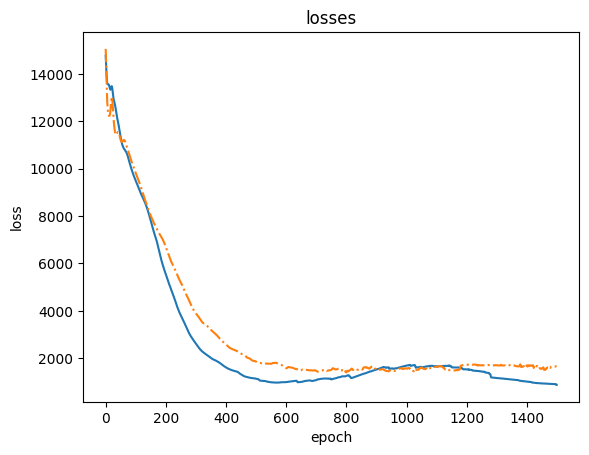

In [34]:
plt.plot(losses)
plt.plot(losses_val, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('losses')
plt.show()




# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])


